In [8]:
from keras.models import Model
from keras import backend as K
from keras.layers import LSTM, Input, Dense, Activation, Add, Reshape, Lambda, Concatenate, \
                         TimeDistributed, Bidirectional, Masking

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from keras.models import load_model

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
from collections import Counter

In [11]:
from corpus import *

In [12]:
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm

In [13]:
corpus = MTCorpus()

In [15]:
docs, links = corpus.documents, corpus.links
assert len([i for l in links for i in l]) == sum((len(d) for d in docs))

In [16]:
np.where(np.array([len(d) for d in docs]) > 6)

(array([ 56,  94, 107]),)

In [17]:
# pad with zeros, truncate longer than 6
X = pad_sequences(docs, dtype=float, maxlen=6, truncating='post',padding='post')

# convert links 1,1,2 -> [1,0,0]
#                        [1,0,0]
#                        [0,1,0]
Y = np.array([to_categorical(np.array(y)[:7]-1, num_classes=X.shape[1]) for y in links])
Y_ind = [len(y) for y in Y]
Y = pad_sequences(Y, dtype=int, maxlen=6,truncating='post', padding='post')

In [18]:
X[10]

array([[ 0.0029342 ,  0.12680417, -0.19088526, ..., -0.06182234,
         0.04977672,  0.10899878],
       [-0.0919743 ,  0.17462401, -0.16103521, ..., -0.0022366 ,
        -0.11932709, -0.035603  ],
       [ 0.02058966,  0.10300807, -0.20465474, ..., -0.01472439,
         0.03881067, -0.01305757],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [19]:
Y[10], links[10]

(array([[1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), [1, 1, 1])

In [20]:
X.shape

(112, 6, 300)

Counter({5: 71, 6: 24, 4: 11, 3: 3, 7: 2, 10: 1})


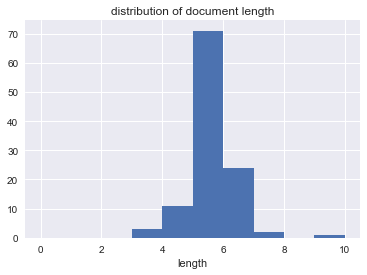

In [21]:
plt.title('distribution of document length')
plt.xlabel('length')
print(Counter([len(d) for d in docs]))
plt.hist([len(d) for d in docs],np.arange(11),);

Counter({1: 259, 3: 96, 5: 76, 2: 55, 4: 51, 6: 37, 7: 1, 9: 1})


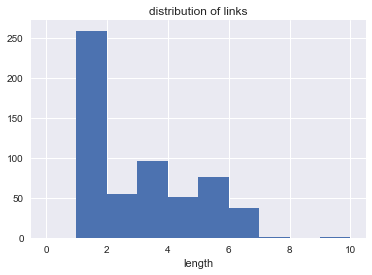

In [22]:
plt.title('distribution of links')
plt.xlabel('length')
print(Counter([i for l in links for i in l]))
plt.hist([i for l in links for i in l],np.arange(11),);

In [23]:
X.shape, Y.shape

((112, 6, 300), (112, 6, 6))

In [78]:
# X_train, Y_train = X[:96], Y[:96]
X_test, Y_test, Y_test_ind = X[100:], Y[100:], Y_ind[100:]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(96, 6, 300) (96, 6, 6) (12, 6, 300) (12, 6, 6)


In [125]:
def create_model(seq_len, hidden_size, dropout):
    inp = Input(shape=(seq_len, 300), name='input')

    # mask = Masking(mask_value=0., input_shape=(seq_len, 300))(inp)
    encoder = Bidirectional(LSTM(hidden_size//2, return_sequences=True, name='encoder', recurrent_dropout=dropout, dropout=dropout))(inp)
    decoder = LSTM(hidden_size, return_sequences=True, name='decoder', recurrent_dropout=dropout, dropout=dropout)(encoder)

    # glorot_uniform initializer:
    # uniform([-limit,limit]) where limit = sqrt(6/(in+out))
    # for hidden=512: uniform(-0.07, +0.07)
    E = TimeDistributed(Dense(hidden_size, use_bias=False, kernel_regularizer='l2'), name='E')(encoder)
    D = TimeDistributed(Dense(hidden_size, use_bias=False, kernel_regularizer='l2'), name='D')(decoder)

    DD = Lambda(lambda x: K.repeat_elements(K.expand_dims(x, 2), seq_len, 2))(D)

    add = Add(name='W1E_W2Di')
    tanh = Activation('tanh', name='tanh')

    # glorot_uniform initializer:
    # uniform([-limit,limit]) where limit = sqrt(6/(in+out))
    # for hidden=512: uniform(-0,108, +0,108)
    vt = Dense(1, use_bias=False, kernel_regularizer='l2', name='vT')
    softmax = Activation('softmax', name='softmax')

    attention = add([E,DD])
    attention = tanh(attention)
    attention = vt(attention)
    attention = Lambda(lambda x: K.squeeze(x, -1))(attention)
    attention = softmax(attention)

    model = Model(inputs=inp, outputs=attention)
    return model

In [126]:
model = create_model(seq_len=6, hidden_size=512, dropout=.9)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6, 300)       0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 6, 512)       1140736     input[0][0]                      
__________________________________________________________________________________________________
decoder (LSTM)                  (None, 6, 512)       2099200     bidirectional_10[0][0]           
__________________________________________________________________________________________________
D (TimeDistributed)             (None, 6, 512)       262144      decoder[0][0]                    
__________________________________________________________________________________________________
E (TimeDis

In [127]:
adam = Adam()
tensorboad = TensorBoard()

In [134]:
hidden_size = 512
seq_len = X.shape[1]
nb_epochs = 4000
batch_size = 10
dropout = .9

In [135]:
seed = 7
np.random.seed(seed)

histories = []
models = []

kfold = ShuffleSplit(n_splits=5, test_size=20, random_state=seed)

for train, val in tqdm(kfold.split(X[:100])):
    model = create_model(seq_len, hidden_size, dropout)
    model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])  

    print(X[train].shape, X[val].shape)
    history = model.fit(X[train], Y[train], validation_data=(X[val], Y[val]),
                        epochs=nb_epochs, batch_size=batch_size, verbose=2)

#     models.append(model)
    histories.append(history)
    
    scores = model.evaluate(X[val], Y[val], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# last validation accuracy
val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories]
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(val_acc), numpy.std(val_acc)))


0it [00:00, ?it/s]


(80, 6, 300) (20, 6, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 11s - loss: 10.5858 - categorical_accuracy: 0.4292 - val_loss: 9.2114 - val_categorical_accuracy: 0.5750
Epoch 2/4000
 - 1s - loss: 8.2348 - categorical_accuracy: 0.5271 - val_loss: 7.2346 - val_categorical_accuracy: 0.5750
Epoch 3/4000
 - 1s - loss: 6.3669 - categorical_accuracy: 0.5104 - val_loss: 5.7133 - val_categorical_accuracy: 0.5750
Epoch 4/4000
 - 1s - loss: 4.9407 - categorical_accuracy: 0.5479 - val_loss: 4.4533 - val_categorical_accuracy: 0.5750
Epoch 5/4000
 - 1s - loss: 3.9260 - categorical_accuracy: 0.5333 - val_loss: 3.4871 - val_categorical_accuracy: 0.5750
Epoch 6/4000
 - 1s - loss: 3.1222 - categorical_accuracy: 0.5458 - val_loss: 2.9203 - val_categorical_accuracy: 0.5750
Epoch 7/4000
 - 1s - loss: 2.6417 - categorical_accuracy: 0.4833 - val_loss: 2.4006 - val_categorical_accuracy: 0.5750
Epoch 8/4000
 - 1s - loss: 2.2049 - categorical_accuracy: 0.5458 - val_loss: 2.1365 - val_categ

Epoch 69/4000
 - 1s - loss: 0.9652 - categorical_accuracy: 0.6083 - val_loss: 1.0859 - val_categorical_accuracy: 0.6250
Epoch 70/4000
 - 1s - loss: 0.9835 - categorical_accuracy: 0.6625 - val_loss: 1.0626 - val_categorical_accuracy: 0.6333
Epoch 71/4000
 - 1s - loss: 0.9072 - categorical_accuracy: 0.6646 - val_loss: 1.0512 - val_categorical_accuracy: 0.6667
Epoch 72/4000
 - 1s - loss: 0.9278 - categorical_accuracy: 0.6708 - val_loss: 1.0761 - val_categorical_accuracy: 0.6333
Epoch 73/4000
 - 1s - loss: 0.9290 - categorical_accuracy: 0.6771 - val_loss: 1.0453 - val_categorical_accuracy: 0.7083
Epoch 74/4000
 - 1s - loss: 0.9690 - categorical_accuracy: 0.6167 - val_loss: 1.0720 - val_categorical_accuracy: 0.6333
Epoch 75/4000
 - 1s - loss: 0.9494 - categorical_accuracy: 0.6458 - val_loss: 1.0983 - val_categorical_accuracy: 0.6250
Epoch 76/4000
 - 1s - loss: 0.9716 - categorical_accuracy: 0.6229 - val_loss: 1.0420 - val_categorical_accuracy: 0.6667
Epoch 77/4000
 - 1s - loss: 0.9182 - cat

Epoch 137/4000
 - 1s - loss: 0.8234 - categorical_accuracy: 0.7000 - val_loss: 1.0504 - val_categorical_accuracy: 0.6167
Epoch 138/4000
 - 1s - loss: 0.8901 - categorical_accuracy: 0.6625 - val_loss: 1.0354 - val_categorical_accuracy: 0.6083
Epoch 139/4000
 - 1s - loss: 0.8171 - categorical_accuracy: 0.7292 - val_loss: 1.0380 - val_categorical_accuracy: 0.6500
Epoch 140/4000
 - 1s - loss: 0.8612 - categorical_accuracy: 0.6729 - val_loss: 1.0507 - val_categorical_accuracy: 0.6667
Epoch 141/4000
 - 2s - loss: 0.8535 - categorical_accuracy: 0.6854 - val_loss: 1.0668 - val_categorical_accuracy: 0.6250
Epoch 142/4000
 - 1s - loss: 0.8268 - categorical_accuracy: 0.7229 - val_loss: 1.0610 - val_categorical_accuracy: 0.6250
Epoch 143/4000
 - 1s - loss: 0.8977 - categorical_accuracy: 0.6917 - val_loss: 1.0497 - val_categorical_accuracy: 0.6000
Epoch 144/4000
 - 1s - loss: 0.8922 - categorical_accuracy: 0.6479 - val_loss: 1.0533 - val_categorical_accuracy: 0.6000
Epoch 145/4000
 - 1s - loss: 0.8

Epoch 205/4000
 - 1s - loss: 0.7941 - categorical_accuracy: 0.7104 - val_loss: 1.0231 - val_categorical_accuracy: 0.6417
Epoch 206/4000
 - 1s - loss: 0.8703 - categorical_accuracy: 0.6604 - val_loss: 1.0620 - val_categorical_accuracy: 0.6250
Epoch 207/4000
 - 1s - loss: 0.8261 - categorical_accuracy: 0.6875 - val_loss: 1.0399 - val_categorical_accuracy: 0.6083
Epoch 208/4000
 - 1s - loss: 0.8391 - categorical_accuracy: 0.7021 - val_loss: 1.0428 - val_categorical_accuracy: 0.6000
Epoch 209/4000
 - 1s - loss: 0.8201 - categorical_accuracy: 0.7062 - val_loss: 1.0464 - val_categorical_accuracy: 0.6250
Epoch 210/4000
 - 1s - loss: 0.7817 - categorical_accuracy: 0.6771 - val_loss: 1.0437 - val_categorical_accuracy: 0.6000
Epoch 211/4000
 - 1s - loss: 0.8520 - categorical_accuracy: 0.6750 - val_loss: 1.0405 - val_categorical_accuracy: 0.6417
Epoch 212/4000
 - 1s - loss: 0.8317 - categorical_accuracy: 0.6833 - val_loss: 1.0434 - val_categorical_accuracy: 0.5750
Epoch 213/4000
 - 1s - loss: 0.8

Epoch 273/4000
 - 1s - loss: 0.7753 - categorical_accuracy: 0.7146 - val_loss: 1.0589 - val_categorical_accuracy: 0.6417
Epoch 274/4000
 - 1s - loss: 0.8453 - categorical_accuracy: 0.6396 - val_loss: 1.0528 - val_categorical_accuracy: 0.5917
Epoch 275/4000
 - 1s - loss: 0.7455 - categorical_accuracy: 0.7417 - val_loss: 1.0487 - val_categorical_accuracy: 0.6000
Epoch 276/4000
 - 1s - loss: 0.7611 - categorical_accuracy: 0.6896 - val_loss: 1.0486 - val_categorical_accuracy: 0.6417
Epoch 277/4000
 - 1s - loss: 0.7594 - categorical_accuracy: 0.7063 - val_loss: 1.0376 - val_categorical_accuracy: 0.6417
Epoch 278/4000
 - 1s - loss: 0.7906 - categorical_accuracy: 0.6938 - val_loss: 1.0334 - val_categorical_accuracy: 0.5917
Epoch 279/4000
 - 1s - loss: 0.7577 - categorical_accuracy: 0.7292 - val_loss: 1.0211 - val_categorical_accuracy: 0.6417
Epoch 280/4000
 - 1s - loss: 0.7390 - categorical_accuracy: 0.7208 - val_loss: 1.0300 - val_categorical_accuracy: 0.6417
Epoch 281/4000
 - 1s - loss: 0.7

Epoch 341/4000
 - 1s - loss: 0.7345 - categorical_accuracy: 0.7271 - val_loss: 1.0393 - val_categorical_accuracy: 0.6083
Epoch 342/4000
 - 1s - loss: 0.7454 - categorical_accuracy: 0.7354 - val_loss: 1.0340 - val_categorical_accuracy: 0.6167
Epoch 343/4000
 - 1s - loss: 0.7264 - categorical_accuracy: 0.7208 - val_loss: 1.0387 - val_categorical_accuracy: 0.6167
Epoch 344/4000
 - 1s - loss: 0.6798 - categorical_accuracy: 0.7417 - val_loss: 1.0448 - val_categorical_accuracy: 0.6000
Epoch 345/4000
 - 1s - loss: 0.7007 - categorical_accuracy: 0.7500 - val_loss: 1.0455 - val_categorical_accuracy: 0.6583
Epoch 346/4000
 - 1s - loss: 0.7513 - categorical_accuracy: 0.7438 - val_loss: 1.0276 - val_categorical_accuracy: 0.6583
Epoch 347/4000
 - 1s - loss: 0.7307 - categorical_accuracy: 0.7125 - val_loss: 1.0207 - val_categorical_accuracy: 0.6583
Epoch 348/4000
 - 1s - loss: 0.7578 - categorical_accuracy: 0.7167 - val_loss: 1.0214 - val_categorical_accuracy: 0.6417
Epoch 349/4000
 - 1s - loss: 0.7

Epoch 409/4000
 - 1s - loss: 0.7510 - categorical_accuracy: 0.7146 - val_loss: 1.0485 - val_categorical_accuracy: 0.6000
Epoch 410/4000
 - 1s - loss: 0.6577 - categorical_accuracy: 0.7583 - val_loss: 1.0735 - val_categorical_accuracy: 0.5750
Epoch 411/4000
 - 1s - loss: 0.7126 - categorical_accuracy: 0.7125 - val_loss: 1.0739 - val_categorical_accuracy: 0.5750
Epoch 412/4000
 - 1s - loss: 0.6604 - categorical_accuracy: 0.7396 - val_loss: 1.0657 - val_categorical_accuracy: 0.6333
Epoch 413/4000
 - 1s - loss: 0.7120 - categorical_accuracy: 0.7000 - val_loss: 1.0656 - val_categorical_accuracy: 0.6167
Epoch 414/4000
 - 1s - loss: 0.6743 - categorical_accuracy: 0.7229 - val_loss: 1.0895 - val_categorical_accuracy: 0.6000
Epoch 415/4000
 - 1s - loss: 0.7520 - categorical_accuracy: 0.7312 - val_loss: 1.0368 - val_categorical_accuracy: 0.6000
Epoch 416/4000
 - 1s - loss: 0.7125 - categorical_accuracy: 0.6896 - val_loss: 1.0229 - val_categorical_accuracy: 0.6417
Epoch 417/4000
 - 1s - loss: 0.7

Epoch 477/4000
 - 1s - loss: 0.6632 - categorical_accuracy: 0.7250 - val_loss: 1.0633 - val_categorical_accuracy: 0.5917
Epoch 478/4000
 - 1s - loss: 0.6455 - categorical_accuracy: 0.7396 - val_loss: 1.0658 - val_categorical_accuracy: 0.6000
Epoch 479/4000
 - 1s - loss: 0.7347 - categorical_accuracy: 0.7313 - val_loss: 1.0692 - val_categorical_accuracy: 0.5917
Epoch 480/4000
 - 1s - loss: 0.6836 - categorical_accuracy: 0.7250 - val_loss: 1.0553 - val_categorical_accuracy: 0.6333
Epoch 481/4000
 - 1s - loss: 0.6768 - categorical_accuracy: 0.7375 - val_loss: 1.0425 - val_categorical_accuracy: 0.6417
Epoch 482/4000
 - 1s - loss: 0.6345 - categorical_accuracy: 0.7604 - val_loss: 1.0471 - val_categorical_accuracy: 0.6333
Epoch 483/4000
 - 1s - loss: 0.6620 - categorical_accuracy: 0.7562 - val_loss: 1.0445 - val_categorical_accuracy: 0.6417
Epoch 484/4000
 - 1s - loss: 0.6753 - categorical_accuracy: 0.7417 - val_loss: 1.0461 - val_categorical_accuracy: 0.6250
Epoch 485/4000
 - 1s - loss: 0.7

Epoch 545/4000
 - 1s - loss: 0.6499 - categorical_accuracy: 0.7604 - val_loss: 1.0831 - val_categorical_accuracy: 0.5750
Epoch 546/4000
 - 1s - loss: 0.6628 - categorical_accuracy: 0.7583 - val_loss: 1.0778 - val_categorical_accuracy: 0.5917
Epoch 547/4000
 - 1s - loss: 0.6190 - categorical_accuracy: 0.7687 - val_loss: 1.0728 - val_categorical_accuracy: 0.6000
Epoch 548/4000
 - 1s - loss: 0.6773 - categorical_accuracy: 0.7229 - val_loss: 1.0833 - val_categorical_accuracy: 0.6083
Epoch 549/4000
 - 1s - loss: 0.6452 - categorical_accuracy: 0.7521 - val_loss: 1.0790 - val_categorical_accuracy: 0.5917
Epoch 550/4000
 - 1s - loss: 0.7463 - categorical_accuracy: 0.7083 - val_loss: 1.0708 - val_categorical_accuracy: 0.6000
Epoch 551/4000
 - 1s - loss: 0.6599 - categorical_accuracy: 0.7208 - val_loss: 1.0808 - val_categorical_accuracy: 0.6167
Epoch 552/4000
 - 1s - loss: 0.6663 - categorical_accuracy: 0.7833 - val_loss: 1.0818 - val_categorical_accuracy: 0.6250
Epoch 553/4000
 - 1s - loss: 0.6

Epoch 613/4000
 - 1s - loss: 0.6384 - categorical_accuracy: 0.7271 - val_loss: 1.0661 - val_categorical_accuracy: 0.6083
Epoch 614/4000
 - 1s - loss: 0.6521 - categorical_accuracy: 0.7437 - val_loss: 1.0323 - val_categorical_accuracy: 0.6167
Epoch 615/4000
 - 1s - loss: 0.6165 - categorical_accuracy: 0.7729 - val_loss: 1.0360 - val_categorical_accuracy: 0.6167
Epoch 616/4000
 - 1s - loss: 0.6424 - categorical_accuracy: 0.7458 - val_loss: 1.0487 - val_categorical_accuracy: 0.6500
Epoch 617/4000
 - 1s - loss: 0.6534 - categorical_accuracy: 0.7333 - val_loss: 1.0605 - val_categorical_accuracy: 0.6250
Epoch 618/4000
 - 1s - loss: 0.6455 - categorical_accuracy: 0.7542 - val_loss: 1.0872 - val_categorical_accuracy: 0.5750
Epoch 619/4000
 - 1s - loss: 0.6150 - categorical_accuracy: 0.7583 - val_loss: 1.1267 - val_categorical_accuracy: 0.5750
Epoch 620/4000
 - 1s - loss: 0.6082 - categorical_accuracy: 0.7521 - val_loss: 1.1255 - val_categorical_accuracy: 0.5750
Epoch 621/4000
 - 1s - loss: 0.6

Epoch 681/4000
 - 1s - loss: 0.6679 - categorical_accuracy: 0.7354 - val_loss: 1.0966 - val_categorical_accuracy: 0.6083
Epoch 682/4000
 - 1s - loss: 0.6300 - categorical_accuracy: 0.7458 - val_loss: 1.0839 - val_categorical_accuracy: 0.6083
Epoch 683/4000
 - 1s - loss: 0.6228 - categorical_accuracy: 0.7521 - val_loss: 1.0804 - val_categorical_accuracy: 0.6083
Epoch 684/4000
 - 1s - loss: 0.5926 - categorical_accuracy: 0.7646 - val_loss: 1.0897 - val_categorical_accuracy: 0.5750
Epoch 685/4000
 - 1s - loss: 0.6176 - categorical_accuracy: 0.7604 - val_loss: 1.0906 - val_categorical_accuracy: 0.6000
Epoch 686/4000
 - 1s - loss: 0.6107 - categorical_accuracy: 0.7354 - val_loss: 1.0905 - val_categorical_accuracy: 0.6000
Epoch 687/4000
 - 1s - loss: 0.6019 - categorical_accuracy: 0.7500 - val_loss: 1.0873 - val_categorical_accuracy: 0.5833
Epoch 688/4000
 - 1s - loss: 0.6621 - categorical_accuracy: 0.7292 - val_loss: 1.0899 - val_categorical_accuracy: 0.5833
Epoch 689/4000
 - 1s - loss: 0.6

Epoch 749/4000
 - 1s - loss: 0.5904 - categorical_accuracy: 0.7500 - val_loss: 1.1126 - val_categorical_accuracy: 0.5417
Epoch 750/4000
 - 1s - loss: 0.6266 - categorical_accuracy: 0.7521 - val_loss: 1.1365 - val_categorical_accuracy: 0.5333
Epoch 751/4000
 - 1s - loss: 0.6156 - categorical_accuracy: 0.7563 - val_loss: 1.1519 - val_categorical_accuracy: 0.5417
Epoch 752/4000
 - 1s - loss: 0.5963 - categorical_accuracy: 0.7646 - val_loss: 1.1335 - val_categorical_accuracy: 0.5417
Epoch 753/4000
 - 1s - loss: 0.6126 - categorical_accuracy: 0.7562 - val_loss: 1.1239 - val_categorical_accuracy: 0.5500
Epoch 754/4000
 - 1s - loss: 0.5946 - categorical_accuracy: 0.7604 - val_loss: 1.1062 - val_categorical_accuracy: 0.5417
Epoch 755/4000
 - 1s - loss: 0.5885 - categorical_accuracy: 0.7687 - val_loss: 1.1030 - val_categorical_accuracy: 0.5583
Epoch 756/4000
 - 1s - loss: 0.5791 - categorical_accuracy: 0.7729 - val_loss: 1.1155 - val_categorical_accuracy: 0.5583
Epoch 757/4000
 - 1s - loss: 0.5

Epoch 817/4000
 - 1s - loss: 0.5835 - categorical_accuracy: 0.7667 - val_loss: 1.1298 - val_categorical_accuracy: 0.6000
Epoch 818/4000
 - 1s - loss: 0.5783 - categorical_accuracy: 0.7375 - val_loss: 1.1480 - val_categorical_accuracy: 0.5667
Epoch 819/4000
 - 1s - loss: 0.6007 - categorical_accuracy: 0.7542 - val_loss: 1.1525 - val_categorical_accuracy: 0.5500
Epoch 820/4000
 - 1s - loss: 0.6136 - categorical_accuracy: 0.7271 - val_loss: 1.1426 - val_categorical_accuracy: 0.5917
Epoch 821/4000
 - 1s - loss: 0.6600 - categorical_accuracy: 0.7042 - val_loss: 1.1051 - val_categorical_accuracy: 0.6000
Epoch 822/4000
 - 1s - loss: 0.6250 - categorical_accuracy: 0.7354 - val_loss: 1.1056 - val_categorical_accuracy: 0.6000
Epoch 823/4000
 - 1s - loss: 0.6532 - categorical_accuracy: 0.7292 - val_loss: 1.1139 - val_categorical_accuracy: 0.5667
Epoch 824/4000
 - 1s - loss: 0.6112 - categorical_accuracy: 0.7396 - val_loss: 1.1135 - val_categorical_accuracy: 0.6000
Epoch 825/4000
 - 1s - loss: 0.5

Epoch 885/4000
 - 1s - loss: 0.5831 - categorical_accuracy: 0.7667 - val_loss: 1.1191 - val_categorical_accuracy: 0.5500
Epoch 886/4000
 - 1s - loss: 0.5758 - categorical_accuracy: 0.7771 - val_loss: 1.1118 - val_categorical_accuracy: 0.5500
Epoch 887/4000
 - 1s - loss: 0.5749 - categorical_accuracy: 0.7625 - val_loss: 1.1490 - val_categorical_accuracy: 0.5417
Epoch 888/4000
 - 1s - loss: 0.5714 - categorical_accuracy: 0.7458 - val_loss: 1.1732 - val_categorical_accuracy: 0.5417
Epoch 889/4000
 - 1s - loss: 0.5930 - categorical_accuracy: 0.7604 - val_loss: 1.1605 - val_categorical_accuracy: 0.5417
Epoch 890/4000
 - 1s - loss: 0.5853 - categorical_accuracy: 0.7500 - val_loss: 1.1599 - val_categorical_accuracy: 0.5667
Epoch 891/4000
 - 1s - loss: 0.5552 - categorical_accuracy: 0.7729 - val_loss: 1.1752 - val_categorical_accuracy: 0.5583
Epoch 892/4000
 - 1s - loss: 0.6298 - categorical_accuracy: 0.7396 - val_loss: 1.1423 - val_categorical_accuracy: 0.5750
Epoch 893/4000
 - 1s - loss: 0.5

Epoch 953/4000
 - 1s - loss: 0.5585 - categorical_accuracy: 0.7708 - val_loss: 1.1408 - val_categorical_accuracy: 0.5833
Epoch 954/4000
 - 1s - loss: 0.5811 - categorical_accuracy: 0.7438 - val_loss: 1.1197 - val_categorical_accuracy: 0.5750
Epoch 955/4000
 - 1s - loss: 0.6046 - categorical_accuracy: 0.7396 - val_loss: 1.1236 - val_categorical_accuracy: 0.5750
Epoch 956/4000
 - 1s - loss: 0.5697 - categorical_accuracy: 0.7646 - val_loss: 1.1366 - val_categorical_accuracy: 0.5917
Epoch 957/4000
 - 1s - loss: 0.5644 - categorical_accuracy: 0.7708 - val_loss: 1.1388 - val_categorical_accuracy: 0.5750
Epoch 958/4000
 - 1s - loss: 0.5310 - categorical_accuracy: 0.7687 - val_loss: 1.1281 - val_categorical_accuracy: 0.6000
Epoch 959/4000
 - 1s - loss: 0.5844 - categorical_accuracy: 0.7542 - val_loss: 1.1237 - val_categorical_accuracy: 0.5583
Epoch 960/4000
 - 1s - loss: 0.5663 - categorical_accuracy: 0.7563 - val_loss: 1.1441 - val_categorical_accuracy: 0.5500
Epoch 961/4000
 - 1s - loss: 0.5

Epoch 1021/4000
 - 1s - loss: 0.5549 - categorical_accuracy: 0.7729 - val_loss: 1.1038 - val_categorical_accuracy: 0.6083
Epoch 1022/4000
 - 1s - loss: 0.5532 - categorical_accuracy: 0.7771 - val_loss: 1.1221 - val_categorical_accuracy: 0.5750
Epoch 1023/4000
 - 1s - loss: 0.5560 - categorical_accuracy: 0.7687 - val_loss: 1.1512 - val_categorical_accuracy: 0.5750
Epoch 1024/4000
 - 1s - loss: 0.5320 - categorical_accuracy: 0.7625 - val_loss: 1.1611 - val_categorical_accuracy: 0.5667
Epoch 1025/4000
 - 1s - loss: 0.5741 - categorical_accuracy: 0.7771 - val_loss: 1.1618 - val_categorical_accuracy: 0.5667
Epoch 1026/4000
 - 1s - loss: 0.5693 - categorical_accuracy: 0.7479 - val_loss: 1.1611 - val_categorical_accuracy: 0.5583
Epoch 1027/4000
 - 1s - loss: 0.5704 - categorical_accuracy: 0.7458 - val_loss: 1.1685 - val_categorical_accuracy: 0.5417
Epoch 1028/4000
 - 1s - loss: 0.5854 - categorical_accuracy: 0.7500 - val_loss: 1.1730 - val_categorical_accuracy: 0.5417
Epoch 1029/4000
 - 1s - 

Epoch 1089/4000
 - 1s - loss: 0.5684 - categorical_accuracy: 0.7438 - val_loss: 1.1504 - val_categorical_accuracy: 0.5500
Epoch 1090/4000
 - 1s - loss: 0.5330 - categorical_accuracy: 0.7521 - val_loss: 1.1596 - val_categorical_accuracy: 0.5417
Epoch 1091/4000
 - 1s - loss: 0.6041 - categorical_accuracy: 0.7563 - val_loss: 1.1703 - val_categorical_accuracy: 0.5417
Epoch 1092/4000
 - 1s - loss: 0.5889 - categorical_accuracy: 0.7333 - val_loss: 1.1621 - val_categorical_accuracy: 0.5583
Epoch 1093/4000
 - 1s - loss: 0.5655 - categorical_accuracy: 0.7583 - val_loss: 1.1460 - val_categorical_accuracy: 0.5417
Epoch 1094/4000
 - 1s - loss: 0.5648 - categorical_accuracy: 0.7500 - val_loss: 1.1358 - val_categorical_accuracy: 0.6000
Epoch 1095/4000
 - 1s - loss: 0.5668 - categorical_accuracy: 0.7521 - val_loss: 1.1317 - val_categorical_accuracy: 0.6000
Epoch 1096/4000
 - 1s - loss: 0.5587 - categorical_accuracy: 0.7604 - val_loss: 1.1402 - val_categorical_accuracy: 0.5667
Epoch 1097/4000
 - 1s - 

Epoch 1157/4000
 - 1s - loss: 0.5442 - categorical_accuracy: 0.7729 - val_loss: 1.1844 - val_categorical_accuracy: 0.5583
Epoch 1158/4000
 - 1s - loss: 0.5599 - categorical_accuracy: 0.7458 - val_loss: 1.1866 - val_categorical_accuracy: 0.5667
Epoch 1159/4000
 - 1s - loss: 0.5189 - categorical_accuracy: 0.7729 - val_loss: 1.1980 - val_categorical_accuracy: 0.5333
Epoch 1160/4000
 - 1s - loss: 0.5274 - categorical_accuracy: 0.7729 - val_loss: 1.1648 - val_categorical_accuracy: 0.5667
Epoch 1161/4000
 - 1s - loss: 0.5380 - categorical_accuracy: 0.7688 - val_loss: 1.1537 - val_categorical_accuracy: 0.5583
Epoch 1162/4000
 - 1s - loss: 0.5668 - categorical_accuracy: 0.7562 - val_loss: 1.1498 - val_categorical_accuracy: 0.5500
Epoch 1163/4000
 - 1s - loss: 0.5510 - categorical_accuracy: 0.7542 - val_loss: 1.1313 - val_categorical_accuracy: 0.5667
Epoch 1164/4000
 - 1s - loss: 0.5245 - categorical_accuracy: 0.7875 - val_loss: 1.1466 - val_categorical_accuracy: 0.5833
Epoch 1165/4000
 - 1s - 

Epoch 1225/4000
 - 1s - loss: 0.5344 - categorical_accuracy: 0.7604 - val_loss: 1.1615 - val_categorical_accuracy: 0.5917
Epoch 1226/4000
 - 1s - loss: 0.5481 - categorical_accuracy: 0.7625 - val_loss: 1.1553 - val_categorical_accuracy: 0.6000
Epoch 1227/4000
 - 1s - loss: 0.5590 - categorical_accuracy: 0.7500 - val_loss: 1.1219 - val_categorical_accuracy: 0.6000
Epoch 1228/4000
 - 1s - loss: 0.5330 - categorical_accuracy: 0.7625 - val_loss: 1.1185 - val_categorical_accuracy: 0.5833
Epoch 1229/4000
 - 1s - loss: 0.5801 - categorical_accuracy: 0.7375 - val_loss: 1.1645 - val_categorical_accuracy: 0.5583
Epoch 1230/4000
 - 1s - loss: 0.5437 - categorical_accuracy: 0.7604 - val_loss: 1.1627 - val_categorical_accuracy: 0.5667
Epoch 1231/4000
 - 1s - loss: 0.5330 - categorical_accuracy: 0.7667 - val_loss: 1.1698 - val_categorical_accuracy: 0.5583
Epoch 1232/4000
 - 1s - loss: 0.5563 - categorical_accuracy: 0.7813 - val_loss: 1.1513 - val_categorical_accuracy: 0.5667
Epoch 1233/4000
 - 1s - 

Epoch 1293/4000
 - 1s - loss: 0.5195 - categorical_accuracy: 0.7729 - val_loss: 1.1935 - val_categorical_accuracy: 0.5833
Epoch 1294/4000
 - 1s - loss: 0.5389 - categorical_accuracy: 0.7604 - val_loss: 1.1748 - val_categorical_accuracy: 0.5750
Epoch 1295/4000
 - 1s - loss: 0.5356 - categorical_accuracy: 0.7562 - val_loss: 1.1715 - val_categorical_accuracy: 0.5750
Epoch 1296/4000
 - 1s - loss: 0.5709 - categorical_accuracy: 0.7146 - val_loss: 1.1758 - val_categorical_accuracy: 0.5750
Epoch 1297/4000
 - 1s - loss: 0.5413 - categorical_accuracy: 0.7583 - val_loss: 1.1699 - val_categorical_accuracy: 0.5833
Epoch 1298/4000
 - 1s - loss: 0.5369 - categorical_accuracy: 0.7625 - val_loss: 1.1831 - val_categorical_accuracy: 0.5750
Epoch 1299/4000
 - 1s - loss: 0.5233 - categorical_accuracy: 0.7708 - val_loss: 1.1936 - val_categorical_accuracy: 0.5750
Epoch 1300/4000
 - 2s - loss: 0.5465 - categorical_accuracy: 0.7646 - val_loss: 1.1805 - val_categorical_accuracy: 0.5750
Epoch 1301/4000
 - 1s - 

Epoch 1361/4000
 - 1s - loss: 0.5445 - categorical_accuracy: 0.7708 - val_loss: 1.1952 - val_categorical_accuracy: 0.5667
Epoch 1362/4000
 - 1s - loss: 0.5399 - categorical_accuracy: 0.7812 - val_loss: 1.2132 - val_categorical_accuracy: 0.5750
Epoch 1363/4000
 - 1s - loss: 0.5227 - categorical_accuracy: 0.7479 - val_loss: 1.2077 - val_categorical_accuracy: 0.5750
Epoch 1364/4000
 - 1s - loss: 0.5051 - categorical_accuracy: 0.7771 - val_loss: 1.2023 - val_categorical_accuracy: 0.6083
Epoch 1365/4000
 - 1s - loss: 0.5392 - categorical_accuracy: 0.7750 - val_loss: 1.1966 - val_categorical_accuracy: 0.5917
Epoch 1366/4000
 - 1s - loss: 0.4953 - categorical_accuracy: 0.7812 - val_loss: 1.1945 - val_categorical_accuracy: 0.5833
Epoch 1367/4000
 - 1s - loss: 0.5149 - categorical_accuracy: 0.7604 - val_loss: 1.1961 - val_categorical_accuracy: 0.6000
Epoch 1368/4000
 - 1s - loss: 0.5093 - categorical_accuracy: 0.7771 - val_loss: 1.1836 - val_categorical_accuracy: 0.5750
Epoch 1369/4000
 - 1s - 

Epoch 1429/4000
 - 1s - loss: 0.4863 - categorical_accuracy: 0.7750 - val_loss: 1.1825 - val_categorical_accuracy: 0.5833
Epoch 1430/4000
 - 1s - loss: 0.5167 - categorical_accuracy: 0.7667 - val_loss: 1.1987 - val_categorical_accuracy: 0.5750
Epoch 1431/4000
 - 1s - loss: 0.5117 - categorical_accuracy: 0.7812 - val_loss: 1.2248 - val_categorical_accuracy: 0.5417
Epoch 1432/4000
 - 1s - loss: 0.5217 - categorical_accuracy: 0.7521 - val_loss: 1.2025 - val_categorical_accuracy: 0.5750
Epoch 1433/4000
 - 1s - loss: 0.5320 - categorical_accuracy: 0.7417 - val_loss: 1.1938 - val_categorical_accuracy: 0.5833
Epoch 1434/4000
 - 1s - loss: 0.4823 - categorical_accuracy: 0.7750 - val_loss: 1.1799 - val_categorical_accuracy: 0.5833
Epoch 1435/4000
 - 1s - loss: 0.5271 - categorical_accuracy: 0.7396 - val_loss: 1.1809 - val_categorical_accuracy: 0.5750
Epoch 1436/4000
 - 1s - loss: 0.5470 - categorical_accuracy: 0.7438 - val_loss: 1.1451 - val_categorical_accuracy: 0.5750
Epoch 1437/4000
 - 1s - 

Epoch 1497/4000
 - 1s - loss: 0.5188 - categorical_accuracy: 0.7625 - val_loss: 1.1987 - val_categorical_accuracy: 0.5833
Epoch 1498/4000
 - 1s - loss: 0.5247 - categorical_accuracy: 0.7583 - val_loss: 1.2053 - val_categorical_accuracy: 0.5750
Epoch 1499/4000
 - 1s - loss: 0.5051 - categorical_accuracy: 0.7750 - val_loss: 1.1958 - val_categorical_accuracy: 0.5750
Epoch 1500/4000
 - 1s - loss: 0.5168 - categorical_accuracy: 0.7625 - val_loss: 1.1984 - val_categorical_accuracy: 0.5583
Epoch 1501/4000
 - 1s - loss: 0.5099 - categorical_accuracy: 0.7771 - val_loss: 1.1925 - val_categorical_accuracy: 0.5667
Epoch 1502/4000
 - 1s - loss: 0.4849 - categorical_accuracy: 0.7958 - val_loss: 1.1875 - val_categorical_accuracy: 0.5667
Epoch 1503/4000
 - 1s - loss: 0.5638 - categorical_accuracy: 0.7312 - val_loss: 1.1624 - val_categorical_accuracy: 0.5833
Epoch 1504/4000
 - 1s - loss: 0.5145 - categorical_accuracy: 0.7583 - val_loss: 1.1656 - val_categorical_accuracy: 0.5750
Epoch 1505/4000
 - 1s - 

Epoch 1565/4000
 - 1s - loss: 0.5054 - categorical_accuracy: 0.7812 - val_loss: 1.2531 - val_categorical_accuracy: 0.5667
Epoch 1566/4000
 - 1s - loss: 0.5242 - categorical_accuracy: 0.7625 - val_loss: 1.2245 - val_categorical_accuracy: 0.5667
Epoch 1567/4000
 - 1s - loss: 0.4922 - categorical_accuracy: 0.7687 - val_loss: 1.2100 - val_categorical_accuracy: 0.5833
Epoch 1568/4000
 - 1s - loss: 0.4929 - categorical_accuracy: 0.7729 - val_loss: 1.2115 - val_categorical_accuracy: 0.6000
Epoch 1569/4000
 - 1s - loss: 0.5387 - categorical_accuracy: 0.7625 - val_loss: 1.1679 - val_categorical_accuracy: 0.5917
Epoch 1570/4000
 - 1s - loss: 0.5127 - categorical_accuracy: 0.7562 - val_loss: 1.1664 - val_categorical_accuracy: 0.5917
Epoch 1571/4000
 - 1s - loss: 0.5574 - categorical_accuracy: 0.7271 - val_loss: 1.2005 - val_categorical_accuracy: 0.5667
Epoch 1572/4000
 - 1s - loss: 0.5183 - categorical_accuracy: 0.7646 - val_loss: 1.1962 - val_categorical_accuracy: 0.5833
Epoch 1573/4000
 - 1s - 

Epoch 1633/4000
 - 1s - loss: 0.5033 - categorical_accuracy: 0.7813 - val_loss: 1.2039 - val_categorical_accuracy: 0.5750
Epoch 1634/4000
 - 1s - loss: 0.5774 - categorical_accuracy: 0.7292 - val_loss: 1.2034 - val_categorical_accuracy: 0.5833
Epoch 1635/4000
 - 1s - loss: 0.5274 - categorical_accuracy: 0.7479 - val_loss: 1.1986 - val_categorical_accuracy: 0.5833
Epoch 1636/4000
 - 1s - loss: 0.4787 - categorical_accuracy: 0.7542 - val_loss: 1.2169 - val_categorical_accuracy: 0.5833
Epoch 1637/4000
 - 1s - loss: 0.5244 - categorical_accuracy: 0.7562 - val_loss: 1.1953 - val_categorical_accuracy: 0.5917
Epoch 1638/4000
 - 1s - loss: 0.5162 - categorical_accuracy: 0.7604 - val_loss: 1.2099 - val_categorical_accuracy: 0.5833
Epoch 1639/4000
 - 1s - loss: 0.5057 - categorical_accuracy: 0.7562 - val_loss: 1.2381 - val_categorical_accuracy: 0.5750
Epoch 1640/4000
 - 1s - loss: 0.5047 - categorical_accuracy: 0.7750 - val_loss: 1.2131 - val_categorical_accuracy: 0.6167
Epoch 1641/4000
 - 1s - 

Epoch 1701/4000
 - 1s - loss: 0.5016 - categorical_accuracy: 0.7563 - val_loss: 1.1695 - val_categorical_accuracy: 0.6167
Epoch 1702/4000
 - 1s - loss: 0.5125 - categorical_accuracy: 0.7750 - val_loss: 1.1800 - val_categorical_accuracy: 0.6000
Epoch 1703/4000
 - 1s - loss: 0.5155 - categorical_accuracy: 0.7500 - val_loss: 1.1667 - val_categorical_accuracy: 0.6167
Epoch 1704/4000
 - 1s - loss: 0.5143 - categorical_accuracy: 0.7896 - val_loss: 1.1713 - val_categorical_accuracy: 0.6000
Epoch 1705/4000
 - 1s - loss: 0.5015 - categorical_accuracy: 0.7792 - val_loss: 1.1701 - val_categorical_accuracy: 0.6167
Epoch 1706/4000
 - 1s - loss: 0.4737 - categorical_accuracy: 0.7500 - val_loss: 1.1810 - val_categorical_accuracy: 0.6000
Epoch 1707/4000
 - 1s - loss: 0.4854 - categorical_accuracy: 0.7667 - val_loss: 1.1848 - val_categorical_accuracy: 0.6250
Epoch 1708/4000
 - 1s - loss: 0.4860 - categorical_accuracy: 0.7625 - val_loss: 1.1866 - val_categorical_accuracy: 0.6083
Epoch 1709/4000
 - 1s - 

Epoch 1769/4000
 - 1s - loss: 0.5115 - categorical_accuracy: 0.7500 - val_loss: 1.2443 - val_categorical_accuracy: 0.6000
Epoch 1770/4000
 - 1s - loss: 0.4953 - categorical_accuracy: 0.7583 - val_loss: 1.2152 - val_categorical_accuracy: 0.6083
Epoch 1771/4000
 - 1s - loss: 0.4833 - categorical_accuracy: 0.7833 - val_loss: 1.2035 - val_categorical_accuracy: 0.6167
Epoch 1772/4000
 - 1s - loss: 0.5377 - categorical_accuracy: 0.7250 - val_loss: 1.2043 - val_categorical_accuracy: 0.5917
Epoch 1773/4000
 - 1s - loss: 0.5172 - categorical_accuracy: 0.7625 - val_loss: 1.1886 - val_categorical_accuracy: 0.6083
Epoch 1774/4000
 - 1s - loss: 0.4911 - categorical_accuracy: 0.7771 - val_loss: 1.2089 - val_categorical_accuracy: 0.6000
Epoch 1775/4000
 - 1s - loss: 0.5046 - categorical_accuracy: 0.7729 - val_loss: 1.1952 - val_categorical_accuracy: 0.6167
Epoch 1776/4000
 - 1s - loss: 0.4921 - categorical_accuracy: 0.7938 - val_loss: 1.1957 - val_categorical_accuracy: 0.6167
Epoch 1777/4000
 - 1s - 

Epoch 1837/4000
 - 1s - loss: 0.4834 - categorical_accuracy: 0.7833 - val_loss: 1.2343 - val_categorical_accuracy: 0.6000
Epoch 1838/4000
 - 1s - loss: 0.4965 - categorical_accuracy: 0.7667 - val_loss: 1.2213 - val_categorical_accuracy: 0.6417
Epoch 1839/4000
 - 1s - loss: 0.4680 - categorical_accuracy: 0.7958 - val_loss: 1.2273 - val_categorical_accuracy: 0.6167
Epoch 1840/4000
 - 1s - loss: 0.4622 - categorical_accuracy: 0.7875 - val_loss: 1.2105 - val_categorical_accuracy: 0.6083
Epoch 1841/4000
 - 1s - loss: 0.4634 - categorical_accuracy: 0.7812 - val_loss: 1.1989 - val_categorical_accuracy: 0.6083
Epoch 1842/4000
 - 1s - loss: 0.4868 - categorical_accuracy: 0.7792 - val_loss: 1.2211 - val_categorical_accuracy: 0.5750
Epoch 1843/4000
 - 1s - loss: 0.4667 - categorical_accuracy: 0.7646 - val_loss: 1.2650 - val_categorical_accuracy: 0.5917
Epoch 1844/4000
 - 1s - loss: 0.5009 - categorical_accuracy: 0.7667 - val_loss: 1.2682 - val_categorical_accuracy: 0.5917
Epoch 1845/4000
 - 1s - 

Epoch 1905/4000
 - 1s - loss: 0.5017 - categorical_accuracy: 0.7687 - val_loss: 1.2182 - val_categorical_accuracy: 0.6250
Epoch 1906/4000
 - 1s - loss: 0.4798 - categorical_accuracy: 0.7812 - val_loss: 1.2144 - val_categorical_accuracy: 0.6417
Epoch 1907/4000
 - 1s - loss: 0.4801 - categorical_accuracy: 0.7750 - val_loss: 1.1970 - val_categorical_accuracy: 0.6417
Epoch 1908/4000
 - 1s - loss: 0.4491 - categorical_accuracy: 0.7771 - val_loss: 1.2000 - val_categorical_accuracy: 0.6417
Epoch 1909/4000
 - 1s - loss: 0.4915 - categorical_accuracy: 0.7771 - val_loss: 1.1925 - val_categorical_accuracy: 0.6417
Epoch 1910/4000
 - 1s - loss: 0.4734 - categorical_accuracy: 0.7854 - val_loss: 1.2000 - val_categorical_accuracy: 0.6167
Epoch 1911/4000
 - 1s - loss: 0.4512 - categorical_accuracy: 0.7771 - val_loss: 1.1947 - val_categorical_accuracy: 0.6417
Epoch 1912/4000
 - 1s - loss: 0.4892 - categorical_accuracy: 0.7813 - val_loss: 1.1966 - val_categorical_accuracy: 0.6167
Epoch 1913/4000
 - 1s - 

Epoch 1973/4000
 - 1s - loss: 0.4970 - categorical_accuracy: 0.7708 - val_loss: 1.1764 - val_categorical_accuracy: 0.6500
Epoch 1974/4000
 - 1s - loss: 0.4424 - categorical_accuracy: 0.7792 - val_loss: 1.1744 - val_categorical_accuracy: 0.6417
Epoch 1975/4000
 - 1s - loss: 0.4714 - categorical_accuracy: 0.7771 - val_loss: 1.1895 - val_categorical_accuracy: 0.6167
Epoch 1976/4000
 - 1s - loss: 0.4482 - categorical_accuracy: 0.7875 - val_loss: 1.2060 - val_categorical_accuracy: 0.6167
Epoch 1977/4000
 - 1s - loss: 0.4912 - categorical_accuracy: 0.7917 - val_loss: 1.1998 - val_categorical_accuracy: 0.6167
Epoch 1978/4000
 - 1s - loss: 0.5068 - categorical_accuracy: 0.7771 - val_loss: 1.2169 - val_categorical_accuracy: 0.6083
Epoch 1979/4000
 - 1s - loss: 0.4634 - categorical_accuracy: 0.7812 - val_loss: 1.1722 - val_categorical_accuracy: 0.6417
Epoch 1980/4000
 - 1s - loss: 0.4969 - categorical_accuracy: 0.7625 - val_loss: 1.1597 - val_categorical_accuracy: 0.6667
Epoch 1981/4000
 - 1s - 

Epoch 2041/4000
 - 1s - loss: 0.4623 - categorical_accuracy: 0.7938 - val_loss: 1.2506 - val_categorical_accuracy: 0.6083
Epoch 2042/4000
 - 1s - loss: 0.4850 - categorical_accuracy: 0.7771 - val_loss: 1.2443 - val_categorical_accuracy: 0.6167
Epoch 2043/4000
 - 1s - loss: 0.4853 - categorical_accuracy: 0.7750 - val_loss: 1.2459 - val_categorical_accuracy: 0.6167
Epoch 2044/4000
 - 1s - loss: 0.4875 - categorical_accuracy: 0.7833 - val_loss: 1.2441 - val_categorical_accuracy: 0.6250
Epoch 2045/4000
 - 1s - loss: 0.4697 - categorical_accuracy: 0.7875 - val_loss: 1.2168 - val_categorical_accuracy: 0.6500
Epoch 2046/4000
 - 1s - loss: 0.4530 - categorical_accuracy: 0.7875 - val_loss: 1.2187 - val_categorical_accuracy: 0.6583
Epoch 2047/4000
 - 1s - loss: 0.4445 - categorical_accuracy: 0.7896 - val_loss: 1.2180 - val_categorical_accuracy: 0.6500
Epoch 2048/4000
 - 1s - loss: 0.4894 - categorical_accuracy: 0.7708 - val_loss: 1.1942 - val_categorical_accuracy: 0.6500
Epoch 2049/4000
 - 1s - 

Epoch 2109/4000
 - 1s - loss: 0.5019 - categorical_accuracy: 0.7687 - val_loss: 1.2731 - val_categorical_accuracy: 0.6000
Epoch 2110/4000
 - 1s - loss: 0.4550 - categorical_accuracy: 0.8000 - val_loss: 1.2704 - val_categorical_accuracy: 0.5833
Epoch 2111/4000
 - 1s - loss: 0.4646 - categorical_accuracy: 0.7875 - val_loss: 1.2862 - val_categorical_accuracy: 0.5833
Epoch 2112/4000
 - 1s - loss: 0.4479 - categorical_accuracy: 0.7812 - val_loss: 1.2840 - val_categorical_accuracy: 0.5750
Epoch 2113/4000
 - 1s - loss: 0.4742 - categorical_accuracy: 0.7792 - val_loss: 1.2747 - val_categorical_accuracy: 0.5750
Epoch 2114/4000
 - 1s - loss: 0.4580 - categorical_accuracy: 0.7812 - val_loss: 1.2880 - val_categorical_accuracy: 0.5917
Epoch 2115/4000
 - 1s - loss: 0.4418 - categorical_accuracy: 0.7917 - val_loss: 1.2836 - val_categorical_accuracy: 0.6167
Epoch 2116/4000
 - 1s - loss: 0.4571 - categorical_accuracy: 0.7688 - val_loss: 1.2618 - val_categorical_accuracy: 0.6167
Epoch 2117/4000
 - 1s - 

Epoch 2177/4000
 - 1s - loss: 0.4590 - categorical_accuracy: 0.7854 - val_loss: 1.2335 - val_categorical_accuracy: 0.6583
Epoch 2178/4000
 - 1s - loss: 0.4582 - categorical_accuracy: 0.8000 - val_loss: 1.2472 - val_categorical_accuracy: 0.6417
Epoch 2179/4000
 - 1s - loss: 0.4473 - categorical_accuracy: 0.8042 - val_loss: 1.2478 - val_categorical_accuracy: 0.6250
Epoch 2180/4000
 - 1s - loss: 0.4640 - categorical_accuracy: 0.7771 - val_loss: 1.2370 - val_categorical_accuracy: 0.6167
Epoch 2181/4000
 - 1s - loss: 0.4770 - categorical_accuracy: 0.7500 - val_loss: 1.2477 - val_categorical_accuracy: 0.6167
Epoch 2182/4000
 - 1s - loss: 0.4507 - categorical_accuracy: 0.7896 - val_loss: 1.2601 - val_categorical_accuracy: 0.6167
Epoch 2183/4000
 - 1s - loss: 0.4800 - categorical_accuracy: 0.7771 - val_loss: 1.2636 - val_categorical_accuracy: 0.6333
Epoch 2184/4000
 - 1s - loss: 0.4406 - categorical_accuracy: 0.7812 - val_loss: 1.2396 - val_categorical_accuracy: 0.6417
Epoch 2185/4000
 - 1s - 

Epoch 2245/4000
 - 1s - loss: 0.4601 - categorical_accuracy: 0.7667 - val_loss: 1.2468 - val_categorical_accuracy: 0.6167
Epoch 2246/4000
 - 1s - loss: 0.4680 - categorical_accuracy: 0.8083 - val_loss: 1.2507 - val_categorical_accuracy: 0.6167
Epoch 2247/4000
 - 1s - loss: 0.4970 - categorical_accuracy: 0.7646 - val_loss: 1.2391 - val_categorical_accuracy: 0.6500
Epoch 2248/4000
 - 1s - loss: 0.4759 - categorical_accuracy: 0.7979 - val_loss: 1.2449 - val_categorical_accuracy: 0.6250
Epoch 2249/4000
 - 1s - loss: 0.4420 - categorical_accuracy: 0.7875 - val_loss: 1.2146 - val_categorical_accuracy: 0.6417
Epoch 2250/4000
 - 1s - loss: 0.4045 - categorical_accuracy: 0.8250 - val_loss: 1.2100 - val_categorical_accuracy: 0.6583
Epoch 2251/4000
 - 1s - loss: 0.4536 - categorical_accuracy: 0.7979 - val_loss: 1.2579 - val_categorical_accuracy: 0.6250
Epoch 2252/4000
 - 1s - loss: 0.4691 - categorical_accuracy: 0.7750 - val_loss: 1.2821 - val_categorical_accuracy: 0.6250
Epoch 2253/4000
 - 1s - 

Epoch 2313/4000
 - 1s - loss: 0.4343 - categorical_accuracy: 0.7813 - val_loss: 1.3204 - val_categorical_accuracy: 0.6083
Epoch 2314/4000
 - 1s - loss: 0.4553 - categorical_accuracy: 0.7854 - val_loss: 1.3063 - val_categorical_accuracy: 0.5917
Epoch 2315/4000
 - 1s - loss: 0.4359 - categorical_accuracy: 0.7979 - val_loss: 1.2956 - val_categorical_accuracy: 0.6333
Epoch 2316/4000
 - 1s - loss: 0.4411 - categorical_accuracy: 0.8104 - val_loss: 1.3194 - val_categorical_accuracy: 0.6083
Epoch 2317/4000
 - 1s - loss: 0.4593 - categorical_accuracy: 0.7812 - val_loss: 1.2965 - val_categorical_accuracy: 0.6250
Epoch 2318/4000
 - 1s - loss: 0.4579 - categorical_accuracy: 0.7729 - val_loss: 1.2956 - val_categorical_accuracy: 0.6333
Epoch 2319/4000
 - 1s - loss: 0.4346 - categorical_accuracy: 0.7979 - val_loss: 1.2911 - val_categorical_accuracy: 0.6250
Epoch 2320/4000
 - 1s - loss: 0.4566 - categorical_accuracy: 0.7687 - val_loss: 1.2917 - val_categorical_accuracy: 0.6250
Epoch 2321/4000
 - 1s - 

Epoch 2381/4000
 - 1s - loss: 0.4449 - categorical_accuracy: 0.8021 - val_loss: 1.2600 - val_categorical_accuracy: 0.6167
Epoch 2382/4000
 - 1s - loss: 0.4431 - categorical_accuracy: 0.7875 - val_loss: 1.2486 - val_categorical_accuracy: 0.6333
Epoch 2383/4000
 - 1s - loss: 0.4800 - categorical_accuracy: 0.7646 - val_loss: 1.2752 - val_categorical_accuracy: 0.6167
Epoch 2384/4000
 - 1s - loss: 0.4434 - categorical_accuracy: 0.7729 - val_loss: 1.2880 - val_categorical_accuracy: 0.6167
Epoch 2385/4000
 - 1s - loss: 0.4820 - categorical_accuracy: 0.7729 - val_loss: 1.2864 - val_categorical_accuracy: 0.6167
Epoch 2386/4000
 - 1s - loss: 0.4528 - categorical_accuracy: 0.7708 - val_loss: 1.3036 - val_categorical_accuracy: 0.6000
Epoch 2387/4000
 - 1s - loss: 0.4571 - categorical_accuracy: 0.7979 - val_loss: 1.3279 - val_categorical_accuracy: 0.6167
Epoch 2388/4000
 - 1s - loss: 0.4761 - categorical_accuracy: 0.7875 - val_loss: 1.2994 - val_categorical_accuracy: 0.6083
Epoch 2389/4000
 - 1s - 

Epoch 2449/4000
 - 1s - loss: 0.4524 - categorical_accuracy: 0.7896 - val_loss: 1.3226 - val_categorical_accuracy: 0.6250
Epoch 2450/4000
 - 1s - loss: 0.4563 - categorical_accuracy: 0.8063 - val_loss: 1.3516 - val_categorical_accuracy: 0.6167
Epoch 2451/4000
 - 1s - loss: 0.4753 - categorical_accuracy: 0.7833 - val_loss: 1.3463 - val_categorical_accuracy: 0.6250
Epoch 2452/4000
 - 1s - loss: 0.4515 - categorical_accuracy: 0.7812 - val_loss: 1.3378 - val_categorical_accuracy: 0.6083
Epoch 2453/4000
 - 1s - loss: 0.4210 - categorical_accuracy: 0.8021 - val_loss: 1.3214 - val_categorical_accuracy: 0.6333
Epoch 2454/4000
 - 1s - loss: 0.4331 - categorical_accuracy: 0.8063 - val_loss: 1.3291 - val_categorical_accuracy: 0.6500
Epoch 2455/4000
 - 1s - loss: 0.4565 - categorical_accuracy: 0.8000 - val_loss: 1.3462 - val_categorical_accuracy: 0.6333
Epoch 2456/4000
 - 1s - loss: 0.4540 - categorical_accuracy: 0.7875 - val_loss: 1.3421 - val_categorical_accuracy: 0.6000
Epoch 2457/4000
 - 1s - 

Epoch 2517/4000
 - 1s - loss: 0.4205 - categorical_accuracy: 0.8021 - val_loss: 1.3895 - val_categorical_accuracy: 0.6167
Epoch 2518/4000
 - 1s - loss: 0.4677 - categorical_accuracy: 0.7771 - val_loss: 1.3523 - val_categorical_accuracy: 0.6500
Epoch 2519/4000
 - 1s - loss: 0.4411 - categorical_accuracy: 0.7875 - val_loss: 1.3254 - val_categorical_accuracy: 0.6500
Epoch 2520/4000
 - 1s - loss: 0.4440 - categorical_accuracy: 0.7875 - val_loss: 1.3194 - val_categorical_accuracy: 0.6583
Epoch 2521/4000
 - 1s - loss: 0.4168 - categorical_accuracy: 0.8042 - val_loss: 1.3102 - val_categorical_accuracy: 0.6583
Epoch 2522/4000
 - 1s - loss: 0.4540 - categorical_accuracy: 0.7875 - val_loss: 1.3424 - val_categorical_accuracy: 0.6417
Epoch 2523/4000
 - 1s - loss: 0.4886 - categorical_accuracy: 0.7958 - val_loss: 1.3116 - val_categorical_accuracy: 0.6500
Epoch 2524/4000
 - 1s - loss: 0.4397 - categorical_accuracy: 0.8083 - val_loss: 1.2849 - val_categorical_accuracy: 0.6583
Epoch 2525/4000
 - 1s - 

Epoch 2585/4000
 - 1s - loss: 0.4125 - categorical_accuracy: 0.7979 - val_loss: 1.3378 - val_categorical_accuracy: 0.6417
Epoch 2586/4000
 - 1s - loss: 0.3953 - categorical_accuracy: 0.8104 - val_loss: 1.3316 - val_categorical_accuracy: 0.6417
Epoch 2587/4000
 - 1s - loss: 0.4260 - categorical_accuracy: 0.7812 - val_loss: 1.3215 - val_categorical_accuracy: 0.6417
Epoch 2588/4000
 - 1s - loss: 0.3885 - categorical_accuracy: 0.8146 - val_loss: 1.3360 - val_categorical_accuracy: 0.6500
Epoch 2589/4000
 - 1s - loss: 0.4508 - categorical_accuracy: 0.7792 - val_loss: 1.3331 - val_categorical_accuracy: 0.6667
Epoch 2590/4000
 - 1s - loss: 0.4061 - categorical_accuracy: 0.8125 - val_loss: 1.3308 - val_categorical_accuracy: 0.6500
Epoch 2591/4000
 - 1s - loss: 0.4086 - categorical_accuracy: 0.8042 - val_loss: 1.3442 - val_categorical_accuracy: 0.6500
Epoch 2592/4000
 - 1s - loss: 0.3835 - categorical_accuracy: 0.8125 - val_loss: 1.3525 - val_categorical_accuracy: 0.6417
Epoch 2593/4000
 - 1s - 

Epoch 2653/4000
 - 1s - loss: 0.4358 - categorical_accuracy: 0.7938 - val_loss: 1.3868 - val_categorical_accuracy: 0.6250
Epoch 2654/4000
 - 1s - loss: 0.4437 - categorical_accuracy: 0.7938 - val_loss: 1.3719 - val_categorical_accuracy: 0.6417
Epoch 2655/4000
 - 1s - loss: 0.4043 - categorical_accuracy: 0.8125 - val_loss: 1.3618 - val_categorical_accuracy: 0.6333
Epoch 2656/4000
 - 1s - loss: 0.4211 - categorical_accuracy: 0.7958 - val_loss: 1.3641 - val_categorical_accuracy: 0.6250
Epoch 2657/4000
 - 1s - loss: 0.4210 - categorical_accuracy: 0.7979 - val_loss: 1.3502 - val_categorical_accuracy: 0.6417
Epoch 2658/4000
 - 1s - loss: 0.4325 - categorical_accuracy: 0.7938 - val_loss: 1.3582 - val_categorical_accuracy: 0.6333
Epoch 2659/4000
 - 1s - loss: 0.4270 - categorical_accuracy: 0.7813 - val_loss: 1.3567 - val_categorical_accuracy: 0.6417
Epoch 2660/4000
 - 1s - loss: 0.4368 - categorical_accuracy: 0.8000 - val_loss: 1.3705 - val_categorical_accuracy: 0.6333
Epoch 2661/4000
 - 1s - 

Epoch 2721/4000
 - 1s - loss: 0.4098 - categorical_accuracy: 0.8063 - val_loss: 1.4244 - val_categorical_accuracy: 0.6417
Epoch 2722/4000
 - 1s - loss: 0.4196 - categorical_accuracy: 0.8208 - val_loss: 1.3903 - val_categorical_accuracy: 0.6500
Epoch 2723/4000
 - 1s - loss: 0.3805 - categorical_accuracy: 0.8271 - val_loss: 1.3849 - val_categorical_accuracy: 0.6417
Epoch 2724/4000
 - 1s - loss: 0.4183 - categorical_accuracy: 0.7896 - val_loss: 1.3742 - val_categorical_accuracy: 0.6417
Epoch 2725/4000
 - 1s - loss: 0.4276 - categorical_accuracy: 0.8146 - val_loss: 1.3693 - val_categorical_accuracy: 0.6583
Epoch 2726/4000
 - 1s - loss: 0.4087 - categorical_accuracy: 0.8042 - val_loss: 1.3682 - val_categorical_accuracy: 0.6500
Epoch 2727/4000
 - 1s - loss: 0.4620 - categorical_accuracy: 0.8021 - val_loss: 1.4362 - val_categorical_accuracy: 0.6083
Epoch 2728/4000
 - 1s - loss: 0.4216 - categorical_accuracy: 0.8167 - val_loss: 1.4005 - val_categorical_accuracy: 0.6250
Epoch 2729/4000
 - 1s - 

Epoch 2789/4000
 - 1s - loss: 0.4077 - categorical_accuracy: 0.8167 - val_loss: 1.4222 - val_categorical_accuracy: 0.6417
Epoch 2790/4000
 - 1s - loss: 0.4252 - categorical_accuracy: 0.8042 - val_loss: 1.4384 - val_categorical_accuracy: 0.6333
Epoch 2791/4000
 - 1s - loss: 0.4062 - categorical_accuracy: 0.8125 - val_loss: 1.4668 - val_categorical_accuracy: 0.5917
Epoch 2792/4000
 - 1s - loss: 0.4202 - categorical_accuracy: 0.8042 - val_loss: 1.4867 - val_categorical_accuracy: 0.5833
Epoch 2793/4000
 - 1s - loss: 0.4152 - categorical_accuracy: 0.7875 - val_loss: 1.4645 - val_categorical_accuracy: 0.6167
Epoch 2794/4000
 - 1s - loss: 0.4235 - categorical_accuracy: 0.7958 - val_loss: 1.4726 - val_categorical_accuracy: 0.6083
Epoch 2795/4000
 - 1s - loss: 0.4141 - categorical_accuracy: 0.8000 - val_loss: 1.5001 - val_categorical_accuracy: 0.5750
Epoch 2796/4000
 - 1s - loss: 0.4332 - categorical_accuracy: 0.8083 - val_loss: 1.4558 - val_categorical_accuracy: 0.6167
Epoch 2797/4000
 - 1s - 

Epoch 2857/4000
 - 1s - loss: 0.4355 - categorical_accuracy: 0.8042 - val_loss: 1.4801 - val_categorical_accuracy: 0.6000
Epoch 2858/4000
 - 1s - loss: 0.3934 - categorical_accuracy: 0.8146 - val_loss: 1.4628 - val_categorical_accuracy: 0.6083
Epoch 2859/4000
 - 1s - loss: 0.4115 - categorical_accuracy: 0.8104 - val_loss: 1.4792 - val_categorical_accuracy: 0.6083
Epoch 2860/4000
 - 1s - loss: 0.3643 - categorical_accuracy: 0.8208 - val_loss: 1.4703 - val_categorical_accuracy: 0.6083
Epoch 2861/4000
 - 1s - loss: 0.4310 - categorical_accuracy: 0.8146 - val_loss: 1.4825 - val_categorical_accuracy: 0.6083
Epoch 2862/4000
 - 1s - loss: 0.3971 - categorical_accuracy: 0.8021 - val_loss: 1.4814 - val_categorical_accuracy: 0.5917
Epoch 2863/4000
 - 1s - loss: 0.3909 - categorical_accuracy: 0.8271 - val_loss: 1.4446 - val_categorical_accuracy: 0.6167
Epoch 2864/4000
 - 1s - loss: 0.4058 - categorical_accuracy: 0.8125 - val_loss: 1.4362 - val_categorical_accuracy: 0.6333
Epoch 2865/4000
 - 1s - 

Epoch 2925/4000
 - 1s - loss: 0.4362 - categorical_accuracy: 0.7854 - val_loss: 1.4319 - val_categorical_accuracy: 0.6333
Epoch 2926/4000
 - 1s - loss: 0.4129 - categorical_accuracy: 0.8292 - val_loss: 1.4327 - val_categorical_accuracy: 0.6417
Epoch 2927/4000
 - 1s - loss: 0.4131 - categorical_accuracy: 0.8125 - val_loss: 1.4504 - val_categorical_accuracy: 0.6250
Epoch 2928/4000
 - 1s - loss: 0.4311 - categorical_accuracy: 0.7938 - val_loss: 1.4905 - val_categorical_accuracy: 0.6083
Epoch 2929/4000
 - 1s - loss: 0.4072 - categorical_accuracy: 0.8167 - val_loss: 1.4694 - val_categorical_accuracy: 0.6250
Epoch 2930/4000
 - 1s - loss: 0.3918 - categorical_accuracy: 0.8271 - val_loss: 1.4295 - val_categorical_accuracy: 0.6583
Epoch 2931/4000
 - 1s - loss: 0.3894 - categorical_accuracy: 0.8271 - val_loss: 1.4557 - val_categorical_accuracy: 0.6333
Epoch 2932/4000
 - 1s - loss: 0.3746 - categorical_accuracy: 0.8313 - val_loss: 1.4775 - val_categorical_accuracy: 0.6083
Epoch 2933/4000
 - 1s - 

Epoch 2993/4000
 - 1s - loss: 0.4161 - categorical_accuracy: 0.8083 - val_loss: 1.4420 - val_categorical_accuracy: 0.6083
Epoch 2994/4000
 - 1s - loss: 0.4314 - categorical_accuracy: 0.7917 - val_loss: 1.4367 - val_categorical_accuracy: 0.6417
Epoch 2995/4000
 - 1s - loss: 0.3835 - categorical_accuracy: 0.8188 - val_loss: 1.4651 - val_categorical_accuracy: 0.6167
Epoch 2996/4000
 - 1s - loss: 0.3981 - categorical_accuracy: 0.8083 - val_loss: 1.4647 - val_categorical_accuracy: 0.6000
Epoch 2997/4000
 - 1s - loss: 0.4226 - categorical_accuracy: 0.7979 - val_loss: 1.4622 - val_categorical_accuracy: 0.6167
Epoch 2998/4000
 - 1s - loss: 0.4049 - categorical_accuracy: 0.8229 - val_loss: 1.4733 - val_categorical_accuracy: 0.6167
Epoch 2999/4000
 - 1s - loss: 0.3964 - categorical_accuracy: 0.8167 - val_loss: 1.4941 - val_categorical_accuracy: 0.6000
Epoch 3000/4000
 - 1s - loss: 0.4259 - categorical_accuracy: 0.8125 - val_loss: 1.4828 - val_categorical_accuracy: 0.6333
Epoch 3001/4000
 - 1s - 

Epoch 3061/4000
 - 1s - loss: 0.3723 - categorical_accuracy: 0.8333 - val_loss: 1.4747 - val_categorical_accuracy: 0.6333
Epoch 3062/4000
 - 1s - loss: 0.4455 - categorical_accuracy: 0.7938 - val_loss: 1.5190 - val_categorical_accuracy: 0.5750
Epoch 3063/4000
 - 1s - loss: 0.3924 - categorical_accuracy: 0.8271 - val_loss: 1.4530 - val_categorical_accuracy: 0.6500
Epoch 3064/4000
 - 1s - loss: 0.4403 - categorical_accuracy: 0.7917 - val_loss: 1.4307 - val_categorical_accuracy: 0.6583
Epoch 3065/4000
 - 1s - loss: 0.3902 - categorical_accuracy: 0.8375 - val_loss: 1.4504 - val_categorical_accuracy: 0.6417
Epoch 3066/4000
 - 1s - loss: 0.3726 - categorical_accuracy: 0.8250 - val_loss: 1.4552 - val_categorical_accuracy: 0.6167
Epoch 3067/4000
 - 1s - loss: 0.3660 - categorical_accuracy: 0.8458 - val_loss: 1.4457 - val_categorical_accuracy: 0.6333
Epoch 3068/4000
 - 1s - loss: 0.3953 - categorical_accuracy: 0.8250 - val_loss: 1.4232 - val_categorical_accuracy: 0.6500
Epoch 3069/4000
 - 1s - 

Epoch 3129/4000
 - 1s - loss: 0.4453 - categorical_accuracy: 0.8083 - val_loss: 1.4418 - val_categorical_accuracy: 0.6417
Epoch 3130/4000
 - 1s - loss: 0.3898 - categorical_accuracy: 0.8271 - val_loss: 1.4600 - val_categorical_accuracy: 0.6250
Epoch 3131/4000
 - 1s - loss: 0.4181 - categorical_accuracy: 0.7896 - val_loss: 1.4479 - val_categorical_accuracy: 0.6500
Epoch 3132/4000
 - 1s - loss: 0.4264 - categorical_accuracy: 0.8271 - val_loss: 1.4458 - val_categorical_accuracy: 0.6500
Epoch 3133/4000
 - 1s - loss: 0.4256 - categorical_accuracy: 0.8104 - val_loss: 1.4290 - val_categorical_accuracy: 0.6583
Epoch 3134/4000
 - 1s - loss: 0.3826 - categorical_accuracy: 0.8208 - val_loss: 1.4462 - val_categorical_accuracy: 0.6250
Epoch 3135/4000
 - 1s - loss: 0.4301 - categorical_accuracy: 0.7979 - val_loss: 1.4633 - val_categorical_accuracy: 0.6167
Epoch 3136/4000
 - 1s - loss: 0.3767 - categorical_accuracy: 0.8167 - val_loss: 1.4412 - val_categorical_accuracy: 0.6333
Epoch 3137/4000
 - 1s - 

Epoch 3197/4000
 - 1s - loss: 0.4188 - categorical_accuracy: 0.8083 - val_loss: 1.4988 - val_categorical_accuracy: 0.6417
Epoch 3198/4000
 - 1s - loss: 0.4043 - categorical_accuracy: 0.8250 - val_loss: 1.4734 - val_categorical_accuracy: 0.6500
Epoch 3199/4000
 - 1s - loss: 0.3996 - categorical_accuracy: 0.8083 - val_loss: 1.4732 - val_categorical_accuracy: 0.6333
Epoch 3200/4000
 - 1s - loss: 0.4090 - categorical_accuracy: 0.8083 - val_loss: 1.4416 - val_categorical_accuracy: 0.6583
Epoch 3201/4000
 - 1s - loss: 0.3952 - categorical_accuracy: 0.8187 - val_loss: 1.4630 - val_categorical_accuracy: 0.6167
Epoch 3202/4000
 - 1s - loss: 0.3799 - categorical_accuracy: 0.8208 - val_loss: 1.4758 - val_categorical_accuracy: 0.6417
Epoch 3203/4000
 - 1s - loss: 0.4323 - categorical_accuracy: 0.7979 - val_loss: 1.4736 - val_categorical_accuracy: 0.6167
Epoch 3204/4000
 - 1s - loss: 0.4128 - categorical_accuracy: 0.8125 - val_loss: 1.5216 - val_categorical_accuracy: 0.6000
Epoch 3205/4000
 - 1s - 

Epoch 3265/4000
 - 1s - loss: 0.3883 - categorical_accuracy: 0.8208 - val_loss: 1.5027 - val_categorical_accuracy: 0.6500
Epoch 3266/4000
 - 1s - loss: 0.4219 - categorical_accuracy: 0.8021 - val_loss: 1.5556 - val_categorical_accuracy: 0.5750
Epoch 3267/4000
 - 1s - loss: 0.3871 - categorical_accuracy: 0.8375 - val_loss: 1.5616 - val_categorical_accuracy: 0.5833
Epoch 3268/4000
 - 1s - loss: 0.3771 - categorical_accuracy: 0.8083 - val_loss: 1.5028 - val_categorical_accuracy: 0.6333
Epoch 3269/4000
 - 1s - loss: 0.3510 - categorical_accuracy: 0.8479 - val_loss: 1.4972 - val_categorical_accuracy: 0.6583
Epoch 3270/4000
 - 1s - loss: 0.4185 - categorical_accuracy: 0.8125 - val_loss: 1.5608 - val_categorical_accuracy: 0.5917
Epoch 3271/4000
 - 1s - loss: 0.3629 - categorical_accuracy: 0.8229 - val_loss: 1.5717 - val_categorical_accuracy: 0.6167
Epoch 3272/4000
 - 1s - loss: 0.4059 - categorical_accuracy: 0.8188 - val_loss: 1.5419 - val_categorical_accuracy: 0.6667
Epoch 3273/4000
 - 2s - 

Epoch 3333/4000
 - 1s - loss: 0.4114 - categorical_accuracy: 0.8271 - val_loss: 1.4851 - val_categorical_accuracy: 0.6250
Epoch 3334/4000
 - 1s - loss: 0.3911 - categorical_accuracy: 0.8188 - val_loss: 1.5025 - val_categorical_accuracy: 0.6333
Epoch 3335/4000
 - 1s - loss: 0.3600 - categorical_accuracy: 0.8438 - val_loss: 1.5503 - val_categorical_accuracy: 0.5917
Epoch 3336/4000
 - 1s - loss: 0.4138 - categorical_accuracy: 0.8167 - val_loss: 1.5485 - val_categorical_accuracy: 0.5833
Epoch 3337/4000
 - 1s - loss: 0.3825 - categorical_accuracy: 0.8208 - val_loss: 1.5830 - val_categorical_accuracy: 0.5833
Epoch 3338/4000
 - 1s - loss: 0.3825 - categorical_accuracy: 0.8312 - val_loss: 1.5956 - val_categorical_accuracy: 0.6000
Epoch 3339/4000
 - 1s - loss: 0.3984 - categorical_accuracy: 0.8167 - val_loss: 1.5227 - val_categorical_accuracy: 0.6000
Epoch 3340/4000
 - 1s - loss: 0.3686 - categorical_accuracy: 0.8375 - val_loss: 1.5010 - val_categorical_accuracy: 0.6167
Epoch 3341/4000
 - 1s - 

Epoch 3401/4000
 - 1s - loss: 0.3763 - categorical_accuracy: 0.8229 - val_loss: 1.5895 - val_categorical_accuracy: 0.5917
Epoch 3402/4000
 - 1s - loss: 0.3881 - categorical_accuracy: 0.8229 - val_loss: 1.5562 - val_categorical_accuracy: 0.6500
Epoch 3403/4000
 - 1s - loss: 0.4332 - categorical_accuracy: 0.8187 - val_loss: 1.5560 - val_categorical_accuracy: 0.6167
Epoch 3404/4000
 - 1s - loss: 0.3814 - categorical_accuracy: 0.8188 - val_loss: 1.5765 - val_categorical_accuracy: 0.6000
Epoch 3405/4000
 - 1s - loss: 0.4212 - categorical_accuracy: 0.8125 - val_loss: 1.5538 - val_categorical_accuracy: 0.6167
Epoch 3406/4000
 - 1s - loss: 0.4256 - categorical_accuracy: 0.8146 - val_loss: 1.5459 - val_categorical_accuracy: 0.6333
Epoch 3407/4000
 - 1s - loss: 0.3541 - categorical_accuracy: 0.8479 - val_loss: 1.5441 - val_categorical_accuracy: 0.6000
Epoch 3408/4000
 - 1s - loss: 0.3824 - categorical_accuracy: 0.8250 - val_loss: 1.5655 - val_categorical_accuracy: 0.5917
Epoch 3409/4000
 - 1s - 

Epoch 3469/4000
 - 1s - loss: 0.4101 - categorical_accuracy: 0.7979 - val_loss: 1.6681 - val_categorical_accuracy: 0.5667
Epoch 3470/4000
 - 1s - loss: 0.3888 - categorical_accuracy: 0.8167 - val_loss: 1.6209 - val_categorical_accuracy: 0.6167
Epoch 3471/4000
 - 1s - loss: 0.3810 - categorical_accuracy: 0.8146 - val_loss: 1.5834 - val_categorical_accuracy: 0.6083
Epoch 3472/4000
 - 1s - loss: 0.3941 - categorical_accuracy: 0.8312 - val_loss: 1.5815 - val_categorical_accuracy: 0.5917
Epoch 3473/4000
 - 1s - loss: 0.3499 - categorical_accuracy: 0.8479 - val_loss: 1.6663 - val_categorical_accuracy: 0.5583
Epoch 3474/4000
 - 1s - loss: 0.3840 - categorical_accuracy: 0.8083 - val_loss: 1.6333 - val_categorical_accuracy: 0.6333
Epoch 3475/4000
 - 1s - loss: 0.3878 - categorical_accuracy: 0.8042 - val_loss: 1.6263 - val_categorical_accuracy: 0.6000
Epoch 3476/4000
 - 1s - loss: 0.4136 - categorical_accuracy: 0.8208 - val_loss: 1.5985 - val_categorical_accuracy: 0.6000
Epoch 3477/4000
 - 1s - 

Epoch 3537/4000
 - 1s - loss: 0.3694 - categorical_accuracy: 0.8188 - val_loss: 1.5705 - val_categorical_accuracy: 0.6000
Epoch 3538/4000
 - 1s - loss: 0.3676 - categorical_accuracy: 0.8312 - val_loss: 1.6063 - val_categorical_accuracy: 0.5917
Epoch 3539/4000
 - 1s - loss: 0.3814 - categorical_accuracy: 0.8104 - val_loss: 1.6072 - val_categorical_accuracy: 0.5833
Epoch 3540/4000
 - 1s - loss: 0.4008 - categorical_accuracy: 0.8104 - val_loss: 1.6198 - val_categorical_accuracy: 0.5833
Epoch 3541/4000
 - 1s - loss: 0.3956 - categorical_accuracy: 0.8042 - val_loss: 1.6073 - val_categorical_accuracy: 0.5833
Epoch 3542/4000
 - 1s - loss: 0.3987 - categorical_accuracy: 0.8271 - val_loss: 1.6183 - val_categorical_accuracy: 0.5667
Epoch 3543/4000
 - 1s - loss: 0.3473 - categorical_accuracy: 0.8562 - val_loss: 1.6520 - val_categorical_accuracy: 0.5667
Epoch 3544/4000
 - 1s - loss: 0.4079 - categorical_accuracy: 0.8042 - val_loss: 1.6340 - val_categorical_accuracy: 0.5750
Epoch 3545/4000
 - 1s - 

Epoch 3605/4000
 - 1s - loss: 0.4155 - categorical_accuracy: 0.8000 - val_loss: 1.5560 - val_categorical_accuracy: 0.6167
Epoch 3606/4000
 - 1s - loss: 0.4248 - categorical_accuracy: 0.8229 - val_loss: 1.5346 - val_categorical_accuracy: 0.6333
Epoch 3607/4000
 - 1s - loss: 0.3878 - categorical_accuracy: 0.8104 - val_loss: 1.5313 - val_categorical_accuracy: 0.6500
Epoch 3608/4000
 - 1s - loss: 0.3895 - categorical_accuracy: 0.8417 - val_loss: 1.6242 - val_categorical_accuracy: 0.5833
Epoch 3609/4000
 - 1s - loss: 0.3977 - categorical_accuracy: 0.8083 - val_loss: 1.6251 - val_categorical_accuracy: 0.6000
Epoch 3610/4000
 - 1s - loss: 0.4016 - categorical_accuracy: 0.8292 - val_loss: 1.6080 - val_categorical_accuracy: 0.6000
Epoch 3611/4000
 - 1s - loss: 0.3969 - categorical_accuracy: 0.8104 - val_loss: 1.5820 - val_categorical_accuracy: 0.5833
Epoch 3612/4000
 - 1s - loss: 0.3848 - categorical_accuracy: 0.8188 - val_loss: 1.5991 - val_categorical_accuracy: 0.6000
Epoch 3613/4000
 - 1s - 

Epoch 3673/4000
 - 1s - loss: 0.4019 - categorical_accuracy: 0.8125 - val_loss: 1.6109 - val_categorical_accuracy: 0.6250
Epoch 3674/4000
 - 1s - loss: 0.3474 - categorical_accuracy: 0.8333 - val_loss: 1.6470 - val_categorical_accuracy: 0.5833
Epoch 3675/4000
 - 1s - loss: 0.3636 - categorical_accuracy: 0.8312 - val_loss: 1.6470 - val_categorical_accuracy: 0.5917
Epoch 3676/4000
 - 1s - loss: 0.4013 - categorical_accuracy: 0.8125 - val_loss: 1.6433 - val_categorical_accuracy: 0.5667
Epoch 3677/4000
 - 1s - loss: 0.4141 - categorical_accuracy: 0.8062 - val_loss: 1.6416 - val_categorical_accuracy: 0.5917
Epoch 3678/4000
 - 1s - loss: 0.3826 - categorical_accuracy: 0.8229 - val_loss: 1.6778 - val_categorical_accuracy: 0.5667
Epoch 3679/4000
 - 1s - loss: 0.4105 - categorical_accuracy: 0.8146 - val_loss: 1.6606 - val_categorical_accuracy: 0.5750
Epoch 3680/4000
 - 1s - loss: 0.4047 - categorical_accuracy: 0.8333 - val_loss: 1.6156 - val_categorical_accuracy: 0.5917
Epoch 3681/4000
 - 1s - 

Epoch 3741/4000
 - 1s - loss: 0.3930 - categorical_accuracy: 0.8146 - val_loss: 1.5683 - val_categorical_accuracy: 0.6250
Epoch 3742/4000
 - 1s - loss: 0.4077 - categorical_accuracy: 0.8208 - val_loss: 1.6294 - val_categorical_accuracy: 0.5500
Epoch 3743/4000
 - 1s - loss: 0.3861 - categorical_accuracy: 0.8125 - val_loss: 1.6282 - val_categorical_accuracy: 0.6167
Epoch 3744/4000
 - 1s - loss: 0.3802 - categorical_accuracy: 0.8146 - val_loss: 1.6262 - val_categorical_accuracy: 0.5917
Epoch 3745/4000
 - 1s - loss: 0.3869 - categorical_accuracy: 0.8375 - val_loss: 1.6674 - val_categorical_accuracy: 0.5333
Epoch 3746/4000
 - 1s - loss: 0.3971 - categorical_accuracy: 0.8208 - val_loss: 1.6125 - val_categorical_accuracy: 0.5917
Epoch 3747/4000
 - 1s - loss: 0.3695 - categorical_accuracy: 0.8438 - val_loss: 1.6267 - val_categorical_accuracy: 0.5917
Epoch 3748/4000
 - 1s - loss: 0.3709 - categorical_accuracy: 0.8250 - val_loss: 1.7145 - val_categorical_accuracy: 0.5667
Epoch 3749/4000
 - 1s - 

Epoch 3809/4000
 - 1s - loss: 0.3556 - categorical_accuracy: 0.8396 - val_loss: 1.6301 - val_categorical_accuracy: 0.5917
Epoch 3810/4000
 - 1s - loss: 0.3651 - categorical_accuracy: 0.8250 - val_loss: 1.5995 - val_categorical_accuracy: 0.6000
Epoch 3811/4000
 - 1s - loss: 0.3784 - categorical_accuracy: 0.8188 - val_loss: 1.5903 - val_categorical_accuracy: 0.6083
Epoch 3812/4000
 - 1s - loss: 0.3823 - categorical_accuracy: 0.8417 - val_loss: 1.6350 - val_categorical_accuracy: 0.5750
Epoch 3813/4000
 - 1s - loss: 0.3570 - categorical_accuracy: 0.8479 - val_loss: 1.6334 - val_categorical_accuracy: 0.5833
Epoch 3814/4000
 - 1s - loss: 0.3559 - categorical_accuracy: 0.8333 - val_loss: 1.6325 - val_categorical_accuracy: 0.6167
Epoch 3815/4000
 - 1s - loss: 0.3899 - categorical_accuracy: 0.8313 - val_loss: 1.6465 - val_categorical_accuracy: 0.5750
Epoch 3816/4000
 - 1s - loss: 0.3758 - categorical_accuracy: 0.8271 - val_loss: 1.6295 - val_categorical_accuracy: 0.5833
Epoch 3817/4000
 - 1s - 

Epoch 3877/4000
 - 1s - loss: 0.3707 - categorical_accuracy: 0.8312 - val_loss: 1.6322 - val_categorical_accuracy: 0.5667
Epoch 3878/4000
 - 1s - loss: 0.3945 - categorical_accuracy: 0.8354 - val_loss: 1.6056 - val_categorical_accuracy: 0.6000
Epoch 3879/4000
 - 1s - loss: 0.3805 - categorical_accuracy: 0.8083 - val_loss: 1.5882 - val_categorical_accuracy: 0.6250
Epoch 3880/4000
 - 1s - loss: 0.3958 - categorical_accuracy: 0.8188 - val_loss: 1.6117 - val_categorical_accuracy: 0.6083
Epoch 3881/4000
 - 1s - loss: 0.4009 - categorical_accuracy: 0.8125 - val_loss: 1.6356 - val_categorical_accuracy: 0.6000
Epoch 3882/4000
 - 1s - loss: 0.3744 - categorical_accuracy: 0.8292 - val_loss: 1.6271 - val_categorical_accuracy: 0.6000
Epoch 3883/4000
 - 1s - loss: 0.3862 - categorical_accuracy: 0.8438 - val_loss: 1.6091 - val_categorical_accuracy: 0.5917
Epoch 3884/4000
 - 1s - loss: 0.4028 - categorical_accuracy: 0.8333 - val_loss: 1.5887 - val_categorical_accuracy: 0.6000
Epoch 3885/4000
 - 1s - 

Epoch 3945/4000
 - 1s - loss: 0.3774 - categorical_accuracy: 0.8375 - val_loss: 1.6703 - val_categorical_accuracy: 0.5667
Epoch 3946/4000
 - 1s - loss: 0.3879 - categorical_accuracy: 0.8375 - val_loss: 1.6368 - val_categorical_accuracy: 0.5750
Epoch 3947/4000
 - 1s - loss: 0.3732 - categorical_accuracy: 0.8271 - val_loss: 1.6195 - val_categorical_accuracy: 0.5750
Epoch 3948/4000
 - 1s - loss: 0.3587 - categorical_accuracy: 0.8312 - val_loss: 1.6441 - val_categorical_accuracy: 0.5667
Epoch 3949/4000
 - 1s - loss: 0.3757 - categorical_accuracy: 0.8354 - val_loss: 1.6155 - val_categorical_accuracy: 0.5667
Epoch 3950/4000
 - 1s - loss: 0.3861 - categorical_accuracy: 0.8208 - val_loss: 1.5903 - val_categorical_accuracy: 0.5583
Epoch 3951/4000
 - 1s - loss: 0.3515 - categorical_accuracy: 0.8479 - val_loss: 1.6334 - val_categorical_accuracy: 0.5583
Epoch 3952/4000
 - 1s - loss: 0.3574 - categorical_accuracy: 0.8333 - val_loss: 1.6470 - val_categorical_accuracy: 0.5583
Epoch 3953/4000
 - 1s - 

1it [1:03:51, 3831.05s/it]

categorical_accuracy: 60.00%
(80, 6, 300) (20, 6, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 9s - loss: 7.6643 - categorical_accuracy: 0.4542 - val_loss: 3.2940 - val_categorical_accuracy: 0.4167
Epoch 2/4000
 - 1s - loss: 2.3860 - categorical_accuracy: 0.4583 - val_loss: 2.2552 - val_categorical_accuracy: 0.4167
Epoch 3/4000
 - 1s - loss: 1.9441 - categorical_accuracy: 0.5771 - val_loss: 2.0187 - val_categorical_accuracy: 0.4167
Epoch 4/4000
 - 1s - loss: 1.6702 - categorical_accuracy: 0.5667 - val_loss: 1.7154 - val_categorical_accuracy: 0.4167
Epoch 5/4000
 - 1s - loss: 1.3292 - categorical_accuracy: 0.5875 - val_loss: 1.5460 - val_categorical_accuracy: 0.4583
Epoch 6/4000
 - 1s - loss: 1.3510 - categorical_accuracy: 0.5354 - val_loss: 1.5573 - val_categorical_accuracy: 0.4583
Epoch 7/4000
 - 1s - loss: 1.2599 - categorical_accuracy: 0.5708 - val_loss: 1.4569 - val_categorical_accuracy: 0.4833
Epoch 8/4000
 - 1s - loss: 1.2826 - categorical_accuracy: 0.5396 - v

Epoch 69/4000
 - 1s - loss: 0.8699 - categorical_accuracy: 0.7312 - val_loss: 1.2728 - val_categorical_accuracy: 0.5333
Epoch 70/4000
 - 1s - loss: 0.8645 - categorical_accuracy: 0.7229 - val_loss: 1.3022 - val_categorical_accuracy: 0.5250
Epoch 71/4000
 - 1s - loss: 0.8147 - categorical_accuracy: 0.7229 - val_loss: 1.2792 - val_categorical_accuracy: 0.5250
Epoch 72/4000
 - 1s - loss: 0.8326 - categorical_accuracy: 0.6792 - val_loss: 1.3128 - val_categorical_accuracy: 0.5250
Epoch 73/4000
 - 1s - loss: 0.8569 - categorical_accuracy: 0.7167 - val_loss: 1.2973 - val_categorical_accuracy: 0.5250
Epoch 74/4000
 - 1s - loss: 0.8488 - categorical_accuracy: 0.6938 - val_loss: 1.3172 - val_categorical_accuracy: 0.5250
Epoch 75/4000
 - 1s - loss: 0.8651 - categorical_accuracy: 0.7167 - val_loss: 1.3117 - val_categorical_accuracy: 0.5250
Epoch 76/4000
 - 1s - loss: 0.8494 - categorical_accuracy: 0.7167 - val_loss: 1.2711 - val_categorical_accuracy: 0.5333
Epoch 77/4000
 - 1s - loss: 0.8154 - cat

Epoch 137/4000
 - 1s - loss: 0.7516 - categorical_accuracy: 0.7396 - val_loss: 1.3531 - val_categorical_accuracy: 0.5250
Epoch 138/4000
 - 1s - loss: 0.7703 - categorical_accuracy: 0.7375 - val_loss: 1.3400 - val_categorical_accuracy: 0.5250
Epoch 139/4000
 - 1s - loss: 0.7922 - categorical_accuracy: 0.7083 - val_loss: 1.3158 - val_categorical_accuracy: 0.5250
Epoch 140/4000
 - 1s - loss: 0.7469 - categorical_accuracy: 0.7354 - val_loss: 1.2780 - val_categorical_accuracy: 0.5333
Epoch 141/4000
 - 1s - loss: 0.7696 - categorical_accuracy: 0.7271 - val_loss: 1.3150 - val_categorical_accuracy: 0.5333
Epoch 142/4000
 - 1s - loss: 0.7434 - categorical_accuracy: 0.7458 - val_loss: 1.3342 - val_categorical_accuracy: 0.5250
Epoch 143/4000
 - 1s - loss: 0.7623 - categorical_accuracy: 0.7292 - val_loss: 1.3284 - val_categorical_accuracy: 0.5250
Epoch 144/4000
 - 1s - loss: 0.7856 - categorical_accuracy: 0.7250 - val_loss: 1.2881 - val_categorical_accuracy: 0.5333
Epoch 145/4000
 - 1s - loss: 0.8

Epoch 205/4000
 - 1s - loss: 0.7162 - categorical_accuracy: 0.7250 - val_loss: 1.2710 - val_categorical_accuracy: 0.5833
Epoch 206/4000
 - 1s - loss: 0.7151 - categorical_accuracy: 0.7271 - val_loss: 1.3055 - val_categorical_accuracy: 0.5583
Epoch 207/4000
 - 1s - loss: 0.7450 - categorical_accuracy: 0.7250 - val_loss: 1.2579 - val_categorical_accuracy: 0.5583
Epoch 208/4000
 - 1s - loss: 0.7250 - categorical_accuracy: 0.7437 - val_loss: 1.2434 - val_categorical_accuracy: 0.5833
Epoch 209/4000
 - 1s - loss: 0.7192 - categorical_accuracy: 0.7562 - val_loss: 1.3032 - val_categorical_accuracy: 0.5583
Epoch 210/4000
 - 1s - loss: 0.7287 - categorical_accuracy: 0.7208 - val_loss: 1.3056 - val_categorical_accuracy: 0.5583
Epoch 211/4000
 - 1s - loss: 0.7116 - categorical_accuracy: 0.7625 - val_loss: 1.2702 - val_categorical_accuracy: 0.5583
Epoch 212/4000
 - 1s - loss: 0.7356 - categorical_accuracy: 0.7021 - val_loss: 1.2804 - val_categorical_accuracy: 0.5583
Epoch 213/4000
 - 1s - loss: 0.7

Epoch 273/4000
 - 1s - loss: 0.6813 - categorical_accuracy: 0.7375 - val_loss: 1.2990 - val_categorical_accuracy: 0.5583
Epoch 274/4000
 - 1s - loss: 0.6720 - categorical_accuracy: 0.7479 - val_loss: 1.3187 - val_categorical_accuracy: 0.5583
Epoch 275/4000
 - 1s - loss: 0.6961 - categorical_accuracy: 0.7521 - val_loss: 1.3140 - val_categorical_accuracy: 0.5500
Epoch 276/4000
 - 1s - loss: 0.7007 - categorical_accuracy: 0.7375 - val_loss: 1.3075 - val_categorical_accuracy: 0.5500
Epoch 277/4000
 - 1s - loss: 0.6869 - categorical_accuracy: 0.7354 - val_loss: 1.3161 - val_categorical_accuracy: 0.5000
Epoch 278/4000
 - 1s - loss: 0.7034 - categorical_accuracy: 0.7354 - val_loss: 1.3595 - val_categorical_accuracy: 0.5083
Epoch 279/4000
 - 1s - loss: 0.6952 - categorical_accuracy: 0.7562 - val_loss: 1.3540 - val_categorical_accuracy: 0.5083
Epoch 280/4000
 - 1s - loss: 0.6600 - categorical_accuracy: 0.7354 - val_loss: 1.3367 - val_categorical_accuracy: 0.5583
Epoch 281/4000
 - 1s - loss: 0.7

Epoch 341/4000
 - 1s - loss: 0.6599 - categorical_accuracy: 0.7604 - val_loss: 1.3539 - val_categorical_accuracy: 0.5500
Epoch 342/4000
 - 1s - loss: 0.6459 - categorical_accuracy: 0.7604 - val_loss: 1.3923 - val_categorical_accuracy: 0.5000
Epoch 343/4000
 - 1s - loss: 0.7316 - categorical_accuracy: 0.7167 - val_loss: 1.3527 - val_categorical_accuracy: 0.5000
Epoch 344/4000
 - 1s - loss: 0.6745 - categorical_accuracy: 0.7271 - val_loss: 1.3438 - val_categorical_accuracy: 0.5000
Epoch 345/4000
 - 1s - loss: 0.6740 - categorical_accuracy: 0.7563 - val_loss: 1.3447 - val_categorical_accuracy: 0.5000
Epoch 346/4000
 - 1s - loss: 0.6701 - categorical_accuracy: 0.7458 - val_loss: 1.3237 - val_categorical_accuracy: 0.5000
Epoch 347/4000
 - 1s - loss: 0.6703 - categorical_accuracy: 0.7417 - val_loss: 1.3277 - val_categorical_accuracy: 0.5500
Epoch 348/4000
 - 1s - loss: 0.6395 - categorical_accuracy: 0.7667 - val_loss: 1.3510 - val_categorical_accuracy: 0.5000
Epoch 349/4000
 - 1s - loss: 0.6

Epoch 409/4000
 - 1s - loss: 0.6475 - categorical_accuracy: 0.7479 - val_loss: 1.2996 - val_categorical_accuracy: 0.5000
Epoch 410/4000
 - 1s - loss: 0.6591 - categorical_accuracy: 0.7646 - val_loss: 1.3080 - val_categorical_accuracy: 0.5000
Epoch 411/4000
 - 1s - loss: 0.6962 - categorical_accuracy: 0.7208 - val_loss: 1.3009 - val_categorical_accuracy: 0.5000
Epoch 412/4000
 - 1s - loss: 0.6595 - categorical_accuracy: 0.7396 - val_loss: 1.3237 - val_categorical_accuracy: 0.5000
Epoch 413/4000
 - 1s - loss: 0.6355 - categorical_accuracy: 0.7792 - val_loss: 1.3423 - val_categorical_accuracy: 0.5000
Epoch 414/4000
 - 1s - loss: 0.6834 - categorical_accuracy: 0.7500 - val_loss: 1.3022 - val_categorical_accuracy: 0.5000
Epoch 415/4000
 - 1s - loss: 0.6855 - categorical_accuracy: 0.7250 - val_loss: 1.3009 - val_categorical_accuracy: 0.5000
Epoch 416/4000
 - 1s - loss: 0.7116 - categorical_accuracy: 0.7250 - val_loss: 1.3070 - val_categorical_accuracy: 0.5000
Epoch 417/4000
 - 1s - loss: 0.6

Epoch 477/4000
 - 1s - loss: 0.6433 - categorical_accuracy: 0.7562 - val_loss: 1.3183 - val_categorical_accuracy: 0.5000
Epoch 478/4000
 - 1s - loss: 0.6187 - categorical_accuracy: 0.7437 - val_loss: 1.3573 - val_categorical_accuracy: 0.5000
Epoch 479/4000
 - 1s - loss: 0.6225 - categorical_accuracy: 0.7542 - val_loss: 1.3892 - val_categorical_accuracy: 0.5000
Epoch 480/4000
 - 1s - loss: 0.6371 - categorical_accuracy: 0.7604 - val_loss: 1.3704 - val_categorical_accuracy: 0.5000
Epoch 481/4000
 - 1s - loss: 0.6900 - categorical_accuracy: 0.7479 - val_loss: 1.2685 - val_categorical_accuracy: 0.5000
Epoch 482/4000
 - 1s - loss: 0.6576 - categorical_accuracy: 0.7375 - val_loss: 1.2549 - val_categorical_accuracy: 0.5000
Epoch 483/4000
 - 1s - loss: 0.6567 - categorical_accuracy: 0.7521 - val_loss: 1.2768 - val_categorical_accuracy: 0.4917
Epoch 484/4000
 - 1s - loss: 0.6484 - categorical_accuracy: 0.7604 - val_loss: 1.2817 - val_categorical_accuracy: 0.5250
Epoch 485/4000
 - 1s - loss: 0.6

Epoch 545/4000
 - 1s - loss: 0.5940 - categorical_accuracy: 0.7583 - val_loss: 1.3255 - val_categorical_accuracy: 0.5000
Epoch 546/4000
 - 1s - loss: 0.6339 - categorical_accuracy: 0.7771 - val_loss: 1.3088 - val_categorical_accuracy: 0.5000
Epoch 547/4000
 - 1s - loss: 0.6317 - categorical_accuracy: 0.7729 - val_loss: 1.3255 - val_categorical_accuracy: 0.5000
Epoch 548/4000
 - 1s - loss: 0.6307 - categorical_accuracy: 0.7521 - val_loss: 1.3503 - val_categorical_accuracy: 0.5000
Epoch 549/4000
 - 1s - loss: 0.6013 - categorical_accuracy: 0.7563 - val_loss: 1.3218 - val_categorical_accuracy: 0.5000
Epoch 550/4000
 - 1s - loss: 0.6460 - categorical_accuracy: 0.7667 - val_loss: 1.3051 - val_categorical_accuracy: 0.5000
Epoch 551/4000
 - 1s - loss: 0.6233 - categorical_accuracy: 0.7458 - val_loss: 1.3161 - val_categorical_accuracy: 0.5000
Epoch 552/4000
 - 1s - loss: 0.6187 - categorical_accuracy: 0.7667 - val_loss: 1.3333 - val_categorical_accuracy: 0.5000
Epoch 553/4000
 - 1s - loss: 0.6

Epoch 613/4000
 - 1s - loss: 0.5909 - categorical_accuracy: 0.7687 - val_loss: 1.3198 - val_categorical_accuracy: 0.5000
Epoch 614/4000
 - 1s - loss: 0.5708 - categorical_accuracy: 0.7917 - val_loss: 1.3793 - val_categorical_accuracy: 0.4917
Epoch 615/4000
 - 1s - loss: 0.5973 - categorical_accuracy: 0.7729 - val_loss: 1.3537 - val_categorical_accuracy: 0.5000
Epoch 616/4000
 - 1s - loss: 0.5964 - categorical_accuracy: 0.7625 - val_loss: 1.3262 - val_categorical_accuracy: 0.5000
Epoch 617/4000
 - 1s - loss: 0.6296 - categorical_accuracy: 0.7354 - val_loss: 1.3071 - val_categorical_accuracy: 0.5000
Epoch 618/4000
 - 1s - loss: 0.5710 - categorical_accuracy: 0.7562 - val_loss: 1.3200 - val_categorical_accuracy: 0.5000
Epoch 619/4000
 - 1s - loss: 0.6137 - categorical_accuracy: 0.7583 - val_loss: 1.3358 - val_categorical_accuracy: 0.5000
Epoch 620/4000
 - 1s - loss: 0.6046 - categorical_accuracy: 0.7583 - val_loss: 1.3513 - val_categorical_accuracy: 0.5000
Epoch 621/4000
 - 1s - loss: 0.6

Epoch 681/4000
 - 1s - loss: 0.6010 - categorical_accuracy: 0.7417 - val_loss: 1.3616 - val_categorical_accuracy: 0.5000
Epoch 682/4000
 - 1s - loss: 0.6000 - categorical_accuracy: 0.7542 - val_loss: 1.3437 - val_categorical_accuracy: 0.5000
Epoch 683/4000
 - 1s - loss: 0.6070 - categorical_accuracy: 0.7729 - val_loss: 1.3656 - val_categorical_accuracy: 0.4917
Epoch 684/4000
 - 1s - loss: 0.5982 - categorical_accuracy: 0.7583 - val_loss: 1.3500 - val_categorical_accuracy: 0.5000
Epoch 685/4000
 - 1s - loss: 0.6265 - categorical_accuracy: 0.7521 - val_loss: 1.3605 - val_categorical_accuracy: 0.4917
Epoch 686/4000
 - 1s - loss: 0.5897 - categorical_accuracy: 0.7521 - val_loss: 1.3581 - val_categorical_accuracy: 0.5000
Epoch 687/4000
 - 1s - loss: 0.5741 - categorical_accuracy: 0.7729 - val_loss: 1.3517 - val_categorical_accuracy: 0.5000
Epoch 688/4000
 - 1s - loss: 0.6033 - categorical_accuracy: 0.7479 - val_loss: 1.3163 - val_categorical_accuracy: 0.5000
Epoch 689/4000
 - 1s - loss: 0.6

Epoch 749/4000
 - 1s - loss: 0.5596 - categorical_accuracy: 0.7750 - val_loss: 1.3532 - val_categorical_accuracy: 0.4833
Epoch 750/4000
 - 1s - loss: 0.5827 - categorical_accuracy: 0.7604 - val_loss: 1.3344 - val_categorical_accuracy: 0.4583
Epoch 751/4000
 - 1s - loss: 0.5958 - categorical_accuracy: 0.7687 - val_loss: 1.3774 - val_categorical_accuracy: 0.4917
Epoch 752/4000
 - 1s - loss: 0.6038 - categorical_accuracy: 0.7521 - val_loss: 1.3513 - val_categorical_accuracy: 0.4833
Epoch 753/4000
 - 1s - loss: 0.6080 - categorical_accuracy: 0.7500 - val_loss: 1.3491 - val_categorical_accuracy: 0.5000
Epoch 754/4000
 - 1s - loss: 0.5705 - categorical_accuracy: 0.7938 - val_loss: 1.3690 - val_categorical_accuracy: 0.4833
Epoch 755/4000
 - 1s - loss: 0.6030 - categorical_accuracy: 0.7646 - val_loss: 1.3565 - val_categorical_accuracy: 0.4917
Epoch 756/4000
 - 1s - loss: 0.5581 - categorical_accuracy: 0.7729 - val_loss: 1.3294 - val_categorical_accuracy: 0.5000
Epoch 757/4000
 - 1s - loss: 0.5

Epoch 817/4000
 - 1s - loss: 0.5824 - categorical_accuracy: 0.7667 - val_loss: 1.3343 - val_categorical_accuracy: 0.4750
Epoch 818/4000
 - 1s - loss: 0.5798 - categorical_accuracy: 0.7312 - val_loss: 1.3159 - val_categorical_accuracy: 0.4750
Epoch 819/4000
 - 1s - loss: 0.5407 - categorical_accuracy: 0.7813 - val_loss: 1.3117 - val_categorical_accuracy: 0.4750
Epoch 820/4000
 - 1s - loss: 0.5479 - categorical_accuracy: 0.7625 - val_loss: 1.3253 - val_categorical_accuracy: 0.4333
Epoch 821/4000
 - 1s - loss: 0.5982 - categorical_accuracy: 0.7479 - val_loss: 1.3546 - val_categorical_accuracy: 0.4333
Epoch 822/4000
 - 1s - loss: 0.5850 - categorical_accuracy: 0.7708 - val_loss: 1.3337 - val_categorical_accuracy: 0.4500
Epoch 823/4000
 - 1s - loss: 0.5591 - categorical_accuracy: 0.7771 - val_loss: 1.3516 - val_categorical_accuracy: 0.4500
Epoch 824/4000
 - 1s - loss: 0.6035 - categorical_accuracy: 0.7375 - val_loss: 1.3718 - val_categorical_accuracy: 0.4500
Epoch 825/4000
 - 1s - loss: 0.6

Epoch 885/4000
 - 1s - loss: 0.5435 - categorical_accuracy: 0.7708 - val_loss: 1.3422 - val_categorical_accuracy: 0.4917
Epoch 886/4000
 - 1s - loss: 0.5657 - categorical_accuracy: 0.7813 - val_loss: 1.3483 - val_categorical_accuracy: 0.4917
Epoch 887/4000
 - 1s - loss: 0.5668 - categorical_accuracy: 0.7604 - val_loss: 1.3580 - val_categorical_accuracy: 0.4917
Epoch 888/4000
 - 1s - loss: 0.5789 - categorical_accuracy: 0.7479 - val_loss: 1.3766 - val_categorical_accuracy: 0.4917
Epoch 889/4000
 - 1s - loss: 0.5671 - categorical_accuracy: 0.7667 - val_loss: 1.3785 - val_categorical_accuracy: 0.4917
Epoch 890/4000
 - 1s - loss: 0.5362 - categorical_accuracy: 0.7729 - val_loss: 1.3861 - val_categorical_accuracy: 0.4917
Epoch 891/4000
 - 1s - loss: 0.5480 - categorical_accuracy: 0.7771 - val_loss: 1.3595 - val_categorical_accuracy: 0.4917
Epoch 892/4000
 - 1s - loss: 0.5635 - categorical_accuracy: 0.7604 - val_loss: 1.3488 - val_categorical_accuracy: 0.4750
Epoch 893/4000
 - 1s - loss: 0.5

Epoch 953/4000
 - 1s - loss: 0.5700 - categorical_accuracy: 0.7812 - val_loss: 1.4400 - val_categorical_accuracy: 0.4917
Epoch 954/4000
 - 1s - loss: 0.5406 - categorical_accuracy: 0.7813 - val_loss: 1.3809 - val_categorical_accuracy: 0.4750
Epoch 955/4000
 - 1s - loss: 0.5096 - categorical_accuracy: 0.7938 - val_loss: 1.3812 - val_categorical_accuracy: 0.4750
Epoch 956/4000
 - 1s - loss: 0.5614 - categorical_accuracy: 0.7583 - val_loss: 1.4383 - val_categorical_accuracy: 0.4917
Epoch 957/4000
 - 1s - loss: 0.5674 - categorical_accuracy: 0.7625 - val_loss: 1.4300 - val_categorical_accuracy: 0.4833
Epoch 958/4000
 - 1s - loss: 0.5656 - categorical_accuracy: 0.7604 - val_loss: 1.3690 - val_categorical_accuracy: 0.4833
Epoch 959/4000
 - 1s - loss: 0.5617 - categorical_accuracy: 0.7583 - val_loss: 1.3884 - val_categorical_accuracy: 0.4750
Epoch 960/4000
 - 1s - loss: 0.5860 - categorical_accuracy: 0.7458 - val_loss: 1.3685 - val_categorical_accuracy: 0.4500
Epoch 961/4000
 - 1s - loss: 0.5

Epoch 1021/4000
 - 1s - loss: 0.5525 - categorical_accuracy: 0.7604 - val_loss: 1.3871 - val_categorical_accuracy: 0.4500
Epoch 1022/4000
 - 1s - loss: 0.5491 - categorical_accuracy: 0.7812 - val_loss: 1.4151 - val_categorical_accuracy: 0.4500
Epoch 1023/4000
 - 1s - loss: 0.5590 - categorical_accuracy: 0.7583 - val_loss: 1.4148 - val_categorical_accuracy: 0.4500
Epoch 1024/4000
 - 1s - loss: 0.5303 - categorical_accuracy: 0.7729 - val_loss: 1.4232 - val_categorical_accuracy: 0.4500
Epoch 1025/4000
 - 1s - loss: 0.5321 - categorical_accuracy: 0.7771 - val_loss: 1.4128 - val_categorical_accuracy: 0.4500
Epoch 1026/4000
 - 1s - loss: 0.5598 - categorical_accuracy: 0.7687 - val_loss: 1.4248 - val_categorical_accuracy: 0.4500
Epoch 1027/4000
 - 1s - loss: 0.5070 - categorical_accuracy: 0.7812 - val_loss: 1.4063 - val_categorical_accuracy: 0.4500
Epoch 1028/4000
 - 1s - loss: 0.5217 - categorical_accuracy: 0.7729 - val_loss: 1.4227 - val_categorical_accuracy: 0.4500
Epoch 1029/4000
 - 1s - 

Epoch 1089/4000
 - 1s - loss: 0.5358 - categorical_accuracy: 0.7688 - val_loss: 1.4004 - val_categorical_accuracy: 0.4500
Epoch 1090/4000
 - 1s - loss: 0.5659 - categorical_accuracy: 0.7521 - val_loss: 1.4142 - val_categorical_accuracy: 0.4750
Epoch 1091/4000
 - 1s - loss: 0.5283 - categorical_accuracy: 0.7875 - val_loss: 1.3906 - val_categorical_accuracy: 0.4833
Epoch 1092/4000
 - 1s - loss: 0.5842 - categorical_accuracy: 0.7438 - val_loss: 1.3786 - val_categorical_accuracy: 0.4750
Epoch 1093/4000
 - 1s - loss: 0.5370 - categorical_accuracy: 0.7771 - val_loss: 1.3916 - val_categorical_accuracy: 0.4833
Epoch 1094/4000
 - 1s - loss: 0.5362 - categorical_accuracy: 0.7708 - val_loss: 1.3865 - val_categorical_accuracy: 0.4833
Epoch 1095/4000
 - 1s - loss: 0.5332 - categorical_accuracy: 0.7729 - val_loss: 1.3777 - val_categorical_accuracy: 0.4750
Epoch 1096/4000
 - 1s - loss: 0.4985 - categorical_accuracy: 0.7896 - val_loss: 1.4046 - val_categorical_accuracy: 0.4833
Epoch 1097/4000
 - 1s - 

Epoch 1157/4000
 - 1s - loss: 0.5351 - categorical_accuracy: 0.7604 - val_loss: 1.3892 - val_categorical_accuracy: 0.4500
Epoch 1158/4000
 - 1s - loss: 0.5082 - categorical_accuracy: 0.7833 - val_loss: 1.4154 - val_categorical_accuracy: 0.4500
Epoch 1159/4000
 - 1s - loss: 0.5700 - categorical_accuracy: 0.7604 - val_loss: 1.3920 - val_categorical_accuracy: 0.4500
Epoch 1160/4000
 - 1s - loss: 0.5290 - categorical_accuracy: 0.7792 - val_loss: 1.3785 - val_categorical_accuracy: 0.4500
Epoch 1161/4000
 - 1s - loss: 0.5635 - categorical_accuracy: 0.7583 - val_loss: 1.3796 - val_categorical_accuracy: 0.4500
Epoch 1162/4000
 - 1s - loss: 0.5331 - categorical_accuracy: 0.7708 - val_loss: 1.3549 - val_categorical_accuracy: 0.4500
Epoch 1163/4000
 - 1s - loss: 0.5288 - categorical_accuracy: 0.7771 - val_loss: 1.3689 - val_categorical_accuracy: 0.4500
Epoch 1164/4000
 - 1s - loss: 0.5401 - categorical_accuracy: 0.7667 - val_loss: 1.3344 - val_categorical_accuracy: 0.4500
Epoch 1165/4000
 - 1s - 

Epoch 1225/4000
 - 1s - loss: 0.5449 - categorical_accuracy: 0.7646 - val_loss: 1.4416 - val_categorical_accuracy: 0.4500
Epoch 1226/4000
 - 1s - loss: 0.5549 - categorical_accuracy: 0.7625 - val_loss: 1.4023 - val_categorical_accuracy: 0.4500
Epoch 1227/4000
 - 1s - loss: 0.5048 - categorical_accuracy: 0.7750 - val_loss: 1.3772 - val_categorical_accuracy: 0.4500
Epoch 1228/4000
 - 1s - loss: 0.5397 - categorical_accuracy: 0.7750 - val_loss: 1.3579 - val_categorical_accuracy: 0.4500
Epoch 1229/4000
 - 1s - loss: 0.5452 - categorical_accuracy: 0.7667 - val_loss: 1.3681 - val_categorical_accuracy: 0.4500
Epoch 1230/4000
 - 1s - loss: 0.4957 - categorical_accuracy: 0.7667 - val_loss: 1.3880 - val_categorical_accuracy: 0.4500
Epoch 1231/4000
 - 1s - loss: 0.5219 - categorical_accuracy: 0.7333 - val_loss: 1.3841 - val_categorical_accuracy: 0.4417
Epoch 1232/4000
 - 1s - loss: 0.5323 - categorical_accuracy: 0.7875 - val_loss: 1.4064 - val_categorical_accuracy: 0.4500
Epoch 1233/4000
 - 1s - 

Epoch 1293/4000
 - 1s - loss: 0.5382 - categorical_accuracy: 0.7708 - val_loss: 1.4084 - val_categorical_accuracy: 0.4500
Epoch 1294/4000
 - 1s - loss: 0.5044 - categorical_accuracy: 0.7687 - val_loss: 1.4076 - val_categorical_accuracy: 0.4417
Epoch 1295/4000
 - 1s - loss: 0.5644 - categorical_accuracy: 0.7583 - val_loss: 1.3757 - val_categorical_accuracy: 0.4417
Epoch 1296/4000
 - 1s - loss: 0.5215 - categorical_accuracy: 0.7854 - val_loss: 1.3799 - val_categorical_accuracy: 0.4500
Epoch 1297/4000
 - 1s - loss: 0.5123 - categorical_accuracy: 0.7750 - val_loss: 1.4107 - val_categorical_accuracy: 0.4500
Epoch 1298/4000
 - 1s - loss: 0.5174 - categorical_accuracy: 0.7875 - val_loss: 1.4309 - val_categorical_accuracy: 0.4500
Epoch 1299/4000
 - 1s - loss: 0.5284 - categorical_accuracy: 0.7583 - val_loss: 1.4367 - val_categorical_accuracy: 0.4500
Epoch 1300/4000
 - 1s - loss: 0.5081 - categorical_accuracy: 0.7771 - val_loss: 1.4152 - val_categorical_accuracy: 0.4500
Epoch 1301/4000
 - 1s - 

Epoch 1361/4000
 - 1s - loss: 0.5425 - categorical_accuracy: 0.7667 - val_loss: 1.3601 - val_categorical_accuracy: 0.4500
Epoch 1362/4000
 - 1s - loss: 0.5114 - categorical_accuracy: 0.7667 - val_loss: 1.3757 - val_categorical_accuracy: 0.4500
Epoch 1363/4000
 - 1s - loss: 0.5040 - categorical_accuracy: 0.7729 - val_loss: 1.3837 - val_categorical_accuracy: 0.4500
Epoch 1364/4000
 - 1s - loss: 0.5365 - categorical_accuracy: 0.7813 - val_loss: 1.3770 - val_categorical_accuracy: 0.4500
Epoch 1365/4000
 - 1s - loss: 0.5251 - categorical_accuracy: 0.7625 - val_loss: 1.3675 - val_categorical_accuracy: 0.4500
Epoch 1366/4000
 - 1s - loss: 0.5438 - categorical_accuracy: 0.7479 - val_loss: 1.3726 - val_categorical_accuracy: 0.4500
Epoch 1367/4000
 - 1s - loss: 0.4840 - categorical_accuracy: 0.7688 - val_loss: 1.3844 - val_categorical_accuracy: 0.4500
Epoch 1368/4000
 - 1s - loss: 0.4922 - categorical_accuracy: 0.7750 - val_loss: 1.3883 - val_categorical_accuracy: 0.4500
Epoch 1369/4000
 - 1s - 

Epoch 1429/4000
 - 1s - loss: 0.5336 - categorical_accuracy: 0.7542 - val_loss: 1.3771 - val_categorical_accuracy: 0.4500
Epoch 1430/4000
 - 1s - loss: 0.5037 - categorical_accuracy: 0.7833 - val_loss: 1.3628 - val_categorical_accuracy: 0.4417
Epoch 1431/4000
 - 1s - loss: 0.4843 - categorical_accuracy: 0.7583 - val_loss: 1.3802 - val_categorical_accuracy: 0.4417
Epoch 1432/4000
 - 1s - loss: 0.5156 - categorical_accuracy: 0.7687 - val_loss: 1.3896 - val_categorical_accuracy: 0.4500
Epoch 1433/4000
 - 1s - loss: 0.5474 - categorical_accuracy: 0.7563 - val_loss: 1.4126 - val_categorical_accuracy: 0.4500
Epoch 1434/4000
 - 1s - loss: 0.5106 - categorical_accuracy: 0.7729 - val_loss: 1.4083 - val_categorical_accuracy: 0.4417
Epoch 1435/4000
 - 1s - loss: 0.4954 - categorical_accuracy: 0.7771 - val_loss: 1.4185 - val_categorical_accuracy: 0.4500
Epoch 1436/4000
 - 1s - loss: 0.5095 - categorical_accuracy: 0.7833 - val_loss: 1.4125 - val_categorical_accuracy: 0.4500
Epoch 1437/4000
 - 1s - 

Epoch 1497/4000
 - 1s - loss: 0.4782 - categorical_accuracy: 0.7938 - val_loss: 1.3962 - val_categorical_accuracy: 0.4500
Epoch 1498/4000
 - 1s - loss: 0.5513 - categorical_accuracy: 0.7604 - val_loss: 1.3974 - val_categorical_accuracy: 0.4500
Epoch 1499/4000
 - 1s - loss: 0.5085 - categorical_accuracy: 0.7771 - val_loss: 1.3662 - val_categorical_accuracy: 0.4417
Epoch 1500/4000
 - 1s - loss: 0.5019 - categorical_accuracy: 0.7708 - val_loss: 1.3859 - val_categorical_accuracy: 0.4417
Epoch 1501/4000
 - 1s - loss: 0.5137 - categorical_accuracy: 0.7896 - val_loss: 1.4179 - val_categorical_accuracy: 0.4500
Epoch 1502/4000
 - 1s - loss: 0.4800 - categorical_accuracy: 0.7833 - val_loss: 1.3933 - val_categorical_accuracy: 0.4500
Epoch 1503/4000
 - 1s - loss: 0.5155 - categorical_accuracy: 0.7813 - val_loss: 1.3765 - val_categorical_accuracy: 0.4500
Epoch 1504/4000
 - 1s - loss: 0.4996 - categorical_accuracy: 0.7521 - val_loss: 1.3767 - val_categorical_accuracy: 0.4500
Epoch 1505/4000
 - 1s - 

Epoch 1565/4000
 - 1s - loss: 0.5024 - categorical_accuracy: 0.7792 - val_loss: 1.4312 - val_categorical_accuracy: 0.4500
Epoch 1566/4000
 - 1s - loss: 0.5299 - categorical_accuracy: 0.7604 - val_loss: 1.4201 - val_categorical_accuracy: 0.4500
Epoch 1567/4000
 - 1s - loss: 0.4888 - categorical_accuracy: 0.7667 - val_loss: 1.4101 - val_categorical_accuracy: 0.4500
Epoch 1568/4000
 - 1s - loss: 0.5281 - categorical_accuracy: 0.7542 - val_loss: 1.4113 - val_categorical_accuracy: 0.4417
Epoch 1569/4000
 - 1s - loss: 0.5053 - categorical_accuracy: 0.7854 - val_loss: 1.4119 - val_categorical_accuracy: 0.4500
Epoch 1570/4000
 - 1s - loss: 0.4936 - categorical_accuracy: 0.7750 - val_loss: 1.4097 - val_categorical_accuracy: 0.4417
Epoch 1571/4000
 - 1s - loss: 0.5052 - categorical_accuracy: 0.7729 - val_loss: 1.4292 - val_categorical_accuracy: 0.4500
Epoch 1572/4000
 - 1s - loss: 0.5066 - categorical_accuracy: 0.7729 - val_loss: 1.4323 - val_categorical_accuracy: 0.4500
Epoch 1573/4000
 - 1s - 

Epoch 1633/4000
 - 1s - loss: 0.5419 - categorical_accuracy: 0.7312 - val_loss: 1.4323 - val_categorical_accuracy: 0.4500
Epoch 1634/4000
 - 1s - loss: 0.5005 - categorical_accuracy: 0.7583 - val_loss: 1.4241 - val_categorical_accuracy: 0.4500
Epoch 1635/4000
 - 1s - loss: 0.4893 - categorical_accuracy: 0.7875 - val_loss: 1.4235 - val_categorical_accuracy: 0.4500
Epoch 1636/4000
 - 1s - loss: 0.5058 - categorical_accuracy: 0.7771 - val_loss: 1.4344 - val_categorical_accuracy: 0.4500
Epoch 1637/4000
 - 1s - loss: 0.5228 - categorical_accuracy: 0.7437 - val_loss: 1.4295 - val_categorical_accuracy: 0.4667
Epoch 1638/4000
 - 1s - loss: 0.4682 - categorical_accuracy: 0.7938 - val_loss: 1.4384 - val_categorical_accuracy: 0.4500
Epoch 1639/4000
 - 1s - loss: 0.5010 - categorical_accuracy: 0.7562 - val_loss: 1.4461 - val_categorical_accuracy: 0.4500
Epoch 1640/4000
 - 1s - loss: 0.4990 - categorical_accuracy: 0.7833 - val_loss: 1.4636 - val_categorical_accuracy: 0.4500
Epoch 1641/4000
 - 1s - 

Epoch 1701/4000
 - 1s - loss: 0.5298 - categorical_accuracy: 0.7729 - val_loss: 1.4033 - val_categorical_accuracy: 0.4583
Epoch 1702/4000
 - 1s - loss: 0.5020 - categorical_accuracy: 0.7792 - val_loss: 1.4362 - val_categorical_accuracy: 0.4500
Epoch 1703/4000
 - 1s - loss: 0.4950 - categorical_accuracy: 0.7792 - val_loss: 1.4229 - val_categorical_accuracy: 0.4417
Epoch 1704/4000
 - 1s - loss: 0.4888 - categorical_accuracy: 0.7833 - val_loss: 1.4272 - val_categorical_accuracy: 0.4417
Epoch 1705/4000
 - 1s - loss: 0.5386 - categorical_accuracy: 0.7625 - val_loss: 1.3993 - val_categorical_accuracy: 0.4417
Epoch 1706/4000
 - 1s - loss: 0.5068 - categorical_accuracy: 0.7708 - val_loss: 1.3828 - val_categorical_accuracy: 0.4417
Epoch 1707/4000
 - 1s - loss: 0.5019 - categorical_accuracy: 0.7667 - val_loss: 1.4210 - val_categorical_accuracy: 0.4500
Epoch 1708/4000
 - 1s - loss: 0.5267 - categorical_accuracy: 0.7750 - val_loss: 1.3922 - val_categorical_accuracy: 0.4417
Epoch 1709/4000
 - 1s - 

Epoch 1769/4000
 - 1s - loss: 0.4937 - categorical_accuracy: 0.7812 - val_loss: 1.4488 - val_categorical_accuracy: 0.4583
Epoch 1770/4000
 - 1s - loss: 0.4701 - categorical_accuracy: 0.7771 - val_loss: 1.4573 - val_categorical_accuracy: 0.4417
Epoch 1771/4000
 - 1s - loss: 0.4983 - categorical_accuracy: 0.7688 - val_loss: 1.4798 - val_categorical_accuracy: 0.4500
Epoch 1772/4000
 - 1s - loss: 0.4719 - categorical_accuracy: 0.7875 - val_loss: 1.4847 - val_categorical_accuracy: 0.4500
Epoch 1773/4000
 - 1s - loss: 0.4872 - categorical_accuracy: 0.7833 - val_loss: 1.4870 - val_categorical_accuracy: 0.4500
Epoch 1774/4000
 - 1s - loss: 0.4775 - categorical_accuracy: 0.7792 - val_loss: 1.4773 - val_categorical_accuracy: 0.4417
Epoch 1775/4000
 - 1s - loss: 0.4967 - categorical_accuracy: 0.7896 - val_loss: 1.4676 - val_categorical_accuracy: 0.4417
Epoch 1776/4000
 - 1s - loss: 0.5185 - categorical_accuracy: 0.7500 - val_loss: 1.4567 - val_categorical_accuracy: 0.4500
Epoch 1777/4000
 - 1s - 

Epoch 1837/4000
 - 1s - loss: 0.5211 - categorical_accuracy: 0.7521 - val_loss: 1.4175 - val_categorical_accuracy: 0.4417
Epoch 1838/4000
 - 1s - loss: 0.4922 - categorical_accuracy: 0.7583 - val_loss: 1.4265 - val_categorical_accuracy: 0.4583
Epoch 1839/4000
 - 1s - loss: 0.4746 - categorical_accuracy: 0.7771 - val_loss: 1.4382 - val_categorical_accuracy: 0.4833
Epoch 1840/4000
 - 1s - loss: 0.5171 - categorical_accuracy: 0.7729 - val_loss: 1.4296 - val_categorical_accuracy: 0.4667
Epoch 1841/4000
 - 1s - loss: 0.4740 - categorical_accuracy: 0.7563 - val_loss: 1.4088 - val_categorical_accuracy: 0.4750
Epoch 1842/4000
 - 1s - loss: 0.5083 - categorical_accuracy: 0.7667 - val_loss: 1.4079 - val_categorical_accuracy: 0.4500
Epoch 1843/4000
 - 1s - loss: 0.4883 - categorical_accuracy: 0.7729 - val_loss: 1.4095 - val_categorical_accuracy: 0.4500
Epoch 1844/4000
 - 1s - loss: 0.4884 - categorical_accuracy: 0.7583 - val_loss: 1.4196 - val_categorical_accuracy: 0.4500
Epoch 1845/4000
 - 1s - 

Epoch 1905/4000
 - 1s - loss: 0.4739 - categorical_accuracy: 0.8021 - val_loss: 1.4903 - val_categorical_accuracy: 0.4750
Epoch 1906/4000
 - 1s - loss: 0.4987 - categorical_accuracy: 0.7604 - val_loss: 1.4661 - val_categorical_accuracy: 0.4417
Epoch 1907/4000
 - 1s - loss: 0.5026 - categorical_accuracy: 0.7583 - val_loss: 1.4460 - val_categorical_accuracy: 0.4667
Epoch 1908/4000
 - 1s - loss: 0.4972 - categorical_accuracy: 0.7708 - val_loss: 1.4355 - val_categorical_accuracy: 0.4500
Epoch 1909/4000
 - 1s - loss: 0.4829 - categorical_accuracy: 0.7833 - val_loss: 1.4344 - val_categorical_accuracy: 0.4417
Epoch 1910/4000
 - 1s - loss: 0.4936 - categorical_accuracy: 0.7792 - val_loss: 1.4741 - val_categorical_accuracy: 0.4417
Epoch 1911/4000
 - 1s - loss: 0.4636 - categorical_accuracy: 0.7708 - val_loss: 1.4447 - val_categorical_accuracy: 0.4333
Epoch 1912/4000
 - 1s - loss: 0.4769 - categorical_accuracy: 0.7729 - val_loss: 1.4367 - val_categorical_accuracy: 0.4417
Epoch 1913/4000
 - 1s - 

Epoch 1973/4000
 - 1s - loss: 0.4692 - categorical_accuracy: 0.7625 - val_loss: 1.4352 - val_categorical_accuracy: 0.4500
Epoch 1974/4000
 - 1s - loss: 0.4623 - categorical_accuracy: 0.7771 - val_loss: 1.4414 - val_categorical_accuracy: 0.4500
Epoch 1975/4000
 - 1s - loss: 0.4564 - categorical_accuracy: 0.7667 - val_loss: 1.4513 - val_categorical_accuracy: 0.4583
Epoch 1976/4000
 - 1s - loss: 0.4638 - categorical_accuracy: 0.7583 - val_loss: 1.4767 - val_categorical_accuracy: 0.4417
Epoch 1977/4000
 - 1s - loss: 0.4954 - categorical_accuracy: 0.7667 - val_loss: 1.4759 - val_categorical_accuracy: 0.4667
Epoch 1978/4000
 - 1s - loss: 0.4650 - categorical_accuracy: 0.7938 - val_loss: 1.4653 - val_categorical_accuracy: 0.4583
Epoch 1979/4000
 - 1s - loss: 0.4611 - categorical_accuracy: 0.7854 - val_loss: 1.4543 - val_categorical_accuracy: 0.4583
Epoch 1980/4000
 - 1s - loss: 0.4481 - categorical_accuracy: 0.7771 - val_loss: 1.4550 - val_categorical_accuracy: 0.4667
Epoch 1981/4000
 - 1s - 

Epoch 2041/4000
 - 1s - loss: 0.4924 - categorical_accuracy: 0.7833 - val_loss: 1.4476 - val_categorical_accuracy: 0.4583
Epoch 2042/4000
 - 1s - loss: 0.4692 - categorical_accuracy: 0.7750 - val_loss: 1.4436 - val_categorical_accuracy: 0.4583
Epoch 2043/4000
 - 1s - loss: 0.4681 - categorical_accuracy: 0.7833 - val_loss: 1.4525 - val_categorical_accuracy: 0.4583
Epoch 2044/4000
 - 1s - loss: 0.4355 - categorical_accuracy: 0.7750 - val_loss: 1.4683 - val_categorical_accuracy: 0.4500
Epoch 2045/4000
 - 1s - loss: 0.4788 - categorical_accuracy: 0.7687 - val_loss: 1.4811 - val_categorical_accuracy: 0.4667
Epoch 2046/4000
 - 1s - loss: 0.4758 - categorical_accuracy: 0.7792 - val_loss: 1.4834 - val_categorical_accuracy: 0.4583
Epoch 2047/4000
 - 1s - loss: 0.4709 - categorical_accuracy: 0.7896 - val_loss: 1.4734 - val_categorical_accuracy: 0.4583
Epoch 2048/4000
 - 1s - loss: 0.4769 - categorical_accuracy: 0.7688 - val_loss: 1.4672 - val_categorical_accuracy: 0.4583
Epoch 2049/4000
 - 1s - 

Epoch 2109/4000
 - 1s - loss: 0.4745 - categorical_accuracy: 0.7688 - val_loss: 1.4425 - val_categorical_accuracy: 0.4583
Epoch 2110/4000
 - 1s - loss: 0.5002 - categorical_accuracy: 0.7583 - val_loss: 1.4735 - val_categorical_accuracy: 0.4583
Epoch 2111/4000
 - 1s - loss: 0.4535 - categorical_accuracy: 0.7729 - val_loss: 1.4673 - val_categorical_accuracy: 0.4583
Epoch 2112/4000
 - 1s - loss: 0.4877 - categorical_accuracy: 0.7854 - val_loss: 1.4639 - val_categorical_accuracy: 0.4500
Epoch 2113/4000
 - 1s - loss: 0.4565 - categorical_accuracy: 0.7646 - val_loss: 1.4352 - val_categorical_accuracy: 0.4500
Epoch 2114/4000
 - 1s - loss: 0.5129 - categorical_accuracy: 0.7562 - val_loss: 1.4449 - val_categorical_accuracy: 0.4417
Epoch 2115/4000
 - 1s - loss: 0.5203 - categorical_accuracy: 0.7563 - val_loss: 1.4760 - val_categorical_accuracy: 0.4667
Epoch 2116/4000
 - 1s - loss: 0.4982 - categorical_accuracy: 0.7812 - val_loss: 1.4764 - val_categorical_accuracy: 0.4667
Epoch 2117/4000
 - 1s - 

Epoch 2177/4000
 - 1s - loss: 0.4680 - categorical_accuracy: 0.7771 - val_loss: 1.4310 - val_categorical_accuracy: 0.4667
Epoch 2178/4000
 - 1s - loss: 0.4346 - categorical_accuracy: 0.7833 - val_loss: 1.4194 - val_categorical_accuracy: 0.4667
Epoch 2179/4000
 - 1s - loss: 0.4542 - categorical_accuracy: 0.7646 - val_loss: 1.4384 - val_categorical_accuracy: 0.4667
Epoch 2180/4000
 - 1s - loss: 0.4466 - categorical_accuracy: 0.7917 - val_loss: 1.4570 - val_categorical_accuracy: 0.4667
Epoch 2181/4000
 - 1s - loss: 0.4478 - categorical_accuracy: 0.7729 - val_loss: 1.4770 - val_categorical_accuracy: 0.4667
Epoch 2182/4000
 - 1s - loss: 0.4509 - categorical_accuracy: 0.7854 - val_loss: 1.4654 - val_categorical_accuracy: 0.4667
Epoch 2183/4000
 - 1s - loss: 0.4430 - categorical_accuracy: 0.7875 - val_loss: 1.4550 - val_categorical_accuracy: 0.4667
Epoch 2184/4000
 - 1s - loss: 0.4385 - categorical_accuracy: 0.7667 - val_loss: 1.4603 - val_categorical_accuracy: 0.4583
Epoch 2185/4000
 - 1s - 

Epoch 2245/4000
 - 1s - loss: 0.4760 - categorical_accuracy: 0.7604 - val_loss: 1.4504 - val_categorical_accuracy: 0.4500
Epoch 2246/4000
 - 1s - loss: 0.4744 - categorical_accuracy: 0.7875 - val_loss: 1.4688 - val_categorical_accuracy: 0.4417
Epoch 2247/4000
 - 1s - loss: 0.4727 - categorical_accuracy: 0.7562 - val_loss: 1.4663 - val_categorical_accuracy: 0.4500
Epoch 2248/4000
 - 1s - loss: 0.4713 - categorical_accuracy: 0.7687 - val_loss: 1.4683 - val_categorical_accuracy: 0.4583
Epoch 2249/4000
 - 1s - loss: 0.4716 - categorical_accuracy: 0.7750 - val_loss: 1.4611 - val_categorical_accuracy: 0.4667
Epoch 2250/4000
 - 1s - loss: 0.4755 - categorical_accuracy: 0.7812 - val_loss: 1.4536 - val_categorical_accuracy: 0.4500
Epoch 2251/4000
 - 1s - loss: 0.4809 - categorical_accuracy: 0.7729 - val_loss: 1.4553 - val_categorical_accuracy: 0.4500
Epoch 2252/4000
 - 1s - loss: 0.4426 - categorical_accuracy: 0.7771 - val_loss: 1.4829 - val_categorical_accuracy: 0.4583
Epoch 2253/4000
 - 1s - 

Epoch 2313/4000
 - 1s - loss: 0.4725 - categorical_accuracy: 0.7625 - val_loss: 1.4552 - val_categorical_accuracy: 0.4417
Epoch 2314/4000
 - 1s - loss: 0.4382 - categorical_accuracy: 0.7896 - val_loss: 1.4334 - val_categorical_accuracy: 0.4417
Epoch 2315/4000
 - 1s - loss: 0.4535 - categorical_accuracy: 0.7938 - val_loss: 1.4445 - val_categorical_accuracy: 0.4417
Epoch 2316/4000
 - 1s - loss: 0.4629 - categorical_accuracy: 0.7750 - val_loss: 1.4617 - val_categorical_accuracy: 0.4583
Epoch 2317/4000
 - 1s - loss: 0.4501 - categorical_accuracy: 0.7729 - val_loss: 1.4809 - val_categorical_accuracy: 0.4500
Epoch 2318/4000
 - 1s - loss: 0.4713 - categorical_accuracy: 0.7750 - val_loss: 1.4833 - val_categorical_accuracy: 0.4500
Epoch 2319/4000
 - 1s - loss: 0.4532 - categorical_accuracy: 0.7875 - val_loss: 1.4692 - val_categorical_accuracy: 0.4417
Epoch 2320/4000
 - 1s - loss: 0.4567 - categorical_accuracy: 0.7667 - val_loss: 1.4647 - val_categorical_accuracy: 0.4583
Epoch 2321/4000
 - 1s - 

Epoch 2381/4000
 - 1s - loss: 0.4277 - categorical_accuracy: 0.7771 - val_loss: 1.4422 - val_categorical_accuracy: 0.4417
Epoch 2382/4000
 - 1s - loss: 0.4650 - categorical_accuracy: 0.7708 - val_loss: 1.4620 - val_categorical_accuracy: 0.4583
Epoch 2383/4000
 - 1s - loss: 0.4515 - categorical_accuracy: 0.7771 - val_loss: 1.4557 - val_categorical_accuracy: 0.4500
Epoch 2384/4000
 - 1s - loss: 0.4612 - categorical_accuracy: 0.7708 - val_loss: 1.4563 - val_categorical_accuracy: 0.4667
Epoch 2385/4000
 - 1s - loss: 0.4870 - categorical_accuracy: 0.7604 - val_loss: 1.4554 - val_categorical_accuracy: 0.4667
Epoch 2386/4000
 - 1s - loss: 0.4557 - categorical_accuracy: 0.7854 - val_loss: 1.4563 - val_categorical_accuracy: 0.4750
Epoch 2387/4000
 - 1s - loss: 0.4409 - categorical_accuracy: 0.7792 - val_loss: 1.4651 - val_categorical_accuracy: 0.4583
Epoch 2388/4000
 - 1s - loss: 0.4567 - categorical_accuracy: 0.7646 - val_loss: 1.4665 - val_categorical_accuracy: 0.4500
Epoch 2389/4000
 - 1s - 

Epoch 2449/4000
 - 1s - loss: 0.4852 - categorical_accuracy: 0.7792 - val_loss: 1.4894 - val_categorical_accuracy: 0.4333
Epoch 2450/4000
 - 1s - loss: 0.4681 - categorical_accuracy: 0.7792 - val_loss: 1.4704 - val_categorical_accuracy: 0.4417
Epoch 2451/4000
 - 1s - loss: 0.4451 - categorical_accuracy: 0.7833 - val_loss: 1.4471 - val_categorical_accuracy: 0.4500
Epoch 2452/4000
 - 1s - loss: 0.4269 - categorical_accuracy: 0.8000 - val_loss: 1.4458 - val_categorical_accuracy: 0.4917
Epoch 2453/4000
 - 1s - loss: 0.4635 - categorical_accuracy: 0.7771 - val_loss: 1.4360 - val_categorical_accuracy: 0.4750
Epoch 2454/4000
 - 1s - loss: 0.4473 - categorical_accuracy: 0.7750 - val_loss: 1.4315 - val_categorical_accuracy: 0.4750
Epoch 2455/4000
 - 1s - loss: 0.4680 - categorical_accuracy: 0.7604 - val_loss: 1.4479 - val_categorical_accuracy: 0.4500
Epoch 2456/4000
 - 1s - loss: 0.4692 - categorical_accuracy: 0.7875 - val_loss: 1.4549 - val_categorical_accuracy: 0.4583
Epoch 2457/4000
 - 1s - 

Epoch 2517/4000
 - 1s - loss: 0.4717 - categorical_accuracy: 0.7625 - val_loss: 1.4716 - val_categorical_accuracy: 0.4667
Epoch 2518/4000
 - 1s - loss: 0.4727 - categorical_accuracy: 0.7604 - val_loss: 1.4779 - val_categorical_accuracy: 0.4667
Epoch 2519/4000
 - 1s - loss: 0.4833 - categorical_accuracy: 0.7833 - val_loss: 1.4674 - val_categorical_accuracy: 0.4583
Epoch 2520/4000
 - 1s - loss: 0.4503 - categorical_accuracy: 0.7771 - val_loss: 1.4651 - val_categorical_accuracy: 0.4667
Epoch 2521/4000
 - 1s - loss: 0.4539 - categorical_accuracy: 0.7938 - val_loss: 1.4588 - val_categorical_accuracy: 0.4750
Epoch 2522/4000
 - 1s - loss: 0.4943 - categorical_accuracy: 0.7771 - val_loss: 1.4306 - val_categorical_accuracy: 0.4750
Epoch 2523/4000
 - 1s - loss: 0.4287 - categorical_accuracy: 0.7958 - val_loss: 1.4273 - val_categorical_accuracy: 0.4500
Epoch 2524/4000
 - 1s - loss: 0.4596 - categorical_accuracy: 0.7938 - val_loss: 1.4595 - val_categorical_accuracy: 0.4750
Epoch 2525/4000
 - 1s - 

Epoch 2585/4000
 - 1s - loss: 0.4387 - categorical_accuracy: 0.7833 - val_loss: 1.4760 - val_categorical_accuracy: 0.4583
Epoch 2586/4000
 - 1s - loss: 0.4750 - categorical_accuracy: 0.7750 - val_loss: 1.4970 - val_categorical_accuracy: 0.4583
Epoch 2587/4000
 - 1s - loss: 0.4494 - categorical_accuracy: 0.7771 - val_loss: 1.5033 - val_categorical_accuracy: 0.4667
Epoch 2588/4000
 - 1s - loss: 0.4459 - categorical_accuracy: 0.7813 - val_loss: 1.5161 - val_categorical_accuracy: 0.4583
Epoch 2589/4000
 - 1s - loss: 0.4159 - categorical_accuracy: 0.7771 - val_loss: 1.5358 - val_categorical_accuracy: 0.4667
Epoch 2590/4000
 - 1s - loss: 0.4469 - categorical_accuracy: 0.7875 - val_loss: 1.5505 - val_categorical_accuracy: 0.4583
Epoch 2591/4000
 - 1s - loss: 0.4301 - categorical_accuracy: 0.7812 - val_loss: 1.5385 - val_categorical_accuracy: 0.4500
Epoch 2592/4000
 - 1s - loss: 0.4284 - categorical_accuracy: 0.7708 - val_loss: 1.5268 - val_categorical_accuracy: 0.4417
Epoch 2593/4000
 - 1s - 

Epoch 2653/4000
 - 1s - loss: 0.4463 - categorical_accuracy: 0.8000 - val_loss: 1.5325 - val_categorical_accuracy: 0.4417
Epoch 2654/4000
 - 1s - loss: 0.4324 - categorical_accuracy: 0.7979 - val_loss: 1.5422 - val_categorical_accuracy: 0.4417
Epoch 2655/4000
 - 1s - loss: 0.4424 - categorical_accuracy: 0.7729 - val_loss: 1.5348 - val_categorical_accuracy: 0.4417
Epoch 2656/4000
 - 1s - loss: 0.4656 - categorical_accuracy: 0.8062 - val_loss: 1.5145 - val_categorical_accuracy: 0.4417
Epoch 2657/4000
 - 1s - loss: 0.4237 - categorical_accuracy: 0.7917 - val_loss: 1.5094 - val_categorical_accuracy: 0.4333
Epoch 2658/4000
 - 1s - loss: 0.4396 - categorical_accuracy: 0.7958 - val_loss: 1.5179 - val_categorical_accuracy: 0.4500
Epoch 2659/4000
 - 1s - loss: 0.3979 - categorical_accuracy: 0.7792 - val_loss: 1.5250 - val_categorical_accuracy: 0.4500
Epoch 2660/4000
 - 1s - loss: 0.4695 - categorical_accuracy: 0.7667 - val_loss: 1.5343 - val_categorical_accuracy: 0.4500
Epoch 2661/4000
 - 1s - 

Epoch 2721/4000
 - 1s - loss: 0.4770 - categorical_accuracy: 0.7604 - val_loss: 1.4704 - val_categorical_accuracy: 0.4250
Epoch 2722/4000
 - 1s - loss: 0.4386 - categorical_accuracy: 0.7792 - val_loss: 1.4987 - val_categorical_accuracy: 0.4167
Epoch 2723/4000
 - 1s - loss: 0.4495 - categorical_accuracy: 0.7771 - val_loss: 1.5129 - val_categorical_accuracy: 0.4250
Epoch 2724/4000
 - 1s - loss: 0.4472 - categorical_accuracy: 0.7854 - val_loss: 1.4919 - val_categorical_accuracy: 0.4167
Epoch 2725/4000
 - 1s - loss: 0.4454 - categorical_accuracy: 0.7896 - val_loss: 1.4818 - val_categorical_accuracy: 0.4167
Epoch 2726/4000
 - 1s - loss: 0.4305 - categorical_accuracy: 0.7854 - val_loss: 1.4824 - val_categorical_accuracy: 0.4417
Epoch 2727/4000
 - 1s - loss: 0.4413 - categorical_accuracy: 0.7958 - val_loss: 1.5073 - val_categorical_accuracy: 0.4250
Epoch 2728/4000
 - 1s - loss: 0.4520 - categorical_accuracy: 0.7688 - val_loss: 1.5369 - val_categorical_accuracy: 0.4417
Epoch 2729/4000
 - 1s - 

Epoch 2789/4000
 - 1s - loss: 0.4607 - categorical_accuracy: 0.7813 - val_loss: 1.5295 - val_categorical_accuracy: 0.4583
Epoch 2790/4000
 - 1s - loss: 0.4272 - categorical_accuracy: 0.7875 - val_loss: 1.5105 - val_categorical_accuracy: 0.4500
Epoch 2791/4000
 - 1s - loss: 0.4549 - categorical_accuracy: 0.7750 - val_loss: 1.4964 - val_categorical_accuracy: 0.4417
Epoch 2792/4000
 - 1s - loss: 0.4262 - categorical_accuracy: 0.7771 - val_loss: 1.4969 - val_categorical_accuracy: 0.4583
Epoch 2793/4000
 - 1s - loss: 0.4099 - categorical_accuracy: 0.7771 - val_loss: 1.5035 - val_categorical_accuracy: 0.4417
Epoch 2794/4000
 - 1s - loss: 0.4482 - categorical_accuracy: 0.7667 - val_loss: 1.4988 - val_categorical_accuracy: 0.4333
Epoch 2795/4000
 - 1s - loss: 0.4181 - categorical_accuracy: 0.8062 - val_loss: 1.5186 - val_categorical_accuracy: 0.4417
Epoch 2796/4000
 - 1s - loss: 0.4189 - categorical_accuracy: 0.7813 - val_loss: 1.5397 - val_categorical_accuracy: 0.4333
Epoch 2797/4000
 - 1s - 

Epoch 2857/4000
 - 1s - loss: 0.4091 - categorical_accuracy: 0.7917 - val_loss: 1.5129 - val_categorical_accuracy: 0.4417
Epoch 2858/4000
 - 1s - loss: 0.4551 - categorical_accuracy: 0.7896 - val_loss: 1.5211 - val_categorical_accuracy: 0.4250
Epoch 2859/4000
 - 1s - loss: 0.4373 - categorical_accuracy: 0.7792 - val_loss: 1.5162 - val_categorical_accuracy: 0.4417
Epoch 2860/4000
 - 1s - loss: 0.4214 - categorical_accuracy: 0.7687 - val_loss: 1.5274 - val_categorical_accuracy: 0.4417
Epoch 2861/4000
 - 1s - loss: 0.4483 - categorical_accuracy: 0.7667 - val_loss: 1.5312 - val_categorical_accuracy: 0.4583
Epoch 2862/4000
 - 1s - loss: 0.4315 - categorical_accuracy: 0.7937 - val_loss: 1.5404 - val_categorical_accuracy: 0.4583
Epoch 2863/4000
 - 1s - loss: 0.4613 - categorical_accuracy: 0.7687 - val_loss: 1.5288 - val_categorical_accuracy: 0.4500
Epoch 2864/4000
 - 1s - loss: 0.4339 - categorical_accuracy: 0.7917 - val_loss: 1.5169 - val_categorical_accuracy: 0.4583
Epoch 2865/4000
 - 1s - 

Epoch 2925/4000
 - 1s - loss: 0.4591 - categorical_accuracy: 0.7979 - val_loss: 1.5429 - val_categorical_accuracy: 0.4167
Epoch 2926/4000
 - 1s - loss: 0.4479 - categorical_accuracy: 0.7792 - val_loss: 1.5327 - val_categorical_accuracy: 0.4167
Epoch 2927/4000
 - 1s - loss: 0.4415 - categorical_accuracy: 0.7979 - val_loss: 1.5259 - val_categorical_accuracy: 0.4333
Epoch 2928/4000
 - 1s - loss: 0.4146 - categorical_accuracy: 0.8000 - val_loss: 1.5265 - val_categorical_accuracy: 0.4417
Epoch 2929/4000
 - 1s - loss: 0.4240 - categorical_accuracy: 0.7854 - val_loss: 1.5151 - val_categorical_accuracy: 0.4167
Epoch 2930/4000
 - 1s - loss: 0.4559 - categorical_accuracy: 0.7875 - val_loss: 1.5284 - val_categorical_accuracy: 0.4167
Epoch 2931/4000
 - 1s - loss: 0.4931 - categorical_accuracy: 0.7646 - val_loss: 1.5311 - val_categorical_accuracy: 0.4333
Epoch 2932/4000
 - 1s - loss: 0.4501 - categorical_accuracy: 0.7437 - val_loss: 1.5342 - val_categorical_accuracy: 0.4500
Epoch 2933/4000
 - 1s - 

Epoch 2993/4000
 - 1s - loss: 0.4077 - categorical_accuracy: 0.8104 - val_loss: 1.5868 - val_categorical_accuracy: 0.4417
Epoch 2994/4000
 - 1s - loss: 0.4351 - categorical_accuracy: 0.7979 - val_loss: 1.5770 - val_categorical_accuracy: 0.4500
Epoch 2995/4000
 - 1s - loss: 0.4407 - categorical_accuracy: 0.7896 - val_loss: 1.5502 - val_categorical_accuracy: 0.4333
Epoch 2996/4000
 - 1s - loss: 0.4211 - categorical_accuracy: 0.8063 - val_loss: 1.5323 - val_categorical_accuracy: 0.4167
Epoch 2997/4000
 - 1s - loss: 0.4196 - categorical_accuracy: 0.7792 - val_loss: 1.5459 - val_categorical_accuracy: 0.4083
Epoch 2998/4000
 - 1s - loss: 0.4515 - categorical_accuracy: 0.7917 - val_loss: 1.5507 - val_categorical_accuracy: 0.4167
Epoch 2999/4000
 - 1s - loss: 0.4367 - categorical_accuracy: 0.7792 - val_loss: 1.5310 - val_categorical_accuracy: 0.4250
Epoch 3000/4000
 - 1s - loss: 0.4533 - categorical_accuracy: 0.7917 - val_loss: 1.5115 - val_categorical_accuracy: 0.4333
Epoch 3001/4000
 - 1s - 

Epoch 3061/4000
 - 1s - loss: 0.4357 - categorical_accuracy: 0.7854 - val_loss: 1.5403 - val_categorical_accuracy: 0.4417
Epoch 3062/4000
 - 1s - loss: 0.4266 - categorical_accuracy: 0.7792 - val_loss: 1.5328 - val_categorical_accuracy: 0.4333
Epoch 3063/4000
 - 1s - loss: 0.4450 - categorical_accuracy: 0.7667 - val_loss: 1.5408 - val_categorical_accuracy: 0.4333
Epoch 3064/4000
 - 1s - loss: 0.4453 - categorical_accuracy: 0.7896 - val_loss: 1.5431 - val_categorical_accuracy: 0.4250
Epoch 3065/4000
 - 1s - loss: 0.4379 - categorical_accuracy: 0.7625 - val_loss: 1.5527 - val_categorical_accuracy: 0.4250
Epoch 3066/4000
 - 1s - loss: 0.4166 - categorical_accuracy: 0.7979 - val_loss: 1.5559 - val_categorical_accuracy: 0.4417
Epoch 3067/4000
 - 1s - loss: 0.4264 - categorical_accuracy: 0.8063 - val_loss: 1.5734 - val_categorical_accuracy: 0.4333
Epoch 3068/4000
 - 1s - loss: 0.4187 - categorical_accuracy: 0.7979 - val_loss: 1.5876 - val_categorical_accuracy: 0.4333
Epoch 3069/4000
 - 1s - 

Epoch 3129/4000
 - 1s - loss: 0.3784 - categorical_accuracy: 0.7979 - val_loss: 1.5684 - val_categorical_accuracy: 0.4833
Epoch 3130/4000
 - 1s - loss: 0.4356 - categorical_accuracy: 0.7708 - val_loss: 1.5482 - val_categorical_accuracy: 0.4417
Epoch 3131/4000
 - 1s - loss: 0.4264 - categorical_accuracy: 0.7813 - val_loss: 1.5333 - val_categorical_accuracy: 0.4500
Epoch 3132/4000
 - 1s - loss: 0.4411 - categorical_accuracy: 0.7750 - val_loss: 1.5248 - val_categorical_accuracy: 0.4500
Epoch 3133/4000
 - 1s - loss: 0.4247 - categorical_accuracy: 0.8167 - val_loss: 1.5237 - val_categorical_accuracy: 0.4667
Epoch 3134/4000
 - 1s - loss: 0.3965 - categorical_accuracy: 0.8021 - val_loss: 1.5397 - val_categorical_accuracy: 0.4417
Epoch 3135/4000
 - 1s - loss: 0.4420 - categorical_accuracy: 0.8021 - val_loss: 1.5634 - val_categorical_accuracy: 0.4417
Epoch 3136/4000
 - 1s - loss: 0.4191 - categorical_accuracy: 0.7917 - val_loss: 1.5596 - val_categorical_accuracy: 0.4250
Epoch 3137/4000
 - 1s - 

Epoch 3197/4000
 - 1s - loss: 0.4166 - categorical_accuracy: 0.7938 - val_loss: 1.5726 - val_categorical_accuracy: 0.4333
Epoch 3198/4000
 - 1s - loss: 0.4335 - categorical_accuracy: 0.7875 - val_loss: 1.5589 - val_categorical_accuracy: 0.4583
Epoch 3199/4000
 - 1s - loss: 0.4186 - categorical_accuracy: 0.7708 - val_loss: 1.5566 - val_categorical_accuracy: 0.4417
Epoch 3200/4000
 - 1s - loss: 0.4504 - categorical_accuracy: 0.7917 - val_loss: 1.5512 - val_categorical_accuracy: 0.4500
Epoch 3201/4000
 - 1s - loss: 0.4369 - categorical_accuracy: 0.7750 - val_loss: 1.5561 - val_categorical_accuracy: 0.4500
Epoch 3202/4000
 - 1s - loss: 0.4446 - categorical_accuracy: 0.7750 - val_loss: 1.5608 - val_categorical_accuracy: 0.4500
Epoch 3203/4000
 - 1s - loss: 0.4216 - categorical_accuracy: 0.7729 - val_loss: 1.5598 - val_categorical_accuracy: 0.4250
Epoch 3204/4000
 - 1s - loss: 0.4215 - categorical_accuracy: 0.7875 - val_loss: 1.5349 - val_categorical_accuracy: 0.4333
Epoch 3205/4000
 - 1s - 

Epoch 3265/4000
 - 1s - loss: 0.4243 - categorical_accuracy: 0.7792 - val_loss: 1.5860 - val_categorical_accuracy: 0.4583
Epoch 3266/4000
 - 1s - loss: 0.4078 - categorical_accuracy: 0.8042 - val_loss: 1.5747 - val_categorical_accuracy: 0.4667
Epoch 3267/4000
 - 1s - loss: 0.4132 - categorical_accuracy: 0.7979 - val_loss: 1.5771 - val_categorical_accuracy: 0.4583
Epoch 3268/4000
 - 1s - loss: 0.4446 - categorical_accuracy: 0.7833 - val_loss: 1.5730 - val_categorical_accuracy: 0.4500
Epoch 3269/4000
 - 1s - loss: 0.4078 - categorical_accuracy: 0.8042 - val_loss: 1.5729 - val_categorical_accuracy: 0.4500
Epoch 3270/4000
 - 1s - loss: 0.4099 - categorical_accuracy: 0.7813 - val_loss: 1.5800 - val_categorical_accuracy: 0.4500
Epoch 3271/4000
 - 1s - loss: 0.4124 - categorical_accuracy: 0.7854 - val_loss: 1.5728 - val_categorical_accuracy: 0.4583
Epoch 3272/4000
 - 1s - loss: 0.3894 - categorical_accuracy: 0.8083 - val_loss: 1.5561 - val_categorical_accuracy: 0.4667
Epoch 3273/4000
 - 1s - 

Epoch 3333/4000
 - 1s - loss: 0.4241 - categorical_accuracy: 0.7917 - val_loss: 1.6018 - val_categorical_accuracy: 0.4667
Epoch 3334/4000
 - 1s - loss: 0.4207 - categorical_accuracy: 0.7771 - val_loss: 1.5911 - val_categorical_accuracy: 0.4667
Epoch 3335/4000
 - 1s - loss: 0.3985 - categorical_accuracy: 0.8250 - val_loss: 1.5797 - val_categorical_accuracy: 0.4833
Epoch 3336/4000
 - 1s - loss: 0.4165 - categorical_accuracy: 0.8250 - val_loss: 1.5787 - val_categorical_accuracy: 0.4667
Epoch 3337/4000
 - 1s - loss: 0.4338 - categorical_accuracy: 0.8062 - val_loss: 1.5770 - val_categorical_accuracy: 0.4500
Epoch 3338/4000
 - 1s - loss: 0.4178 - categorical_accuracy: 0.8021 - val_loss: 1.5801 - val_categorical_accuracy: 0.4417
Epoch 3339/4000
 - 1s - loss: 0.4215 - categorical_accuracy: 0.7896 - val_loss: 1.5934 - val_categorical_accuracy: 0.4667
Epoch 3340/4000
 - 1s - loss: 0.4327 - categorical_accuracy: 0.8146 - val_loss: 1.6020 - val_categorical_accuracy: 0.4583
Epoch 3341/4000
 - 1s - 

Epoch 3401/4000
 - 1s - loss: 0.4108 - categorical_accuracy: 0.7688 - val_loss: 1.5629 - val_categorical_accuracy: 0.4667
Epoch 3402/4000
 - 1s - loss: 0.4049 - categorical_accuracy: 0.8083 - val_loss: 1.5755 - val_categorical_accuracy: 0.4583
Epoch 3403/4000
 - 1s - loss: 0.4153 - categorical_accuracy: 0.7896 - val_loss: 1.6069 - val_categorical_accuracy: 0.4667
Epoch 3404/4000
 - 1s - loss: 0.4185 - categorical_accuracy: 0.7938 - val_loss: 1.6053 - val_categorical_accuracy: 0.4500
Epoch 3405/4000
 - 1s - loss: 0.4258 - categorical_accuracy: 0.7958 - val_loss: 1.6042 - val_categorical_accuracy: 0.4250
Epoch 3406/4000
 - 1s - loss: 0.4262 - categorical_accuracy: 0.7937 - val_loss: 1.5835 - val_categorical_accuracy: 0.4583
Epoch 3407/4000
 - 1s - loss: 0.3956 - categorical_accuracy: 0.7896 - val_loss: 1.5891 - val_categorical_accuracy: 0.4583
Epoch 3408/4000
 - 1s - loss: 0.4195 - categorical_accuracy: 0.8083 - val_loss: 1.5851 - val_categorical_accuracy: 0.4583
Epoch 3409/4000
 - 1s - 

Epoch 3469/4000
 - 1s - loss: 0.4401 - categorical_accuracy: 0.7875 - val_loss: 1.5651 - val_categorical_accuracy: 0.4583
Epoch 3470/4000
 - 1s - loss: 0.4189 - categorical_accuracy: 0.8042 - val_loss: 1.5723 - val_categorical_accuracy: 0.4667
Epoch 3471/4000
 - 1s - loss: 0.4216 - categorical_accuracy: 0.8063 - val_loss: 1.5514 - val_categorical_accuracy: 0.4583
Epoch 3472/4000
 - 1s - loss: 0.4181 - categorical_accuracy: 0.7958 - val_loss: 1.5512 - val_categorical_accuracy: 0.4583
Epoch 3473/4000
 - 1s - loss: 0.4215 - categorical_accuracy: 0.8021 - val_loss: 1.5583 - val_categorical_accuracy: 0.4583
Epoch 3474/4000
 - 1s - loss: 0.4083 - categorical_accuracy: 0.8042 - val_loss: 1.5659 - val_categorical_accuracy: 0.4583
Epoch 3475/4000
 - 1s - loss: 0.4542 - categorical_accuracy: 0.7979 - val_loss: 1.5606 - val_categorical_accuracy: 0.4583
Epoch 3476/4000
 - 1s - loss: 0.4482 - categorical_accuracy: 0.7688 - val_loss: 1.5502 - val_categorical_accuracy: 0.4583
Epoch 3477/4000
 - 1s - 

Epoch 3537/4000
 - 1s - loss: 0.3980 - categorical_accuracy: 0.7958 - val_loss: 1.5710 - val_categorical_accuracy: 0.4833
Epoch 3538/4000
 - 1s - loss: 0.4367 - categorical_accuracy: 0.7792 - val_loss: 1.5743 - val_categorical_accuracy: 0.4833
Epoch 3539/4000
 - 1s - loss: 0.4138 - categorical_accuracy: 0.7958 - val_loss: 1.5688 - val_categorical_accuracy: 0.4833
Epoch 3540/4000
 - 1s - loss: 0.4216 - categorical_accuracy: 0.7896 - val_loss: 1.5894 - val_categorical_accuracy: 0.4667
Epoch 3541/4000
 - 1s - loss: 0.4660 - categorical_accuracy: 0.7729 - val_loss: 1.5827 - val_categorical_accuracy: 0.4583
Epoch 3542/4000
 - 1s - loss: 0.3930 - categorical_accuracy: 0.8104 - val_loss: 1.5797 - val_categorical_accuracy: 0.4750
Epoch 3543/4000
 - 1s - loss: 0.4021 - categorical_accuracy: 0.7938 - val_loss: 1.5739 - val_categorical_accuracy: 0.4750
Epoch 3544/4000
 - 1s - loss: 0.4148 - categorical_accuracy: 0.7958 - val_loss: 1.5925 - val_categorical_accuracy: 0.4667
Epoch 3545/4000
 - 1s - 

Epoch 3605/4000
 - 1s - loss: 0.3915 - categorical_accuracy: 0.8063 - val_loss: 1.5699 - val_categorical_accuracy: 0.4583
Epoch 3606/4000
 - 1s - loss: 0.4142 - categorical_accuracy: 0.8104 - val_loss: 1.5822 - val_categorical_accuracy: 0.4583
Epoch 3607/4000
 - 1s - loss: 0.4095 - categorical_accuracy: 0.7937 - val_loss: 1.5888 - val_categorical_accuracy: 0.4583
Epoch 3608/4000
 - 1s - loss: 0.4121 - categorical_accuracy: 0.7979 - val_loss: 1.6020 - val_categorical_accuracy: 0.4583
Epoch 3609/4000
 - 1s - loss: 0.4120 - categorical_accuracy: 0.8062 - val_loss: 1.5974 - val_categorical_accuracy: 0.4417
Epoch 3610/4000
 - 1s - loss: 0.4353 - categorical_accuracy: 0.8208 - val_loss: 1.5911 - val_categorical_accuracy: 0.4417
Epoch 3611/4000
 - 1s - loss: 0.4045 - categorical_accuracy: 0.8083 - val_loss: 1.6000 - val_categorical_accuracy: 0.4417
Epoch 3612/4000
 - 1s - loss: 0.4255 - categorical_accuracy: 0.8042 - val_loss: 1.5985 - val_categorical_accuracy: 0.4500
Epoch 3613/4000
 - 1s - 

Epoch 3673/4000
 - 1s - loss: 0.4037 - categorical_accuracy: 0.8104 - val_loss: 1.5821 - val_categorical_accuracy: 0.4500
Epoch 3674/4000
 - 1s - loss: 0.4246 - categorical_accuracy: 0.7979 - val_loss: 1.5673 - val_categorical_accuracy: 0.4583
Epoch 3675/4000
 - 1s - loss: 0.4125 - categorical_accuracy: 0.8104 - val_loss: 1.5808 - val_categorical_accuracy: 0.4583
Epoch 3676/4000
 - 1s - loss: 0.4058 - categorical_accuracy: 0.7979 - val_loss: 1.5640 - val_categorical_accuracy: 0.4500
Epoch 3677/4000
 - 1s - loss: 0.4543 - categorical_accuracy: 0.7937 - val_loss: 1.5254 - val_categorical_accuracy: 0.4583
Epoch 3678/4000
 - 1s - loss: 0.4118 - categorical_accuracy: 0.7958 - val_loss: 1.5234 - val_categorical_accuracy: 0.4583
Epoch 3679/4000
 - 1s - loss: 0.4105 - categorical_accuracy: 0.8125 - val_loss: 1.5216 - val_categorical_accuracy: 0.4583
Epoch 3680/4000
 - 1s - loss: 0.4209 - categorical_accuracy: 0.8083 - val_loss: 1.5327 - val_categorical_accuracy: 0.4417
Epoch 3681/4000
 - 1s - 

Epoch 3741/4000
 - 1s - loss: 0.4307 - categorical_accuracy: 0.7979 - val_loss: 1.5764 - val_categorical_accuracy: 0.4750
Epoch 3742/4000
 - 1s - loss: 0.3773 - categorical_accuracy: 0.8125 - val_loss: 1.5453 - val_categorical_accuracy: 0.4833
Epoch 3743/4000
 - 1s - loss: 0.4221 - categorical_accuracy: 0.7896 - val_loss: 1.5320 - val_categorical_accuracy: 0.4833
Epoch 3744/4000
 - 1s - loss: 0.4246 - categorical_accuracy: 0.8000 - val_loss: 1.5264 - val_categorical_accuracy: 0.4667
Epoch 3745/4000
 - 1s - loss: 0.4000 - categorical_accuracy: 0.7875 - val_loss: 1.5274 - val_categorical_accuracy: 0.4583
Epoch 3746/4000
 - 1s - loss: 0.3856 - categorical_accuracy: 0.7979 - val_loss: 1.5335 - val_categorical_accuracy: 0.4583
Epoch 3747/4000
 - 1s - loss: 0.3734 - categorical_accuracy: 0.8146 - val_loss: 1.5462 - val_categorical_accuracy: 0.4583
Epoch 3748/4000
 - 1s - loss: 0.4177 - categorical_accuracy: 0.8104 - val_loss: 1.5378 - val_categorical_accuracy: 0.4500
Epoch 3749/4000
 - 1s - 

Epoch 3809/4000
 - 1s - loss: 0.4201 - categorical_accuracy: 0.7917 - val_loss: 1.5144 - val_categorical_accuracy: 0.4750
Epoch 3810/4000
 - 1s - loss: 0.3746 - categorical_accuracy: 0.8167 - val_loss: 1.5284 - val_categorical_accuracy: 0.4583
Epoch 3811/4000
 - 1s - loss: 0.4141 - categorical_accuracy: 0.8042 - val_loss: 1.5457 - val_categorical_accuracy: 0.4750
Epoch 3812/4000
 - 1s - loss: 0.3835 - categorical_accuracy: 0.8062 - val_loss: 1.5526 - val_categorical_accuracy: 0.4667
Epoch 3813/4000
 - 1s - loss: 0.4034 - categorical_accuracy: 0.7854 - val_loss: 1.5576 - val_categorical_accuracy: 0.4667
Epoch 3814/4000
 - 1s - loss: 0.4262 - categorical_accuracy: 0.7958 - val_loss: 1.5782 - val_categorical_accuracy: 0.4583
Epoch 3815/4000
 - 1s - loss: 0.3975 - categorical_accuracy: 0.7896 - val_loss: 1.5947 - val_categorical_accuracy: 0.4583
Epoch 3816/4000
 - 1s - loss: 0.4113 - categorical_accuracy: 0.8188 - val_loss: 1.6010 - val_categorical_accuracy: 0.4500
Epoch 3817/4000
 - 1s - 

Epoch 3877/4000
 - 1s - loss: 0.4384 - categorical_accuracy: 0.7896 - val_loss: 1.6277 - val_categorical_accuracy: 0.4583
Epoch 3878/4000
 - 1s - loss: 0.3849 - categorical_accuracy: 0.8146 - val_loss: 1.6184 - val_categorical_accuracy: 0.4667
Epoch 3879/4000
 - 1s - loss: 0.4530 - categorical_accuracy: 0.7833 - val_loss: 1.5977 - val_categorical_accuracy: 0.4667
Epoch 3880/4000
 - 1s - loss: 0.4100 - categorical_accuracy: 0.8083 - val_loss: 1.5739 - val_categorical_accuracy: 0.4667
Epoch 3881/4000
 - 1s - loss: 0.4087 - categorical_accuracy: 0.8208 - val_loss: 1.5849 - val_categorical_accuracy: 0.4583
Epoch 3882/4000
 - 1s - loss: 0.3939 - categorical_accuracy: 0.8063 - val_loss: 1.5766 - val_categorical_accuracy: 0.4667
Epoch 3883/4000
 - 1s - loss: 0.4236 - categorical_accuracy: 0.8167 - val_loss: 1.5697 - val_categorical_accuracy: 0.4750
Epoch 3884/4000
 - 1s - loss: 0.3781 - categorical_accuracy: 0.7875 - val_loss: 1.5849 - val_categorical_accuracy: 0.4583
Epoch 3885/4000
 - 1s - 

Epoch 3945/4000
 - 1s - loss: 0.3979 - categorical_accuracy: 0.8167 - val_loss: 1.5986 - val_categorical_accuracy: 0.4833
Epoch 3946/4000
 - 1s - loss: 0.3931 - categorical_accuracy: 0.8250 - val_loss: 1.5774 - val_categorical_accuracy: 0.4833
Epoch 3947/4000
 - 1s - loss: 0.3925 - categorical_accuracy: 0.8125 - val_loss: 1.5696 - val_categorical_accuracy: 0.4833
Epoch 3948/4000
 - 1s - loss: 0.4153 - categorical_accuracy: 0.8042 - val_loss: 1.5530 - val_categorical_accuracy: 0.4667
Epoch 3949/4000
 - 1s - loss: 0.4123 - categorical_accuracy: 0.8167 - val_loss: 1.5310 - val_categorical_accuracy: 0.4583
Epoch 3950/4000
 - 1s - loss: 0.3749 - categorical_accuracy: 0.8042 - val_loss: 1.5373 - val_categorical_accuracy: 0.4750
Epoch 3951/4000
 - 1s - loss: 0.4122 - categorical_accuracy: 0.7812 - val_loss: 1.5463 - val_categorical_accuracy: 0.4750
Epoch 3952/4000
 - 1s - loss: 0.4203 - categorical_accuracy: 0.7896 - val_loss: 1.5594 - val_categorical_accuracy: 0.4750
Epoch 3953/4000
 - 1s - 

2it [2:04:53, 3780.44s/it]

categorical_accuracy: 47.50%
(80, 6, 300) (20, 6, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 12s - loss: 7.6803 - categorical_accuracy: 0.3354 - val_loss: 3.1357 - val_categorical_accuracy: 0.5667
Epoch 2/4000
 - 1s - loss: 2.4905 - categorical_accuracy: 0.3271 - val_loss: 1.9741 - val_categorical_accuracy: 0.5667
Epoch 3/4000
 - 1s - loss: 1.9866 - categorical_accuracy: 0.5271 - val_loss: 1.8365 - val_categorical_accuracy: 0.5667
Epoch 4/4000
 - 1s - loss: 1.7012 - categorical_accuracy: 0.5187 - val_loss: 1.4704 - val_categorical_accuracy: 0.5667
Epoch 5/4000
 - 1s - loss: 1.5197 - categorical_accuracy: 0.5271 - val_loss: 1.3888 - val_categorical_accuracy: 0.6083
Epoch 6/4000
 - 1s - loss: 1.4797 - categorical_accuracy: 0.4688 - val_loss: 1.3452 - val_categorical_accuracy: 0.5667
Epoch 7/4000
 - 1s - loss: 1.2854 - categorical_accuracy: 0.5896 - val_loss: 1.3301 - val_categorical_accuracy: 0.6083
Epoch 8/4000
 - 1s - loss: 1.2153 - categorical_accuracy: 0.5583 - 

Epoch 69/4000
 - 1s - loss: 0.8706 - categorical_accuracy: 0.6792 - val_loss: 1.0549 - val_categorical_accuracy: 0.6333
Epoch 70/4000
 - 1s - loss: 0.8414 - categorical_accuracy: 0.6750 - val_loss: 1.0706 - val_categorical_accuracy: 0.6333
Epoch 71/4000
 - 1s - loss: 0.8339 - categorical_accuracy: 0.6562 - val_loss: 1.1010 - val_categorical_accuracy: 0.6333
Epoch 72/4000
 - 1s - loss: 0.8705 - categorical_accuracy: 0.6562 - val_loss: 1.1046 - val_categorical_accuracy: 0.6333
Epoch 73/4000
 - 1s - loss: 0.8551 - categorical_accuracy: 0.6792 - val_loss: 1.1102 - val_categorical_accuracy: 0.6333
Epoch 74/4000
 - 1s - loss: 0.8833 - categorical_accuracy: 0.6437 - val_loss: 1.0803 - val_categorical_accuracy: 0.6333
Epoch 75/4000
 - 1s - loss: 0.8966 - categorical_accuracy: 0.6458 - val_loss: 1.0498 - val_categorical_accuracy: 0.6333
Epoch 76/4000
 - 1s - loss: 0.8654 - categorical_accuracy: 0.6771 - val_loss: 1.0698 - val_categorical_accuracy: 0.6833
Epoch 77/4000
 - 1s - loss: 0.8312 - cat

Epoch 137/4000
 - 1s - loss: 0.8190 - categorical_accuracy: 0.7000 - val_loss: 1.1035 - val_categorical_accuracy: 0.6333
Epoch 138/4000
 - 1s - loss: 0.8106 - categorical_accuracy: 0.7354 - val_loss: 1.1272 - val_categorical_accuracy: 0.6333
Epoch 139/4000
 - 1s - loss: 0.7765 - categorical_accuracy: 0.7250 - val_loss: 1.1312 - val_categorical_accuracy: 0.6500
Epoch 140/4000
 - 1s - loss: 0.7550 - categorical_accuracy: 0.7125 - val_loss: 1.1330 - val_categorical_accuracy: 0.6500
Epoch 141/4000
 - 1s - loss: 0.7256 - categorical_accuracy: 0.7479 - val_loss: 1.1321 - val_categorical_accuracy: 0.6333
Epoch 142/4000
 - 1s - loss: 0.7840 - categorical_accuracy: 0.7083 - val_loss: 1.0923 - val_categorical_accuracy: 0.6333
Epoch 143/4000
 - 1s - loss: 0.7357 - categorical_accuracy: 0.7583 - val_loss: 1.1135 - val_categorical_accuracy: 0.6333
Epoch 144/4000
 - 1s - loss: 0.7272 - categorical_accuracy: 0.7458 - val_loss: 1.1531 - val_categorical_accuracy: 0.6333
Epoch 145/4000
 - 1s - loss: 0.7

Epoch 205/4000
 - 1s - loss: 0.7345 - categorical_accuracy: 0.7354 - val_loss: 1.1681 - val_categorical_accuracy: 0.6333
Epoch 206/4000
 - 1s - loss: 0.7887 - categorical_accuracy: 0.7000 - val_loss: 1.1217 - val_categorical_accuracy: 0.6333
Epoch 207/4000
 - 1s - loss: 0.7660 - categorical_accuracy: 0.7125 - val_loss: 1.1129 - val_categorical_accuracy: 0.6333
Epoch 208/4000
 - 1s - loss: 0.7534 - categorical_accuracy: 0.7417 - val_loss: 1.1403 - val_categorical_accuracy: 0.6333
Epoch 209/4000
 - 1s - loss: 0.7111 - categorical_accuracy: 0.7500 - val_loss: 1.1424 - val_categorical_accuracy: 0.6333
Epoch 210/4000
 - 1s - loss: 0.7439 - categorical_accuracy: 0.7479 - val_loss: 1.1470 - val_categorical_accuracy: 0.6333
Epoch 211/4000
 - 1s - loss: 0.7405 - categorical_accuracy: 0.7229 - val_loss: 1.1377 - val_categorical_accuracy: 0.6333
Epoch 212/4000
 - 1s - loss: 0.7239 - categorical_accuracy: 0.7042 - val_loss: 1.1103 - val_categorical_accuracy: 0.6333
Epoch 213/4000
 - 1s - loss: 0.7

Epoch 273/4000
 - 1s - loss: 0.7938 - categorical_accuracy: 0.6979 - val_loss: 1.1080 - val_categorical_accuracy: 0.6333
Epoch 274/4000
 - 1s - loss: 0.6778 - categorical_accuracy: 0.7354 - val_loss: 1.1339 - val_categorical_accuracy: 0.6333
Epoch 275/4000
 - 1s - loss: 0.7233 - categorical_accuracy: 0.7292 - val_loss: 1.1613 - val_categorical_accuracy: 0.6333
Epoch 276/4000
 - 1s - loss: 0.7098 - categorical_accuracy: 0.7208 - val_loss: 1.1525 - val_categorical_accuracy: 0.6333
Epoch 277/4000
 - 1s - loss: 0.7081 - categorical_accuracy: 0.7542 - val_loss: 1.1503 - val_categorical_accuracy: 0.6333
Epoch 278/4000
 - 1s - loss: 0.6779 - categorical_accuracy: 0.7312 - val_loss: 1.1371 - val_categorical_accuracy: 0.6333
Epoch 279/4000
 - 1s - loss: 0.7346 - categorical_accuracy: 0.6896 - val_loss: 1.1499 - val_categorical_accuracy: 0.6333
Epoch 280/4000
 - 1s - loss: 0.6545 - categorical_accuracy: 0.7521 - val_loss: 1.2052 - val_categorical_accuracy: 0.6333
Epoch 281/4000
 - 1s - loss: 0.7

Epoch 341/4000
 - 1s - loss: 0.6693 - categorical_accuracy: 0.7458 - val_loss: 1.1515 - val_categorical_accuracy: 0.6333
Epoch 342/4000
 - 1s - loss: 0.6943 - categorical_accuracy: 0.7437 - val_loss: 1.1356 - val_categorical_accuracy: 0.6333
Epoch 343/4000
 - 1s - loss: 0.6752 - categorical_accuracy: 0.7354 - val_loss: 1.1337 - val_categorical_accuracy: 0.6333
Epoch 344/4000
 - 1s - loss: 0.6493 - categorical_accuracy: 0.7458 - val_loss: 1.1655 - val_categorical_accuracy: 0.6333
Epoch 345/4000
 - 1s - loss: 0.6411 - categorical_accuracy: 0.7583 - val_loss: 1.1674 - val_categorical_accuracy: 0.6333
Epoch 346/4000
 - 1s - loss: 0.6593 - categorical_accuracy: 0.7437 - val_loss: 1.1528 - val_categorical_accuracy: 0.6333
Epoch 347/4000
 - 1s - loss: 0.7229 - categorical_accuracy: 0.7417 - val_loss: 1.1730 - val_categorical_accuracy: 0.6333
Epoch 348/4000
 - 1s - loss: 0.6824 - categorical_accuracy: 0.7458 - val_loss: 1.2005 - val_categorical_accuracy: 0.6333
Epoch 349/4000
 - 1s - loss: 0.6

Epoch 409/4000
 - 1s - loss: 0.6419 - categorical_accuracy: 0.7667 - val_loss: 1.1531 - val_categorical_accuracy: 0.6333
Epoch 410/4000
 - 1s - loss: 0.6064 - categorical_accuracy: 0.7792 - val_loss: 1.1635 - val_categorical_accuracy: 0.6333
Epoch 411/4000
 - 1s - loss: 0.6797 - categorical_accuracy: 0.7479 - val_loss: 1.1648 - val_categorical_accuracy: 0.6333
Epoch 412/4000
 - 1s - loss: 0.6798 - categorical_accuracy: 0.7583 - val_loss: 1.1556 - val_categorical_accuracy: 0.6333
Epoch 413/4000
 - 1s - loss: 0.6707 - categorical_accuracy: 0.7104 - val_loss: 1.1294 - val_categorical_accuracy: 0.6333
Epoch 414/4000
 - 1s - loss: 0.6136 - categorical_accuracy: 0.7812 - val_loss: 1.1530 - val_categorical_accuracy: 0.6000
Epoch 415/4000
 - 1s - loss: 0.7241 - categorical_accuracy: 0.7083 - val_loss: 1.1651 - val_categorical_accuracy: 0.6000
Epoch 416/4000
 - 1s - loss: 0.6179 - categorical_accuracy: 0.7646 - val_loss: 1.1716 - val_categorical_accuracy: 0.6333
Epoch 417/4000
 - 1s - loss: 0.6

Epoch 477/4000
 - 1s - loss: 0.6315 - categorical_accuracy: 0.7792 - val_loss: 1.2024 - val_categorical_accuracy: 0.6333
Epoch 478/4000
 - 1s - loss: 0.6163 - categorical_accuracy: 0.7625 - val_loss: 1.1613 - val_categorical_accuracy: 0.6000
Epoch 479/4000
 - 1s - loss: 0.6138 - categorical_accuracy: 0.7521 - val_loss: 1.1674 - val_categorical_accuracy: 0.6500
Epoch 480/4000
 - 1s - loss: 0.6194 - categorical_accuracy: 0.7708 - val_loss: 1.1744 - val_categorical_accuracy: 0.6333
Epoch 481/4000
 - 1s - loss: 0.6201 - categorical_accuracy: 0.7625 - val_loss: 1.2031 - val_categorical_accuracy: 0.6333
Epoch 482/4000
 - 1s - loss: 0.5996 - categorical_accuracy: 0.7396 - val_loss: 1.2174 - val_categorical_accuracy: 0.6000
Epoch 483/4000
 - 1s - loss: 0.6206 - categorical_accuracy: 0.7521 - val_loss: 1.1931 - val_categorical_accuracy: 0.6000
Epoch 484/4000
 - 1s - loss: 0.6455 - categorical_accuracy: 0.7563 - val_loss: 1.1757 - val_categorical_accuracy: 0.6333
Epoch 485/4000
 - 1s - loss: 0.6

Epoch 545/4000
 - 1s - loss: 0.6217 - categorical_accuracy: 0.7625 - val_loss: 1.1847 - val_categorical_accuracy: 0.6333
Epoch 546/4000
 - 1s - loss: 0.5988 - categorical_accuracy: 0.7833 - val_loss: 1.1815 - val_categorical_accuracy: 0.6333
Epoch 547/4000
 - 1s - loss: 0.6082 - categorical_accuracy: 0.7437 - val_loss: 1.1752 - val_categorical_accuracy: 0.6333
Epoch 548/4000
 - 1s - loss: 0.6464 - categorical_accuracy: 0.7562 - val_loss: 1.1591 - val_categorical_accuracy: 0.6000
Epoch 549/4000
 - 1s - loss: 0.6308 - categorical_accuracy: 0.7646 - val_loss: 1.1785 - val_categorical_accuracy: 0.6000
Epoch 550/4000
 - 1s - loss: 0.5928 - categorical_accuracy: 0.7708 - val_loss: 1.2204 - val_categorical_accuracy: 0.6000
Epoch 551/4000
 - 1s - loss: 0.6268 - categorical_accuracy: 0.7687 - val_loss: 1.2362 - val_categorical_accuracy: 0.6000
Epoch 552/4000
 - 1s - loss: 0.5864 - categorical_accuracy: 0.7812 - val_loss: 1.2050 - val_categorical_accuracy: 0.6000
Epoch 553/4000
 - 1s - loss: 0.6

Epoch 613/4000
 - 1s - loss: 0.6124 - categorical_accuracy: 0.7437 - val_loss: 1.1254 - val_categorical_accuracy: 0.6000
Epoch 614/4000
 - 1s - loss: 0.6200 - categorical_accuracy: 0.7542 - val_loss: 1.1265 - val_categorical_accuracy: 0.6000
Epoch 615/4000
 - 1s - loss: 0.5971 - categorical_accuracy: 0.7562 - val_loss: 1.1809 - val_categorical_accuracy: 0.6000
Epoch 616/4000
 - 1s - loss: 0.6124 - categorical_accuracy: 0.7312 - val_loss: 1.1681 - val_categorical_accuracy: 0.6000
Epoch 617/4000
 - 1s - loss: 0.6336 - categorical_accuracy: 0.7479 - val_loss: 1.1670 - val_categorical_accuracy: 0.5583
Epoch 618/4000
 - 1s - loss: 0.6049 - categorical_accuracy: 0.7437 - val_loss: 1.1604 - val_categorical_accuracy: 0.5750
Epoch 619/4000
 - 1s - loss: 0.6560 - categorical_accuracy: 0.7479 - val_loss: 1.1409 - val_categorical_accuracy: 0.6000
Epoch 620/4000
 - 1s - loss: 0.6109 - categorical_accuracy: 0.7604 - val_loss: 1.1205 - val_categorical_accuracy: 0.6000
Epoch 621/4000
 - 1s - loss: 0.6

Epoch 681/4000
 - 1s - loss: 0.5786 - categorical_accuracy: 0.7604 - val_loss: 1.1690 - val_categorical_accuracy: 0.6000
Epoch 682/4000
 - 1s - loss: 0.6002 - categorical_accuracy: 0.7604 - val_loss: 1.2183 - val_categorical_accuracy: 0.6000
Epoch 683/4000
 - 1s - loss: 0.6098 - categorical_accuracy: 0.7500 - val_loss: 1.2033 - val_categorical_accuracy: 0.6000
Epoch 684/4000
 - 1s - loss: 0.6032 - categorical_accuracy: 0.7500 - val_loss: 1.1766 - val_categorical_accuracy: 0.6000
Epoch 685/4000
 - 1s - loss: 0.6306 - categorical_accuracy: 0.7646 - val_loss: 1.1662 - val_categorical_accuracy: 0.6000
Epoch 686/4000
 - 1s - loss: 0.5855 - categorical_accuracy: 0.7563 - val_loss: 1.1725 - val_categorical_accuracy: 0.6000
Epoch 687/4000
 - 1s - loss: 0.5611 - categorical_accuracy: 0.7667 - val_loss: 1.2225 - val_categorical_accuracy: 0.6000
Epoch 688/4000
 - 1s - loss: 0.5535 - categorical_accuracy: 0.7729 - val_loss: 1.2142 - val_categorical_accuracy: 0.6000
Epoch 689/4000
 - 1s - loss: 0.5

Epoch 749/4000
 - 1s - loss: 0.6090 - categorical_accuracy: 0.7479 - val_loss: 1.1805 - val_categorical_accuracy: 0.6000
Epoch 750/4000
 - 1s - loss: 0.5627 - categorical_accuracy: 0.7563 - val_loss: 1.2039 - val_categorical_accuracy: 0.6000
Epoch 751/4000
 - 1s - loss: 0.5763 - categorical_accuracy: 0.7854 - val_loss: 1.1933 - val_categorical_accuracy: 0.6000
Epoch 752/4000
 - 1s - loss: 0.5869 - categorical_accuracy: 0.7646 - val_loss: 1.1922 - val_categorical_accuracy: 0.6000
Epoch 753/4000
 - 1s - loss: 0.5552 - categorical_accuracy: 0.7854 - val_loss: 1.2179 - val_categorical_accuracy: 0.6000
Epoch 754/4000
 - 1s - loss: 0.5693 - categorical_accuracy: 0.7729 - val_loss: 1.1895 - val_categorical_accuracy: 0.6000
Epoch 755/4000
 - 1s - loss: 0.6018 - categorical_accuracy: 0.7562 - val_loss: 1.1851 - val_categorical_accuracy: 0.6000
Epoch 756/4000
 - 1s - loss: 0.6004 - categorical_accuracy: 0.7813 - val_loss: 1.1652 - val_categorical_accuracy: 0.6000
Epoch 757/4000
 - 1s - loss: 0.5

Epoch 817/4000
 - 1s - loss: 0.5854 - categorical_accuracy: 0.7542 - val_loss: 1.1165 - val_categorical_accuracy: 0.5583
Epoch 818/4000
 - 1s - loss: 0.5468 - categorical_accuracy: 0.7750 - val_loss: 1.1433 - val_categorical_accuracy: 0.5583
Epoch 819/4000
 - 1s - loss: 0.5446 - categorical_accuracy: 0.7854 - val_loss: 1.1779 - val_categorical_accuracy: 0.5583
Epoch 820/4000
 - 1s - loss: 0.6195 - categorical_accuracy: 0.7333 - val_loss: 1.1670 - val_categorical_accuracy: 0.5667
Epoch 821/4000
 - 1s - loss: 0.5576 - categorical_accuracy: 0.7729 - val_loss: 1.1282 - val_categorical_accuracy: 0.5583
Epoch 822/4000
 - 1s - loss: 0.5363 - categorical_accuracy: 0.7771 - val_loss: 1.1513 - val_categorical_accuracy: 0.5583
Epoch 823/4000
 - 1s - loss: 0.5689 - categorical_accuracy: 0.7667 - val_loss: 1.1555 - val_categorical_accuracy: 0.5250
Epoch 824/4000
 - 1s - loss: 0.5820 - categorical_accuracy: 0.7708 - val_loss: 1.1532 - val_categorical_accuracy: 0.5583
Epoch 825/4000
 - 1s - loss: 0.5

Epoch 885/4000
 - 1s - loss: 0.5439 - categorical_accuracy: 0.7833 - val_loss: 1.1902 - val_categorical_accuracy: 0.5417
Epoch 886/4000
 - 1s - loss: 0.5572 - categorical_accuracy: 0.7542 - val_loss: 1.1914 - val_categorical_accuracy: 0.5167
Epoch 887/4000
 - 1s - loss: 0.5482 - categorical_accuracy: 0.7917 - val_loss: 1.1967 - val_categorical_accuracy: 0.5250
Epoch 888/4000
 - 1s - loss: 0.5691 - categorical_accuracy: 0.7479 - val_loss: 1.2090 - val_categorical_accuracy: 0.5417
Epoch 889/4000
 - 1s - loss: 0.6187 - categorical_accuracy: 0.7333 - val_loss: 1.2002 - val_categorical_accuracy: 0.5167
Epoch 890/4000
 - 1s - loss: 0.5722 - categorical_accuracy: 0.7667 - val_loss: 1.1811 - val_categorical_accuracy: 0.5167
Epoch 891/4000
 - 1s - loss: 0.5866 - categorical_accuracy: 0.7521 - val_loss: 1.1628 - val_categorical_accuracy: 0.5167
Epoch 892/4000
 - 1s - loss: 0.5545 - categorical_accuracy: 0.7583 - val_loss: 1.1410 - val_categorical_accuracy: 0.5250
Epoch 893/4000
 - 1s - loss: 0.5

Epoch 953/4000
 - 1s - loss: 0.5620 - categorical_accuracy: 0.7708 - val_loss: 1.1998 - val_categorical_accuracy: 0.5167
Epoch 954/4000
 - 1s - loss: 0.5843 - categorical_accuracy: 0.7750 - val_loss: 1.1775 - val_categorical_accuracy: 0.5167
Epoch 955/4000
 - 1s - loss: 0.5512 - categorical_accuracy: 0.7729 - val_loss: 1.1672 - val_categorical_accuracy: 0.5167
Epoch 956/4000
 - 1s - loss: 0.5268 - categorical_accuracy: 0.7896 - val_loss: 1.2352 - val_categorical_accuracy: 0.5417
Epoch 957/4000
 - 1s - loss: 0.5704 - categorical_accuracy: 0.7646 - val_loss: 1.2520 - val_categorical_accuracy: 0.5500
Epoch 958/4000
 - 1s - loss: 0.5553 - categorical_accuracy: 0.7542 - val_loss: 1.2198 - val_categorical_accuracy: 0.5417
Epoch 959/4000
 - 1s - loss: 0.5507 - categorical_accuracy: 0.7729 - val_loss: 1.2265 - val_categorical_accuracy: 0.5417
Epoch 960/4000
 - 1s - loss: 0.5323 - categorical_accuracy: 0.7854 - val_loss: 1.2475 - val_categorical_accuracy: 0.5583
Epoch 961/4000
 - 1s - loss: 0.5

Epoch 1021/4000
 - 1s - loss: 0.5385 - categorical_accuracy: 0.7521 - val_loss: 1.1952 - val_categorical_accuracy: 0.4833
Epoch 1022/4000
 - 1s - loss: 0.5441 - categorical_accuracy: 0.7708 - val_loss: 1.2415 - val_categorical_accuracy: 0.5333
Epoch 1023/4000
 - 1s - loss: 0.5737 - categorical_accuracy: 0.7396 - val_loss: 1.2408 - val_categorical_accuracy: 0.5583
Epoch 1024/4000
 - 1s - loss: 0.5889 - categorical_accuracy: 0.7646 - val_loss: 1.2052 - val_categorical_accuracy: 0.5500
Epoch 1025/4000
 - 1s - loss: 0.5636 - categorical_accuracy: 0.7646 - val_loss: 1.2307 - val_categorical_accuracy: 0.5583
Epoch 1026/4000
 - 1s - loss: 0.5748 - categorical_accuracy: 0.7771 - val_loss: 1.2138 - val_categorical_accuracy: 0.5583
Epoch 1027/4000
 - 1s - loss: 0.5259 - categorical_accuracy: 0.7833 - val_loss: 1.2108 - val_categorical_accuracy: 0.5417
Epoch 1028/4000
 - 1s - loss: 0.5747 - categorical_accuracy: 0.7521 - val_loss: 1.2165 - val_categorical_accuracy: 0.5583
Epoch 1029/4000
 - 1s - 

Epoch 1089/4000
 - 1s - loss: 0.5342 - categorical_accuracy: 0.7771 - val_loss: 1.2405 - val_categorical_accuracy: 0.5167
Epoch 1090/4000
 - 1s - loss: 0.5697 - categorical_accuracy: 0.7625 - val_loss: 1.2155 - val_categorical_accuracy: 0.5167
Epoch 1091/4000
 - 1s - loss: 0.5374 - categorical_accuracy: 0.7646 - val_loss: 1.1987 - val_categorical_accuracy: 0.5583
Epoch 1092/4000
 - 1s - loss: 0.5584 - categorical_accuracy: 0.7667 - val_loss: 1.1834 - val_categorical_accuracy: 0.5583
Epoch 1093/4000
 - 1s - loss: 0.5220 - categorical_accuracy: 0.7875 - val_loss: 1.2019 - val_categorical_accuracy: 0.5583
Epoch 1094/4000
 - 1s - loss: 0.5955 - categorical_accuracy: 0.7625 - val_loss: 1.1806 - val_categorical_accuracy: 0.5167
Epoch 1095/4000
 - 1s - loss: 0.5457 - categorical_accuracy: 0.7687 - val_loss: 1.2164 - val_categorical_accuracy: 0.5167
Epoch 1096/4000
 - 1s - loss: 0.5454 - categorical_accuracy: 0.7750 - val_loss: 1.2299 - val_categorical_accuracy: 0.5167
Epoch 1097/4000
 - 1s - 

Epoch 1157/4000
 - 1s - loss: 0.5430 - categorical_accuracy: 0.7813 - val_loss: 1.2015 - val_categorical_accuracy: 0.5167
Epoch 1158/4000
 - 1s - loss: 0.5284 - categorical_accuracy: 0.7521 - val_loss: 1.1919 - val_categorical_accuracy: 0.5250
Epoch 1159/4000
 - 1s - loss: 0.5171 - categorical_accuracy: 0.7792 - val_loss: 1.1998 - val_categorical_accuracy: 0.5250
Epoch 1160/4000
 - 1s - loss: 0.5461 - categorical_accuracy: 0.7812 - val_loss: 1.1924 - val_categorical_accuracy: 0.5167
Epoch 1161/4000
 - 1s - loss: 0.5225 - categorical_accuracy: 0.7771 - val_loss: 1.1767 - val_categorical_accuracy: 0.5167
Epoch 1162/4000
 - 1s - loss: 0.5413 - categorical_accuracy: 0.7667 - val_loss: 1.1831 - val_categorical_accuracy: 0.5167
Epoch 1163/4000
 - 1s - loss: 0.5440 - categorical_accuracy: 0.7708 - val_loss: 1.1937 - val_categorical_accuracy: 0.5250
Epoch 1164/4000
 - 1s - loss: 0.5582 - categorical_accuracy: 0.7583 - val_loss: 1.1796 - val_categorical_accuracy: 0.5167
Epoch 1165/4000
 - 1s - 

Epoch 1225/4000
 - 1s - loss: 0.5311 - categorical_accuracy: 0.7708 - val_loss: 1.1928 - val_categorical_accuracy: 0.5167
Epoch 1226/4000
 - 1s - loss: 0.5419 - categorical_accuracy: 0.7688 - val_loss: 1.1901 - val_categorical_accuracy: 0.5167
Epoch 1227/4000
 - 1s - loss: 0.5357 - categorical_accuracy: 0.7813 - val_loss: 1.2151 - val_categorical_accuracy: 0.5167
Epoch 1228/4000
 - 1s - loss: 0.5381 - categorical_accuracy: 0.7646 - val_loss: 1.2423 - val_categorical_accuracy: 0.5167
Epoch 1229/4000
 - 1s - loss: 0.5357 - categorical_accuracy: 0.7687 - val_loss: 1.2639 - val_categorical_accuracy: 0.5167
Epoch 1230/4000
 - 1s - loss: 0.5039 - categorical_accuracy: 0.7854 - val_loss: 1.2312 - val_categorical_accuracy: 0.5167
Epoch 1231/4000
 - 1s - loss: 0.5392 - categorical_accuracy: 0.7750 - val_loss: 1.2408 - val_categorical_accuracy: 0.5167
Epoch 1232/4000
 - 1s - loss: 0.5495 - categorical_accuracy: 0.7896 - val_loss: 1.2272 - val_categorical_accuracy: 0.5167
Epoch 1233/4000
 - 1s - 

Epoch 1293/4000
 - 1s - loss: 0.5649 - categorical_accuracy: 0.7563 - val_loss: 1.1980 - val_categorical_accuracy: 0.5167
Epoch 1294/4000
 - 1s - loss: 0.4972 - categorical_accuracy: 0.7750 - val_loss: 1.1956 - val_categorical_accuracy: 0.5167
Epoch 1295/4000
 - 1s - loss: 0.5087 - categorical_accuracy: 0.7854 - val_loss: 1.1851 - val_categorical_accuracy: 0.5167
Epoch 1296/4000
 - 1s - loss: 0.5216 - categorical_accuracy: 0.7750 - val_loss: 1.1998 - val_categorical_accuracy: 0.5167
Epoch 1297/4000
 - 1s - loss: 0.5313 - categorical_accuracy: 0.7854 - val_loss: 1.2245 - val_categorical_accuracy: 0.5167
Epoch 1298/4000
 - 1s - loss: 0.5155 - categorical_accuracy: 0.7979 - val_loss: 1.2233 - val_categorical_accuracy: 0.5167
Epoch 1299/4000
 - 1s - loss: 0.5337 - categorical_accuracy: 0.7604 - val_loss: 1.2240 - val_categorical_accuracy: 0.5083
Epoch 1300/4000
 - 1s - loss: 0.4900 - categorical_accuracy: 0.7792 - val_loss: 1.2611 - val_categorical_accuracy: 0.5000
Epoch 1301/4000
 - 1s - 

Epoch 1361/4000
 - 1s - loss: 0.5161 - categorical_accuracy: 0.7958 - val_loss: 1.2201 - val_categorical_accuracy: 0.5167
Epoch 1362/4000
 - 1s - loss: 0.4867 - categorical_accuracy: 0.7875 - val_loss: 1.1952 - val_categorical_accuracy: 0.5167
Epoch 1363/4000
 - 1s - loss: 0.5422 - categorical_accuracy: 0.7792 - val_loss: 1.1784 - val_categorical_accuracy: 0.5167
Epoch 1364/4000
 - 1s - loss: 0.5201 - categorical_accuracy: 0.7604 - val_loss: 1.2072 - val_categorical_accuracy: 0.5167
Epoch 1365/4000
 - 1s - loss: 0.5047 - categorical_accuracy: 0.7958 - val_loss: 1.2192 - val_categorical_accuracy: 0.5167
Epoch 1366/4000
 - 1s - loss: 0.5112 - categorical_accuracy: 0.7875 - val_loss: 1.1805 - val_categorical_accuracy: 0.5167
Epoch 1367/4000
 - 1s - loss: 0.5554 - categorical_accuracy: 0.7479 - val_loss: 1.1678 - val_categorical_accuracy: 0.5167
Epoch 1368/4000
 - 1s - loss: 0.5127 - categorical_accuracy: 0.7833 - val_loss: 1.1728 - val_categorical_accuracy: 0.5583
Epoch 1369/4000
 - 1s - 

Epoch 1429/4000
 - 1s - loss: 0.5183 - categorical_accuracy: 0.7854 - val_loss: 1.2133 - val_categorical_accuracy: 0.5167
Epoch 1430/4000
 - 1s - loss: 0.5255 - categorical_accuracy: 0.7667 - val_loss: 1.2128 - val_categorical_accuracy: 0.5167
Epoch 1431/4000
 - 1s - loss: 0.5235 - categorical_accuracy: 0.7938 - val_loss: 1.1881 - val_categorical_accuracy: 0.5167
Epoch 1432/4000
 - 1s - loss: 0.5023 - categorical_accuracy: 0.7771 - val_loss: 1.1976 - val_categorical_accuracy: 0.5167
Epoch 1433/4000
 - 1s - loss: 0.4810 - categorical_accuracy: 0.7979 - val_loss: 1.2163 - val_categorical_accuracy: 0.5167
Epoch 1434/4000
 - 1s - loss: 0.5223 - categorical_accuracy: 0.7792 - val_loss: 1.2093 - val_categorical_accuracy: 0.5167
Epoch 1435/4000
 - 1s - loss: 0.5106 - categorical_accuracy: 0.7875 - val_loss: 1.2135 - val_categorical_accuracy: 0.5167
Epoch 1436/4000
 - 1s - loss: 0.5143 - categorical_accuracy: 0.7729 - val_loss: 1.1969 - val_categorical_accuracy: 0.5167
Epoch 1437/4000
 - 1s - 

Epoch 1497/4000
 - 1s - loss: 0.5216 - categorical_accuracy: 0.7708 - val_loss: 1.2183 - val_categorical_accuracy: 0.5167
Epoch 1498/4000
 - 1s - loss: 0.5301 - categorical_accuracy: 0.7646 - val_loss: 1.1908 - val_categorical_accuracy: 0.5167
Epoch 1499/4000
 - 1s - loss: 0.4918 - categorical_accuracy: 0.7938 - val_loss: 1.1981 - val_categorical_accuracy: 0.5083
Epoch 1500/4000
 - 1s - loss: 0.5126 - categorical_accuracy: 0.7917 - val_loss: 1.2000 - val_categorical_accuracy: 0.5333
Epoch 1501/4000
 - 1s - loss: 0.5183 - categorical_accuracy: 0.7542 - val_loss: 1.1868 - val_categorical_accuracy: 0.5250
Epoch 1502/4000
 - 1s - loss: 0.5211 - categorical_accuracy: 0.7708 - val_loss: 1.1679 - val_categorical_accuracy: 0.5333
Epoch 1503/4000
 - 1s - loss: 0.5019 - categorical_accuracy: 0.7792 - val_loss: 1.1744 - val_categorical_accuracy: 0.5333
Epoch 1504/4000
 - 1s - loss: 0.4987 - categorical_accuracy: 0.7896 - val_loss: 1.1840 - val_categorical_accuracy: 0.5333
Epoch 1505/4000
 - 1s - 

Epoch 1565/4000
 - 1s - loss: 0.5322 - categorical_accuracy: 0.7521 - val_loss: 1.2363 - val_categorical_accuracy: 0.5750
Epoch 1566/4000
 - 1s - loss: 0.5279 - categorical_accuracy: 0.7646 - val_loss: 1.2276 - val_categorical_accuracy: 0.5333
Epoch 1567/4000
 - 1s - loss: 0.4812 - categorical_accuracy: 0.7771 - val_loss: 1.2051 - val_categorical_accuracy: 0.5000
Epoch 1568/4000
 - 1s - loss: 0.4794 - categorical_accuracy: 0.7875 - val_loss: 1.2152 - val_categorical_accuracy: 0.5167
Epoch 1569/4000
 - 1s - loss: 0.5011 - categorical_accuracy: 0.7687 - val_loss: 1.2735 - val_categorical_accuracy: 0.5167
Epoch 1570/4000
 - 1s - loss: 0.5587 - categorical_accuracy: 0.7417 - val_loss: 1.2864 - val_categorical_accuracy: 0.5167
Epoch 1571/4000
 - 1s - loss: 0.5128 - categorical_accuracy: 0.7708 - val_loss: 1.2332 - val_categorical_accuracy: 0.5167
Epoch 1572/4000
 - 1s - loss: 0.5223 - categorical_accuracy: 0.7896 - val_loss: 1.2255 - val_categorical_accuracy: 0.5167
Epoch 1573/4000
 - 1s - 

Epoch 1633/4000
 - 1s - loss: 0.5149 - categorical_accuracy: 0.7687 - val_loss: 1.1866 - val_categorical_accuracy: 0.5167
Epoch 1634/4000
 - 1s - loss: 0.4984 - categorical_accuracy: 0.7771 - val_loss: 1.2096 - val_categorical_accuracy: 0.5333
Epoch 1635/4000
 - 1s - loss: 0.5050 - categorical_accuracy: 0.7667 - val_loss: 1.2183 - val_categorical_accuracy: 0.5333
Epoch 1636/4000
 - 1s - loss: 0.5015 - categorical_accuracy: 0.7896 - val_loss: 1.2195 - val_categorical_accuracy: 0.5333
Epoch 1637/4000
 - 1s - loss: 0.4686 - categorical_accuracy: 0.8000 - val_loss: 1.2174 - val_categorical_accuracy: 0.5333
Epoch 1638/4000
 - 1s - loss: 0.5010 - categorical_accuracy: 0.7792 - val_loss: 1.2342 - val_categorical_accuracy: 0.5250
Epoch 1639/4000
 - 1s - loss: 0.5127 - categorical_accuracy: 0.7771 - val_loss: 1.2234 - val_categorical_accuracy: 0.5167
Epoch 1640/4000
 - 1s - loss: 0.4877 - categorical_accuracy: 0.7792 - val_loss: 1.2125 - val_categorical_accuracy: 0.5333
Epoch 1641/4000
 - 1s - 

Epoch 1701/4000
 - 1s - loss: 0.4927 - categorical_accuracy: 0.7792 - val_loss: 1.2176 - val_categorical_accuracy: 0.5167
Epoch 1702/4000
 - 1s - loss: 0.4983 - categorical_accuracy: 0.7854 - val_loss: 1.1932 - val_categorical_accuracy: 0.5167
Epoch 1703/4000
 - 1s - loss: 0.4907 - categorical_accuracy: 0.8000 - val_loss: 1.2068 - val_categorical_accuracy: 0.5083
Epoch 1704/4000
 - 1s - loss: 0.5183 - categorical_accuracy: 0.7938 - val_loss: 1.2071 - val_categorical_accuracy: 0.5333
Epoch 1705/4000
 - 1s - loss: 0.5187 - categorical_accuracy: 0.7812 - val_loss: 1.1970 - val_categorical_accuracy: 0.5333
Epoch 1706/4000
 - 1s - loss: 0.4760 - categorical_accuracy: 0.7896 - val_loss: 1.1944 - val_categorical_accuracy: 0.5083
Epoch 1707/4000
 - 1s - loss: 0.4952 - categorical_accuracy: 0.7542 - val_loss: 1.2048 - val_categorical_accuracy: 0.5083
Epoch 1708/4000
 - 1s - loss: 0.5317 - categorical_accuracy: 0.7625 - val_loss: 1.2077 - val_categorical_accuracy: 0.5083
Epoch 1709/4000
 - 1s - 

Epoch 1769/4000
 - 1s - loss: 0.4961 - categorical_accuracy: 0.7771 - val_loss: 1.1950 - val_categorical_accuracy: 0.5167
Epoch 1770/4000
 - 1s - loss: 0.4862 - categorical_accuracy: 0.7646 - val_loss: 1.2087 - val_categorical_accuracy: 0.5167
Epoch 1771/4000
 - 1s - loss: 0.5012 - categorical_accuracy: 0.7646 - val_loss: 1.2113 - val_categorical_accuracy: 0.5167
Epoch 1772/4000
 - 1s - loss: 0.4923 - categorical_accuracy: 0.7646 - val_loss: 1.2127 - val_categorical_accuracy: 0.5167
Epoch 1773/4000
 - 1s - loss: 0.5070 - categorical_accuracy: 0.7542 - val_loss: 1.1974 - val_categorical_accuracy: 0.5167
Epoch 1774/4000
 - 1s - loss: 0.5317 - categorical_accuracy: 0.7833 - val_loss: 1.2009 - val_categorical_accuracy: 0.5167
Epoch 1775/4000
 - 1s - loss: 0.4793 - categorical_accuracy: 0.7875 - val_loss: 1.2109 - val_categorical_accuracy: 0.5000
Epoch 1776/4000
 - 1s - loss: 0.4857 - categorical_accuracy: 0.7896 - val_loss: 1.2351 - val_categorical_accuracy: 0.5333
Epoch 1777/4000
 - 1s - 

Epoch 1837/4000
 - 1s - loss: 0.4715 - categorical_accuracy: 0.7792 - val_loss: 1.2041 - val_categorical_accuracy: 0.5500
Epoch 1838/4000
 - 1s - loss: 0.4749 - categorical_accuracy: 0.7833 - val_loss: 1.1908 - val_categorical_accuracy: 0.5167
Epoch 1839/4000
 - 1s - loss: 0.5029 - categorical_accuracy: 0.7875 - val_loss: 1.1692 - val_categorical_accuracy: 0.5167
Epoch 1840/4000
 - 1s - loss: 0.5046 - categorical_accuracy: 0.7750 - val_loss: 1.1823 - val_categorical_accuracy: 0.5167
Epoch 1841/4000
 - 1s - loss: 0.4942 - categorical_accuracy: 0.7646 - val_loss: 1.2000 - val_categorical_accuracy: 0.5167
Epoch 1842/4000
 - 1s - loss: 0.4925 - categorical_accuracy: 0.7771 - val_loss: 1.1936 - val_categorical_accuracy: 0.5167
Epoch 1843/4000
 - 1s - loss: 0.4909 - categorical_accuracy: 0.7833 - val_loss: 1.1971 - val_categorical_accuracy: 0.5167
Epoch 1844/4000
 - 1s - loss: 0.4724 - categorical_accuracy: 0.7896 - val_loss: 1.2066 - val_categorical_accuracy: 0.5167
Epoch 1845/4000
 - 1s - 

Epoch 1905/4000
 - 1s - loss: 0.4650 - categorical_accuracy: 0.7833 - val_loss: 1.2155 - val_categorical_accuracy: 0.4833
Epoch 1906/4000
 - 1s - loss: 0.4866 - categorical_accuracy: 0.7437 - val_loss: 1.1995 - val_categorical_accuracy: 0.5083
Epoch 1907/4000
 - 1s - loss: 0.5248 - categorical_accuracy: 0.7604 - val_loss: 1.2074 - val_categorical_accuracy: 0.5167
Epoch 1908/4000
 - 1s - loss: 0.4628 - categorical_accuracy: 0.7812 - val_loss: 1.1902 - val_categorical_accuracy: 0.5167
Epoch 1909/4000
 - 1s - loss: 0.4840 - categorical_accuracy: 0.7833 - val_loss: 1.2026 - val_categorical_accuracy: 0.5167
Epoch 1910/4000
 - 1s - loss: 0.5083 - categorical_accuracy: 0.7542 - val_loss: 1.2196 - val_categorical_accuracy: 0.5167
Epoch 1911/4000
 - 1s - loss: 0.4918 - categorical_accuracy: 0.7833 - val_loss: 1.2281 - val_categorical_accuracy: 0.5167
Epoch 1912/4000
 - 1s - loss: 0.4925 - categorical_accuracy: 0.7792 - val_loss: 1.2067 - val_categorical_accuracy: 0.5000
Epoch 1913/4000
 - 1s - 

Epoch 1973/4000
 - 1s - loss: 0.4851 - categorical_accuracy: 0.7750 - val_loss: 1.1657 - val_categorical_accuracy: 0.5417
Epoch 1974/4000
 - 1s - loss: 0.4749 - categorical_accuracy: 0.7771 - val_loss: 1.1956 - val_categorical_accuracy: 0.5167
Epoch 1975/4000
 - 1s - loss: 0.5160 - categorical_accuracy: 0.7833 - val_loss: 1.1865 - val_categorical_accuracy: 0.5167
Epoch 1976/4000
 - 1s - loss: 0.4729 - categorical_accuracy: 0.7833 - val_loss: 1.1797 - val_categorical_accuracy: 0.5167
Epoch 1977/4000
 - 1s - loss: 0.4689 - categorical_accuracy: 0.7750 - val_loss: 1.1858 - val_categorical_accuracy: 0.5417
Epoch 1978/4000
 - 1s - loss: 0.4686 - categorical_accuracy: 0.7917 - val_loss: 1.2057 - val_categorical_accuracy: 0.5417
Epoch 1979/4000
 - 1s - loss: 0.4771 - categorical_accuracy: 0.7729 - val_loss: 1.2094 - val_categorical_accuracy: 0.5000
Epoch 1980/4000
 - 1s - loss: 0.5292 - categorical_accuracy: 0.7333 - val_loss: 1.2347 - val_categorical_accuracy: 0.5333
Epoch 1981/4000
 - 1s - 

Epoch 2041/4000
 - 1s - loss: 0.4891 - categorical_accuracy: 0.7687 - val_loss: 1.2098 - val_categorical_accuracy: 0.5333
Epoch 2042/4000
 - 1s - loss: 0.4942 - categorical_accuracy: 0.7542 - val_loss: 1.1943 - val_categorical_accuracy: 0.5083
Epoch 2043/4000
 - 1s - loss: 0.4514 - categorical_accuracy: 0.7917 - val_loss: 1.1943 - val_categorical_accuracy: 0.5167
Epoch 2044/4000
 - 1s - loss: 0.4643 - categorical_accuracy: 0.7750 - val_loss: 1.1851 - val_categorical_accuracy: 0.5167
Epoch 2045/4000
 - 1s - loss: 0.4716 - categorical_accuracy: 0.7812 - val_loss: 1.2039 - val_categorical_accuracy: 0.5333
Epoch 2046/4000
 - 1s - loss: 0.4868 - categorical_accuracy: 0.7813 - val_loss: 1.2118 - val_categorical_accuracy: 0.5083
Epoch 2047/4000
 - 1s - loss: 0.4908 - categorical_accuracy: 0.7917 - val_loss: 1.1900 - val_categorical_accuracy: 0.5167
Epoch 2048/4000
 - 1s - loss: 0.4794 - categorical_accuracy: 0.7604 - val_loss: 1.1956 - val_categorical_accuracy: 0.5167
Epoch 2049/4000
 - 1s - 

Epoch 2109/4000
 - 1s - loss: 0.4788 - categorical_accuracy: 0.7854 - val_loss: 1.1916 - val_categorical_accuracy: 0.5167
Epoch 2110/4000
 - 1s - loss: 0.4835 - categorical_accuracy: 0.7812 - val_loss: 1.1958 - val_categorical_accuracy: 0.5167
Epoch 2111/4000
 - 1s - loss: 0.4632 - categorical_accuracy: 0.7958 - val_loss: 1.1867 - val_categorical_accuracy: 0.5167
Epoch 2112/4000
 - 1s - loss: 0.5038 - categorical_accuracy: 0.7854 - val_loss: 1.1813 - val_categorical_accuracy: 0.5167
Epoch 2113/4000
 - 1s - loss: 0.4712 - categorical_accuracy: 0.7708 - val_loss: 1.1793 - val_categorical_accuracy: 0.5167
Epoch 2114/4000
 - 1s - loss: 0.4719 - categorical_accuracy: 0.7938 - val_loss: 1.1837 - val_categorical_accuracy: 0.5083
Epoch 2115/4000
 - 1s - loss: 0.4594 - categorical_accuracy: 0.7979 - val_loss: 1.1880 - val_categorical_accuracy: 0.5167
Epoch 2116/4000
 - 1s - loss: 0.4869 - categorical_accuracy: 0.7958 - val_loss: 1.1976 - val_categorical_accuracy: 0.5167
Epoch 2117/4000
 - 1s - 

Epoch 2177/4000
 - 1s - loss: 0.4499 - categorical_accuracy: 0.7875 - val_loss: 1.1757 - val_categorical_accuracy: 0.5167
Epoch 2178/4000
 - 1s - loss: 0.4822 - categorical_accuracy: 0.7771 - val_loss: 1.1763 - val_categorical_accuracy: 0.5167
Epoch 2179/4000
 - 1s - loss: 0.4696 - categorical_accuracy: 0.7813 - val_loss: 1.1836 - val_categorical_accuracy: 0.5167
Epoch 2180/4000
 - 1s - loss: 0.4564 - categorical_accuracy: 0.7729 - val_loss: 1.1902 - val_categorical_accuracy: 0.5167
Epoch 2181/4000
 - 1s - loss: 0.4566 - categorical_accuracy: 0.7812 - val_loss: 1.2003 - val_categorical_accuracy: 0.5167
Epoch 2182/4000
 - 1s - loss: 0.4450 - categorical_accuracy: 0.7771 - val_loss: 1.2001 - val_categorical_accuracy: 0.5167
Epoch 2183/4000
 - 1s - loss: 0.4728 - categorical_accuracy: 0.7750 - val_loss: 1.1873 - val_categorical_accuracy: 0.5167
Epoch 2184/4000
 - 1s - loss: 0.5105 - categorical_accuracy: 0.7667 - val_loss: 1.1825 - val_categorical_accuracy: 0.5167
Epoch 2185/4000
 - 1s - 

Epoch 2245/4000
 - 1s - loss: 0.4811 - categorical_accuracy: 0.7854 - val_loss: 1.1835 - val_categorical_accuracy: 0.5167
Epoch 2246/4000
 - 1s - loss: 0.4925 - categorical_accuracy: 0.7771 - val_loss: 1.1875 - val_categorical_accuracy: 0.5083
Epoch 2247/4000
 - 1s - loss: 0.4576 - categorical_accuracy: 0.7854 - val_loss: 1.1895 - val_categorical_accuracy: 0.5333
Epoch 2248/4000
 - 1s - loss: 0.4344 - categorical_accuracy: 0.7854 - val_loss: 1.1853 - val_categorical_accuracy: 0.5167
Epoch 2249/4000
 - 1s - loss: 0.4651 - categorical_accuracy: 0.7812 - val_loss: 1.1733 - val_categorical_accuracy: 0.5167
Epoch 2250/4000
 - 1s - loss: 0.4706 - categorical_accuracy: 0.7792 - val_loss: 1.1785 - val_categorical_accuracy: 0.5167
Epoch 2251/4000
 - 1s - loss: 0.4732 - categorical_accuracy: 0.7667 - val_loss: 1.1933 - val_categorical_accuracy: 0.5167
Epoch 2252/4000
 - 1s - loss: 0.4638 - categorical_accuracy: 0.7792 - val_loss: 1.1981 - val_categorical_accuracy: 0.5167
Epoch 2253/4000
 - 1s - 

Epoch 2313/4000
 - 1s - loss: 0.4655 - categorical_accuracy: 0.8021 - val_loss: 1.2175 - val_categorical_accuracy: 0.5167
Epoch 2314/4000
 - 1s - loss: 0.4566 - categorical_accuracy: 0.7875 - val_loss: 1.2266 - val_categorical_accuracy: 0.5167
Epoch 2315/4000
 - 1s - loss: 0.4582 - categorical_accuracy: 0.7875 - val_loss: 1.2249 - val_categorical_accuracy: 0.5167
Epoch 2316/4000
 - 1s - loss: 0.4508 - categorical_accuracy: 0.8000 - val_loss: 1.2187 - val_categorical_accuracy: 0.5167
Epoch 2317/4000
 - 1s - loss: 0.4352 - categorical_accuracy: 0.7917 - val_loss: 1.2173 - val_categorical_accuracy: 0.5167
Epoch 2318/4000
 - 1s - loss: 0.5091 - categorical_accuracy: 0.7667 - val_loss: 1.2103 - val_categorical_accuracy: 0.5167
Epoch 2319/4000
 - 1s - loss: 0.4803 - categorical_accuracy: 0.7812 - val_loss: 1.2164 - val_categorical_accuracy: 0.5333
Epoch 2320/4000
 - 1s - loss: 0.4795 - categorical_accuracy: 0.7729 - val_loss: 1.2261 - val_categorical_accuracy: 0.5500
Epoch 2321/4000
 - 1s - 

Epoch 2381/4000
 - 1s - loss: 0.4624 - categorical_accuracy: 0.7833 - val_loss: 1.2053 - val_categorical_accuracy: 0.5167
Epoch 2382/4000
 - 1s - loss: 0.4543 - categorical_accuracy: 0.7917 - val_loss: 1.2048 - val_categorical_accuracy: 0.5167
Epoch 2383/4000
 - 1s - loss: 0.4665 - categorical_accuracy: 0.7833 - val_loss: 1.2062 - val_categorical_accuracy: 0.5167
Epoch 2384/4000
 - 1s - loss: 0.4703 - categorical_accuracy: 0.7687 - val_loss: 1.2082 - val_categorical_accuracy: 0.5833
Epoch 2385/4000
 - 1s - loss: 0.4851 - categorical_accuracy: 0.7750 - val_loss: 1.1982 - val_categorical_accuracy: 0.5333
Epoch 2386/4000
 - 1s - loss: 0.4839 - categorical_accuracy: 0.7521 - val_loss: 1.2079 - val_categorical_accuracy: 0.5167
Epoch 2387/4000
 - 1s - loss: 0.4957 - categorical_accuracy: 0.7688 - val_loss: 1.2141 - val_categorical_accuracy: 0.5333
Epoch 2388/4000
 - 1s - loss: 0.4554 - categorical_accuracy: 0.7937 - val_loss: 1.2160 - val_categorical_accuracy: 0.5417
Epoch 2389/4000
 - 1s - 

Epoch 2449/4000
 - 2s - loss: 0.4679 - categorical_accuracy: 0.7813 - val_loss: 1.2070 - val_categorical_accuracy: 0.5333
Epoch 2450/4000
 - 1s - loss: 0.4599 - categorical_accuracy: 0.7896 - val_loss: 1.2006 - val_categorical_accuracy: 0.5333
Epoch 2451/4000
 - 1s - loss: 0.4267 - categorical_accuracy: 0.8021 - val_loss: 1.2051 - val_categorical_accuracy: 0.5833
Epoch 2452/4000
 - 1s - loss: 0.4447 - categorical_accuracy: 0.7896 - val_loss: 1.2182 - val_categorical_accuracy: 0.5833
Epoch 2453/4000
 - 1s - loss: 0.4210 - categorical_accuracy: 0.7875 - val_loss: 1.2214 - val_categorical_accuracy: 0.5833
Epoch 2454/4000
 - 1s - loss: 0.4719 - categorical_accuracy: 0.7812 - val_loss: 1.2159 - val_categorical_accuracy: 0.5833
Epoch 2455/4000
 - 1s - loss: 0.4637 - categorical_accuracy: 0.7833 - val_loss: 1.2111 - val_categorical_accuracy: 0.5833
Epoch 2456/4000
 - 1s - loss: 0.4699 - categorical_accuracy: 0.7542 - val_loss: 1.2002 - val_categorical_accuracy: 0.5833
Epoch 2457/4000
 - 1s - 

Epoch 2517/4000
 - 1s - loss: 0.4475 - categorical_accuracy: 0.7833 - val_loss: 1.2091 - val_categorical_accuracy: 0.5333
Epoch 2518/4000
 - 1s - loss: 0.4594 - categorical_accuracy: 0.7792 - val_loss: 1.2039 - val_categorical_accuracy: 0.5167
Epoch 2519/4000
 - 1s - loss: 0.4544 - categorical_accuracy: 0.7854 - val_loss: 1.2102 - val_categorical_accuracy: 0.5167
Epoch 2520/4000
 - 1s - loss: 0.4062 - categorical_accuracy: 0.7938 - val_loss: 1.2173 - val_categorical_accuracy: 0.5167
Epoch 2521/4000
 - 1s - loss: 0.4353 - categorical_accuracy: 0.8000 - val_loss: 1.2312 - val_categorical_accuracy: 0.5167
Epoch 2522/4000
 - 1s - loss: 0.4905 - categorical_accuracy: 0.7625 - val_loss: 1.2288 - val_categorical_accuracy: 0.5167
Epoch 2523/4000
 - 1s - loss: 0.4409 - categorical_accuracy: 0.8000 - val_loss: 1.2212 - val_categorical_accuracy: 0.5167
Epoch 2524/4000
 - 1s - loss: 0.5063 - categorical_accuracy: 0.7646 - val_loss: 1.2204 - val_categorical_accuracy: 0.5333
Epoch 2525/4000
 - 1s - 

Epoch 2585/4000
 - 1s - loss: 0.4813 - categorical_accuracy: 0.7792 - val_loss: 1.2207 - val_categorical_accuracy: 0.5333
Epoch 2586/4000
 - 1s - loss: 0.4204 - categorical_accuracy: 0.7958 - val_loss: 1.2222 - val_categorical_accuracy: 0.5333
Epoch 2587/4000
 - 1s - loss: 0.4368 - categorical_accuracy: 0.7896 - val_loss: 1.2225 - val_categorical_accuracy: 0.5333
Epoch 2588/4000
 - 1s - loss: 0.4806 - categorical_accuracy: 0.7812 - val_loss: 1.2293 - val_categorical_accuracy: 0.5583
Epoch 2589/4000
 - 1s - loss: 0.5118 - categorical_accuracy: 0.7813 - val_loss: 1.2092 - val_categorical_accuracy: 0.5333
Epoch 2590/4000
 - 1s - loss: 0.4320 - categorical_accuracy: 0.8021 - val_loss: 1.2151 - val_categorical_accuracy: 0.5333
Epoch 2591/4000
 - 1s - loss: 0.4451 - categorical_accuracy: 0.7750 - val_loss: 1.2267 - val_categorical_accuracy: 0.5333
Epoch 2592/4000
 - 1s - loss: 0.4477 - categorical_accuracy: 0.7812 - val_loss: 1.2226 - val_categorical_accuracy: 0.5333
Epoch 2593/4000
 - 1s - 

Epoch 2653/4000
 - 1s - loss: 0.4476 - categorical_accuracy: 0.7771 - val_loss: 1.1954 - val_categorical_accuracy: 0.5333
Epoch 2654/4000
 - 1s - loss: 0.4707 - categorical_accuracy: 0.7875 - val_loss: 1.2030 - val_categorical_accuracy: 0.5333
Epoch 2655/4000
 - 1s - loss: 0.4380 - categorical_accuracy: 0.7771 - val_loss: 1.2150 - val_categorical_accuracy: 0.5333
Epoch 2656/4000
 - 1s - loss: 0.4449 - categorical_accuracy: 0.7958 - val_loss: 1.2126 - val_categorical_accuracy: 0.5333
Epoch 2657/4000
 - 1s - loss: 0.4445 - categorical_accuracy: 0.8000 - val_loss: 1.2162 - val_categorical_accuracy: 0.5250
Epoch 2658/4000
 - 1s - loss: 0.4717 - categorical_accuracy: 0.7771 - val_loss: 1.2173 - val_categorical_accuracy: 0.5333
Epoch 2659/4000
 - 1s - loss: 0.4551 - categorical_accuracy: 0.7875 - val_loss: 1.1948 - val_categorical_accuracy: 0.5667
Epoch 2660/4000
 - 1s - loss: 0.4555 - categorical_accuracy: 0.7750 - val_loss: 1.2076 - val_categorical_accuracy: 0.5333
Epoch 2661/4000
 - 1s - 

Epoch 2721/4000
 - 1s - loss: 0.4856 - categorical_accuracy: 0.7792 - val_loss: 1.2185 - val_categorical_accuracy: 0.5333
Epoch 2722/4000
 - 1s - loss: 0.4784 - categorical_accuracy: 0.7854 - val_loss: 1.2164 - val_categorical_accuracy: 0.5417
Epoch 2723/4000
 - 1s - loss: 0.4638 - categorical_accuracy: 0.7896 - val_loss: 1.2046 - val_categorical_accuracy: 0.5333
Epoch 2724/4000
 - 1s - loss: 0.4461 - categorical_accuracy: 0.7833 - val_loss: 1.1955 - val_categorical_accuracy: 0.5333
Epoch 2725/4000
 - 1s - loss: 0.4372 - categorical_accuracy: 0.7833 - val_loss: 1.1932 - val_categorical_accuracy: 0.5833
Epoch 2726/4000
 - 1s - loss: 0.4456 - categorical_accuracy: 0.7938 - val_loss: 1.2001 - val_categorical_accuracy: 0.6000
Epoch 2727/4000
 - 1s - loss: 0.4433 - categorical_accuracy: 0.7854 - val_loss: 1.2087 - val_categorical_accuracy: 0.6333
Epoch 2728/4000
 - 1s - loss: 0.4372 - categorical_accuracy: 0.7896 - val_loss: 1.2014 - val_categorical_accuracy: 0.6333
Epoch 2729/4000
 - 1s - 

Epoch 2789/4000
 - 1s - loss: 0.4632 - categorical_accuracy: 0.7792 - val_loss: 1.2076 - val_categorical_accuracy: 0.5333
Epoch 2790/4000
 - 1s - loss: 0.4906 - categorical_accuracy: 0.7479 - val_loss: 1.2036 - val_categorical_accuracy: 0.5333
Epoch 2791/4000
 - 1s - loss: 0.4265 - categorical_accuracy: 0.7896 - val_loss: 1.2055 - val_categorical_accuracy: 0.6167
Epoch 2792/4000
 - 1s - loss: 0.4462 - categorical_accuracy: 0.7958 - val_loss: 1.2046 - val_categorical_accuracy: 0.6167
Epoch 2793/4000
 - 1s - loss: 0.4613 - categorical_accuracy: 0.7896 - val_loss: 1.1925 - val_categorical_accuracy: 0.5833
Epoch 2794/4000
 - 1s - loss: 0.4240 - categorical_accuracy: 0.7833 - val_loss: 1.1930 - val_categorical_accuracy: 0.5833
Epoch 2795/4000
 - 1s - loss: 0.4336 - categorical_accuracy: 0.7813 - val_loss: 1.2011 - val_categorical_accuracy: 0.5333
Epoch 2796/4000
 - 1s - loss: 0.4506 - categorical_accuracy: 0.7875 - val_loss: 1.2105 - val_categorical_accuracy: 0.5333
Epoch 2797/4000
 - 1s - 

Epoch 2857/4000
 - 1s - loss: 0.4676 - categorical_accuracy: 0.7854 - val_loss: 1.2260 - val_categorical_accuracy: 0.5333
Epoch 2858/4000
 - 1s - loss: 0.4439 - categorical_accuracy: 0.8021 - val_loss: 1.2468 - val_categorical_accuracy: 0.5500
Epoch 2859/4000
 - 1s - loss: 0.4477 - categorical_accuracy: 0.7771 - val_loss: 1.2560 - val_categorical_accuracy: 0.5917
Epoch 2860/4000
 - 1s - loss: 0.4556 - categorical_accuracy: 0.7792 - val_loss: 1.2274 - val_categorical_accuracy: 0.5917
Epoch 2861/4000
 - 1s - loss: 0.4552 - categorical_accuracy: 0.7792 - val_loss: 1.2266 - val_categorical_accuracy: 0.5750
Epoch 2862/4000
 - 1s - loss: 0.4682 - categorical_accuracy: 0.7854 - val_loss: 1.2346 - val_categorical_accuracy: 0.5750
Epoch 2863/4000
 - 1s - loss: 0.4646 - categorical_accuracy: 0.7729 - val_loss: 1.2296 - val_categorical_accuracy: 0.5333
Epoch 2864/4000
 - 1s - loss: 0.4801 - categorical_accuracy: 0.7687 - val_loss: 1.2284 - val_categorical_accuracy: 0.5333
Epoch 2865/4000
 - 1s - 

Epoch 2925/4000
 - 1s - loss: 0.4567 - categorical_accuracy: 0.7875 - val_loss: 1.2167 - val_categorical_accuracy: 0.5333
Epoch 2926/4000
 - 1s - loss: 0.4369 - categorical_accuracy: 0.7875 - val_loss: 1.2283 - val_categorical_accuracy: 0.5333
Epoch 2927/4000
 - 1s - loss: 0.4504 - categorical_accuracy: 0.7896 - val_loss: 1.2298 - val_categorical_accuracy: 0.5333
Epoch 2928/4000
 - 1s - loss: 0.4672 - categorical_accuracy: 0.7771 - val_loss: 1.2137 - val_categorical_accuracy: 0.5333
Epoch 2929/4000
 - 1s - loss: 0.4583 - categorical_accuracy: 0.7708 - val_loss: 1.2078 - val_categorical_accuracy: 0.5333
Epoch 2930/4000
 - 1s - loss: 0.4537 - categorical_accuracy: 0.7667 - val_loss: 1.2119 - val_categorical_accuracy: 0.5333
Epoch 2931/4000
 - 1s - loss: 0.4386 - categorical_accuracy: 0.7854 - val_loss: 1.2050 - val_categorical_accuracy: 0.5667
Epoch 2932/4000
 - 1s - loss: 0.4599 - categorical_accuracy: 0.7938 - val_loss: 1.1926 - val_categorical_accuracy: 0.5333
Epoch 2933/4000
 - 1s - 

Epoch 2993/4000
 - 1s - loss: 0.4591 - categorical_accuracy: 0.7792 - val_loss: 1.2125 - val_categorical_accuracy: 0.5833
Epoch 2994/4000
 - 1s - loss: 0.4390 - categorical_accuracy: 0.7896 - val_loss: 1.2233 - val_categorical_accuracy: 0.5833
Epoch 2995/4000
 - 1s - loss: 0.4664 - categorical_accuracy: 0.7771 - val_loss: 1.2338 - val_categorical_accuracy: 0.5333
Epoch 2996/4000
 - 1s - loss: 0.4267 - categorical_accuracy: 0.7875 - val_loss: 1.2242 - val_categorical_accuracy: 0.5333
Epoch 2997/4000
 - 1s - loss: 0.4415 - categorical_accuracy: 0.7667 - val_loss: 1.2308 - val_categorical_accuracy: 0.5333
Epoch 2998/4000
 - 1s - loss: 0.4487 - categorical_accuracy: 0.7833 - val_loss: 1.2318 - val_categorical_accuracy: 0.5333
Epoch 2999/4000
 - 1s - loss: 0.4495 - categorical_accuracy: 0.7812 - val_loss: 1.2326 - val_categorical_accuracy: 0.5333
Epoch 3000/4000
 - 1s - loss: 0.4557 - categorical_accuracy: 0.7896 - val_loss: 1.2336 - val_categorical_accuracy: 0.5333
Epoch 3001/4000
 - 1s - 

Epoch 3061/4000
 - 1s - loss: 0.4763 - categorical_accuracy: 0.7604 - val_loss: 1.2177 - val_categorical_accuracy: 0.5667
Epoch 3062/4000
 - 1s - loss: 0.4359 - categorical_accuracy: 0.7958 - val_loss: 1.2150 - val_categorical_accuracy: 0.5333
Epoch 3063/4000
 - 1s - loss: 0.4682 - categorical_accuracy: 0.7813 - val_loss: 1.2112 - val_categorical_accuracy: 0.5333
Epoch 3064/4000
 - 1s - loss: 0.4444 - categorical_accuracy: 0.7771 - val_loss: 1.2105 - val_categorical_accuracy: 0.5750
Epoch 3065/4000
 - 1s - loss: 0.4544 - categorical_accuracy: 0.7646 - val_loss: 1.2152 - val_categorical_accuracy: 0.5750
Epoch 3066/4000
 - 1s - loss: 0.4345 - categorical_accuracy: 0.7917 - val_loss: 1.2214 - val_categorical_accuracy: 0.5750
Epoch 3067/4000
 - 1s - loss: 0.4207 - categorical_accuracy: 0.7958 - val_loss: 1.2295 - val_categorical_accuracy: 0.5750
Epoch 3068/4000
 - 1s - loss: 0.4346 - categorical_accuracy: 0.7833 - val_loss: 1.2368 - val_categorical_accuracy: 0.6583
Epoch 3069/4000
 - 1s - 

Epoch 3129/4000
 - 1s - loss: 0.4251 - categorical_accuracy: 0.7958 - val_loss: 1.2276 - val_categorical_accuracy: 0.6167
Epoch 3130/4000
 - 1s - loss: 0.4663 - categorical_accuracy: 0.7750 - val_loss: 1.2156 - val_categorical_accuracy: 0.5833
Epoch 3131/4000
 - 1s - loss: 0.4203 - categorical_accuracy: 0.7979 - val_loss: 1.2200 - val_categorical_accuracy: 0.5833
Epoch 3132/4000
 - 1s - loss: 0.4362 - categorical_accuracy: 0.7875 - val_loss: 1.2387 - val_categorical_accuracy: 0.6000
Epoch 3133/4000
 - 1s - loss: 0.4599 - categorical_accuracy: 0.7792 - val_loss: 1.2550 - val_categorical_accuracy: 0.6417
Epoch 3134/4000
 - 1s - loss: 0.4368 - categorical_accuracy: 0.7937 - val_loss: 1.2359 - val_categorical_accuracy: 0.6083
Epoch 3135/4000
 - 1s - loss: 0.4628 - categorical_accuracy: 0.7750 - val_loss: 1.2498 - val_categorical_accuracy: 0.6167
Epoch 3136/4000
 - 1s - loss: 0.4478 - categorical_accuracy: 0.7708 - val_loss: 1.2514 - val_categorical_accuracy: 0.6167
Epoch 3137/4000
 - 1s - 

Epoch 3197/4000
 - 1s - loss: 0.4222 - categorical_accuracy: 0.7833 - val_loss: 1.2373 - val_categorical_accuracy: 0.5833
Epoch 3198/4000
 - 1s - loss: 0.4830 - categorical_accuracy: 0.7625 - val_loss: 1.2314 - val_categorical_accuracy: 0.6167
Epoch 3199/4000
 - 1s - loss: 0.4797 - categorical_accuracy: 0.7833 - val_loss: 1.2192 - val_categorical_accuracy: 0.6167
Epoch 3200/4000
 - 1s - loss: 0.4369 - categorical_accuracy: 0.7917 - val_loss: 1.2157 - val_categorical_accuracy: 0.6167
Epoch 3201/4000
 - 1s - loss: 0.4432 - categorical_accuracy: 0.7979 - val_loss: 1.2179 - val_categorical_accuracy: 0.6167
Epoch 3202/4000
 - 1s - loss: 0.4564 - categorical_accuracy: 0.7792 - val_loss: 1.2232 - val_categorical_accuracy: 0.6167
Epoch 3203/4000
 - 1s - loss: 0.4463 - categorical_accuracy: 0.7875 - val_loss: 1.2111 - val_categorical_accuracy: 0.6333
Epoch 3204/4000
 - 1s - loss: 0.4545 - categorical_accuracy: 0.7750 - val_loss: 1.2167 - val_categorical_accuracy: 0.6167
Epoch 3205/4000
 - 1s - 

Epoch 3265/4000
 - 1s - loss: 0.4808 - categorical_accuracy: 0.7750 - val_loss: 1.2594 - val_categorical_accuracy: 0.5833
Epoch 3266/4000
 - 1s - loss: 0.4325 - categorical_accuracy: 0.7937 - val_loss: 1.2642 - val_categorical_accuracy: 0.5833
Epoch 3267/4000
 - 1s - loss: 0.4375 - categorical_accuracy: 0.7833 - val_loss: 1.2759 - val_categorical_accuracy: 0.5833
Epoch 3268/4000
 - 1s - loss: 0.4299 - categorical_accuracy: 0.7875 - val_loss: 1.2771 - val_categorical_accuracy: 0.5333
Epoch 3269/4000
 - 1s - loss: 0.4522 - categorical_accuracy: 0.7812 - val_loss: 1.2726 - val_categorical_accuracy: 0.5333
Epoch 3270/4000
 - 1s - loss: 0.4335 - categorical_accuracy: 0.7792 - val_loss: 1.2584 - val_categorical_accuracy: 0.5333
Epoch 3271/4000
 - 1s - loss: 0.4744 - categorical_accuracy: 0.7688 - val_loss: 1.2525 - val_categorical_accuracy: 0.5833
Epoch 3272/4000
 - 1s - loss: 0.4129 - categorical_accuracy: 0.8000 - val_loss: 1.2451 - val_categorical_accuracy: 0.5833
Epoch 3273/4000
 - 1s - 

Epoch 3333/4000
 - 1s - loss: 0.4155 - categorical_accuracy: 0.8000 - val_loss: 1.2746 - val_categorical_accuracy: 0.5833
Epoch 3334/4000
 - 1s - loss: 0.4781 - categorical_accuracy: 0.7771 - val_loss: 1.2618 - val_categorical_accuracy: 0.5833
Epoch 3335/4000
 - 1s - loss: 0.4440 - categorical_accuracy: 0.7792 - val_loss: 1.2552 - val_categorical_accuracy: 0.5833
Epoch 3336/4000
 - 1s - loss: 0.4427 - categorical_accuracy: 0.7646 - val_loss: 1.2570 - val_categorical_accuracy: 0.5833
Epoch 3337/4000
 - 1s - loss: 0.4394 - categorical_accuracy: 0.7833 - val_loss: 1.2579 - val_categorical_accuracy: 0.5833
Epoch 3338/4000
 - 1s - loss: 0.4088 - categorical_accuracy: 0.7750 - val_loss: 1.2600 - val_categorical_accuracy: 0.5500
Epoch 3339/4000
 - 1s - loss: 0.4347 - categorical_accuracy: 0.7833 - val_loss: 1.2661 - val_categorical_accuracy: 0.5833
Epoch 3340/4000
 - 1s - loss: 0.4272 - categorical_accuracy: 0.7896 - val_loss: 1.2593 - val_categorical_accuracy: 0.5833
Epoch 3341/4000
 - 1s - 

Epoch 3401/4000
 - 1s - loss: 0.4364 - categorical_accuracy: 0.7896 - val_loss: 1.2032 - val_categorical_accuracy: 0.6250
Epoch 3402/4000
 - 1s - loss: 0.4377 - categorical_accuracy: 0.7729 - val_loss: 1.2067 - val_categorical_accuracy: 0.6250
Epoch 3403/4000
 - 1s - loss: 0.4590 - categorical_accuracy: 0.7875 - val_loss: 1.2093 - val_categorical_accuracy: 0.5833
Epoch 3404/4000
 - 1s - loss: 0.4316 - categorical_accuracy: 0.7979 - val_loss: 1.2175 - val_categorical_accuracy: 0.6250
Epoch 3405/4000
 - 1s - loss: 0.4411 - categorical_accuracy: 0.7958 - val_loss: 1.2275 - val_categorical_accuracy: 0.6250
Epoch 3406/4000
 - 1s - loss: 0.4559 - categorical_accuracy: 0.7771 - val_loss: 1.2329 - val_categorical_accuracy: 0.5833
Epoch 3407/4000
 - 1s - loss: 0.4093 - categorical_accuracy: 0.7979 - val_loss: 1.2382 - val_categorical_accuracy: 0.5833
Epoch 3408/4000
 - 1s - loss: 0.4474 - categorical_accuracy: 0.7792 - val_loss: 1.2249 - val_categorical_accuracy: 0.5917
Epoch 3409/4000
 - 1s - 

Epoch 3469/4000
 - 1s - loss: 0.4986 - categorical_accuracy: 0.7563 - val_loss: 1.2078 - val_categorical_accuracy: 0.6250
Epoch 3470/4000
 - 1s - loss: 0.4263 - categorical_accuracy: 0.8021 - val_loss: 1.2061 - val_categorical_accuracy: 0.6250
Epoch 3471/4000
 - 1s - loss: 0.4228 - categorical_accuracy: 0.7688 - val_loss: 1.2090 - val_categorical_accuracy: 0.6583
Epoch 3472/4000
 - 1s - loss: 0.4330 - categorical_accuracy: 0.7833 - val_loss: 1.2120 - val_categorical_accuracy: 0.6583
Epoch 3473/4000
 - 1s - loss: 0.4266 - categorical_accuracy: 0.7896 - val_loss: 1.2132 - val_categorical_accuracy: 0.6250
Epoch 3474/4000
 - 1s - loss: 0.4483 - categorical_accuracy: 0.7896 - val_loss: 1.2144 - val_categorical_accuracy: 0.6250
Epoch 3475/4000
 - 1s - loss: 0.4375 - categorical_accuracy: 0.7896 - val_loss: 1.2179 - val_categorical_accuracy: 0.6250
Epoch 3476/4000
 - 1s - loss: 0.4421 - categorical_accuracy: 0.7854 - val_loss: 1.2137 - val_categorical_accuracy: 0.6167
Epoch 3477/4000
 - 1s - 

Epoch 3537/4000
 - 1s - loss: 0.4492 - categorical_accuracy: 0.7938 - val_loss: 1.1945 - val_categorical_accuracy: 0.6583
Epoch 3538/4000
 - 1s - loss: 0.4361 - categorical_accuracy: 0.7896 - val_loss: 1.2085 - val_categorical_accuracy: 0.6583
Epoch 3539/4000
 - 1s - loss: 0.4363 - categorical_accuracy: 0.7750 - val_loss: 1.2350 - val_categorical_accuracy: 0.6417
Epoch 3540/4000
 - 1s - loss: 0.4409 - categorical_accuracy: 0.7792 - val_loss: 1.2239 - val_categorical_accuracy: 0.6583
Epoch 3541/4000
 - 1s - loss: 0.4228 - categorical_accuracy: 0.7979 - val_loss: 1.2160 - val_categorical_accuracy: 0.6583
Epoch 3542/4000
 - 1s - loss: 0.4349 - categorical_accuracy: 0.7833 - val_loss: 1.2115 - val_categorical_accuracy: 0.6167
Epoch 3543/4000
 - 1s - loss: 0.4600 - categorical_accuracy: 0.7792 - val_loss: 1.2085 - val_categorical_accuracy: 0.6500
Epoch 3544/4000
 - 1s - loss: 0.4673 - categorical_accuracy: 0.7667 - val_loss: 1.1951 - val_categorical_accuracy: 0.6583
Epoch 3545/4000
 - 1s - 

Epoch 3605/4000
 - 1s - loss: 0.4420 - categorical_accuracy: 0.7875 - val_loss: 1.2093 - val_categorical_accuracy: 0.6583
Epoch 3606/4000
 - 1s - loss: 0.4521 - categorical_accuracy: 0.7708 - val_loss: 1.2187 - val_categorical_accuracy: 0.5750
Epoch 3607/4000
 - 1s - loss: 0.4656 - categorical_accuracy: 0.7708 - val_loss: 1.2243 - val_categorical_accuracy: 0.5750
Epoch 3608/4000
 - 1s - loss: 0.4072 - categorical_accuracy: 0.7854 - val_loss: 1.2244 - val_categorical_accuracy: 0.5750
Epoch 3609/4000
 - 1s - loss: 0.4170 - categorical_accuracy: 0.7875 - val_loss: 1.2195 - val_categorical_accuracy: 0.6083
Epoch 3610/4000
 - 1s - loss: 0.4868 - categorical_accuracy: 0.7625 - val_loss: 1.2125 - val_categorical_accuracy: 0.6333
Epoch 3611/4000
 - 1s - loss: 0.4487 - categorical_accuracy: 0.7833 - val_loss: 1.2033 - val_categorical_accuracy: 0.5750
Epoch 3612/4000
 - 1s - loss: 0.4079 - categorical_accuracy: 0.7979 - val_loss: 1.2154 - val_categorical_accuracy: 0.5750
Epoch 3613/4000
 - 1s - 

Epoch 3673/4000
 - 1s - loss: 0.4528 - categorical_accuracy: 0.7833 - val_loss: 1.2505 - val_categorical_accuracy: 0.6167
Epoch 3674/4000
 - 1s - loss: 0.4127 - categorical_accuracy: 0.7792 - val_loss: 1.2479 - val_categorical_accuracy: 0.6167
Epoch 3675/4000
 - 1s - loss: 0.4296 - categorical_accuracy: 0.7875 - val_loss: 1.2327 - val_categorical_accuracy: 0.6167
Epoch 3676/4000
 - 1s - loss: 0.4456 - categorical_accuracy: 0.7979 - val_loss: 1.2307 - val_categorical_accuracy: 0.6167
Epoch 3677/4000
 - 1s - loss: 0.4544 - categorical_accuracy: 0.7750 - val_loss: 1.2204 - val_categorical_accuracy: 0.6167
Epoch 3678/4000
 - 1s - loss: 0.4805 - categorical_accuracy: 0.7646 - val_loss: 1.2144 - val_categorical_accuracy: 0.6167
Epoch 3679/4000
 - 1s - loss: 0.4370 - categorical_accuracy: 0.7854 - val_loss: 1.2311 - val_categorical_accuracy: 0.6167
Epoch 3680/4000
 - 1s - loss: 0.4513 - categorical_accuracy: 0.7896 - val_loss: 1.2440 - val_categorical_accuracy: 0.6167
Epoch 3681/4000
 - 1s - 

Epoch 3741/4000
 - 1s - loss: 0.4012 - categorical_accuracy: 0.8021 - val_loss: 1.2293 - val_categorical_accuracy: 0.6250
Epoch 3742/4000
 - 1s - loss: 0.4603 - categorical_accuracy: 0.7792 - val_loss: 1.2286 - val_categorical_accuracy: 0.6333
Epoch 3743/4000
 - 1s - loss: 0.4244 - categorical_accuracy: 0.7875 - val_loss: 1.2287 - val_categorical_accuracy: 0.6333
Epoch 3744/4000
 - 1s - loss: 0.4483 - categorical_accuracy: 0.7833 - val_loss: 1.2343 - val_categorical_accuracy: 0.6333
Epoch 3745/4000
 - 1s - loss: 0.4528 - categorical_accuracy: 0.7875 - val_loss: 1.2245 - val_categorical_accuracy: 0.6333
Epoch 3746/4000
 - 1s - loss: 0.5048 - categorical_accuracy: 0.7604 - val_loss: 1.2168 - val_categorical_accuracy: 0.6250
Epoch 3747/4000
 - 1s - loss: 0.4165 - categorical_accuracy: 0.7854 - val_loss: 1.2309 - val_categorical_accuracy: 0.6167
Epoch 3748/4000
 - 1s - loss: 0.4657 - categorical_accuracy: 0.7833 - val_loss: 1.2336 - val_categorical_accuracy: 0.6167
Epoch 3749/4000
 - 1s - 

Epoch 3809/4000
 - 1s - loss: 0.3981 - categorical_accuracy: 0.7896 - val_loss: 1.2099 - val_categorical_accuracy: 0.6417
Epoch 3810/4000
 - 1s - loss: 0.4413 - categorical_accuracy: 0.7917 - val_loss: 1.2081 - val_categorical_accuracy: 0.6083
Epoch 3811/4000
 - 1s - loss: 0.4537 - categorical_accuracy: 0.7854 - val_loss: 1.2235 - val_categorical_accuracy: 0.6500
Epoch 3812/4000
 - 1s - loss: 0.4365 - categorical_accuracy: 0.7812 - val_loss: 1.2156 - val_categorical_accuracy: 0.6500
Epoch 3813/4000
 - 1s - loss: 0.4039 - categorical_accuracy: 0.8021 - val_loss: 1.2125 - val_categorical_accuracy: 0.6333
Epoch 3814/4000
 - 1s - loss: 0.4207 - categorical_accuracy: 0.7854 - val_loss: 1.2231 - val_categorical_accuracy: 0.6500
Epoch 3815/4000
 - 1s - loss: 0.4420 - categorical_accuracy: 0.7792 - val_loss: 1.2354 - val_categorical_accuracy: 0.6667
Epoch 3816/4000
 - 1s - loss: 0.4093 - categorical_accuracy: 0.8021 - val_loss: 1.2315 - val_categorical_accuracy: 0.6500
Epoch 3817/4000
 - 1s - 

Epoch 3877/4000
 - 1s - loss: 0.4241 - categorical_accuracy: 0.8167 - val_loss: 1.2345 - val_categorical_accuracy: 0.6417
Epoch 3878/4000
 - 1s - loss: 0.4063 - categorical_accuracy: 0.8000 - val_loss: 1.2399 - val_categorical_accuracy: 0.6500
Epoch 3879/4000
 - 1s - loss: 0.4373 - categorical_accuracy: 0.7979 - val_loss: 1.2287 - val_categorical_accuracy: 0.6667
Epoch 3880/4000
 - 1s - loss: 0.4490 - categorical_accuracy: 0.7646 - val_loss: 1.2201 - val_categorical_accuracy: 0.6667
Epoch 3881/4000
 - 1s - loss: 0.3983 - categorical_accuracy: 0.7958 - val_loss: 1.2221 - val_categorical_accuracy: 0.6583
Epoch 3882/4000
 - 1s - loss: 0.4214 - categorical_accuracy: 0.7958 - val_loss: 1.2233 - val_categorical_accuracy: 0.6667
Epoch 3883/4000
 - 1s - loss: 0.4069 - categorical_accuracy: 0.7833 - val_loss: 1.2280 - val_categorical_accuracy: 0.6667
Epoch 3884/4000
 - 1s - loss: 0.4391 - categorical_accuracy: 0.7979 - val_loss: 1.2308 - val_categorical_accuracy: 0.6583
Epoch 3885/4000
 - 1s - 

Epoch 3945/4000
 - 1s - loss: 0.3971 - categorical_accuracy: 0.8062 - val_loss: 1.2319 - val_categorical_accuracy: 0.6667
Epoch 3946/4000
 - 1s - loss: 0.4236 - categorical_accuracy: 0.7917 - val_loss: 1.2344 - val_categorical_accuracy: 0.6667
Epoch 3947/4000
 - 1s - loss: 0.4283 - categorical_accuracy: 0.8083 - val_loss: 1.2390 - val_categorical_accuracy: 0.6583
Epoch 3948/4000
 - 1s - loss: 0.4254 - categorical_accuracy: 0.8021 - val_loss: 1.2465 - val_categorical_accuracy: 0.6500
Epoch 3949/4000
 - 1s - loss: 0.4215 - categorical_accuracy: 0.7854 - val_loss: 1.2508 - val_categorical_accuracy: 0.6500
Epoch 3950/4000
 - 1s - loss: 0.3991 - categorical_accuracy: 0.8000 - val_loss: 1.2568 - val_categorical_accuracy: 0.6500
Epoch 3951/4000
 - 1s - loss: 0.3846 - categorical_accuracy: 0.8083 - val_loss: 1.2619 - val_categorical_accuracy: 0.6667
Epoch 3952/4000
 - 1s - loss: 0.4102 - categorical_accuracy: 0.8042 - val_loss: 1.2604 - val_categorical_accuracy: 0.6667
Epoch 3953/4000
 - 1s - 

3it [3:06:54, 3762.57s/it]

categorical_accuracy: 63.33%
(80, 6, 300) (20, 6, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 9s - loss: 7.7350 - categorical_accuracy: 0.3250 - val_loss: 3.0193 - val_categorical_accuracy: 0.6583
Epoch 2/4000
 - 1s - loss: 2.4427 - categorical_accuracy: 0.4833 - val_loss: 1.7711 - val_categorical_accuracy: 0.6583
Epoch 3/4000
 - 1s - loss: 2.0292 - categorical_accuracy: 0.5042 - val_loss: 1.6669 - val_categorical_accuracy: 0.6583
Epoch 4/4000
 - 1s - loss: 1.6845 - categorical_accuracy: 0.5167 - val_loss: 1.2647 - val_categorical_accuracy: 0.6583
Epoch 5/4000
 - 1s - loss: 1.4610 - categorical_accuracy: 0.4500 - val_loss: 1.1301 - val_categorical_accuracy: 0.7000
Epoch 6/4000
 - 1s - loss: 1.3359 - categorical_accuracy: 0.5250 - val_loss: 1.1029 - val_categorical_accuracy: 0.7000
Epoch 7/4000
 - 1s - loss: 1.4451 - categorical_accuracy: 0.4792 - val_loss: 1.0847 - val_categorical_accuracy: 0.7250
Epoch 8/4000
 - 1s - loss: 1.3532 - categorical_accuracy: 0.4729 - v

Epoch 69/4000
 - 1s - loss: 0.9180 - categorical_accuracy: 0.6479 - val_loss: 0.9391 - val_categorical_accuracy: 0.8000
Epoch 70/4000
 - 1s - loss: 0.9015 - categorical_accuracy: 0.6521 - val_loss: 0.9234 - val_categorical_accuracy: 0.7667
Epoch 71/4000
 - 1s - loss: 0.8950 - categorical_accuracy: 0.6396 - val_loss: 0.9265 - val_categorical_accuracy: 0.7667
Epoch 72/4000
 - 1s - loss: 0.9437 - categorical_accuracy: 0.6312 - val_loss: 0.9354 - val_categorical_accuracy: 0.8000
Epoch 73/4000
 - 1s - loss: 0.9375 - categorical_accuracy: 0.6250 - val_loss: 0.9598 - val_categorical_accuracy: 0.6500
Epoch 74/4000
 - 1s - loss: 0.8873 - categorical_accuracy: 0.6375 - val_loss: 0.9260 - val_categorical_accuracy: 0.8000
Epoch 75/4000
 - 1s - loss: 0.9295 - categorical_accuracy: 0.6146 - val_loss: 0.9291 - val_categorical_accuracy: 0.7667
Epoch 76/4000
 - 1s - loss: 0.8941 - categorical_accuracy: 0.6375 - val_loss: 0.9302 - val_categorical_accuracy: 0.7667
Epoch 77/4000
 - 1s - loss: 0.9260 - cat

Epoch 137/4000
 - 1s - loss: 0.8639 - categorical_accuracy: 0.6687 - val_loss: 0.9380 - val_categorical_accuracy: 0.8000
Epoch 138/4000
 - 1s - loss: 0.8959 - categorical_accuracy: 0.6458 - val_loss: 0.9332 - val_categorical_accuracy: 0.7250
Epoch 139/4000
 - 1s - loss: 0.8019 - categorical_accuracy: 0.7000 - val_loss: 0.9513 - val_categorical_accuracy: 0.7250
Epoch 140/4000
 - 1s - loss: 0.8452 - categorical_accuracy: 0.6917 - val_loss: 0.9496 - val_categorical_accuracy: 0.7583
Epoch 141/4000
 - 1s - loss: 0.8593 - categorical_accuracy: 0.6583 - val_loss: 0.9449 - val_categorical_accuracy: 0.7583
Epoch 142/4000
 - 1s - loss: 0.8809 - categorical_accuracy: 0.6563 - val_loss: 0.9458 - val_categorical_accuracy: 0.7167
Epoch 143/4000
 - 1s - loss: 0.8422 - categorical_accuracy: 0.6667 - val_loss: 0.9614 - val_categorical_accuracy: 0.7583
Epoch 144/4000
 - 1s - loss: 0.8448 - categorical_accuracy: 0.6458 - val_loss: 0.9688 - val_categorical_accuracy: 0.7250
Epoch 145/4000
 - 1s - loss: 0.8

Epoch 205/4000
 - 1s - loss: 0.7934 - categorical_accuracy: 0.7125 - val_loss: 0.9628 - val_categorical_accuracy: 0.7583
Epoch 206/4000
 - 1s - loss: 0.8305 - categorical_accuracy: 0.6583 - val_loss: 0.9554 - val_categorical_accuracy: 0.7583
Epoch 207/4000
 - 1s - loss: 0.8181 - categorical_accuracy: 0.6896 - val_loss: 0.9405 - val_categorical_accuracy: 0.7250
Epoch 208/4000
 - 1s - loss: 0.7474 - categorical_accuracy: 0.7208 - val_loss: 0.9545 - val_categorical_accuracy: 0.7250
Epoch 209/4000
 - 1s - loss: 0.7767 - categorical_accuracy: 0.7042 - val_loss: 0.9586 - val_categorical_accuracy: 0.7250
Epoch 210/4000
 - 1s - loss: 0.7682 - categorical_accuracy: 0.6938 - val_loss: 0.9776 - val_categorical_accuracy: 0.7250
Epoch 211/4000
 - 1s - loss: 0.7907 - categorical_accuracy: 0.6479 - val_loss: 0.9602 - val_categorical_accuracy: 0.7250
Epoch 212/4000
 - 1s - loss: 0.8030 - categorical_accuracy: 0.6854 - val_loss: 0.9574 - val_categorical_accuracy: 0.7250
Epoch 213/4000
 - 1s - loss: 0.7

Epoch 273/4000
 - 1s - loss: 0.7574 - categorical_accuracy: 0.7125 - val_loss: 0.9809 - val_categorical_accuracy: 0.7583
Epoch 274/4000
 - 1s - loss: 0.7425 - categorical_accuracy: 0.7104 - val_loss: 0.9666 - val_categorical_accuracy: 0.7167
Epoch 275/4000
 - 1s - loss: 0.7853 - categorical_accuracy: 0.7208 - val_loss: 0.9682 - val_categorical_accuracy: 0.6833
Epoch 276/4000
 - 1s - loss: 0.7276 - categorical_accuracy: 0.7354 - val_loss: 0.9654 - val_categorical_accuracy: 0.7250
Epoch 277/4000
 - 1s - loss: 0.7401 - categorical_accuracy: 0.7229 - val_loss: 0.9500 - val_categorical_accuracy: 0.7583
Epoch 278/4000
 - 1s - loss: 0.7626 - categorical_accuracy: 0.7083 - val_loss: 0.9559 - val_categorical_accuracy: 0.7583
Epoch 279/4000
 - 1s - loss: 0.7465 - categorical_accuracy: 0.7042 - val_loss: 0.9834 - val_categorical_accuracy: 0.7583
Epoch 280/4000
 - 1s - loss: 0.7392 - categorical_accuracy: 0.6667 - val_loss: 0.9852 - val_categorical_accuracy: 0.7583
Epoch 281/4000
 - 1s - loss: 0.6

Epoch 341/4000
 - 1s - loss: 0.7424 - categorical_accuracy: 0.6979 - val_loss: 0.9681 - val_categorical_accuracy: 0.7250
Epoch 342/4000
 - 1s - loss: 0.7026 - categorical_accuracy: 0.7042 - val_loss: 0.9610 - val_categorical_accuracy: 0.7667
Epoch 343/4000
 - 1s - loss: 0.7022 - categorical_accuracy: 0.7104 - val_loss: 0.9577 - val_categorical_accuracy: 0.7667
Epoch 344/4000
 - 1s - loss: 0.7092 - categorical_accuracy: 0.7167 - val_loss: 0.9611 - val_categorical_accuracy: 0.7667
Epoch 345/4000
 - 1s - loss: 0.7288 - categorical_accuracy: 0.7271 - val_loss: 0.9510 - val_categorical_accuracy: 0.7583
Epoch 346/4000
 - 1s - loss: 0.7307 - categorical_accuracy: 0.6958 - val_loss: 0.9627 - val_categorical_accuracy: 0.7583
Epoch 347/4000
 - 1s - loss: 0.7375 - categorical_accuracy: 0.6854 - val_loss: 0.9898 - val_categorical_accuracy: 0.7583
Epoch 348/4000
 - 1s - loss: 0.7448 - categorical_accuracy: 0.7188 - val_loss: 0.9719 - val_categorical_accuracy: 0.7250
Epoch 349/4000
 - 1s - loss: 0.7

Epoch 409/4000
 - 1s - loss: 0.7370 - categorical_accuracy: 0.7167 - val_loss: 0.9682 - val_categorical_accuracy: 0.7250
Epoch 410/4000
 - 1s - loss: 0.6834 - categorical_accuracy: 0.7188 - val_loss: 0.9692 - val_categorical_accuracy: 0.6750
Epoch 411/4000
 - 1s - loss: 0.7085 - categorical_accuracy: 0.6917 - val_loss: 0.9889 - val_categorical_accuracy: 0.7250
Epoch 412/4000
 - 1s - loss: 0.6969 - categorical_accuracy: 0.7104 - val_loss: 0.9960 - val_categorical_accuracy: 0.7167
Epoch 413/4000
 - 1s - loss: 0.7532 - categorical_accuracy: 0.6687 - val_loss: 0.9634 - val_categorical_accuracy: 0.7083
Epoch 414/4000
 - 1s - loss: 0.6789 - categorical_accuracy: 0.7417 - val_loss: 0.9655 - val_categorical_accuracy: 0.7250
Epoch 415/4000
 - 1s - loss: 0.7044 - categorical_accuracy: 0.7042 - val_loss: 0.9663 - val_categorical_accuracy: 0.7250
Epoch 416/4000
 - 1s - loss: 0.7272 - categorical_accuracy: 0.7000 - val_loss: 0.9552 - val_categorical_accuracy: 0.7250
Epoch 417/4000
 - 1s - loss: 0.7

Epoch 477/4000
 - 1s - loss: 0.6633 - categorical_accuracy: 0.7396 - val_loss: 0.9629 - val_categorical_accuracy: 0.7250
Epoch 478/4000
 - 1s - loss: 0.6691 - categorical_accuracy: 0.7250 - val_loss: 0.9706 - val_categorical_accuracy: 0.7250
Epoch 479/4000
 - 1s - loss: 0.6563 - categorical_accuracy: 0.7542 - val_loss: 0.9571 - val_categorical_accuracy: 0.7250
Epoch 480/4000
 - 1s - loss: 0.6661 - categorical_accuracy: 0.7188 - val_loss: 0.9455 - val_categorical_accuracy: 0.7250
Epoch 481/4000
 - 1s - loss: 0.6948 - categorical_accuracy: 0.7312 - val_loss: 0.9553 - val_categorical_accuracy: 0.7583
Epoch 482/4000
 - 1s - loss: 0.6653 - categorical_accuracy: 0.7313 - val_loss: 0.9741 - val_categorical_accuracy: 0.7250
Epoch 483/4000
 - 1s - loss: 0.6761 - categorical_accuracy: 0.7521 - val_loss: 1.0120 - val_categorical_accuracy: 0.7250
Epoch 484/4000
 - 1s - loss: 0.7400 - categorical_accuracy: 0.7042 - val_loss: 0.9814 - val_categorical_accuracy: 0.7250
Epoch 485/4000
 - 1s - loss: 0.7

Epoch 545/4000
 - 1s - loss: 0.6297 - categorical_accuracy: 0.7521 - val_loss: 0.9865 - val_categorical_accuracy: 0.7250
Epoch 546/4000
 - 1s - loss: 0.6747 - categorical_accuracy: 0.7250 - val_loss: 0.9852 - val_categorical_accuracy: 0.7583
Epoch 547/4000
 - 1s - loss: 0.6949 - categorical_accuracy: 0.7167 - val_loss: 0.9538 - val_categorical_accuracy: 0.7583
Epoch 548/4000
 - 1s - loss: 0.6469 - categorical_accuracy: 0.7000 - val_loss: 0.9533 - val_categorical_accuracy: 0.7583
Epoch 549/4000
 - 1s - loss: 0.6774 - categorical_accuracy: 0.7208 - val_loss: 0.9537 - val_categorical_accuracy: 0.7583
Epoch 550/4000
 - 1s - loss: 0.6602 - categorical_accuracy: 0.7500 - val_loss: 0.9792 - val_categorical_accuracy: 0.7583
Epoch 551/4000
 - 1s - loss: 0.6112 - categorical_accuracy: 0.7542 - val_loss: 0.9963 - val_categorical_accuracy: 0.7250
Epoch 552/4000
 - 1s - loss: 0.6734 - categorical_accuracy: 0.7250 - val_loss: 0.9794 - val_categorical_accuracy: 0.7583
Epoch 553/4000
 - 1s - loss: 0.6

Epoch 613/4000
 - 1s - loss: 0.6315 - categorical_accuracy: 0.7250 - val_loss: 0.9680 - val_categorical_accuracy: 0.7583
Epoch 614/4000
 - 1s - loss: 0.6564 - categorical_accuracy: 0.7250 - val_loss: 0.9936 - val_categorical_accuracy: 0.7583
Epoch 615/4000
 - 1s - loss: 0.7312 - categorical_accuracy: 0.6875 - val_loss: 0.9674 - val_categorical_accuracy: 0.7417
Epoch 616/4000
 - 1s - loss: 0.6455 - categorical_accuracy: 0.7292 - val_loss: 0.9398 - val_categorical_accuracy: 0.7583
Epoch 617/4000
 - 1s - loss: 0.6856 - categorical_accuracy: 0.7062 - val_loss: 0.9238 - val_categorical_accuracy: 0.7583
Epoch 618/4000
 - 1s - loss: 0.6876 - categorical_accuracy: 0.6875 - val_loss: 0.9436 - val_categorical_accuracy: 0.7583
Epoch 619/4000
 - 1s - loss: 0.6091 - categorical_accuracy: 0.7542 - val_loss: 0.9629 - val_categorical_accuracy: 0.7583
Epoch 620/4000
 - 1s - loss: 0.6625 - categorical_accuracy: 0.7521 - val_loss: 0.9507 - val_categorical_accuracy: 0.7250
Epoch 621/4000
 - 1s - loss: 0.6

Epoch 681/4000
 - 1s - loss: 0.6323 - categorical_accuracy: 0.7292 - val_loss: 0.9266 - val_categorical_accuracy: 0.7583
Epoch 682/4000
 - 1s - loss: 0.6437 - categorical_accuracy: 0.7354 - val_loss: 0.9263 - val_categorical_accuracy: 0.7583
Epoch 683/4000
 - 1s - loss: 0.6231 - categorical_accuracy: 0.7479 - val_loss: 0.9425 - val_categorical_accuracy: 0.7583
Epoch 684/4000
 - 1s - loss: 0.6580 - categorical_accuracy: 0.7104 - val_loss: 0.9356 - val_categorical_accuracy: 0.7583
Epoch 685/4000
 - 1s - loss: 0.6389 - categorical_accuracy: 0.7146 - val_loss: 0.9261 - val_categorical_accuracy: 0.7583
Epoch 686/4000
 - 1s - loss: 0.6732 - categorical_accuracy: 0.7250 - val_loss: 0.9380 - val_categorical_accuracy: 0.7583
Epoch 687/4000
 - 1s - loss: 0.6165 - categorical_accuracy: 0.7313 - val_loss: 0.9445 - val_categorical_accuracy: 0.7583
Epoch 688/4000
 - 1s - loss: 0.6586 - categorical_accuracy: 0.7333 - val_loss: 0.9564 - val_categorical_accuracy: 0.7250
Epoch 689/4000
 - 1s - loss: 0.6

Epoch 749/4000
 - 1s - loss: 0.6257 - categorical_accuracy: 0.7375 - val_loss: 0.9602 - val_categorical_accuracy: 0.7583
Epoch 750/4000
 - 1s - loss: 0.6521 - categorical_accuracy: 0.6979 - val_loss: 0.9290 - val_categorical_accuracy: 0.7583
Epoch 751/4000
 - 1s - loss: 0.6431 - categorical_accuracy: 0.7333 - val_loss: 0.9079 - val_categorical_accuracy: 0.7583
Epoch 752/4000
 - 1s - loss: 0.6240 - categorical_accuracy: 0.7354 - val_loss: 0.9083 - val_categorical_accuracy: 0.7583
Epoch 753/4000
 - 1s - loss: 0.6785 - categorical_accuracy: 0.7208 - val_loss: 0.9203 - val_categorical_accuracy: 0.7583
Epoch 754/4000
 - 1s - loss: 0.6213 - categorical_accuracy: 0.7375 - val_loss: 0.9371 - val_categorical_accuracy: 0.7583
Epoch 755/4000
 - 1s - loss: 0.6107 - categorical_accuracy: 0.7354 - val_loss: 0.9344 - val_categorical_accuracy: 0.7583
Epoch 756/4000
 - 1s - loss: 0.6419 - categorical_accuracy: 0.7375 - val_loss: 0.9363 - val_categorical_accuracy: 0.7583
Epoch 757/4000
 - 1s - loss: 0.6

Epoch 817/4000
 - 1s - loss: 0.6180 - categorical_accuracy: 0.7417 - val_loss: 0.9519 - val_categorical_accuracy: 0.7583
Epoch 818/4000
 - 1s - loss: 0.5798 - categorical_accuracy: 0.7562 - val_loss: 0.9535 - val_categorical_accuracy: 0.7583
Epoch 819/4000
 - 1s - loss: 0.6406 - categorical_accuracy: 0.7396 - val_loss: 0.9349 - val_categorical_accuracy: 0.7583
Epoch 820/4000
 - 1s - loss: 0.6160 - categorical_accuracy: 0.7125 - val_loss: 0.9446 - val_categorical_accuracy: 0.7583
Epoch 821/4000
 - 1s - loss: 0.6772 - categorical_accuracy: 0.7042 - val_loss: 0.9314 - val_categorical_accuracy: 0.7250
Epoch 822/4000
 - 1s - loss: 0.5879 - categorical_accuracy: 0.7542 - val_loss: 0.9228 - val_categorical_accuracy: 0.7167
Epoch 823/4000
 - 1s - loss: 0.6079 - categorical_accuracy: 0.7354 - val_loss: 0.9232 - val_categorical_accuracy: 0.7250
Epoch 824/4000
 - 1s - loss: 0.6209 - categorical_accuracy: 0.7313 - val_loss: 0.9320 - val_categorical_accuracy: 0.7250
Epoch 825/4000
 - 1s - loss: 0.6

Epoch 885/4000
 - 1s - loss: 0.6000 - categorical_accuracy: 0.7604 - val_loss: 0.9855 - val_categorical_accuracy: 0.7250
Epoch 886/4000
 - 1s - loss: 0.5817 - categorical_accuracy: 0.7708 - val_loss: 0.9715 - val_categorical_accuracy: 0.7250
Epoch 887/4000
 - 1s - loss: 0.5842 - categorical_accuracy: 0.7458 - val_loss: 0.9581 - val_categorical_accuracy: 0.7250
Epoch 888/4000
 - 1s - loss: 0.6189 - categorical_accuracy: 0.7604 - val_loss: 0.9654 - val_categorical_accuracy: 0.7250
Epoch 889/4000
 - 1s - loss: 0.5936 - categorical_accuracy: 0.7417 - val_loss: 0.9640 - val_categorical_accuracy: 0.7250
Epoch 890/4000
 - 1s - loss: 0.6419 - categorical_accuracy: 0.7000 - val_loss: 0.9667 - val_categorical_accuracy: 0.7250
Epoch 891/4000
 - 1s - loss: 0.6019 - categorical_accuracy: 0.7458 - val_loss: 0.9547 - val_categorical_accuracy: 0.7167
Epoch 892/4000
 - 1s - loss: 0.6318 - categorical_accuracy: 0.7167 - val_loss: 0.9359 - val_categorical_accuracy: 0.7583
Epoch 893/4000
 - 1s - loss: 0.6

Epoch 953/4000
 - 1s - loss: 0.6133 - categorical_accuracy: 0.7312 - val_loss: 0.9416 - val_categorical_accuracy: 0.7250
Epoch 954/4000
 - 1s - loss: 0.5452 - categorical_accuracy: 0.7646 - val_loss: 0.9407 - val_categorical_accuracy: 0.7333
Epoch 955/4000
 - 1s - loss: 0.6247 - categorical_accuracy: 0.7292 - val_loss: 0.9571 - val_categorical_accuracy: 0.7417
Epoch 956/4000
 - 1s - loss: 0.5925 - categorical_accuracy: 0.7563 - val_loss: 0.9340 - val_categorical_accuracy: 0.7583
Epoch 957/4000
 - 1s - loss: 0.5834 - categorical_accuracy: 0.7479 - val_loss: 0.9201 - val_categorical_accuracy: 0.7583
Epoch 958/4000
 - 1s - loss: 0.5973 - categorical_accuracy: 0.7563 - val_loss: 0.9330 - val_categorical_accuracy: 0.7583
Epoch 959/4000
 - 1s - loss: 0.6020 - categorical_accuracy: 0.7583 - val_loss: 0.9319 - val_categorical_accuracy: 0.7583
Epoch 960/4000
 - 1s - loss: 0.5982 - categorical_accuracy: 0.7438 - val_loss: 0.9327 - val_categorical_accuracy: 0.7500
Epoch 961/4000
 - 1s - loss: 0.6

Epoch 1021/4000
 - 1s - loss: 0.5764 - categorical_accuracy: 0.7396 - val_loss: 0.9488 - val_categorical_accuracy: 0.7250
Epoch 1022/4000
 - 1s - loss: 0.5753 - categorical_accuracy: 0.7646 - val_loss: 0.9624 - val_categorical_accuracy: 0.7250
Epoch 1023/4000
 - 1s - loss: 0.6085 - categorical_accuracy: 0.7521 - val_loss: 0.9562 - val_categorical_accuracy: 0.7250
Epoch 1024/4000
 - 1s - loss: 0.6112 - categorical_accuracy: 0.7333 - val_loss: 0.9494 - val_categorical_accuracy: 0.7250
Epoch 1025/4000
 - 1s - loss: 0.5768 - categorical_accuracy: 0.7563 - val_loss: 0.9398 - val_categorical_accuracy: 0.7333
Epoch 1026/4000
 - 1s - loss: 0.5839 - categorical_accuracy: 0.7396 - val_loss: 0.9444 - val_categorical_accuracy: 0.7583
Epoch 1027/4000
 - 1s - loss: 0.5956 - categorical_accuracy: 0.7333 - val_loss: 0.9570 - val_categorical_accuracy: 0.7583
Epoch 1028/4000
 - 1s - loss: 0.6194 - categorical_accuracy: 0.7229 - val_loss: 0.9450 - val_categorical_accuracy: 0.7583
Epoch 1029/4000
 - 1s - 

Epoch 1089/4000
 - 1s - loss: 0.5733 - categorical_accuracy: 0.7563 - val_loss: 0.9490 - val_categorical_accuracy: 0.7583
Epoch 1090/4000
 - 1s - loss: 0.5808 - categorical_accuracy: 0.7646 - val_loss: 0.9572 - val_categorical_accuracy: 0.7583
Epoch 1091/4000
 - 1s - loss: 0.5772 - categorical_accuracy: 0.7583 - val_loss: 0.9493 - val_categorical_accuracy: 0.7583
Epoch 1092/4000
 - 1s - loss: 0.5587 - categorical_accuracy: 0.7500 - val_loss: 0.9492 - val_categorical_accuracy: 0.7583
Epoch 1093/4000
 - 1s - loss: 0.5974 - categorical_accuracy: 0.7354 - val_loss: 0.9546 - val_categorical_accuracy: 0.7583
Epoch 1094/4000
 - 1s - loss: 0.6172 - categorical_accuracy: 0.7083 - val_loss: 0.9425 - val_categorical_accuracy: 0.7583
Epoch 1095/4000
 - 1s - loss: 0.6055 - categorical_accuracy: 0.7229 - val_loss: 0.9470 - val_categorical_accuracy: 0.7583
Epoch 1096/4000
 - 1s - loss: 0.6040 - categorical_accuracy: 0.7354 - val_loss: 0.9441 - val_categorical_accuracy: 0.7333
Epoch 1097/4000
 - 1s - 

Epoch 1157/4000
 - 1s - loss: 0.5600 - categorical_accuracy: 0.7563 - val_loss: 0.9324 - val_categorical_accuracy: 0.7583
Epoch 1158/4000
 - 1s - loss: 0.5979 - categorical_accuracy: 0.7438 - val_loss: 0.9278 - val_categorical_accuracy: 0.7583
Epoch 1159/4000
 - 1s - loss: 0.5706 - categorical_accuracy: 0.7438 - val_loss: 0.9298 - val_categorical_accuracy: 0.7583
Epoch 1160/4000
 - 1s - loss: 0.5408 - categorical_accuracy: 0.7646 - val_loss: 0.9383 - val_categorical_accuracy: 0.7583
Epoch 1161/4000
 - 1s - loss: 0.5838 - categorical_accuracy: 0.7479 - val_loss: 0.9307 - val_categorical_accuracy: 0.7583
Epoch 1162/4000
 - 1s - loss: 0.5813 - categorical_accuracy: 0.7333 - val_loss: 0.9198 - val_categorical_accuracy: 0.7583
Epoch 1163/4000
 - 1s - loss: 0.5705 - categorical_accuracy: 0.7625 - val_loss: 0.9282 - val_categorical_accuracy: 0.7583
Epoch 1164/4000
 - 1s - loss: 0.5709 - categorical_accuracy: 0.7583 - val_loss: 0.9465 - val_categorical_accuracy: 0.7583
Epoch 1165/4000
 - 1s - 

Epoch 1225/4000
 - 1s - loss: 0.5847 - categorical_accuracy: 0.7438 - val_loss: 0.9634 - val_categorical_accuracy: 0.7583
Epoch 1226/4000
 - 1s - loss: 0.5610 - categorical_accuracy: 0.7583 - val_loss: 0.9661 - val_categorical_accuracy: 0.7583
Epoch 1227/4000
 - 1s - loss: 0.5926 - categorical_accuracy: 0.7167 - val_loss: 0.9571 - val_categorical_accuracy: 0.7417
Epoch 1228/4000
 - 1s - loss: 0.5774 - categorical_accuracy: 0.7688 - val_loss: 0.9411 - val_categorical_accuracy: 0.7583
Epoch 1229/4000
 - 1s - loss: 0.5694 - categorical_accuracy: 0.7458 - val_loss: 0.9291 - val_categorical_accuracy: 0.7583
Epoch 1230/4000
 - 1s - loss: 0.5787 - categorical_accuracy: 0.7479 - val_loss: 0.9239 - val_categorical_accuracy: 0.7583
Epoch 1231/4000
 - 1s - loss: 0.5520 - categorical_accuracy: 0.7667 - val_loss: 0.9297 - val_categorical_accuracy: 0.7583
Epoch 1232/4000
 - 1s - loss: 0.5330 - categorical_accuracy: 0.7562 - val_loss: 0.9387 - val_categorical_accuracy: 0.7583
Epoch 1233/4000
 - 1s - 

Epoch 1293/4000
 - 1s - loss: 0.5755 - categorical_accuracy: 0.7271 - val_loss: 0.9734 - val_categorical_accuracy: 0.7583
Epoch 1294/4000
 - 1s - loss: 0.6078 - categorical_accuracy: 0.7437 - val_loss: 0.9554 - val_categorical_accuracy: 0.7583
Epoch 1295/4000
 - 1s - loss: 0.5714 - categorical_accuracy: 0.7563 - val_loss: 0.9449 - val_categorical_accuracy: 0.7583
Epoch 1296/4000
 - 1s - loss: 0.5784 - categorical_accuracy: 0.7563 - val_loss: 0.9494 - val_categorical_accuracy: 0.7583
Epoch 1297/4000
 - 1s - loss: 0.5409 - categorical_accuracy: 0.7625 - val_loss: 0.9418 - val_categorical_accuracy: 0.7583
Epoch 1298/4000
 - 1s - loss: 0.5573 - categorical_accuracy: 0.7563 - val_loss: 0.9572 - val_categorical_accuracy: 0.7583
Epoch 1299/4000
 - 1s - loss: 0.5633 - categorical_accuracy: 0.7479 - val_loss: 0.9718 - val_categorical_accuracy: 0.7583
Epoch 1300/4000
 - 1s - loss: 0.5632 - categorical_accuracy: 0.7500 - val_loss: 0.9669 - val_categorical_accuracy: 0.7583
Epoch 1301/4000
 - 1s - 

Epoch 1361/4000
 - 1s - loss: 0.5457 - categorical_accuracy: 0.7688 - val_loss: 0.9547 - val_categorical_accuracy: 0.7583
Epoch 1362/4000
 - 1s - loss: 0.5736 - categorical_accuracy: 0.7583 - val_loss: 0.9461 - val_categorical_accuracy: 0.7583
Epoch 1363/4000
 - 1s - loss: 0.5546 - categorical_accuracy: 0.7563 - val_loss: 0.9463 - val_categorical_accuracy: 0.7583
Epoch 1364/4000
 - 1s - loss: 0.5457 - categorical_accuracy: 0.7417 - val_loss: 0.9681 - val_categorical_accuracy: 0.7583
Epoch 1365/4000
 - 1s - loss: 0.5377 - categorical_accuracy: 0.7646 - val_loss: 0.9832 - val_categorical_accuracy: 0.7333
Epoch 1366/4000
 - 1s - loss: 0.5586 - categorical_accuracy: 0.7625 - val_loss: 0.9620 - val_categorical_accuracy: 0.7583
Epoch 1367/4000
 - 1s - loss: 0.5429 - categorical_accuracy: 0.7542 - val_loss: 0.9547 - val_categorical_accuracy: 0.7583
Epoch 1368/4000
 - 1s - loss: 0.5530 - categorical_accuracy: 0.7667 - val_loss: 0.9590 - val_categorical_accuracy: 0.7583
Epoch 1369/4000
 - 1s - 

Epoch 1429/4000
 - 1s - loss: 0.5783 - categorical_accuracy: 0.7188 - val_loss: 0.9497 - val_categorical_accuracy: 0.7583
Epoch 1430/4000
 - 1s - loss: 0.5486 - categorical_accuracy: 0.7563 - val_loss: 0.9509 - val_categorical_accuracy: 0.7583
Epoch 1431/4000
 - 1s - loss: 0.5507 - categorical_accuracy: 0.7396 - val_loss: 0.9522 - val_categorical_accuracy: 0.7583
Epoch 1432/4000
 - 1s - loss: 0.5656 - categorical_accuracy: 0.7562 - val_loss: 0.9556 - val_categorical_accuracy: 0.7583
Epoch 1433/4000
 - 1s - loss: 0.5555 - categorical_accuracy: 0.7438 - val_loss: 0.9553 - val_categorical_accuracy: 0.7583
Epoch 1434/4000
 - 1s - loss: 0.5459 - categorical_accuracy: 0.7521 - val_loss: 0.9508 - val_categorical_accuracy: 0.7583
Epoch 1435/4000
 - 1s - loss: 0.5275 - categorical_accuracy: 0.7688 - val_loss: 0.9482 - val_categorical_accuracy: 0.7583
Epoch 1436/4000
 - 1s - loss: 0.5885 - categorical_accuracy: 0.7542 - val_loss: 0.9442 - val_categorical_accuracy: 0.7583
Epoch 1437/4000
 - 1s - 

Epoch 1497/4000
 - 1s - loss: 0.5495 - categorical_accuracy: 0.7542 - val_loss: 0.9348 - val_categorical_accuracy: 0.7583
Epoch 1498/4000
 - 1s - loss: 0.5436 - categorical_accuracy: 0.7479 - val_loss: 0.9399 - val_categorical_accuracy: 0.7583
Epoch 1499/4000
 - 1s - loss: 0.5415 - categorical_accuracy: 0.7688 - val_loss: 0.9450 - val_categorical_accuracy: 0.7583
Epoch 1500/4000
 - 1s - loss: 0.5251 - categorical_accuracy: 0.7667 - val_loss: 0.9460 - val_categorical_accuracy: 0.7583
Epoch 1501/4000
 - 1s - loss: 0.5704 - categorical_accuracy: 0.7500 - val_loss: 0.9482 - val_categorical_accuracy: 0.7583
Epoch 1502/4000
 - 1s - loss: 0.5178 - categorical_accuracy: 0.7562 - val_loss: 0.9467 - val_categorical_accuracy: 0.7583
Epoch 1503/4000
 - 1s - loss: 0.5670 - categorical_accuracy: 0.7479 - val_loss: 0.9448 - val_categorical_accuracy: 0.7583
Epoch 1504/4000
 - 1s - loss: 0.5544 - categorical_accuracy: 0.7667 - val_loss: 0.9509 - val_categorical_accuracy: 0.7583
Epoch 1505/4000
 - 1s - 

Epoch 1565/4000
 - 1s - loss: 0.5799 - categorical_accuracy: 0.7521 - val_loss: 0.9552 - val_categorical_accuracy: 0.7583
Epoch 1566/4000
 - 1s - loss: 0.5309 - categorical_accuracy: 0.7708 - val_loss: 0.9644 - val_categorical_accuracy: 0.7583
Epoch 1567/4000
 - 1s - loss: 0.5850 - categorical_accuracy: 0.7333 - val_loss: 0.9574 - val_categorical_accuracy: 0.7583
Epoch 1568/4000
 - 1s - loss: 0.5775 - categorical_accuracy: 0.7417 - val_loss: 0.9614 - val_categorical_accuracy: 0.7583
Epoch 1569/4000
 - 1s - loss: 0.5599 - categorical_accuracy: 0.7417 - val_loss: 0.9517 - val_categorical_accuracy: 0.7583
Epoch 1570/4000
 - 1s - loss: 0.5304 - categorical_accuracy: 0.7604 - val_loss: 0.9499 - val_categorical_accuracy: 0.7583
Epoch 1571/4000
 - 1s - loss: 0.5502 - categorical_accuracy: 0.7458 - val_loss: 0.9542 - val_categorical_accuracy: 0.7583
Epoch 1572/4000
 - 1s - loss: 0.5461 - categorical_accuracy: 0.7625 - val_loss: 0.9461 - val_categorical_accuracy: 0.7583
Epoch 1573/4000
 - 1s - 

Epoch 1633/4000
 - 1s - loss: 0.5252 - categorical_accuracy: 0.7646 - val_loss: 0.9580 - val_categorical_accuracy: 0.7583
Epoch 1634/4000
 - 1s - loss: 0.5379 - categorical_accuracy: 0.7688 - val_loss: 0.9435 - val_categorical_accuracy: 0.7583
Epoch 1635/4000
 - 1s - loss: 0.5397 - categorical_accuracy: 0.7458 - val_loss: 0.9464 - val_categorical_accuracy: 0.7583
Epoch 1636/4000
 - 1s - loss: 0.5528 - categorical_accuracy: 0.7188 - val_loss: 0.9514 - val_categorical_accuracy: 0.7583
Epoch 1637/4000
 - 1s - loss: 0.5624 - categorical_accuracy: 0.7583 - val_loss: 0.9490 - val_categorical_accuracy: 0.7583
Epoch 1638/4000
 - 1s - loss: 0.5466 - categorical_accuracy: 0.7542 - val_loss: 0.9437 - val_categorical_accuracy: 0.7583
Epoch 1639/4000
 - 1s - loss: 0.5496 - categorical_accuracy: 0.7646 - val_loss: 0.9425 - val_categorical_accuracy: 0.7583
Epoch 1640/4000
 - 1s - loss: 0.5377 - categorical_accuracy: 0.7646 - val_loss: 0.9479 - val_categorical_accuracy: 0.7583
Epoch 1641/4000
 - 1s - 

Epoch 1701/4000
 - 1s - loss: 0.5004 - categorical_accuracy: 0.7646 - val_loss: 0.9619 - val_categorical_accuracy: 0.7583
Epoch 1702/4000
 - 1s - loss: 0.5450 - categorical_accuracy: 0.7500 - val_loss: 0.9648 - val_categorical_accuracy: 0.7583
Epoch 1703/4000
 - 1s - loss: 0.5264 - categorical_accuracy: 0.7604 - val_loss: 0.9680 - val_categorical_accuracy: 0.7583
Epoch 1704/4000
 - 1s - loss: 0.5429 - categorical_accuracy: 0.7646 - val_loss: 0.9646 - val_categorical_accuracy: 0.7583
Epoch 1705/4000
 - 1s - loss: 0.5006 - categorical_accuracy: 0.7562 - val_loss: 0.9656 - val_categorical_accuracy: 0.7583
Epoch 1706/4000
 - 1s - loss: 0.5385 - categorical_accuracy: 0.7396 - val_loss: 0.9633 - val_categorical_accuracy: 0.7583
Epoch 1707/4000
 - 1s - loss: 0.5216 - categorical_accuracy: 0.7479 - val_loss: 0.9532 - val_categorical_accuracy: 0.7583
Epoch 1708/4000
 - 1s - loss: 0.5026 - categorical_accuracy: 0.7729 - val_loss: 0.9554 - val_categorical_accuracy: 0.7583
Epoch 1709/4000
 - 1s - 

Epoch 1769/4000
 - 1s - loss: 0.5464 - categorical_accuracy: 0.7375 - val_loss: 0.9343 - val_categorical_accuracy: 0.7833
Epoch 1770/4000
 - 1s - loss: 0.5232 - categorical_accuracy: 0.7646 - val_loss: 0.9340 - val_categorical_accuracy: 0.7833
Epoch 1771/4000
 - 1s - loss: 0.5160 - categorical_accuracy: 0.7521 - val_loss: 0.9280 - val_categorical_accuracy: 0.7833
Epoch 1772/4000
 - 1s - loss: 0.5196 - categorical_accuracy: 0.7625 - val_loss: 0.9236 - val_categorical_accuracy: 0.7833
Epoch 1773/4000
 - 1s - loss: 0.5829 - categorical_accuracy: 0.7458 - val_loss: 0.9203 - val_categorical_accuracy: 0.7833
Epoch 1774/4000
 - 1s - loss: 0.5260 - categorical_accuracy: 0.7542 - val_loss: 0.9281 - val_categorical_accuracy: 0.7833
Epoch 1775/4000
 - 1s - loss: 0.5193 - categorical_accuracy: 0.7542 - val_loss: 0.9349 - val_categorical_accuracy: 0.7833
Epoch 1776/4000
 - 1s - loss: 0.5019 - categorical_accuracy: 0.7625 - val_loss: 0.9309 - val_categorical_accuracy: 0.7750
Epoch 1777/4000
 - 1s - 

Epoch 1837/4000
 - 1s - loss: 0.5324 - categorical_accuracy: 0.7292 - val_loss: 0.9271 - val_categorical_accuracy: 0.7583
Epoch 1838/4000
 - 1s - loss: 0.5306 - categorical_accuracy: 0.7604 - val_loss: 0.9301 - val_categorical_accuracy: 0.7833
Epoch 1839/4000
 - 1s - loss: 0.5023 - categorical_accuracy: 0.7687 - val_loss: 0.9398 - val_categorical_accuracy: 0.7833
Epoch 1840/4000
 - 1s - loss: 0.5112 - categorical_accuracy: 0.7521 - val_loss: 0.9379 - val_categorical_accuracy: 0.7833
Epoch 1841/4000
 - 1s - loss: 0.5155 - categorical_accuracy: 0.7500 - val_loss: 0.9332 - val_categorical_accuracy: 0.7833
Epoch 1842/4000
 - 1s - loss: 0.5550 - categorical_accuracy: 0.7562 - val_loss: 0.9258 - val_categorical_accuracy: 0.7750
Epoch 1843/4000
 - 1s - loss: 0.5129 - categorical_accuracy: 0.7750 - val_loss: 0.9316 - val_categorical_accuracy: 0.7583
Epoch 1844/4000
 - 1s - loss: 0.5281 - categorical_accuracy: 0.7562 - val_loss: 0.9351 - val_categorical_accuracy: 0.7583
Epoch 1845/4000
 - 1s - 

Epoch 1905/4000
 - 1s - loss: 0.5038 - categorical_accuracy: 0.7667 - val_loss: 0.9308 - val_categorical_accuracy: 0.7833
Epoch 1906/4000
 - 1s - loss: 0.5302 - categorical_accuracy: 0.7646 - val_loss: 0.9355 - val_categorical_accuracy: 0.7583
Epoch 1907/4000
 - 1s - loss: 0.5098 - categorical_accuracy: 0.7542 - val_loss: 0.9472 - val_categorical_accuracy: 0.7583
Epoch 1908/4000
 - 1s - loss: 0.5217 - categorical_accuracy: 0.7583 - val_loss: 0.9514 - val_categorical_accuracy: 0.7583
Epoch 1909/4000
 - 1s - loss: 0.5244 - categorical_accuracy: 0.7521 - val_loss: 0.9537 - val_categorical_accuracy: 0.7583
Epoch 1910/4000
 - 1s - loss: 0.5532 - categorical_accuracy: 0.7438 - val_loss: 0.9460 - val_categorical_accuracy: 0.7583
Epoch 1911/4000
 - 1s - loss: 0.5134 - categorical_accuracy: 0.7500 - val_loss: 0.9373 - val_categorical_accuracy: 0.7583
Epoch 1912/4000
 - 1s - loss: 0.5166 - categorical_accuracy: 0.7646 - val_loss: 0.9471 - val_categorical_accuracy: 0.7583
Epoch 1913/4000
 - 1s - 

Epoch 1973/4000
 - 1s - loss: 0.5359 - categorical_accuracy: 0.7583 - val_loss: 0.9467 - val_categorical_accuracy: 0.7583
Epoch 1974/4000
 - 1s - loss: 0.4962 - categorical_accuracy: 0.7750 - val_loss: 0.9433 - val_categorical_accuracy: 0.7583
Epoch 1975/4000
 - 1s - loss: 0.5214 - categorical_accuracy: 0.7667 - val_loss: 0.9438 - val_categorical_accuracy: 0.7583
Epoch 1976/4000
 - 1s - loss: 0.5240 - categorical_accuracy: 0.7625 - val_loss: 0.9489 - val_categorical_accuracy: 0.7583
Epoch 1977/4000
 - 1s - loss: 0.5067 - categorical_accuracy: 0.7583 - val_loss: 0.9510 - val_categorical_accuracy: 0.7583
Epoch 1978/4000
 - 1s - loss: 0.5398 - categorical_accuracy: 0.7563 - val_loss: 0.9425 - val_categorical_accuracy: 0.7583
Epoch 1979/4000
 - 1s - loss: 0.5211 - categorical_accuracy: 0.7437 - val_loss: 0.9436 - val_categorical_accuracy: 0.7583
Epoch 1980/4000
 - 1s - loss: 0.4967 - categorical_accuracy: 0.7438 - val_loss: 0.9488 - val_categorical_accuracy: 0.7583
Epoch 1981/4000
 - 1s - 

Epoch 2041/4000
 - 1s - loss: 0.5240 - categorical_accuracy: 0.7521 - val_loss: 0.9559 - val_categorical_accuracy: 0.7583
Epoch 2042/4000
 - 1s - loss: 0.5311 - categorical_accuracy: 0.7604 - val_loss: 0.9584 - val_categorical_accuracy: 0.7583
Epoch 2043/4000
 - 1s - loss: 0.4774 - categorical_accuracy: 0.7625 - val_loss: 0.9573 - val_categorical_accuracy: 0.7583
Epoch 2044/4000
 - 1s - loss: 0.5010 - categorical_accuracy: 0.7562 - val_loss: 0.9624 - val_categorical_accuracy: 0.7583
Epoch 2045/4000
 - 1s - loss: 0.5151 - categorical_accuracy: 0.7625 - val_loss: 0.9601 - val_categorical_accuracy: 0.7583
Epoch 2046/4000
 - 1s - loss: 0.5399 - categorical_accuracy: 0.7312 - val_loss: 0.9545 - val_categorical_accuracy: 0.7583
Epoch 2047/4000
 - 1s - loss: 0.4907 - categorical_accuracy: 0.7646 - val_loss: 0.9561 - val_categorical_accuracy: 0.7583
Epoch 2048/4000
 - 1s - loss: 0.4835 - categorical_accuracy: 0.7792 - val_loss: 0.9684 - val_categorical_accuracy: 0.7583
Epoch 2049/4000
 - 1s - 

Epoch 2109/4000
 - 1s - loss: 0.5370 - categorical_accuracy: 0.7708 - val_loss: 0.9886 - val_categorical_accuracy: 0.7583
Epoch 2110/4000
 - 1s - loss: 0.5057 - categorical_accuracy: 0.7479 - val_loss: 0.9844 - val_categorical_accuracy: 0.7583
Epoch 2111/4000
 - 1s - loss: 0.5165 - categorical_accuracy: 0.7625 - val_loss: 0.9835 - val_categorical_accuracy: 0.7583
Epoch 2112/4000
 - 1s - loss: 0.4972 - categorical_accuracy: 0.7646 - val_loss: 0.9839 - val_categorical_accuracy: 0.7583
Epoch 2113/4000
 - 1s - loss: 0.5239 - categorical_accuracy: 0.7521 - val_loss: 0.9859 - val_categorical_accuracy: 0.7583
Epoch 2114/4000
 - 1s - loss: 0.5162 - categorical_accuracy: 0.7708 - val_loss: 0.9885 - val_categorical_accuracy: 0.7583
Epoch 2115/4000
 - 1s - loss: 0.4948 - categorical_accuracy: 0.7458 - val_loss: 0.9852 - val_categorical_accuracy: 0.7583
Epoch 2116/4000
 - 1s - loss: 0.5089 - categorical_accuracy: 0.7687 - val_loss: 0.9868 - val_categorical_accuracy: 0.7583
Epoch 2117/4000
 - 1s - 

Epoch 2177/4000
 - 1s - loss: 0.5255 - categorical_accuracy: 0.7500 - val_loss: 0.9816 - val_categorical_accuracy: 0.7500
Epoch 2178/4000
 - 1s - loss: 0.5031 - categorical_accuracy: 0.7729 - val_loss: 0.9825 - val_categorical_accuracy: 0.7500
Epoch 2179/4000
 - 1s - loss: 0.5038 - categorical_accuracy: 0.7604 - val_loss: 0.9932 - val_categorical_accuracy: 0.7500
Epoch 2180/4000
 - 1s - loss: 0.4949 - categorical_accuracy: 0.7625 - val_loss: 0.9941 - val_categorical_accuracy: 0.7250
Epoch 2181/4000
 - 1s - loss: 0.5023 - categorical_accuracy: 0.7396 - val_loss: 0.9905 - val_categorical_accuracy: 0.7167
Epoch 2182/4000
 - 1s - loss: 0.5040 - categorical_accuracy: 0.7625 - val_loss: 0.9963 - val_categorical_accuracy: 0.7167
Epoch 2183/4000
 - 1s - loss: 0.5095 - categorical_accuracy: 0.7437 - val_loss: 0.9911 - val_categorical_accuracy: 0.7167
Epoch 2184/4000
 - 1s - loss: 0.5194 - categorical_accuracy: 0.7458 - val_loss: 0.9834 - val_categorical_accuracy: 0.7167
Epoch 2185/4000
 - 1s - 

Epoch 2245/4000
 - 1s - loss: 0.5116 - categorical_accuracy: 0.7521 - val_loss: 0.9791 - val_categorical_accuracy: 0.7583
Epoch 2246/4000
 - 1s - loss: 0.5248 - categorical_accuracy: 0.7750 - val_loss: 0.9754 - val_categorical_accuracy: 0.7583
Epoch 2247/4000
 - 1s - loss: 0.5072 - categorical_accuracy: 0.7417 - val_loss: 0.9828 - val_categorical_accuracy: 0.7500
Epoch 2248/4000
 - 1s - loss: 0.5000 - categorical_accuracy: 0.7417 - val_loss: 0.9954 - val_categorical_accuracy: 0.7583
Epoch 2249/4000
 - 1s - loss: 0.4913 - categorical_accuracy: 0.7792 - val_loss: 0.9972 - val_categorical_accuracy: 0.7583
Epoch 2250/4000
 - 1s - loss: 0.4929 - categorical_accuracy: 0.7792 - val_loss: 0.9904 - val_categorical_accuracy: 0.7583
Epoch 2251/4000
 - 1s - loss: 0.5130 - categorical_accuracy: 0.7375 - val_loss: 0.9864 - val_categorical_accuracy: 0.7500
Epoch 2252/4000
 - 1s - loss: 0.5002 - categorical_accuracy: 0.7604 - val_loss: 0.9850 - val_categorical_accuracy: 0.7500
Epoch 2253/4000
 - 1s - 

Epoch 2313/4000
 - 1s - loss: 0.5260 - categorical_accuracy: 0.7667 - val_loss: 0.9694 - val_categorical_accuracy: 0.7500
Epoch 2314/4000
 - 1s - loss: 0.4808 - categorical_accuracy: 0.7687 - val_loss: 0.9710 - val_categorical_accuracy: 0.7500
Epoch 2315/4000
 - 1s - loss: 0.5181 - categorical_accuracy: 0.7437 - val_loss: 0.9723 - val_categorical_accuracy: 0.7500
Epoch 2316/4000
 - 1s - loss: 0.5300 - categorical_accuracy: 0.7396 - val_loss: 0.9709 - val_categorical_accuracy: 0.7500
Epoch 2317/4000
 - 1s - loss: 0.4838 - categorical_accuracy: 0.7667 - val_loss: 0.9766 - val_categorical_accuracy: 0.7500
Epoch 2318/4000
 - 1s - loss: 0.4786 - categorical_accuracy: 0.7583 - val_loss: 0.9768 - val_categorical_accuracy: 0.7500
Epoch 2319/4000
 - 1s - loss: 0.4920 - categorical_accuracy: 0.7646 - val_loss: 0.9827 - val_categorical_accuracy: 0.7500
Epoch 2320/4000
 - 1s - loss: 0.4935 - categorical_accuracy: 0.7542 - val_loss: 0.9804 - val_categorical_accuracy: 0.7500
Epoch 2321/4000
 - 1s - 

Epoch 2381/4000
 - 1s - loss: 0.5164 - categorical_accuracy: 0.7688 - val_loss: 0.9718 - val_categorical_accuracy: 0.7750
Epoch 2382/4000
 - 1s - loss: 0.4939 - categorical_accuracy: 0.7646 - val_loss: 0.9774 - val_categorical_accuracy: 0.7750
Epoch 2383/4000
 - 1s - loss: 0.4960 - categorical_accuracy: 0.7458 - val_loss: 0.9749 - val_categorical_accuracy: 0.7667
Epoch 2384/4000
 - 1s - loss: 0.5093 - categorical_accuracy: 0.7354 - val_loss: 0.9730 - val_categorical_accuracy: 0.7417
Epoch 2385/4000
 - 1s - loss: 0.4963 - categorical_accuracy: 0.7500 - val_loss: 0.9740 - val_categorical_accuracy: 0.7500
Epoch 2386/4000
 - 1s - loss: 0.4952 - categorical_accuracy: 0.7792 - val_loss: 0.9816 - val_categorical_accuracy: 0.7500
Epoch 2387/4000
 - 1s - loss: 0.4993 - categorical_accuracy: 0.7438 - val_loss: 0.9787 - val_categorical_accuracy: 0.7500
Epoch 2388/4000
 - 1s - loss: 0.5184 - categorical_accuracy: 0.7646 - val_loss: 0.9765 - val_categorical_accuracy: 0.7667
Epoch 2389/4000
 - 1s - 

Epoch 2449/4000
 - 1s - loss: 0.4982 - categorical_accuracy: 0.7729 - val_loss: 0.9811 - val_categorical_accuracy: 0.7750
Epoch 2450/4000
 - 1s - loss: 0.5180 - categorical_accuracy: 0.7542 - val_loss: 0.9815 - val_categorical_accuracy: 0.7750
Epoch 2451/4000
 - 1s - loss: 0.4889 - categorical_accuracy: 0.7687 - val_loss: 0.9798 - val_categorical_accuracy: 0.7750
Epoch 2452/4000
 - 1s - loss: 0.5236 - categorical_accuracy: 0.7750 - val_loss: 0.9775 - val_categorical_accuracy: 0.7750
Epoch 2453/4000
 - 1s - loss: 0.5044 - categorical_accuracy: 0.7646 - val_loss: 0.9750 - val_categorical_accuracy: 0.7750
Epoch 2454/4000
 - 1s - loss: 0.5123 - categorical_accuracy: 0.7604 - val_loss: 0.9682 - val_categorical_accuracy: 0.7750
Epoch 2455/4000
 - 1s - loss: 0.5030 - categorical_accuracy: 0.7687 - val_loss: 0.9632 - val_categorical_accuracy: 0.7750
Epoch 2456/4000
 - 1s - loss: 0.4925 - categorical_accuracy: 0.7792 - val_loss: 0.9599 - val_categorical_accuracy: 0.7667
Epoch 2457/4000
 - 1s - 

Epoch 2517/4000
 - 1s - loss: 0.4984 - categorical_accuracy: 0.7687 - val_loss: 0.9746 - val_categorical_accuracy: 0.7417
Epoch 2518/4000
 - 1s - loss: 0.4757 - categorical_accuracy: 0.7521 - val_loss: 0.9830 - val_categorical_accuracy: 0.7667
Epoch 2519/4000
 - 1s - loss: 0.4977 - categorical_accuracy: 0.7604 - val_loss: 0.9891 - val_categorical_accuracy: 0.7750
Epoch 2520/4000
 - 1s - loss: 0.5037 - categorical_accuracy: 0.7667 - val_loss: 0.9761 - val_categorical_accuracy: 0.7583
Epoch 2521/4000
 - 1s - loss: 0.5082 - categorical_accuracy: 0.7792 - val_loss: 0.9826 - val_categorical_accuracy: 0.7417
Epoch 2522/4000
 - 1s - loss: 0.4876 - categorical_accuracy: 0.7708 - val_loss: 0.9823 - val_categorical_accuracy: 0.7667
Epoch 2523/4000
 - 1s - loss: 0.5072 - categorical_accuracy: 0.7625 - val_loss: 0.9845 - val_categorical_accuracy: 0.7833
Epoch 2524/4000
 - 1s - loss: 0.5077 - categorical_accuracy: 0.7604 - val_loss: 0.9754 - val_categorical_accuracy: 0.7750
Epoch 2525/4000
 - 1s - 

Epoch 2585/4000
 - 1s - loss: 0.5000 - categorical_accuracy: 0.7562 - val_loss: 0.9858 - val_categorical_accuracy: 0.7500
Epoch 2586/4000
 - 1s - loss: 0.4904 - categorical_accuracy: 0.7396 - val_loss: 0.9804 - val_categorical_accuracy: 0.7500
Epoch 2587/4000
 - 1s - loss: 0.4837 - categorical_accuracy: 0.7646 - val_loss: 0.9817 - val_categorical_accuracy: 0.7500
Epoch 2588/4000
 - 1s - loss: 0.5290 - categorical_accuracy: 0.7333 - val_loss: 0.9789 - val_categorical_accuracy: 0.7417
Epoch 2589/4000
 - 1s - loss: 0.5260 - categorical_accuracy: 0.7708 - val_loss: 0.9817 - val_categorical_accuracy: 0.7333
Epoch 2590/4000
 - 1s - loss: 0.4942 - categorical_accuracy: 0.7708 - val_loss: 0.9760 - val_categorical_accuracy: 0.7333
Epoch 2591/4000
 - 1s - loss: 0.4852 - categorical_accuracy: 0.7646 - val_loss: 0.9738 - val_categorical_accuracy: 0.7417
Epoch 2592/4000
 - 1s - loss: 0.4768 - categorical_accuracy: 0.7667 - val_loss: 0.9807 - val_categorical_accuracy: 0.7667
Epoch 2593/4000
 - 1s - 

Epoch 2653/4000
 - 1s - loss: 0.4758 - categorical_accuracy: 0.7708 - val_loss: 0.9954 - val_categorical_accuracy: 0.7500
Epoch 2654/4000
 - 1s - loss: 0.4753 - categorical_accuracy: 0.7646 - val_loss: 1.0004 - val_categorical_accuracy: 0.7417
Epoch 2655/4000
 - 1s - loss: 0.4572 - categorical_accuracy: 0.7812 - val_loss: 1.0051 - val_categorical_accuracy: 0.7500
Epoch 2656/4000
 - 1s - loss: 0.4827 - categorical_accuracy: 0.7833 - val_loss: 1.0110 - val_categorical_accuracy: 0.7417
Epoch 2657/4000
 - 1s - loss: 0.5161 - categorical_accuracy: 0.7646 - val_loss: 1.0100 - val_categorical_accuracy: 0.7417
Epoch 2658/4000
 - 1s - loss: 0.4797 - categorical_accuracy: 0.7583 - val_loss: 1.0034 - val_categorical_accuracy: 0.7333
Epoch 2659/4000
 - 1s - loss: 0.5176 - categorical_accuracy: 0.7667 - val_loss: 1.0006 - val_categorical_accuracy: 0.7333
Epoch 2660/4000
 - 1s - loss: 0.5060 - categorical_accuracy: 0.7563 - val_loss: 0.9992 - val_categorical_accuracy: 0.7417
Epoch 2661/4000
 - 1s - 

Epoch 2721/4000
 - 1s - loss: 0.4607 - categorical_accuracy: 0.7812 - val_loss: 0.9871 - val_categorical_accuracy: 0.7417
Epoch 2722/4000
 - 1s - loss: 0.4698 - categorical_accuracy: 0.7750 - val_loss: 0.9918 - val_categorical_accuracy: 0.7417
Epoch 2723/4000
 - 1s - loss: 0.4787 - categorical_accuracy: 0.7646 - val_loss: 0.9966 - val_categorical_accuracy: 0.7417
Epoch 2724/4000
 - 1s - loss: 0.4761 - categorical_accuracy: 0.7729 - val_loss: 1.0013 - val_categorical_accuracy: 0.7500
Epoch 2725/4000
 - 1s - loss: 0.4751 - categorical_accuracy: 0.7688 - val_loss: 1.0043 - val_categorical_accuracy: 0.7417
Epoch 2726/4000
 - 1s - loss: 0.4869 - categorical_accuracy: 0.7750 - val_loss: 1.0056 - val_categorical_accuracy: 0.7417
Epoch 2727/4000
 - 1s - loss: 0.4870 - categorical_accuracy: 0.7625 - val_loss: 1.0000 - val_categorical_accuracy: 0.7417
Epoch 2728/4000
 - 1s - loss: 0.5041 - categorical_accuracy: 0.7708 - val_loss: 0.9944 - val_categorical_accuracy: 0.7500
Epoch 2729/4000
 - 1s - 

Epoch 2789/4000
 - 1s - loss: 0.4925 - categorical_accuracy: 0.7625 - val_loss: 1.0042 - val_categorical_accuracy: 0.7417
Epoch 2790/4000
 - 1s - loss: 0.5604 - categorical_accuracy: 0.7500 - val_loss: 1.0017 - val_categorical_accuracy: 0.7417
Epoch 2791/4000
 - 1s - loss: 0.5020 - categorical_accuracy: 0.7833 - val_loss: 0.9921 - val_categorical_accuracy: 0.7333
Epoch 2792/4000
 - 1s - loss: 0.5058 - categorical_accuracy: 0.7542 - val_loss: 0.9961 - val_categorical_accuracy: 0.7333
Epoch 2793/4000
 - 1s - loss: 0.4848 - categorical_accuracy: 0.7646 - val_loss: 0.9989 - val_categorical_accuracy: 0.7417
Epoch 2794/4000
 - 1s - loss: 0.4725 - categorical_accuracy: 0.7542 - val_loss: 1.0002 - val_categorical_accuracy: 0.7333
Epoch 2795/4000
 - 1s - loss: 0.4600 - categorical_accuracy: 0.7708 - val_loss: 1.0024 - val_categorical_accuracy: 0.7333
Epoch 2796/4000
 - 1s - loss: 0.4748 - categorical_accuracy: 0.7833 - val_loss: 1.0077 - val_categorical_accuracy: 0.7333
Epoch 2797/4000
 - 1s - 

Epoch 2857/4000
 - 1s - loss: 0.4706 - categorical_accuracy: 0.7750 - val_loss: 1.0382 - val_categorical_accuracy: 0.7417
Epoch 2858/4000
 - 1s - loss: 0.4720 - categorical_accuracy: 0.7854 - val_loss: 1.0342 - val_categorical_accuracy: 0.7417
Epoch 2859/4000
 - 1s - loss: 0.4907 - categorical_accuracy: 0.7688 - val_loss: 1.0372 - val_categorical_accuracy: 0.7333
Epoch 2860/4000
 - 1s - loss: 0.4601 - categorical_accuracy: 0.7708 - val_loss: 1.0445 - val_categorical_accuracy: 0.7417
Epoch 2861/4000
 - 1s - loss: 0.4989 - categorical_accuracy: 0.7583 - val_loss: 1.0481 - val_categorical_accuracy: 0.7333
Epoch 2862/4000
 - 1s - loss: 0.4347 - categorical_accuracy: 0.7854 - val_loss: 1.0512 - val_categorical_accuracy: 0.7417
Epoch 2863/4000
 - 1s - loss: 0.4889 - categorical_accuracy: 0.7750 - val_loss: 1.0520 - val_categorical_accuracy: 0.7417
Epoch 2864/4000
 - 1s - loss: 0.5202 - categorical_accuracy: 0.7458 - val_loss: 1.0428 - val_categorical_accuracy: 0.7250
Epoch 2865/4000
 - 1s - 

Epoch 2925/4000
 - 1s - loss: 0.4748 - categorical_accuracy: 0.7708 - val_loss: 1.0062 - val_categorical_accuracy: 0.7417
Epoch 2926/4000
 - 1s - loss: 0.4535 - categorical_accuracy: 0.7833 - val_loss: 1.0077 - val_categorical_accuracy: 0.7417
Epoch 2927/4000
 - 1s - loss: 0.4898 - categorical_accuracy: 0.7500 - val_loss: 1.0149 - val_categorical_accuracy: 0.7500
Epoch 2928/4000
 - 1s - loss: 0.4699 - categorical_accuracy: 0.7833 - val_loss: 1.0179 - val_categorical_accuracy: 0.7500
Epoch 2929/4000
 - 1s - loss: 0.4673 - categorical_accuracy: 0.7708 - val_loss: 1.0161 - val_categorical_accuracy: 0.7417
Epoch 2930/4000
 - 1s - loss: 0.4652 - categorical_accuracy: 0.7813 - val_loss: 1.0155 - val_categorical_accuracy: 0.7333
Epoch 2931/4000
 - 1s - loss: 0.4731 - categorical_accuracy: 0.7812 - val_loss: 1.0170 - val_categorical_accuracy: 0.7333
Epoch 2932/4000
 - 1s - loss: 0.4767 - categorical_accuracy: 0.7687 - val_loss: 1.0145 - val_categorical_accuracy: 0.7417
Epoch 2933/4000
 - 1s - 

Epoch 2993/4000
 - 1s - loss: 0.4581 - categorical_accuracy: 0.7750 - val_loss: 1.0238 - val_categorical_accuracy: 0.7417
Epoch 2994/4000
 - 1s - loss: 0.4649 - categorical_accuracy: 0.7646 - val_loss: 1.0301 - val_categorical_accuracy: 0.7417
Epoch 2995/4000
 - 1s - loss: 0.4665 - categorical_accuracy: 0.7687 - val_loss: 1.0348 - val_categorical_accuracy: 0.7417
Epoch 2996/4000
 - 1s - loss: 0.4834 - categorical_accuracy: 0.7625 - val_loss: 1.0335 - val_categorical_accuracy: 0.7417
Epoch 2997/4000
 - 1s - loss: 0.4736 - categorical_accuracy: 0.7771 - val_loss: 1.0322 - val_categorical_accuracy: 0.7417
Epoch 2998/4000
 - 1s - loss: 0.4779 - categorical_accuracy: 0.7729 - val_loss: 1.0280 - val_categorical_accuracy: 0.7417
Epoch 2999/4000
 - 1s - loss: 0.5049 - categorical_accuracy: 0.7667 - val_loss: 1.0204 - val_categorical_accuracy: 0.7417
Epoch 3000/4000
 - 1s - loss: 0.5031 - categorical_accuracy: 0.7667 - val_loss: 1.0183 - val_categorical_accuracy: 0.7417
Epoch 3001/4000
 - 1s - 

Epoch 3061/4000
 - 1s - loss: 0.4710 - categorical_accuracy: 0.7771 - val_loss: 1.0143 - val_categorical_accuracy: 0.7417
Epoch 3062/4000
 - 1s - loss: 0.4826 - categorical_accuracy: 0.7771 - val_loss: 1.0187 - val_categorical_accuracy: 0.7500
Epoch 3063/4000
 - 1s - loss: 0.4461 - categorical_accuracy: 0.7583 - val_loss: 1.0197 - val_categorical_accuracy: 0.7417
Epoch 3064/4000
 - 1s - loss: 0.4775 - categorical_accuracy: 0.7625 - val_loss: 1.0212 - val_categorical_accuracy: 0.7083
Epoch 3065/4000
 - 1s - loss: 0.4918 - categorical_accuracy: 0.7667 - val_loss: 1.0245 - val_categorical_accuracy: 0.7250
Epoch 3066/4000
 - 1s - loss: 0.4573 - categorical_accuracy: 0.7688 - val_loss: 1.0237 - val_categorical_accuracy: 0.7500
Epoch 3067/4000
 - 1s - loss: 0.4933 - categorical_accuracy: 0.7875 - val_loss: 1.0162 - val_categorical_accuracy: 0.7417
Epoch 3068/4000
 - 1s - loss: 0.4986 - categorical_accuracy: 0.7625 - val_loss: 1.0181 - val_categorical_accuracy: 0.7333
Epoch 3069/4000
 - 1s - 

Epoch 3129/4000
 - 1s - loss: 0.4632 - categorical_accuracy: 0.7833 - val_loss: 1.0435 - val_categorical_accuracy: 0.7500
Epoch 3130/4000
 - 1s - loss: 0.4733 - categorical_accuracy: 0.7625 - val_loss: 1.0407 - val_categorical_accuracy: 0.7500
Epoch 3131/4000
 - 1s - loss: 0.4629 - categorical_accuracy: 0.7625 - val_loss: 1.0317 - val_categorical_accuracy: 0.7417
Epoch 3132/4000
 - 1s - loss: 0.4328 - categorical_accuracy: 0.7771 - val_loss: 1.0275 - val_categorical_accuracy: 0.7417
Epoch 3133/4000
 - 1s - loss: 0.4532 - categorical_accuracy: 0.7875 - val_loss: 1.0273 - val_categorical_accuracy: 0.7417
Epoch 3134/4000
 - 1s - loss: 0.4672 - categorical_accuracy: 0.7729 - val_loss: 1.0299 - val_categorical_accuracy: 0.7417
Epoch 3135/4000
 - 1s - loss: 0.4505 - categorical_accuracy: 0.7917 - val_loss: 1.0371 - val_categorical_accuracy: 0.7417
Epoch 3136/4000
 - 1s - loss: 0.4844 - categorical_accuracy: 0.7667 - val_loss: 1.0426 - val_categorical_accuracy: 0.7417
Epoch 3137/4000
 - 1s - 

Epoch 3197/4000
 - 1s - loss: 0.4752 - categorical_accuracy: 0.7688 - val_loss: 1.0396 - val_categorical_accuracy: 0.7333
Epoch 3198/4000
 - 1s - loss: 0.4791 - categorical_accuracy: 0.7563 - val_loss: 1.0427 - val_categorical_accuracy: 0.7500
Epoch 3199/4000
 - 1s - loss: 0.5161 - categorical_accuracy: 0.7500 - val_loss: 1.0425 - val_categorical_accuracy: 0.7500
Epoch 3200/4000
 - 1s - loss: 0.4427 - categorical_accuracy: 0.7708 - val_loss: 1.0415 - val_categorical_accuracy: 0.7583
Epoch 3201/4000
 - 1s - loss: 0.4645 - categorical_accuracy: 0.7875 - val_loss: 1.0381 - val_categorical_accuracy: 0.7500
Epoch 3202/4000
 - 1s - loss: 0.4430 - categorical_accuracy: 0.7771 - val_loss: 1.0417 - val_categorical_accuracy: 0.7417
Epoch 3203/4000
 - 1s - loss: 0.4260 - categorical_accuracy: 0.7750 - val_loss: 1.0505 - val_categorical_accuracy: 0.7417
Epoch 3204/4000
 - 1s - loss: 0.4856 - categorical_accuracy: 0.7729 - val_loss: 1.0579 - val_categorical_accuracy: 0.7500
Epoch 3205/4000
 - 1s - 

Epoch 3265/4000
 - 1s - loss: 0.4516 - categorical_accuracy: 0.7833 - val_loss: 1.0449 - val_categorical_accuracy: 0.7500
Epoch 3266/4000
 - 1s - loss: 0.4416 - categorical_accuracy: 0.7667 - val_loss: 1.0447 - val_categorical_accuracy: 0.7333
Epoch 3267/4000
 - 1s - loss: 0.5220 - categorical_accuracy: 0.7479 - val_loss: 1.0461 - val_categorical_accuracy: 0.7333
Epoch 3268/4000
 - 1s - loss: 0.4928 - categorical_accuracy: 0.7646 - val_loss: 1.0386 - val_categorical_accuracy: 0.7500
Epoch 3269/4000
 - 1s - loss: 0.4782 - categorical_accuracy: 0.7938 - val_loss: 1.0351 - val_categorical_accuracy: 0.7500
Epoch 3270/4000
 - 1s - loss: 0.4725 - categorical_accuracy: 0.7833 - val_loss: 1.0349 - val_categorical_accuracy: 0.7500
Epoch 3271/4000
 - 1s - loss: 0.4635 - categorical_accuracy: 0.7625 - val_loss: 1.0319 - val_categorical_accuracy: 0.7500
Epoch 3272/4000
 - 1s - loss: 0.4941 - categorical_accuracy: 0.7667 - val_loss: 1.0300 - val_categorical_accuracy: 0.7500
Epoch 3273/4000
 - 1s - 

Epoch 3333/4000
 - 1s - loss: 0.4529 - categorical_accuracy: 0.7938 - val_loss: 1.0296 - val_categorical_accuracy: 0.7500
Epoch 3334/4000
 - 1s - loss: 0.4901 - categorical_accuracy: 0.7729 - val_loss: 1.0303 - val_categorical_accuracy: 0.7333
Epoch 3335/4000
 - 1s - loss: 0.4759 - categorical_accuracy: 0.7604 - val_loss: 1.0309 - val_categorical_accuracy: 0.7417
Epoch 3336/4000
 - 1s - loss: 0.4301 - categorical_accuracy: 0.7958 - val_loss: 1.0297 - val_categorical_accuracy: 0.7333
Epoch 3337/4000
 - 1s - loss: 0.4511 - categorical_accuracy: 0.7563 - val_loss: 1.0309 - val_categorical_accuracy: 0.7333
Epoch 3338/4000
 - 1s - loss: 0.4249 - categorical_accuracy: 0.7958 - val_loss: 1.0352 - val_categorical_accuracy: 0.7250
Epoch 3339/4000
 - 1s - loss: 0.4690 - categorical_accuracy: 0.7542 - val_loss: 1.0430 - val_categorical_accuracy: 0.7333
Epoch 3340/4000
 - 1s - loss: 0.4785 - categorical_accuracy: 0.7646 - val_loss: 1.0416 - val_categorical_accuracy: 0.7417
Epoch 3341/4000
 - 1s - 

Epoch 3401/4000
 - 1s - loss: 0.4500 - categorical_accuracy: 0.7625 - val_loss: 1.0355 - val_categorical_accuracy: 0.7333
Epoch 3402/4000
 - 1s - loss: 0.4409 - categorical_accuracy: 0.7854 - val_loss: 1.0413 - val_categorical_accuracy: 0.7333
Epoch 3403/4000
 - 1s - loss: 0.4612 - categorical_accuracy: 0.7771 - val_loss: 1.0445 - val_categorical_accuracy: 0.7417
Epoch 3404/4000
 - 1s - loss: 0.4399 - categorical_accuracy: 0.7854 - val_loss: 1.0462 - val_categorical_accuracy: 0.7250
Epoch 3405/4000
 - 1s - loss: 0.5018 - categorical_accuracy: 0.7521 - val_loss: 1.0418 - val_categorical_accuracy: 0.7333
Epoch 3406/4000
 - 1s - loss: 0.4707 - categorical_accuracy: 0.7979 - val_loss: 1.0484 - val_categorical_accuracy: 0.7417
Epoch 3407/4000
 - 1s - loss: 0.4715 - categorical_accuracy: 0.7708 - val_loss: 1.0490 - val_categorical_accuracy: 0.7417
Epoch 3408/4000
 - 1s - loss: 0.4669 - categorical_accuracy: 0.7813 - val_loss: 1.0494 - val_categorical_accuracy: 0.7167
Epoch 3409/4000
 - 1s - 

Epoch 3469/4000
 - 1s - loss: 0.4811 - categorical_accuracy: 0.7604 - val_loss: 1.0507 - val_categorical_accuracy: 0.7417
Epoch 3470/4000
 - 1s - loss: 0.4419 - categorical_accuracy: 0.7917 - val_loss: 1.0552 - val_categorical_accuracy: 0.7417
Epoch 3471/4000
 - 1s - loss: 0.4749 - categorical_accuracy: 0.7708 - val_loss: 1.0532 - val_categorical_accuracy: 0.7250
Epoch 3472/4000
 - 1s - loss: 0.4581 - categorical_accuracy: 0.7708 - val_loss: 1.0485 - val_categorical_accuracy: 0.7250
Epoch 3473/4000
 - 1s - loss: 0.4620 - categorical_accuracy: 0.7583 - val_loss: 1.0541 - val_categorical_accuracy: 0.7333
Epoch 3474/4000
 - 1s - loss: 0.4649 - categorical_accuracy: 0.7896 - val_loss: 1.0576 - val_categorical_accuracy: 0.7333
Epoch 3475/4000
 - 1s - loss: 0.4406 - categorical_accuracy: 0.7771 - val_loss: 1.0672 - val_categorical_accuracy: 0.7333
Epoch 3476/4000
 - 1s - loss: 0.4815 - categorical_accuracy: 0.7771 - val_loss: 1.0711 - val_categorical_accuracy: 0.7333
Epoch 3477/4000
 - 1s - 

Epoch 3537/4000
 - 1s - loss: 0.4422 - categorical_accuracy: 0.7896 - val_loss: 1.0625 - val_categorical_accuracy: 0.7333
Epoch 3538/4000
 - 1s - loss: 0.4164 - categorical_accuracy: 0.7917 - val_loss: 1.0604 - val_categorical_accuracy: 0.7417
Epoch 3539/4000
 - 1s - loss: 0.4534 - categorical_accuracy: 0.7667 - val_loss: 1.0565 - val_categorical_accuracy: 0.7417
Epoch 3540/4000
 - 1s - loss: 0.4566 - categorical_accuracy: 0.8000 - val_loss: 1.0562 - val_categorical_accuracy: 0.7417
Epoch 3541/4000
 - 1s - loss: 0.4339 - categorical_accuracy: 0.8083 - val_loss: 1.0622 - val_categorical_accuracy: 0.7167
Epoch 3542/4000
 - 1s - loss: 0.4495 - categorical_accuracy: 0.7833 - val_loss: 1.0634 - val_categorical_accuracy: 0.7333
Epoch 3543/4000
 - 1s - loss: 0.4730 - categorical_accuracy: 0.7687 - val_loss: 1.0602 - val_categorical_accuracy: 0.7417
Epoch 3544/4000
 - 1s - loss: 0.4174 - categorical_accuracy: 0.8063 - val_loss: 1.0584 - val_categorical_accuracy: 0.7417
Epoch 3545/4000
 - 1s - 

Epoch 3605/4000
 - 1s - loss: 0.4245 - categorical_accuracy: 0.8083 - val_loss: 1.0771 - val_categorical_accuracy: 0.7333
Epoch 3606/4000
 - 1s - loss: 0.4553 - categorical_accuracy: 0.8000 - val_loss: 1.0800 - val_categorical_accuracy: 0.7167
Epoch 3607/4000
 - 1s - loss: 0.4489 - categorical_accuracy: 0.7833 - val_loss: 1.0821 - val_categorical_accuracy: 0.7333
Epoch 3608/4000
 - 1s - loss: 0.4987 - categorical_accuracy: 0.7708 - val_loss: 1.0839 - val_categorical_accuracy: 0.7333
Epoch 3609/4000
 - 1s - loss: 0.5092 - categorical_accuracy: 0.7521 - val_loss: 1.0881 - val_categorical_accuracy: 0.7167
Epoch 3610/4000
 - 1s - loss: 0.4637 - categorical_accuracy: 0.7917 - val_loss: 1.0895 - val_categorical_accuracy: 0.7083
Epoch 3611/4000
 - 1s - loss: 0.4391 - categorical_accuracy: 0.7688 - val_loss: 1.0744 - val_categorical_accuracy: 0.7417
Epoch 3612/4000
 - 1s - loss: 0.4732 - categorical_accuracy: 0.7875 - val_loss: 1.0670 - val_categorical_accuracy: 0.7417
Epoch 3613/4000
 - 1s - 

Epoch 3673/4000
 - 1s - loss: 0.4361 - categorical_accuracy: 0.7875 - val_loss: 1.0666 - val_categorical_accuracy: 0.7417
Epoch 3674/4000
 - 1s - loss: 0.4555 - categorical_accuracy: 0.7667 - val_loss: 1.0644 - val_categorical_accuracy: 0.7417
Epoch 3675/4000
 - 1s - loss: 0.4615 - categorical_accuracy: 0.7792 - val_loss: 1.0531 - val_categorical_accuracy: 0.7417
Epoch 3676/4000
 - 1s - loss: 0.4509 - categorical_accuracy: 0.7687 - val_loss: 1.0577 - val_categorical_accuracy: 0.7417
Epoch 3677/4000
 - 1s - loss: 0.4548 - categorical_accuracy: 0.7771 - val_loss: 1.0588 - val_categorical_accuracy: 0.7417
Epoch 3678/4000
 - 1s - loss: 0.4256 - categorical_accuracy: 0.7979 - val_loss: 1.0567 - val_categorical_accuracy: 0.7417
Epoch 3679/4000
 - 1s - loss: 0.4735 - categorical_accuracy: 0.7750 - val_loss: 1.0591 - val_categorical_accuracy: 0.7250
Epoch 3680/4000
 - 1s - loss: 0.4888 - categorical_accuracy: 0.7729 - val_loss: 1.0455 - val_categorical_accuracy: 0.7417
Epoch 3681/4000
 - 1s - 

Epoch 3741/4000
 - 1s - loss: 0.4965 - categorical_accuracy: 0.7479 - val_loss: 1.0874 - val_categorical_accuracy: 0.7500
Epoch 3742/4000
 - 1s - loss: 0.4762 - categorical_accuracy: 0.7792 - val_loss: 1.0858 - val_categorical_accuracy: 0.7417
Epoch 3743/4000
 - 1s - loss: 0.4367 - categorical_accuracy: 0.7687 - val_loss: 1.0838 - val_categorical_accuracy: 0.7167
Epoch 3744/4000
 - 1s - loss: 0.4950 - categorical_accuracy: 0.7792 - val_loss: 1.0826 - val_categorical_accuracy: 0.7250
Epoch 3745/4000
 - 1s - loss: 0.4016 - categorical_accuracy: 0.7896 - val_loss: 1.0834 - val_categorical_accuracy: 0.7250
Epoch 3746/4000
 - 1s - loss: 0.4376 - categorical_accuracy: 0.7771 - val_loss: 1.0892 - val_categorical_accuracy: 0.7250
Epoch 3747/4000
 - 1s - loss: 0.4208 - categorical_accuracy: 0.8125 - val_loss: 1.0999 - val_categorical_accuracy: 0.7250
Epoch 3748/4000
 - 1s - loss: 0.4293 - categorical_accuracy: 0.7917 - val_loss: 1.1089 - val_categorical_accuracy: 0.7500
Epoch 3749/4000
 - 1s - 

Epoch 3809/4000
 - 1s - loss: 0.4379 - categorical_accuracy: 0.7750 - val_loss: 1.1066 - val_categorical_accuracy: 0.7250
Epoch 3810/4000
 - 1s - loss: 0.4520 - categorical_accuracy: 0.7937 - val_loss: 1.1093 - val_categorical_accuracy: 0.7250
Epoch 3811/4000
 - 1s - loss: 0.4909 - categorical_accuracy: 0.7583 - val_loss: 1.1031 - val_categorical_accuracy: 0.7250
Epoch 3812/4000
 - 1s - loss: 0.4833 - categorical_accuracy: 0.7708 - val_loss: 1.0969 - val_categorical_accuracy: 0.7250
Epoch 3813/4000
 - 1s - loss: 0.4814 - categorical_accuracy: 0.7479 - val_loss: 1.1099 - val_categorical_accuracy: 0.7250
Epoch 3814/4000
 - 1s - loss: 0.4515 - categorical_accuracy: 0.7917 - val_loss: 1.0941 - val_categorical_accuracy: 0.7167
Epoch 3815/4000
 - 1s - loss: 0.4432 - categorical_accuracy: 0.8042 - val_loss: 1.0916 - val_categorical_accuracy: 0.7250
Epoch 3816/4000
 - 1s - loss: 0.4199 - categorical_accuracy: 0.7729 - val_loss: 1.0974 - val_categorical_accuracy: 0.7500
Epoch 3817/4000
 - 1s - 

Epoch 3877/4000
 - 1s - loss: 0.4289 - categorical_accuracy: 0.8062 - val_loss: 1.0991 - val_categorical_accuracy: 0.7250
Epoch 3878/4000
 - 1s - loss: 0.4245 - categorical_accuracy: 0.7833 - val_loss: 1.0983 - val_categorical_accuracy: 0.7417
Epoch 3879/4000
 - 1s - loss: 0.4546 - categorical_accuracy: 0.7833 - val_loss: 1.0962 - val_categorical_accuracy: 0.7250
Epoch 3880/4000
 - 1s - loss: 0.4377 - categorical_accuracy: 0.7729 - val_loss: 1.0952 - val_categorical_accuracy: 0.7250
Epoch 3881/4000
 - 1s - loss: 0.4217 - categorical_accuracy: 0.8000 - val_loss: 1.0983 - val_categorical_accuracy: 0.7333
Epoch 3882/4000
 - 1s - loss: 0.4359 - categorical_accuracy: 0.7812 - val_loss: 1.0909 - val_categorical_accuracy: 0.7167
Epoch 3883/4000
 - 1s - loss: 0.4256 - categorical_accuracy: 0.7896 - val_loss: 1.0872 - val_categorical_accuracy: 0.7167
Epoch 3884/4000
 - 1s - loss: 0.4291 - categorical_accuracy: 0.8042 - val_loss: 1.0998 - val_categorical_accuracy: 0.7083
Epoch 3885/4000
 - 1s - 

Epoch 3945/4000
 - 1s - loss: 0.4453 - categorical_accuracy: 0.7937 - val_loss: 1.0771 - val_categorical_accuracy: 0.7167
Epoch 3946/4000
 - 1s - loss: 0.4437 - categorical_accuracy: 0.7979 - val_loss: 1.0730 - val_categorical_accuracy: 0.7167
Epoch 3947/4000
 - 1s - loss: 0.4432 - categorical_accuracy: 0.7833 - val_loss: 1.0751 - val_categorical_accuracy: 0.7167
Epoch 3948/4000
 - 1s - loss: 0.4396 - categorical_accuracy: 0.7958 - val_loss: 1.0775 - val_categorical_accuracy: 0.7167
Epoch 3949/4000
 - 1s - loss: 0.4144 - categorical_accuracy: 0.7854 - val_loss: 1.0830 - val_categorical_accuracy: 0.7167
Epoch 3950/4000
 - 1s - loss: 0.4430 - categorical_accuracy: 0.7792 - val_loss: 1.0824 - val_categorical_accuracy: 0.7167
Epoch 3951/4000
 - 1s - loss: 0.4403 - categorical_accuracy: 0.7958 - val_loss: 1.0834 - val_categorical_accuracy: 0.7417
Epoch 3952/4000
 - 1s - loss: 0.4425 - categorical_accuracy: 0.7771 - val_loss: 1.0887 - val_categorical_accuracy: 0.7500
Epoch 3953/4000
 - 1s - 

4it [4:08:42, 3746.15s/it]

categorical_accuracy: 72.50%
(80, 6, 300) (20, 6, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/4000
 - 9s - loss: 7.7734 - categorical_accuracy: 0.4375 - val_loss: 3.3281 - val_categorical_accuracy: 0.4167
Epoch 2/4000
 - 1s - loss: 2.6836 - categorical_accuracy: 0.3333 - val_loss: 2.3715 - val_categorical_accuracy: 0.4917
Epoch 3/4000
 - 1s - loss: 2.1383 - categorical_accuracy: 0.5292 - val_loss: 1.9274 - val_categorical_accuracy: 0.5250
Epoch 4/4000
 - 1s - loss: 1.8449 - categorical_accuracy: 0.5229 - val_loss: 1.5923 - val_categorical_accuracy: 0.5333
Epoch 5/4000
 - 1s - loss: 1.4940 - categorical_accuracy: 0.5396 - val_loss: 1.3781 - val_categorical_accuracy: 0.5333
Epoch 6/4000
 - 1s - loss: 1.3777 - categorical_accuracy: 0.5479 - val_loss: 1.3390 - val_categorical_accuracy: 0.5750
Epoch 7/4000
 - 1s - loss: 1.3377 - categorical_accuracy: 0.5333 - val_loss: 1.2780 - val_categorical_accuracy: 0.5750
Epoch 8/4000
 - 1s - loss: 1.3247 - categorical_accuracy: 0.5917 - v

Epoch 69/4000
 - 1s - loss: 0.8871 - categorical_accuracy: 0.6896 - val_loss: 1.2114 - val_categorical_accuracy: 0.6000
Epoch 70/4000
 - 1s - loss: 0.8473 - categorical_accuracy: 0.6937 - val_loss: 1.2451 - val_categorical_accuracy: 0.6000
Epoch 71/4000
 - 1s - loss: 0.9482 - categorical_accuracy: 0.6500 - val_loss: 1.2061 - val_categorical_accuracy: 0.6333
Epoch 72/4000
 - 1s - loss: 0.8704 - categorical_accuracy: 0.6875 - val_loss: 1.1761 - val_categorical_accuracy: 0.6000
Epoch 73/4000
 - 1s - loss: 0.8579 - categorical_accuracy: 0.6833 - val_loss: 1.2094 - val_categorical_accuracy: 0.6000
Epoch 74/4000
 - 1s - loss: 0.9003 - categorical_accuracy: 0.6500 - val_loss: 1.2178 - val_categorical_accuracy: 0.6000
Epoch 75/4000
 - 1s - loss: 0.8391 - categorical_accuracy: 0.6771 - val_loss: 1.2596 - val_categorical_accuracy: 0.6333
Epoch 76/4000
 - 1s - loss: 0.8721 - categorical_accuracy: 0.6604 - val_loss: 1.2488 - val_categorical_accuracy: 0.6333
Epoch 77/4000
 - 1s - loss: 0.8871 - cat

Epoch 137/4000
 - 1s - loss: 0.8050 - categorical_accuracy: 0.7292 - val_loss: 1.2755 - val_categorical_accuracy: 0.6000
Epoch 138/4000
 - 1s - loss: 0.7857 - categorical_accuracy: 0.7021 - val_loss: 1.3004 - val_categorical_accuracy: 0.6333
Epoch 139/4000
 - 1s - loss: 0.7528 - categorical_accuracy: 0.7542 - val_loss: 1.2962 - val_categorical_accuracy: 0.6333
Epoch 140/4000
 - 1s - loss: 0.7558 - categorical_accuracy: 0.7375 - val_loss: 1.3208 - val_categorical_accuracy: 0.6333
Epoch 141/4000
 - 1s - loss: 0.7971 - categorical_accuracy: 0.7104 - val_loss: 1.3159 - val_categorical_accuracy: 0.6000
Epoch 142/4000
 - 1s - loss: 0.7944 - categorical_accuracy: 0.7104 - val_loss: 1.2958 - val_categorical_accuracy: 0.6000
Epoch 143/4000
 - 1s - loss: 0.7742 - categorical_accuracy: 0.7063 - val_loss: 1.2528 - val_categorical_accuracy: 0.6000
Epoch 144/4000
 - 1s - loss: 0.7767 - categorical_accuracy: 0.6958 - val_loss: 1.2450 - val_categorical_accuracy: 0.6000
Epoch 145/4000
 - 1s - loss: 0.7

Epoch 205/4000
 - 1s - loss: 0.7057 - categorical_accuracy: 0.7437 - val_loss: 1.2777 - val_categorical_accuracy: 0.6000
Epoch 206/4000
 - 1s - loss: 0.7571 - categorical_accuracy: 0.7021 - val_loss: 1.3038 - val_categorical_accuracy: 0.6000
Epoch 207/4000
 - 1s - loss: 0.7015 - categorical_accuracy: 0.7437 - val_loss: 1.3131 - val_categorical_accuracy: 0.6000
Epoch 208/4000
 - 1s - loss: 0.8135 - categorical_accuracy: 0.6771 - val_loss: 1.2529 - val_categorical_accuracy: 0.6000
Epoch 209/4000
 - 1s - loss: 0.7451 - categorical_accuracy: 0.7458 - val_loss: 1.2785 - val_categorical_accuracy: 0.6000
Epoch 210/4000
 - 1s - loss: 0.7254 - categorical_accuracy: 0.7375 - val_loss: 1.3179 - val_categorical_accuracy: 0.6000
Epoch 211/4000
 - 1s - loss: 0.7508 - categorical_accuracy: 0.7292 - val_loss: 1.3031 - val_categorical_accuracy: 0.6000
Epoch 212/4000
 - 1s - loss: 0.7954 - categorical_accuracy: 0.6896 - val_loss: 1.2925 - val_categorical_accuracy: 0.6000
Epoch 213/4000
 - 1s - loss: 0.7

Epoch 273/4000
 - 1s - loss: 0.7290 - categorical_accuracy: 0.7083 - val_loss: 1.3087 - val_categorical_accuracy: 0.6000
Epoch 274/4000
 - 1s - loss: 0.7152 - categorical_accuracy: 0.7354 - val_loss: 1.2988 - val_categorical_accuracy: 0.6000
Epoch 275/4000
 - 1s - loss: 0.7057 - categorical_accuracy: 0.7437 - val_loss: 1.2976 - val_categorical_accuracy: 0.6000
Epoch 276/4000
 - 1s - loss: 0.6793 - categorical_accuracy: 0.7229 - val_loss: 1.2742 - val_categorical_accuracy: 0.6000
Epoch 277/4000
 - 1s - loss: 0.6817 - categorical_accuracy: 0.7542 - val_loss: 1.2619 - val_categorical_accuracy: 0.6000
Epoch 278/4000
 - 1s - loss: 0.7788 - categorical_accuracy: 0.7146 - val_loss: 1.2540 - val_categorical_accuracy: 0.6000
Epoch 279/4000
 - 1s - loss: 0.7278 - categorical_accuracy: 0.7000 - val_loss: 1.2128 - val_categorical_accuracy: 0.6333
Epoch 280/4000
 - 1s - loss: 0.6923 - categorical_accuracy: 0.7604 - val_loss: 1.2461 - val_categorical_accuracy: 0.6333
Epoch 281/4000
 - 1s - loss: 0.7

Epoch 341/4000
 - 1s - loss: 0.6819 - categorical_accuracy: 0.7396 - val_loss: 1.3116 - val_categorical_accuracy: 0.6000
Epoch 342/4000
 - 1s - loss: 0.7419 - categorical_accuracy: 0.6917 - val_loss: 1.2408 - val_categorical_accuracy: 0.6000
Epoch 343/4000
 - 1s - loss: 0.6469 - categorical_accuracy: 0.7188 - val_loss: 1.2628 - val_categorical_accuracy: 0.6167
Epoch 344/4000
 - 1s - loss: 0.6627 - categorical_accuracy: 0.7542 - val_loss: 1.2734 - val_categorical_accuracy: 0.6333
Epoch 345/4000
 - 1s - loss: 0.6912 - categorical_accuracy: 0.7563 - val_loss: 1.2665 - val_categorical_accuracy: 0.6083
Epoch 346/4000
 - 1s - loss: 0.6542 - categorical_accuracy: 0.7500 - val_loss: 1.2675 - val_categorical_accuracy: 0.6333
Epoch 347/4000
 - 1s - loss: 0.7069 - categorical_accuracy: 0.7500 - val_loss: 1.2591 - val_categorical_accuracy: 0.6167
Epoch 348/4000
 - 1s - loss: 0.6477 - categorical_accuracy: 0.7271 - val_loss: 1.2525 - val_categorical_accuracy: 0.5917
Epoch 349/4000
 - 1s - loss: 0.6

Epoch 409/4000
 - 1s - loss: 0.6872 - categorical_accuracy: 0.7250 - val_loss: 1.3090 - val_categorical_accuracy: 0.6000
Epoch 410/4000
 - 1s - loss: 0.6262 - categorical_accuracy: 0.7458 - val_loss: 1.2775 - val_categorical_accuracy: 0.5917
Epoch 411/4000
 - 1s - loss: 0.6567 - categorical_accuracy: 0.7333 - val_loss: 1.2349 - val_categorical_accuracy: 0.5583
Epoch 412/4000
 - 1s - loss: 0.7043 - categorical_accuracy: 0.7417 - val_loss: 1.2685 - val_categorical_accuracy: 0.5833
Epoch 413/4000
 - 1s - loss: 0.6850 - categorical_accuracy: 0.7521 - val_loss: 1.3308 - val_categorical_accuracy: 0.5667
Epoch 414/4000
 - 1s - loss: 0.6379 - categorical_accuracy: 0.7437 - val_loss: 1.2879 - val_categorical_accuracy: 0.5750
Epoch 415/4000
 - 1s - loss: 0.6805 - categorical_accuracy: 0.7542 - val_loss: 1.2845 - val_categorical_accuracy: 0.6000
Epoch 416/4000
 - 1s - loss: 0.6867 - categorical_accuracy: 0.7208 - val_loss: 1.3172 - val_categorical_accuracy: 0.6000
Epoch 417/4000
 - 1s - loss: 0.6

Epoch 477/4000
 - 1s - loss: 0.6386 - categorical_accuracy: 0.7563 - val_loss: 1.2570 - val_categorical_accuracy: 0.5833
Epoch 478/4000
 - 1s - loss: 0.6457 - categorical_accuracy: 0.7417 - val_loss: 1.2980 - val_categorical_accuracy: 0.5833
Epoch 479/4000
 - 1s - loss: 0.6610 - categorical_accuracy: 0.7417 - val_loss: 1.3271 - val_categorical_accuracy: 0.5833
Epoch 480/4000
 - 1s - loss: 0.6852 - categorical_accuracy: 0.7354 - val_loss: 1.2675 - val_categorical_accuracy: 0.5833
Epoch 481/4000
 - 1s - loss: 0.6486 - categorical_accuracy: 0.7458 - val_loss: 1.2579 - val_categorical_accuracy: 0.5833
Epoch 482/4000
 - 1s - loss: 0.6621 - categorical_accuracy: 0.7521 - val_loss: 1.2719 - val_categorical_accuracy: 0.5833
Epoch 483/4000
 - 1s - loss: 0.6693 - categorical_accuracy: 0.7563 - val_loss: 1.3117 - val_categorical_accuracy: 0.5750
Epoch 484/4000
 - 1s - loss: 0.6724 - categorical_accuracy: 0.7188 - val_loss: 1.3036 - val_categorical_accuracy: 0.5750
Epoch 485/4000
 - 1s - loss: 0.6

Epoch 545/4000
 - 1s - loss: 0.6427 - categorical_accuracy: 0.7479 - val_loss: 1.3670 - val_categorical_accuracy: 0.5417
Epoch 546/4000
 - 1s - loss: 0.6179 - categorical_accuracy: 0.7667 - val_loss: 1.3392 - val_categorical_accuracy: 0.5833
Epoch 547/4000
 - 1s - loss: 0.6444 - categorical_accuracy: 0.7333 - val_loss: 1.3160 - val_categorical_accuracy: 0.5833
Epoch 548/4000
 - 1s - loss: 0.6424 - categorical_accuracy: 0.7437 - val_loss: 1.3052 - val_categorical_accuracy: 0.5833
Epoch 549/4000
 - 1s - loss: 0.6018 - categorical_accuracy: 0.7542 - val_loss: 1.3132 - val_categorical_accuracy: 0.5833
Epoch 550/4000
 - 1s - loss: 0.6107 - categorical_accuracy: 0.7646 - val_loss: 1.3325 - val_categorical_accuracy: 0.5833
Epoch 551/4000
 - 1s - loss: 0.6240 - categorical_accuracy: 0.7667 - val_loss: 1.3739 - val_categorical_accuracy: 0.5750
Epoch 552/4000
 - 1s - loss: 0.6186 - categorical_accuracy: 0.7604 - val_loss: 1.3083 - val_categorical_accuracy: 0.5750
Epoch 553/4000
 - 1s - loss: 0.6

Epoch 613/4000
 - 1s - loss: 0.6169 - categorical_accuracy: 0.7104 - val_loss: 1.3659 - val_categorical_accuracy: 0.5750
Epoch 614/4000
 - 1s - loss: 0.6206 - categorical_accuracy: 0.7563 - val_loss: 1.3380 - val_categorical_accuracy: 0.5750
Epoch 615/4000
 - 1s - loss: 0.6626 - categorical_accuracy: 0.7354 - val_loss: 1.2867 - val_categorical_accuracy: 0.5583
Epoch 616/4000
 - 1s - loss: 0.6138 - categorical_accuracy: 0.7646 - val_loss: 1.3115 - val_categorical_accuracy: 0.5417
Epoch 617/4000
 - 1s - loss: 0.6022 - categorical_accuracy: 0.7625 - val_loss: 1.3656 - val_categorical_accuracy: 0.5417
Epoch 618/4000
 - 1s - loss: 0.6113 - categorical_accuracy: 0.7479 - val_loss: 1.3397 - val_categorical_accuracy: 0.5750
Epoch 619/4000
 - 1s - loss: 0.6050 - categorical_accuracy: 0.7563 - val_loss: 1.3216 - val_categorical_accuracy: 0.5750
Epoch 620/4000
 - 1s - loss: 0.5867 - categorical_accuracy: 0.7604 - val_loss: 1.3505 - val_categorical_accuracy: 0.5833
Epoch 621/4000
 - 1s - loss: 0.5

Epoch 681/4000
 - 1s - loss: 0.5609 - categorical_accuracy: 0.7792 - val_loss: 1.2968 - val_categorical_accuracy: 0.5750
Epoch 682/4000
 - 1s - loss: 0.5755 - categorical_accuracy: 0.7625 - val_loss: 1.3331 - val_categorical_accuracy: 0.5750
Epoch 683/4000
 - 1s - loss: 0.5912 - categorical_accuracy: 0.7563 - val_loss: 1.3011 - val_categorical_accuracy: 0.5833
Epoch 684/4000
 - 1s - loss: 0.5683 - categorical_accuracy: 0.7479 - val_loss: 1.2870 - val_categorical_accuracy: 0.5833
Epoch 685/4000
 - 1s - loss: 0.6060 - categorical_accuracy: 0.7667 - val_loss: 1.2940 - val_categorical_accuracy: 0.5833
Epoch 686/4000
 - 1s - loss: 0.6255 - categorical_accuracy: 0.7437 - val_loss: 1.2909 - val_categorical_accuracy: 0.5750
Epoch 687/4000
 - 1s - loss: 0.5882 - categorical_accuracy: 0.7521 - val_loss: 1.3242 - val_categorical_accuracy: 0.5833
Epoch 688/4000
 - 1s - loss: 0.5859 - categorical_accuracy: 0.7583 - val_loss: 1.3293 - val_categorical_accuracy: 0.5833
Epoch 689/4000
 - 1s - loss: 0.6

Epoch 749/4000
 - 1s - loss: 0.5759 - categorical_accuracy: 0.7542 - val_loss: 1.2812 - val_categorical_accuracy: 0.5750
Epoch 750/4000
 - 1s - loss: 0.5989 - categorical_accuracy: 0.7417 - val_loss: 1.3325 - val_categorical_accuracy: 0.5750
Epoch 751/4000
 - 1s - loss: 0.6272 - categorical_accuracy: 0.7500 - val_loss: 1.3332 - val_categorical_accuracy: 0.5750
Epoch 752/4000
 - 1s - loss: 0.5779 - categorical_accuracy: 0.7604 - val_loss: 1.3042 - val_categorical_accuracy: 0.5750
Epoch 753/4000
 - 1s - loss: 0.6289 - categorical_accuracy: 0.7313 - val_loss: 1.2809 - val_categorical_accuracy: 0.5750
Epoch 754/4000
 - 1s - loss: 0.5669 - categorical_accuracy: 0.7750 - val_loss: 1.3006 - val_categorical_accuracy: 0.5750
Epoch 755/4000
 - 1s - loss: 0.5754 - categorical_accuracy: 0.7438 - val_loss: 1.3317 - val_categorical_accuracy: 0.5333
Epoch 756/4000
 - 1s - loss: 0.5969 - categorical_accuracy: 0.7583 - val_loss: 1.3050 - val_categorical_accuracy: 0.5750
Epoch 757/4000
 - 1s - loss: 0.6

Epoch 817/4000
 - 1s - loss: 0.5948 - categorical_accuracy: 0.7625 - val_loss: 1.3285 - val_categorical_accuracy: 0.5750
Epoch 818/4000
 - 1s - loss: 0.5645 - categorical_accuracy: 0.7771 - val_loss: 1.3322 - val_categorical_accuracy: 0.5750
Epoch 819/4000
 - 1s - loss: 0.5952 - categorical_accuracy: 0.7646 - val_loss: 1.3352 - val_categorical_accuracy: 0.5750
Epoch 820/4000
 - 1s - loss: 0.5439 - categorical_accuracy: 0.7688 - val_loss: 1.3562 - val_categorical_accuracy: 0.5750
Epoch 821/4000
 - 1s - loss: 0.6042 - categorical_accuracy: 0.7521 - val_loss: 1.3375 - val_categorical_accuracy: 0.5750
Epoch 822/4000
 - 1s - loss: 0.5820 - categorical_accuracy: 0.7292 - val_loss: 1.3407 - val_categorical_accuracy: 0.5500
Epoch 823/4000
 - 1s - loss: 0.6258 - categorical_accuracy: 0.7417 - val_loss: 1.3629 - val_categorical_accuracy: 0.5083
Epoch 824/4000
 - 1s - loss: 0.6203 - categorical_accuracy: 0.7417 - val_loss: 1.3413 - val_categorical_accuracy: 0.5167
Epoch 825/4000
 - 1s - loss: 0.6

Epoch 885/4000
 - 1s - loss: 0.5825 - categorical_accuracy: 0.7375 - val_loss: 1.3346 - val_categorical_accuracy: 0.5750
Epoch 886/4000
 - 1s - loss: 0.5446 - categorical_accuracy: 0.7625 - val_loss: 1.3126 - val_categorical_accuracy: 0.5750
Epoch 887/4000
 - 1s - loss: 0.6044 - categorical_accuracy: 0.7313 - val_loss: 1.3197 - val_categorical_accuracy: 0.5750
Epoch 888/4000
 - 1s - loss: 0.5648 - categorical_accuracy: 0.7667 - val_loss: 1.3612 - val_categorical_accuracy: 0.5750
Epoch 889/4000
 - 1s - loss: 0.5588 - categorical_accuracy: 0.7667 - val_loss: 1.3941 - val_categorical_accuracy: 0.5750
Epoch 890/4000
 - 1s - loss: 0.5724 - categorical_accuracy: 0.7729 - val_loss: 1.3220 - val_categorical_accuracy: 0.5750
Epoch 891/4000
 - 1s - loss: 0.5869 - categorical_accuracy: 0.7625 - val_loss: 1.3047 - val_categorical_accuracy: 0.5750
Epoch 892/4000
 - 1s - loss: 0.5752 - categorical_accuracy: 0.7479 - val_loss: 1.3717 - val_categorical_accuracy: 0.5750
Epoch 893/4000
 - 1s - loss: 0.5

Epoch 953/4000
 - 1s - loss: 0.6028 - categorical_accuracy: 0.7375 - val_loss: 1.3678 - val_categorical_accuracy: 0.5750
Epoch 954/4000
 - 1s - loss: 0.5519 - categorical_accuracy: 0.7667 - val_loss: 1.4013 - val_categorical_accuracy: 0.5750
Epoch 955/4000
 - 1s - loss: 0.5562 - categorical_accuracy: 0.7521 - val_loss: 1.4029 - val_categorical_accuracy: 0.5750
Epoch 956/4000
 - 1s - loss: 0.5215 - categorical_accuracy: 0.7667 - val_loss: 1.3773 - val_categorical_accuracy: 0.5750
Epoch 957/4000
 - 1s - loss: 0.5799 - categorical_accuracy: 0.7646 - val_loss: 1.3657 - val_categorical_accuracy: 0.5750
Epoch 958/4000
 - 1s - loss: 0.5637 - categorical_accuracy: 0.7667 - val_loss: 1.3794 - val_categorical_accuracy: 0.5750
Epoch 959/4000
 - 1s - loss: 0.5560 - categorical_accuracy: 0.7604 - val_loss: 1.3707 - val_categorical_accuracy: 0.5750
Epoch 960/4000
 - 1s - loss: 0.5517 - categorical_accuracy: 0.7458 - val_loss: 1.3347 - val_categorical_accuracy: 0.5750
Epoch 961/4000
 - 1s - loss: 0.5

Epoch 1021/4000
 - 1s - loss: 0.5610 - categorical_accuracy: 0.7604 - val_loss: 1.3682 - val_categorical_accuracy: 0.5750
Epoch 1022/4000
 - 1s - loss: 0.5767 - categorical_accuracy: 0.7500 - val_loss: 1.3725 - val_categorical_accuracy: 0.5417
Epoch 1023/4000
 - 1s - loss: 0.5575 - categorical_accuracy: 0.7563 - val_loss: 1.3850 - val_categorical_accuracy: 0.5417
Epoch 1024/4000
 - 1s - loss: 0.5852 - categorical_accuracy: 0.7562 - val_loss: 1.3347 - val_categorical_accuracy: 0.5750
Epoch 1025/4000
 - 1s - loss: 0.5562 - categorical_accuracy: 0.7583 - val_loss: 1.3500 - val_categorical_accuracy: 0.5500
Epoch 1026/4000
 - 1s - loss: 0.5342 - categorical_accuracy: 0.7563 - val_loss: 1.3808 - val_categorical_accuracy: 0.5500
Epoch 1027/4000
 - 1s - loss: 0.5623 - categorical_accuracy: 0.7542 - val_loss: 1.3792 - val_categorical_accuracy: 0.5417
Epoch 1028/4000
 - 1s - loss: 0.5488 - categorical_accuracy: 0.7646 - val_loss: 1.3445 - val_categorical_accuracy: 0.5083
Epoch 1029/4000
 - 1s - 

Epoch 1089/4000
 - 1s - loss: 0.5774 - categorical_accuracy: 0.7521 - val_loss: 1.3156 - val_categorical_accuracy: 0.5583
Epoch 1090/4000
 - 1s - loss: 0.5614 - categorical_accuracy: 0.7625 - val_loss: 1.3461 - val_categorical_accuracy: 0.5417
Epoch 1091/4000
 - 1s - loss: 0.5333 - categorical_accuracy: 0.7729 - val_loss: 1.3313 - val_categorical_accuracy: 0.5333
Epoch 1092/4000
 - 1s - loss: 0.5496 - categorical_accuracy: 0.7500 - val_loss: 1.3370 - val_categorical_accuracy: 0.5333
Epoch 1093/4000
 - 1s - loss: 0.5278 - categorical_accuracy: 0.7500 - val_loss: 1.3349 - val_categorical_accuracy: 0.5417
Epoch 1094/4000
 - 1s - loss: 0.5584 - categorical_accuracy: 0.7646 - val_loss: 1.3167 - val_categorical_accuracy: 0.5417
Epoch 1095/4000
 - 1s - loss: 0.5373 - categorical_accuracy: 0.7792 - val_loss: 1.3584 - val_categorical_accuracy: 0.5417
Epoch 1096/4000
 - 1s - loss: 0.6152 - categorical_accuracy: 0.7042 - val_loss: 1.3906 - val_categorical_accuracy: 0.5417
Epoch 1097/4000
 - 1s - 

Epoch 1157/4000
 - 1s - loss: 0.5508 - categorical_accuracy: 0.7500 - val_loss: 1.3528 - val_categorical_accuracy: 0.5750
Epoch 1158/4000
 - 1s - loss: 0.5274 - categorical_accuracy: 0.7688 - val_loss: 1.3565 - val_categorical_accuracy: 0.5750
Epoch 1159/4000
 - 1s - loss: 0.5042 - categorical_accuracy: 0.7833 - val_loss: 1.3426 - val_categorical_accuracy: 0.5750
Epoch 1160/4000
 - 1s - loss: 0.5488 - categorical_accuracy: 0.7667 - val_loss: 1.3570 - val_categorical_accuracy: 0.5750
Epoch 1161/4000
 - 1s - loss: 0.5003 - categorical_accuracy: 0.7729 - val_loss: 1.3810 - val_categorical_accuracy: 0.5417
Epoch 1162/4000
 - 1s - loss: 0.5331 - categorical_accuracy: 0.7646 - val_loss: 1.3507 - val_categorical_accuracy: 0.5500
Epoch 1163/4000
 - 1s - loss: 0.5291 - categorical_accuracy: 0.7750 - val_loss: 1.3296 - val_categorical_accuracy: 0.5750
Epoch 1164/4000
 - 1s - loss: 0.5544 - categorical_accuracy: 0.7521 - val_loss: 1.3317 - val_categorical_accuracy: 0.5500
Epoch 1165/4000
 - 1s - 

Epoch 1225/4000
 - 1s - loss: 0.5612 - categorical_accuracy: 0.7604 - val_loss: 1.3521 - val_categorical_accuracy: 0.5750
Epoch 1226/4000
 - 1s - loss: 0.5458 - categorical_accuracy: 0.7625 - val_loss: 1.3599 - val_categorical_accuracy: 0.5750
Epoch 1227/4000
 - 1s - loss: 0.5125 - categorical_accuracy: 0.7792 - val_loss: 1.3616 - val_categorical_accuracy: 0.5750
Epoch 1228/4000
 - 1s - loss: 0.5255 - categorical_accuracy: 0.7708 - val_loss: 1.3231 - val_categorical_accuracy: 0.5750
Epoch 1229/4000
 - 1s - loss: 0.5299 - categorical_accuracy: 0.7563 - val_loss: 1.3542 - val_categorical_accuracy: 0.5750
Epoch 1230/4000
 - 1s - loss: 0.5306 - categorical_accuracy: 0.7562 - val_loss: 1.3750 - val_categorical_accuracy: 0.5750
Epoch 1231/4000
 - 1s - loss: 0.5169 - categorical_accuracy: 0.7708 - val_loss: 1.3824 - val_categorical_accuracy: 0.5750
Epoch 1232/4000
 - 1s - loss: 0.5700 - categorical_accuracy: 0.7542 - val_loss: 1.3606 - val_categorical_accuracy: 0.5750
Epoch 1233/4000
 - 1s - 

Epoch 1293/4000
 - 1s - loss: 0.5619 - categorical_accuracy: 0.7542 - val_loss: 1.3303 - val_categorical_accuracy: 0.5750
Epoch 1294/4000
 - 1s - loss: 0.5396 - categorical_accuracy: 0.7562 - val_loss: 1.3538 - val_categorical_accuracy: 0.5750
Epoch 1295/4000
 - 1s - loss: 0.5179 - categorical_accuracy: 0.7708 - val_loss: 1.3862 - val_categorical_accuracy: 0.5750
Epoch 1296/4000
 - 1s - loss: 0.5533 - categorical_accuracy: 0.7646 - val_loss: 1.4143 - val_categorical_accuracy: 0.5417
Epoch 1297/4000
 - 1s - loss: 0.5455 - categorical_accuracy: 0.7833 - val_loss: 1.3929 - val_categorical_accuracy: 0.5083
Epoch 1298/4000
 - 1s - loss: 0.5506 - categorical_accuracy: 0.7521 - val_loss: 1.3949 - val_categorical_accuracy: 0.5083
Epoch 1299/4000
 - 1s - loss: 0.5715 - categorical_accuracy: 0.7333 - val_loss: 1.3945 - val_categorical_accuracy: 0.5417
Epoch 1300/4000
 - 1s - loss: 0.5798 - categorical_accuracy: 0.7500 - val_loss: 1.3893 - val_categorical_accuracy: 0.5750
Epoch 1301/4000
 - 1s - 

Epoch 1361/4000
 - 1s - loss: 0.5085 - categorical_accuracy: 0.7625 - val_loss: 1.3334 - val_categorical_accuracy: 0.5750
Epoch 1362/4000
 - 1s - loss: 0.5546 - categorical_accuracy: 0.7708 - val_loss: 1.3233 - val_categorical_accuracy: 0.5750
Epoch 1363/4000
 - 1s - loss: 0.5157 - categorical_accuracy: 0.7583 - val_loss: 1.3162 - val_categorical_accuracy: 0.5750
Epoch 1364/4000
 - 1s - loss: 0.5134 - categorical_accuracy: 0.7646 - val_loss: 1.2984 - val_categorical_accuracy: 0.5750
Epoch 1365/4000
 - 1s - loss: 0.5291 - categorical_accuracy: 0.7458 - val_loss: 1.3038 - val_categorical_accuracy: 0.5750
Epoch 1366/4000
 - 1s - loss: 0.5191 - categorical_accuracy: 0.7729 - val_loss: 1.3304 - val_categorical_accuracy: 0.5750
Epoch 1367/4000
 - 1s - loss: 0.5357 - categorical_accuracy: 0.7604 - val_loss: 1.3304 - val_categorical_accuracy: 0.5750
Epoch 1368/4000
 - 1s - loss: 0.5391 - categorical_accuracy: 0.7417 - val_loss: 1.3328 - val_categorical_accuracy: 0.5750
Epoch 1369/4000
 - 1s - 

Epoch 1429/4000
 - 1s - loss: 0.5265 - categorical_accuracy: 0.7604 - val_loss: 1.3173 - val_categorical_accuracy: 0.5750
Epoch 1430/4000
 - 1s - loss: 0.5186 - categorical_accuracy: 0.7687 - val_loss: 1.3240 - val_categorical_accuracy: 0.5750
Epoch 1431/4000
 - 1s - loss: 0.5062 - categorical_accuracy: 0.7708 - val_loss: 1.3538 - val_categorical_accuracy: 0.5750
Epoch 1432/4000
 - 1s - loss: 0.5352 - categorical_accuracy: 0.7542 - val_loss: 1.3544 - val_categorical_accuracy: 0.5750
Epoch 1433/4000
 - 1s - loss: 0.5217 - categorical_accuracy: 0.7646 - val_loss: 1.3322 - val_categorical_accuracy: 0.5750
Epoch 1434/4000
 - 1s - loss: 0.5036 - categorical_accuracy: 0.7688 - val_loss: 1.3387 - val_categorical_accuracy: 0.5750
Epoch 1435/4000
 - 1s - loss: 0.5206 - categorical_accuracy: 0.7687 - val_loss: 1.3293 - val_categorical_accuracy: 0.5750
Epoch 1436/4000
 - 1s - loss: 0.5191 - categorical_accuracy: 0.7625 - val_loss: 1.3013 - val_categorical_accuracy: 0.5750
Epoch 1437/4000
 - 1s - 

Epoch 1497/4000
 - 1s - loss: 0.5556 - categorical_accuracy: 0.7646 - val_loss: 1.3152 - val_categorical_accuracy: 0.5750
Epoch 1498/4000
 - 1s - loss: 0.5203 - categorical_accuracy: 0.7604 - val_loss: 1.3057 - val_categorical_accuracy: 0.5750
Epoch 1499/4000
 - 1s - loss: 0.4943 - categorical_accuracy: 0.7812 - val_loss: 1.3095 - val_categorical_accuracy: 0.5750
Epoch 1500/4000
 - 1s - loss: 0.5198 - categorical_accuracy: 0.7458 - val_loss: 1.3292 - val_categorical_accuracy: 0.5750
Epoch 1501/4000
 - 1s - loss: 0.5206 - categorical_accuracy: 0.7521 - val_loss: 1.3422 - val_categorical_accuracy: 0.5750
Epoch 1502/4000
 - 1s - loss: 0.4876 - categorical_accuracy: 0.7792 - val_loss: 1.3405 - val_categorical_accuracy: 0.5750
Epoch 1503/4000
 - 1s - loss: 0.4890 - categorical_accuracy: 0.7542 - val_loss: 1.3562 - val_categorical_accuracy: 0.5750
Epoch 1504/4000
 - 1s - loss: 0.5180 - categorical_accuracy: 0.7521 - val_loss: 1.3761 - val_categorical_accuracy: 0.5750
Epoch 1505/4000
 - 1s - 

Epoch 1565/4000
 - 1s - loss: 0.5172 - categorical_accuracy: 0.7542 - val_loss: 1.3573 - val_categorical_accuracy: 0.5750
Epoch 1566/4000
 - 1s - loss: 0.5189 - categorical_accuracy: 0.7583 - val_loss: 1.3785 - val_categorical_accuracy: 0.5750
Epoch 1567/4000
 - 1s - loss: 0.5412 - categorical_accuracy: 0.7479 - val_loss: 1.3665 - val_categorical_accuracy: 0.5750
Epoch 1568/4000
 - 1s - loss: 0.5647 - categorical_accuracy: 0.7542 - val_loss: 1.3380 - val_categorical_accuracy: 0.5750
Epoch 1569/4000
 - 1s - loss: 0.5084 - categorical_accuracy: 0.7708 - val_loss: 1.3378 - val_categorical_accuracy: 0.5750
Epoch 1570/4000
 - 1s - loss: 0.5542 - categorical_accuracy: 0.7646 - val_loss: 1.3313 - val_categorical_accuracy: 0.5750
Epoch 1571/4000
 - 1s - loss: 0.4922 - categorical_accuracy: 0.7750 - val_loss: 1.3188 - val_categorical_accuracy: 0.5833
Epoch 1572/4000
 - 1s - loss: 0.4943 - categorical_accuracy: 0.7792 - val_loss: 1.3587 - val_categorical_accuracy: 0.5750
Epoch 1573/4000
 - 1s - 

Epoch 1633/4000
 - 1s - loss: 0.5232 - categorical_accuracy: 0.7625 - val_loss: 1.3540 - val_categorical_accuracy: 0.5417
Epoch 1634/4000
 - 1s - loss: 0.4919 - categorical_accuracy: 0.7542 - val_loss: 1.3471 - val_categorical_accuracy: 0.5083
Epoch 1635/4000
 - 1s - loss: 0.4964 - categorical_accuracy: 0.7708 - val_loss: 1.3340 - val_categorical_accuracy: 0.5083
Epoch 1636/4000
 - 1s - loss: 0.4946 - categorical_accuracy: 0.7708 - val_loss: 1.3600 - val_categorical_accuracy: 0.5083
Epoch 1637/4000
 - 1s - loss: 0.4766 - categorical_accuracy: 0.7792 - val_loss: 1.4118 - val_categorical_accuracy: 0.5083
Epoch 1638/4000
 - 1s - loss: 0.5219 - categorical_accuracy: 0.7625 - val_loss: 1.3640 - val_categorical_accuracy: 0.5333
Epoch 1639/4000
 - 1s - loss: 0.5006 - categorical_accuracy: 0.7417 - val_loss: 1.3640 - val_categorical_accuracy: 0.5333
Epoch 1640/4000
 - 1s - loss: 0.5211 - categorical_accuracy: 0.7812 - val_loss: 1.3694 - val_categorical_accuracy: 0.5333
Epoch 1641/4000
 - 1s - 

Epoch 1701/4000
 - 1s - loss: 0.5126 - categorical_accuracy: 0.7417 - val_loss: 1.3444 - val_categorical_accuracy: 0.5500
Epoch 1702/4000
 - 1s - loss: 0.5194 - categorical_accuracy: 0.7604 - val_loss: 1.3657 - val_categorical_accuracy: 0.5583
Epoch 1703/4000
 - 1s - loss: 0.4855 - categorical_accuracy: 0.7750 - val_loss: 1.3294 - val_categorical_accuracy: 0.5750
Epoch 1704/4000
 - 1s - loss: 0.5239 - categorical_accuracy: 0.7604 - val_loss: 1.3143 - val_categorical_accuracy: 0.5583
Epoch 1705/4000
 - 1s - loss: 0.5769 - categorical_accuracy: 0.7437 - val_loss: 1.3280 - val_categorical_accuracy: 0.5667
Epoch 1706/4000
 - 1s - loss: 0.4801 - categorical_accuracy: 0.7646 - val_loss: 1.3616 - val_categorical_accuracy: 0.5750
Epoch 1707/4000
 - 1s - loss: 0.5111 - categorical_accuracy: 0.7542 - val_loss: 1.3440 - val_categorical_accuracy: 0.5417
Epoch 1708/4000
 - 1s - loss: 0.5153 - categorical_accuracy: 0.7604 - val_loss: 1.3208 - val_categorical_accuracy: 0.5417
Epoch 1709/4000
 - 1s - 

Epoch 1769/4000
 - 1s - loss: 0.4984 - categorical_accuracy: 0.7417 - val_loss: 1.3637 - val_categorical_accuracy: 0.5750
Epoch 1770/4000
 - 1s - loss: 0.4925 - categorical_accuracy: 0.7604 - val_loss: 1.3472 - val_categorical_accuracy: 0.5750
Epoch 1771/4000
 - 1s - loss: 0.5047 - categorical_accuracy: 0.7458 - val_loss: 1.3366 - val_categorical_accuracy: 0.5667
Epoch 1772/4000
 - 1s - loss: 0.5034 - categorical_accuracy: 0.7500 - val_loss: 1.3588 - val_categorical_accuracy: 0.5750
Epoch 1773/4000
 - 1s - loss: 0.4895 - categorical_accuracy: 0.7708 - val_loss: 1.3331 - val_categorical_accuracy: 0.5583
Epoch 1774/4000
 - 1s - loss: 0.5415 - categorical_accuracy: 0.7562 - val_loss: 1.3431 - val_categorical_accuracy: 0.5667
Epoch 1775/4000
 - 1s - loss: 0.4924 - categorical_accuracy: 0.7708 - val_loss: 1.3712 - val_categorical_accuracy: 0.5750
Epoch 1776/4000
 - 1s - loss: 0.5042 - categorical_accuracy: 0.7542 - val_loss: 1.3626 - val_categorical_accuracy: 0.5750
Epoch 1777/4000
 - 1s - 

Epoch 1837/4000
 - 1s - loss: 0.4649 - categorical_accuracy: 0.7625 - val_loss: 1.3638 - val_categorical_accuracy: 0.5583
Epoch 1838/4000
 - 1s - loss: 0.5067 - categorical_accuracy: 0.7542 - val_loss: 1.3606 - val_categorical_accuracy: 0.5750
Epoch 1839/4000
 - 1s - loss: 0.4841 - categorical_accuracy: 0.7708 - val_loss: 1.3508 - val_categorical_accuracy: 0.5833
Epoch 1840/4000
 - 1s - loss: 0.5119 - categorical_accuracy: 0.7542 - val_loss: 1.3430 - val_categorical_accuracy: 0.5500
Epoch 1841/4000
 - 1s - loss: 0.4903 - categorical_accuracy: 0.7729 - val_loss: 1.3255 - val_categorical_accuracy: 0.5250
Epoch 1842/4000
 - 1s - loss: 0.4623 - categorical_accuracy: 0.7792 - val_loss: 1.3478 - val_categorical_accuracy: 0.5500
Epoch 1843/4000
 - 1s - loss: 0.5063 - categorical_accuracy: 0.7604 - val_loss: 1.3590 - val_categorical_accuracy: 0.5500
Epoch 1844/4000
 - 1s - loss: 0.5385 - categorical_accuracy: 0.7458 - val_loss: 1.3228 - val_categorical_accuracy: 0.5500
Epoch 1845/4000
 - 1s - 

Epoch 1905/4000
 - 1s - loss: 0.4678 - categorical_accuracy: 0.7750 - val_loss: 1.3608 - val_categorical_accuracy: 0.5333
Epoch 1906/4000
 - 1s - loss: 0.4862 - categorical_accuracy: 0.7729 - val_loss: 1.3549 - val_categorical_accuracy: 0.5500
Epoch 1907/4000
 - 1s - loss: 0.4757 - categorical_accuracy: 0.7604 - val_loss: 1.3755 - val_categorical_accuracy: 0.5500
Epoch 1908/4000
 - 1s - loss: 0.4970 - categorical_accuracy: 0.7646 - val_loss: 1.3830 - val_categorical_accuracy: 0.5417
Epoch 1909/4000
 - 1s - loss: 0.5188 - categorical_accuracy: 0.7667 - val_loss: 1.3697 - val_categorical_accuracy: 0.5500
Epoch 1910/4000
 - 1s - loss: 0.4995 - categorical_accuracy: 0.7667 - val_loss: 1.3846 - val_categorical_accuracy: 0.5583
Epoch 1911/4000
 - 1s - loss: 0.4885 - categorical_accuracy: 0.7792 - val_loss: 1.3658 - val_categorical_accuracy: 0.5333
Epoch 1912/4000
 - 1s - loss: 0.4541 - categorical_accuracy: 0.7813 - val_loss: 1.3562 - val_categorical_accuracy: 0.5583
Epoch 1913/4000
 - 1s - 

Epoch 1973/4000
 - 1s - loss: 0.4833 - categorical_accuracy: 0.7667 - val_loss: 1.3357 - val_categorical_accuracy: 0.5333
Epoch 1974/4000
 - 1s - loss: 0.4958 - categorical_accuracy: 0.7813 - val_loss: 1.3193 - val_categorical_accuracy: 0.5333
Epoch 1975/4000
 - 1s - loss: 0.4634 - categorical_accuracy: 0.7792 - val_loss: 1.3367 - val_categorical_accuracy: 0.5500
Epoch 1976/4000
 - 1s - loss: 0.5011 - categorical_accuracy: 0.7562 - val_loss: 1.3291 - val_categorical_accuracy: 0.5333
Epoch 1977/4000
 - 1s - loss: 0.4860 - categorical_accuracy: 0.7687 - val_loss: 1.3308 - val_categorical_accuracy: 0.5333
Epoch 1978/4000
 - 1s - loss: 0.5008 - categorical_accuracy: 0.7771 - val_loss: 1.3415 - val_categorical_accuracy: 0.5500
Epoch 1979/4000
 - 1s - loss: 0.4463 - categorical_accuracy: 0.7875 - val_loss: 1.3433 - val_categorical_accuracy: 0.5333
Epoch 1980/4000
 - 1s - loss: 0.4851 - categorical_accuracy: 0.7646 - val_loss: 1.3361 - val_categorical_accuracy: 0.5333
Epoch 1981/4000
 - 1s - 

Epoch 2041/4000
 - 1s - loss: 0.5060 - categorical_accuracy: 0.7708 - val_loss: 1.3603 - val_categorical_accuracy: 0.5583
Epoch 2042/4000
 - 1s - loss: 0.4851 - categorical_accuracy: 0.7750 - val_loss: 1.3808 - val_categorical_accuracy: 0.5667
Epoch 2043/4000
 - 1s - loss: 0.4543 - categorical_accuracy: 0.7729 - val_loss: 1.3893 - val_categorical_accuracy: 0.5750
Epoch 2044/4000
 - 1s - loss: 0.4717 - categorical_accuracy: 0.7562 - val_loss: 1.3920 - val_categorical_accuracy: 0.5750
Epoch 2045/4000
 - 1s - loss: 0.4740 - categorical_accuracy: 0.7687 - val_loss: 1.3864 - val_categorical_accuracy: 0.5250
Epoch 2046/4000
 - 1s - loss: 0.4672 - categorical_accuracy: 0.7688 - val_loss: 1.3636 - val_categorical_accuracy: 0.5167
Epoch 2047/4000
 - 1s - loss: 0.5025 - categorical_accuracy: 0.7583 - val_loss: 1.3756 - val_categorical_accuracy: 0.5250
Epoch 2048/4000
 - 1s - loss: 0.4718 - categorical_accuracy: 0.7792 - val_loss: 1.3805 - val_categorical_accuracy: 0.5250
Epoch 2049/4000
 - 1s - 

Epoch 2109/4000
 - 1s - loss: 0.4932 - categorical_accuracy: 0.7792 - val_loss: 1.3613 - val_categorical_accuracy: 0.5500
Epoch 2110/4000
 - 1s - loss: 0.5207 - categorical_accuracy: 0.7667 - val_loss: 1.3615 - val_categorical_accuracy: 0.5333
Epoch 2111/4000
 - 1s - loss: 0.4947 - categorical_accuracy: 0.7667 - val_loss: 1.3472 - val_categorical_accuracy: 0.5417
Epoch 2112/4000
 - 1s - loss: 0.4612 - categorical_accuracy: 0.7813 - val_loss: 1.3587 - val_categorical_accuracy: 0.5250
Epoch 2113/4000
 - 1s - loss: 0.4844 - categorical_accuracy: 0.7729 - val_loss: 1.3758 - val_categorical_accuracy: 0.5000
Epoch 2114/4000
 - 1s - loss: 0.4509 - categorical_accuracy: 0.7896 - val_loss: 1.4322 - val_categorical_accuracy: 0.5000
Epoch 2115/4000
 - 1s - loss: 0.4894 - categorical_accuracy: 0.7646 - val_loss: 1.3774 - val_categorical_accuracy: 0.5417
Epoch 2116/4000
 - 1s - loss: 0.4736 - categorical_accuracy: 0.7750 - val_loss: 1.3748 - val_categorical_accuracy: 0.5417
Epoch 2117/4000
 - 1s - 

Epoch 2177/4000
 - 1s - loss: 0.4466 - categorical_accuracy: 0.7750 - val_loss: 1.3694 - val_categorical_accuracy: 0.5083
Epoch 2178/4000
 - 1s - loss: 0.4587 - categorical_accuracy: 0.7708 - val_loss: 1.3610 - val_categorical_accuracy: 0.5167
Epoch 2179/4000
 - 1s - loss: 0.4818 - categorical_accuracy: 0.7792 - val_loss: 1.3675 - val_categorical_accuracy: 0.5167
Epoch 2180/4000
 - 1s - loss: 0.4822 - categorical_accuracy: 0.7729 - val_loss: 1.3648 - val_categorical_accuracy: 0.5500
Epoch 2181/4000
 - 1s - loss: 0.4697 - categorical_accuracy: 0.7667 - val_loss: 1.3734 - val_categorical_accuracy: 0.5333
Epoch 2182/4000
 - 1s - loss: 0.4726 - categorical_accuracy: 0.7729 - val_loss: 1.3844 - val_categorical_accuracy: 0.5167
Epoch 2183/4000
 - 1s - loss: 0.4755 - categorical_accuracy: 0.7500 - val_loss: 1.3940 - val_categorical_accuracy: 0.5167
Epoch 2184/4000
 - 1s - loss: 0.4646 - categorical_accuracy: 0.7688 - val_loss: 1.4088 - val_categorical_accuracy: 0.5083
Epoch 2185/4000
 - 1s - 

Epoch 2245/4000
 - 1s - loss: 0.4957 - categorical_accuracy: 0.7667 - val_loss: 1.3684 - val_categorical_accuracy: 0.4667
Epoch 2246/4000
 - 1s - loss: 0.4917 - categorical_accuracy: 0.7542 - val_loss: 1.3946 - val_categorical_accuracy: 0.5083
Epoch 2247/4000
 - 1s - loss: 0.4473 - categorical_accuracy: 0.7854 - val_loss: 1.3983 - val_categorical_accuracy: 0.5417
Epoch 2248/4000
 - 1s - loss: 0.4681 - categorical_accuracy: 0.7604 - val_loss: 1.3852 - val_categorical_accuracy: 0.5417
Epoch 2249/4000
 - 1s - loss: 0.4665 - categorical_accuracy: 0.7604 - val_loss: 1.3852 - val_categorical_accuracy: 0.5250
Epoch 2250/4000
 - 1s - loss: 0.4507 - categorical_accuracy: 0.7688 - val_loss: 1.3918 - val_categorical_accuracy: 0.5250
Epoch 2251/4000
 - 1s - loss: 0.4597 - categorical_accuracy: 0.7812 - val_loss: 1.4079 - val_categorical_accuracy: 0.5250
Epoch 2252/4000
 - 1s - loss: 0.4830 - categorical_accuracy: 0.7688 - val_loss: 1.4099 - val_categorical_accuracy: 0.5083
Epoch 2253/4000
 - 1s - 

Epoch 2313/4000
 - 1s - loss: 0.4847 - categorical_accuracy: 0.7646 - val_loss: 1.4226 - val_categorical_accuracy: 0.5000
Epoch 2314/4000
 - 1s - loss: 0.4486 - categorical_accuracy: 0.7750 - val_loss: 1.4148 - val_categorical_accuracy: 0.5083
Epoch 2315/4000
 - 1s - loss: 0.4755 - categorical_accuracy: 0.7646 - val_loss: 1.3959 - val_categorical_accuracy: 0.4750
Epoch 2316/4000
 - 1s - loss: 0.4537 - categorical_accuracy: 0.7813 - val_loss: 1.4028 - val_categorical_accuracy: 0.5000
Epoch 2317/4000
 - 1s - loss: 0.5156 - categorical_accuracy: 0.7500 - val_loss: 1.4098 - val_categorical_accuracy: 0.5083
Epoch 2318/4000
 - 1s - loss: 0.4608 - categorical_accuracy: 0.7750 - val_loss: 1.4046 - val_categorical_accuracy: 0.5000
Epoch 2319/4000
 - 1s - loss: 0.4636 - categorical_accuracy: 0.7479 - val_loss: 1.4279 - val_categorical_accuracy: 0.5000
Epoch 2320/4000
 - 1s - loss: 0.4299 - categorical_accuracy: 0.7812 - val_loss: 1.4292 - val_categorical_accuracy: 0.4750
Epoch 2321/4000
 - 1s - 

Epoch 2381/4000
 - 1s - loss: 0.4676 - categorical_accuracy: 0.7708 - val_loss: 1.4012 - val_categorical_accuracy: 0.5083
Epoch 2382/4000
 - 1s - loss: 0.4730 - categorical_accuracy: 0.7750 - val_loss: 1.3948 - val_categorical_accuracy: 0.5083
Epoch 2383/4000
 - 1s - loss: 0.4788 - categorical_accuracy: 0.7646 - val_loss: 1.4348 - val_categorical_accuracy: 0.4917
Epoch 2384/4000
 - 1s - loss: 0.4697 - categorical_accuracy: 0.7792 - val_loss: 1.4234 - val_categorical_accuracy: 0.4833
Epoch 2385/4000
 - 1s - loss: 0.4514 - categorical_accuracy: 0.7688 - val_loss: 1.4310 - val_categorical_accuracy: 0.5083
Epoch 2386/4000
 - 1s - loss: 0.4648 - categorical_accuracy: 0.7833 - val_loss: 1.4332 - val_categorical_accuracy: 0.4917
Epoch 2387/4000
 - 1s - loss: 0.4798 - categorical_accuracy: 0.7792 - val_loss: 1.4100 - val_categorical_accuracy: 0.4583
Epoch 2388/4000
 - 1s - loss: 0.4561 - categorical_accuracy: 0.7687 - val_loss: 1.4296 - val_categorical_accuracy: 0.4917
Epoch 2389/4000
 - 1s - 

Epoch 2449/4000
 - 1s - loss: 0.4664 - categorical_accuracy: 0.7604 - val_loss: 1.4232 - val_categorical_accuracy: 0.4917
Epoch 2450/4000
 - 1s - loss: 0.4638 - categorical_accuracy: 0.7687 - val_loss: 1.4242 - val_categorical_accuracy: 0.5000
Epoch 2451/4000
 - 1s - loss: 0.4670 - categorical_accuracy: 0.7812 - val_loss: 1.4177 - val_categorical_accuracy: 0.5000
Epoch 2452/4000
 - 1s - loss: 0.4511 - categorical_accuracy: 0.7687 - val_loss: 1.4258 - val_categorical_accuracy: 0.5000
Epoch 2453/4000
 - 1s - loss: 0.4491 - categorical_accuracy: 0.7771 - val_loss: 1.4252 - val_categorical_accuracy: 0.5083
Epoch 2454/4000
 - 1s - loss: 0.4749 - categorical_accuracy: 0.7833 - val_loss: 1.4327 - val_categorical_accuracy: 0.5083
Epoch 2455/4000
 - 1s - loss: 0.4776 - categorical_accuracy: 0.7812 - val_loss: 1.4278 - val_categorical_accuracy: 0.4917
Epoch 2456/4000
 - 1s - loss: 0.4419 - categorical_accuracy: 0.7917 - val_loss: 1.4319 - val_categorical_accuracy: 0.4917
Epoch 2457/4000
 - 1s - 

Epoch 2517/4000
 - 1s - loss: 0.4717 - categorical_accuracy: 0.7563 - val_loss: 1.4442 - val_categorical_accuracy: 0.4833
Epoch 2518/4000
 - 1s - loss: 0.4427 - categorical_accuracy: 0.7875 - val_loss: 1.4441 - val_categorical_accuracy: 0.4750
Epoch 2519/4000
 - 1s - loss: 0.4399 - categorical_accuracy: 0.7854 - val_loss: 1.4632 - val_categorical_accuracy: 0.4750
Epoch 2520/4000
 - 1s - loss: 0.4682 - categorical_accuracy: 0.7563 - val_loss: 1.4612 - val_categorical_accuracy: 0.4833
Epoch 2521/4000
 - 1s - loss: 0.4558 - categorical_accuracy: 0.7854 - val_loss: 1.4489 - val_categorical_accuracy: 0.4417
Epoch 2522/4000
 - 1s - loss: 0.4586 - categorical_accuracy: 0.7854 - val_loss: 1.4462 - val_categorical_accuracy: 0.4417
Epoch 2523/4000
 - 1s - loss: 0.4467 - categorical_accuracy: 0.7646 - val_loss: 1.4573 - val_categorical_accuracy: 0.4667
Epoch 2524/4000
 - 1s - loss: 0.4798 - categorical_accuracy: 0.7667 - val_loss: 1.4523 - val_categorical_accuracy: 0.4750
Epoch 2525/4000
 - 1s - 

Epoch 2585/4000
 - 1s - loss: 0.4434 - categorical_accuracy: 0.7979 - val_loss: 1.4259 - val_categorical_accuracy: 0.4500
Epoch 2586/4000
 - 1s - loss: 0.4431 - categorical_accuracy: 0.7875 - val_loss: 1.4399 - val_categorical_accuracy: 0.4583
Epoch 2587/4000
 - 1s - loss: 0.4736 - categorical_accuracy: 0.7833 - val_loss: 1.4378 - val_categorical_accuracy: 0.4583
Epoch 2588/4000
 - 1s - loss: 0.4652 - categorical_accuracy: 0.7938 - val_loss: 1.4295 - val_categorical_accuracy: 0.4500
Epoch 2589/4000
 - 1s - loss: 0.4567 - categorical_accuracy: 0.7833 - val_loss: 1.4462 - val_categorical_accuracy: 0.4583
Epoch 2590/4000
 - 1s - loss: 0.4483 - categorical_accuracy: 0.7792 - val_loss: 1.4502 - val_categorical_accuracy: 0.4583
Epoch 2591/4000
 - 1s - loss: 0.4409 - categorical_accuracy: 0.7792 - val_loss: 1.4474 - val_categorical_accuracy: 0.4583
Epoch 2592/4000
 - 1s - loss: 0.4252 - categorical_accuracy: 0.7792 - val_loss: 1.4409 - val_categorical_accuracy: 0.4500
Epoch 2593/4000
 - 1s - 

Epoch 2653/4000
 - 1s - loss: 0.4926 - categorical_accuracy: 0.7646 - val_loss: 1.4605 - val_categorical_accuracy: 0.4583
Epoch 2654/4000
 - 1s - loss: 0.4625 - categorical_accuracy: 0.7729 - val_loss: 1.4610 - val_categorical_accuracy: 0.4583
Epoch 2655/4000
 - 1s - loss: 0.4451 - categorical_accuracy: 0.7833 - val_loss: 1.4578 - val_categorical_accuracy: 0.4750
Epoch 2656/4000
 - 1s - loss: 0.4587 - categorical_accuracy: 0.7646 - val_loss: 1.4735 - val_categorical_accuracy: 0.4833
Epoch 2657/4000
 - 1s - loss: 0.4871 - categorical_accuracy: 0.7604 - val_loss: 1.4684 - val_categorical_accuracy: 0.4583
Epoch 2658/4000
 - 1s - loss: 0.4429 - categorical_accuracy: 0.7979 - val_loss: 1.4606 - val_categorical_accuracy: 0.4750
Epoch 2659/4000
 - 1s - loss: 0.4543 - categorical_accuracy: 0.7771 - val_loss: 1.4678 - val_categorical_accuracy: 0.4833
Epoch 2660/4000
 - 1s - loss: 0.4373 - categorical_accuracy: 0.7917 - val_loss: 1.4585 - val_categorical_accuracy: 0.5000
Epoch 2661/4000
 - 1s - 

Epoch 2721/4000
 - 1s - loss: 0.4344 - categorical_accuracy: 0.7812 - val_loss: 1.5012 - val_categorical_accuracy: 0.4667
Epoch 2722/4000
 - 1s - loss: 0.4260 - categorical_accuracy: 0.8062 - val_loss: 1.5043 - val_categorical_accuracy: 0.4667
Epoch 2723/4000
 - 1s - loss: 0.4461 - categorical_accuracy: 0.7687 - val_loss: 1.4970 - val_categorical_accuracy: 0.4583
Epoch 2724/4000
 - 1s - loss: 0.4479 - categorical_accuracy: 0.7750 - val_loss: 1.5237 - val_categorical_accuracy: 0.4750
Epoch 2725/4000
 - 1s - loss: 0.4502 - categorical_accuracy: 0.7917 - val_loss: 1.4922 - val_categorical_accuracy: 0.4417
Epoch 2726/4000
 - 1s - loss: 0.4410 - categorical_accuracy: 0.7854 - val_loss: 1.5307 - val_categorical_accuracy: 0.4750
Epoch 2727/4000
 - 1s - loss: 0.4444 - categorical_accuracy: 0.7875 - val_loss: 1.5276 - val_categorical_accuracy: 0.4833
Epoch 2728/4000
 - 1s - loss: 0.4295 - categorical_accuracy: 0.7896 - val_loss: 1.5026 - val_categorical_accuracy: 0.4417
Epoch 2729/4000
 - 1s - 

Epoch 2789/4000
 - 1s - loss: 0.4385 - categorical_accuracy: 0.7833 - val_loss: 1.4912 - val_categorical_accuracy: 0.4667
Epoch 2790/4000
 - 1s - loss: 0.4250 - categorical_accuracy: 0.7667 - val_loss: 1.5363 - val_categorical_accuracy: 0.5000
Epoch 2791/4000
 - 1s - loss: 0.4380 - categorical_accuracy: 0.7771 - val_loss: 1.5521 - val_categorical_accuracy: 0.4750
Epoch 2792/4000
 - 1s - loss: 0.4358 - categorical_accuracy: 0.7813 - val_loss: 1.5291 - val_categorical_accuracy: 0.4500
Epoch 2793/4000
 - 1s - loss: 0.4474 - categorical_accuracy: 0.7708 - val_loss: 1.5297 - val_categorical_accuracy: 0.4500
Epoch 2794/4000
 - 1s - loss: 0.4331 - categorical_accuracy: 0.7833 - val_loss: 1.5306 - val_categorical_accuracy: 0.4500
Epoch 2795/4000
 - 1s - loss: 0.4447 - categorical_accuracy: 0.7938 - val_loss: 1.5282 - val_categorical_accuracy: 0.4417
Epoch 2796/4000
 - 1s - loss: 0.4391 - categorical_accuracy: 0.7958 - val_loss: 1.5035 - val_categorical_accuracy: 0.4417
Epoch 2797/4000
 - 1s - 

Epoch 2857/4000
 - 1s - loss: 0.4337 - categorical_accuracy: 0.7875 - val_loss: 1.4847 - val_categorical_accuracy: 0.4250
Epoch 2858/4000
 - 1s - loss: 0.4516 - categorical_accuracy: 0.7729 - val_loss: 1.4736 - val_categorical_accuracy: 0.4167
Epoch 2859/4000
 - 1s - loss: 0.4271 - categorical_accuracy: 0.7813 - val_loss: 1.5180 - val_categorical_accuracy: 0.4500
Epoch 2860/4000
 - 1s - loss: 0.4474 - categorical_accuracy: 0.7938 - val_loss: 1.5180 - val_categorical_accuracy: 0.4667
Epoch 2861/4000
 - 1s - loss: 0.4778 - categorical_accuracy: 0.7750 - val_loss: 1.4768 - val_categorical_accuracy: 0.4250
Epoch 2862/4000
 - 1s - loss: 0.4169 - categorical_accuracy: 0.7979 - val_loss: 1.4596 - val_categorical_accuracy: 0.4250
Epoch 2863/4000
 - 1s - loss: 0.4533 - categorical_accuracy: 0.7646 - val_loss: 1.4755 - val_categorical_accuracy: 0.4667
Epoch 2864/4000
 - 1s - loss: 0.4262 - categorical_accuracy: 0.7979 - val_loss: 1.4737 - val_categorical_accuracy: 0.4667
Epoch 2865/4000
 - 1s - 

Epoch 2925/4000
 - 1s - loss: 0.4324 - categorical_accuracy: 0.7688 - val_loss: 1.4668 - val_categorical_accuracy: 0.4917
Epoch 2926/4000
 - 1s - loss: 0.4281 - categorical_accuracy: 0.8000 - val_loss: 1.4680 - val_categorical_accuracy: 0.4917
Epoch 2927/4000
 - 1s - loss: 0.3989 - categorical_accuracy: 0.8083 - val_loss: 1.4904 - val_categorical_accuracy: 0.4833
Epoch 2928/4000
 - 1s - loss: 0.4534 - categorical_accuracy: 0.7833 - val_loss: 1.4988 - val_categorical_accuracy: 0.4917
Epoch 2929/4000
 - 1s - loss: 0.4796 - categorical_accuracy: 0.7729 - val_loss: 1.5012 - val_categorical_accuracy: 0.4917
Epoch 2930/4000
 - 1s - loss: 0.4466 - categorical_accuracy: 0.7958 - val_loss: 1.4866 - val_categorical_accuracy: 0.4833
Epoch 2931/4000
 - 1s - loss: 0.4697 - categorical_accuracy: 0.7771 - val_loss: 1.4906 - val_categorical_accuracy: 0.4917
Epoch 2932/4000
 - 1s - loss: 0.4462 - categorical_accuracy: 0.7729 - val_loss: 1.4832 - val_categorical_accuracy: 0.4917
Epoch 2933/4000
 - 1s - 

Epoch 2993/4000
 - 1s - loss: 0.4469 - categorical_accuracy: 0.7938 - val_loss: 1.5211 - val_categorical_accuracy: 0.4333
Epoch 2994/4000
 - 1s - loss: 0.4432 - categorical_accuracy: 0.7667 - val_loss: 1.5193 - val_categorical_accuracy: 0.4833
Epoch 2995/4000
 - 1s - loss: 0.4322 - categorical_accuracy: 0.7958 - val_loss: 1.5027 - val_categorical_accuracy: 0.4583
Epoch 2996/4000
 - 1s - loss: 0.4077 - categorical_accuracy: 0.8042 - val_loss: 1.5055 - val_categorical_accuracy: 0.4583
Epoch 2997/4000
 - 1s - loss: 0.4085 - categorical_accuracy: 0.8000 - val_loss: 1.5096 - val_categorical_accuracy: 0.4500
Epoch 2998/4000
 - 1s - loss: 0.4130 - categorical_accuracy: 0.7938 - val_loss: 1.5213 - val_categorical_accuracy: 0.4583
Epoch 2999/4000
 - 1s - loss: 0.4618 - categorical_accuracy: 0.7750 - val_loss: 1.5093 - val_categorical_accuracy: 0.4667
Epoch 3000/4000
 - 1s - loss: 0.4850 - categorical_accuracy: 0.7792 - val_loss: 1.4996 - val_categorical_accuracy: 0.4667
Epoch 3001/4000
 - 1s - 

Epoch 3061/4000
 - 1s - loss: 0.4146 - categorical_accuracy: 0.7875 - val_loss: 1.5398 - val_categorical_accuracy: 0.4750
Epoch 3062/4000
 - 1s - loss: 0.4157 - categorical_accuracy: 0.7917 - val_loss: 1.5285 - val_categorical_accuracy: 0.4667
Epoch 3063/4000
 - 1s - loss: 0.4476 - categorical_accuracy: 0.7750 - val_loss: 1.5432 - val_categorical_accuracy: 0.4667
Epoch 3064/4000
 - 1s - loss: 0.4584 - categorical_accuracy: 0.7917 - val_loss: 1.5393 - val_categorical_accuracy: 0.4667
Epoch 3065/4000
 - 1s - loss: 0.4429 - categorical_accuracy: 0.7792 - val_loss: 1.5242 - val_categorical_accuracy: 0.4667
Epoch 3066/4000
 - 1s - loss: 0.4368 - categorical_accuracy: 0.8000 - val_loss: 1.5254 - val_categorical_accuracy: 0.4750
Epoch 3067/4000
 - 1s - loss: 0.4324 - categorical_accuracy: 0.7792 - val_loss: 1.5274 - val_categorical_accuracy: 0.4667
Epoch 3068/4000
 - 1s - loss: 0.4239 - categorical_accuracy: 0.8083 - val_loss: 1.5221 - val_categorical_accuracy: 0.4667
Epoch 3069/4000
 - 1s - 

Epoch 3129/4000
 - 1s - loss: 0.4306 - categorical_accuracy: 0.7854 - val_loss: 1.5294 - val_categorical_accuracy: 0.4583
Epoch 3130/4000
 - 1s - loss: 0.4197 - categorical_accuracy: 0.7833 - val_loss: 1.5253 - val_categorical_accuracy: 0.4750
Epoch 3131/4000
 - 1s - loss: 0.4239 - categorical_accuracy: 0.7896 - val_loss: 1.5210 - val_categorical_accuracy: 0.4583
Epoch 3132/4000
 - 1s - loss: 0.4425 - categorical_accuracy: 0.7833 - val_loss: 1.5210 - val_categorical_accuracy: 0.4750
Epoch 3133/4000
 - 1s - loss: 0.4302 - categorical_accuracy: 0.7771 - val_loss: 1.5428 - val_categorical_accuracy: 0.4917
Epoch 3134/4000
 - 1s - loss: 0.4427 - categorical_accuracy: 0.8042 - val_loss: 1.5446 - val_categorical_accuracy: 0.4667
Epoch 3135/4000
 - 1s - loss: 0.3963 - categorical_accuracy: 0.8021 - val_loss: 1.5466 - val_categorical_accuracy: 0.4750
Epoch 3136/4000
 - 1s - loss: 0.4274 - categorical_accuracy: 0.7833 - val_loss: 1.5428 - val_categorical_accuracy: 0.4750
Epoch 3137/4000
 - 1s - 

Epoch 3197/4000
 - 1s - loss: 0.4918 - categorical_accuracy: 0.7604 - val_loss: 1.4749 - val_categorical_accuracy: 0.4750
Epoch 3198/4000
 - 1s - loss: 0.4222 - categorical_accuracy: 0.8146 - val_loss: 1.4832 - val_categorical_accuracy: 0.4833
Epoch 3199/4000
 - 1s - loss: 0.4566 - categorical_accuracy: 0.7938 - val_loss: 1.5082 - val_categorical_accuracy: 0.4917
Epoch 3200/4000
 - 1s - loss: 0.4140 - categorical_accuracy: 0.7958 - val_loss: 1.4860 - val_categorical_accuracy: 0.4917
Epoch 3201/4000
 - 1s - loss: 0.4528 - categorical_accuracy: 0.7646 - val_loss: 1.4731 - val_categorical_accuracy: 0.4750
Epoch 3202/4000
 - 1s - loss: 0.4213 - categorical_accuracy: 0.8042 - val_loss: 1.4925 - val_categorical_accuracy: 0.4667
Epoch 3203/4000
 - 1s - loss: 0.4461 - categorical_accuracy: 0.7917 - val_loss: 1.5122 - val_categorical_accuracy: 0.4667
Epoch 3204/4000
 - 1s - loss: 0.4112 - categorical_accuracy: 0.8104 - val_loss: 1.5068 - val_categorical_accuracy: 0.4667
Epoch 3205/4000
 - 1s - 

Epoch 3265/4000
 - 1s - loss: 0.3981 - categorical_accuracy: 0.8167 - val_loss: 1.5225 - val_categorical_accuracy: 0.4417
Epoch 3266/4000
 - 1s - loss: 0.3880 - categorical_accuracy: 0.7917 - val_loss: 1.5448 - val_categorical_accuracy: 0.4833
Epoch 3267/4000
 - 1s - loss: 0.4280 - categorical_accuracy: 0.8062 - val_loss: 1.5684 - val_categorical_accuracy: 0.4833
Epoch 3268/4000
 - 1s - loss: 0.4180 - categorical_accuracy: 0.8188 - val_loss: 1.5670 - val_categorical_accuracy: 0.4583
Epoch 3269/4000
 - 1s - loss: 0.4788 - categorical_accuracy: 0.7771 - val_loss: 1.5453 - val_categorical_accuracy: 0.4500
Epoch 3270/4000
 - 1s - loss: 0.4008 - categorical_accuracy: 0.7833 - val_loss: 1.5512 - val_categorical_accuracy: 0.4667
Epoch 3271/4000
 - 1s - loss: 0.3963 - categorical_accuracy: 0.7937 - val_loss: 1.5449 - val_categorical_accuracy: 0.4583
Epoch 3272/4000
 - 1s - loss: 0.3724 - categorical_accuracy: 0.8021 - val_loss: 1.5443 - val_categorical_accuracy: 0.4500
Epoch 3273/4000
 - 1s - 

Epoch 3333/4000
 - 1s - loss: 0.4043 - categorical_accuracy: 0.7979 - val_loss: 1.5515 - val_categorical_accuracy: 0.4833
Epoch 3334/4000
 - 1s - loss: 0.4335 - categorical_accuracy: 0.7896 - val_loss: 1.5516 - val_categorical_accuracy: 0.4917
Epoch 3335/4000
 - 1s - loss: 0.4342 - categorical_accuracy: 0.8000 - val_loss: 1.5477 - val_categorical_accuracy: 0.4917
Epoch 3336/4000
 - 1s - loss: 0.4011 - categorical_accuracy: 0.8042 - val_loss: 1.5398 - val_categorical_accuracy: 0.4833
Epoch 3337/4000
 - 1s - loss: 0.4195 - categorical_accuracy: 0.7979 - val_loss: 1.5584 - val_categorical_accuracy: 0.4667
Epoch 3338/4000
 - 1s - loss: 0.3758 - categorical_accuracy: 0.8042 - val_loss: 1.5693 - val_categorical_accuracy: 0.4667
Epoch 3339/4000
 - 1s - loss: 0.4281 - categorical_accuracy: 0.7979 - val_loss: 1.5626 - val_categorical_accuracy: 0.4583
Epoch 3340/4000
 - 1s - loss: 0.4371 - categorical_accuracy: 0.7917 - val_loss: 1.5593 - val_categorical_accuracy: 0.4667
Epoch 3341/4000
 - 1s - 

Epoch 3401/4000
 - 1s - loss: 0.4166 - categorical_accuracy: 0.8083 - val_loss: 1.5900 - val_categorical_accuracy: 0.4833
Epoch 3402/4000
 - 1s - loss: 0.3918 - categorical_accuracy: 0.8000 - val_loss: 1.5751 - val_categorical_accuracy: 0.4667
Epoch 3403/4000
 - 1s - loss: 0.4201 - categorical_accuracy: 0.8125 - val_loss: 1.5570 - val_categorical_accuracy: 0.5000
Epoch 3404/4000
 - 1s - loss: 0.4315 - categorical_accuracy: 0.7854 - val_loss: 1.5496 - val_categorical_accuracy: 0.5000
Epoch 3405/4000
 - 1s - loss: 0.4417 - categorical_accuracy: 0.7667 - val_loss: 1.5251 - val_categorical_accuracy: 0.5000
Epoch 3406/4000
 - 1s - loss: 0.4213 - categorical_accuracy: 0.8083 - val_loss: 1.5170 - val_categorical_accuracy: 0.4833
Epoch 3407/4000
 - 1s - loss: 0.4297 - categorical_accuracy: 0.7896 - val_loss: 1.5198 - val_categorical_accuracy: 0.5083
Epoch 3408/4000
 - 1s - loss: 0.3999 - categorical_accuracy: 0.8062 - val_loss: 1.5272 - val_categorical_accuracy: 0.5083
Epoch 3409/4000
 - 1s - 

Epoch 3469/4000
 - 1s - loss: 0.3993 - categorical_accuracy: 0.7854 - val_loss: 1.5630 - val_categorical_accuracy: 0.5000
Epoch 3470/4000
 - 1s - loss: 0.4044 - categorical_accuracy: 0.8021 - val_loss: 1.5561 - val_categorical_accuracy: 0.4750
Epoch 3471/4000
 - 1s - loss: 0.4025 - categorical_accuracy: 0.8021 - val_loss: 1.5474 - val_categorical_accuracy: 0.4917
Epoch 3472/4000
 - 1s - loss: 0.4455 - categorical_accuracy: 0.7854 - val_loss: 1.5536 - val_categorical_accuracy: 0.5000
Epoch 3473/4000
 - 1s - loss: 0.3977 - categorical_accuracy: 0.7917 - val_loss: 1.5655 - val_categorical_accuracy: 0.5000
Epoch 3474/4000
 - 1s - loss: 0.4100 - categorical_accuracy: 0.8021 - val_loss: 1.5677 - val_categorical_accuracy: 0.5000
Epoch 3475/4000
 - 1s - loss: 0.4411 - categorical_accuracy: 0.7813 - val_loss: 1.5615 - val_categorical_accuracy: 0.5083
Epoch 3476/4000
 - 1s - loss: 0.4220 - categorical_accuracy: 0.7958 - val_loss: 1.5595 - val_categorical_accuracy: 0.5083
Epoch 3477/4000
 - 1s - 

Epoch 3537/4000
 - 1s - loss: 0.4181 - categorical_accuracy: 0.7854 - val_loss: 1.5772 - val_categorical_accuracy: 0.4917
Epoch 3538/4000
 - 1s - loss: 0.3882 - categorical_accuracy: 0.8083 - val_loss: 1.5704 - val_categorical_accuracy: 0.4833
Epoch 3539/4000
 - 1s - loss: 0.4619 - categorical_accuracy: 0.7833 - val_loss: 1.5697 - val_categorical_accuracy: 0.4833
Epoch 3540/4000
 - 1s - loss: 0.4146 - categorical_accuracy: 0.8062 - val_loss: 1.5644 - val_categorical_accuracy: 0.4917
Epoch 3541/4000
 - 1s - loss: 0.4155 - categorical_accuracy: 0.8146 - val_loss: 1.5573 - val_categorical_accuracy: 0.4917
Epoch 3542/4000
 - 1s - loss: 0.4295 - categorical_accuracy: 0.7771 - val_loss: 1.5642 - val_categorical_accuracy: 0.4833
Epoch 3543/4000
 - 1s - loss: 0.4004 - categorical_accuracy: 0.8104 - val_loss: 1.5749 - val_categorical_accuracy: 0.4833
Epoch 3544/4000
 - 1s - loss: 0.4216 - categorical_accuracy: 0.7917 - val_loss: 1.5603 - val_categorical_accuracy: 0.4833
Epoch 3545/4000
 - 1s - 

Epoch 3605/4000
 - 1s - loss: 0.3951 - categorical_accuracy: 0.7979 - val_loss: 1.5672 - val_categorical_accuracy: 0.4833
Epoch 3606/4000
 - 1s - loss: 0.3968 - categorical_accuracy: 0.8188 - val_loss: 1.5839 - val_categorical_accuracy: 0.4917
Epoch 3607/4000
 - 1s - loss: 0.4172 - categorical_accuracy: 0.8104 - val_loss: 1.5886 - val_categorical_accuracy: 0.5000
Epoch 3608/4000
 - 1s - loss: 0.4240 - categorical_accuracy: 0.8000 - val_loss: 1.5735 - val_categorical_accuracy: 0.5000
Epoch 3609/4000
 - 1s - loss: 0.4534 - categorical_accuracy: 0.7729 - val_loss: 1.5546 - val_categorical_accuracy: 0.5000
Epoch 3610/4000
 - 1s - loss: 0.4001 - categorical_accuracy: 0.8208 - val_loss: 1.5410 - val_categorical_accuracy: 0.4833
Epoch 3611/4000
 - 1s - loss: 0.4375 - categorical_accuracy: 0.7833 - val_loss: 1.5568 - val_categorical_accuracy: 0.5167
Epoch 3612/4000
 - 1s - loss: 0.4072 - categorical_accuracy: 0.8208 - val_loss: 1.5580 - val_categorical_accuracy: 0.5083
Epoch 3613/4000
 - 1s - 

Epoch 3673/4000
 - 1s - loss: 0.4408 - categorical_accuracy: 0.8063 - val_loss: 1.5716 - val_categorical_accuracy: 0.4833
Epoch 3674/4000
 - 1s - loss: 0.4096 - categorical_accuracy: 0.8000 - val_loss: 1.5659 - val_categorical_accuracy: 0.4833
Epoch 3675/4000
 - 1s - loss: 0.4268 - categorical_accuracy: 0.7938 - val_loss: 1.5725 - val_categorical_accuracy: 0.4833
Epoch 3676/4000
 - 1s - loss: 0.3917 - categorical_accuracy: 0.8208 - val_loss: 1.5694 - val_categorical_accuracy: 0.4833
Epoch 3677/4000
 - 1s - loss: 0.4424 - categorical_accuracy: 0.8000 - val_loss: 1.5617 - val_categorical_accuracy: 0.4667
Epoch 3678/4000
 - 1s - loss: 0.4316 - categorical_accuracy: 0.7896 - val_loss: 1.5551 - val_categorical_accuracy: 0.4833
Epoch 3679/4000
 - 1s - loss: 0.4598 - categorical_accuracy: 0.7917 - val_loss: 1.5691 - val_categorical_accuracy: 0.4833
Epoch 3680/4000
 - 1s - loss: 0.3739 - categorical_accuracy: 0.8104 - val_loss: 1.5792 - val_categorical_accuracy: 0.5167
Epoch 3681/4000
 - 1s - 

Epoch 3741/4000
 - 1s - loss: 0.3954 - categorical_accuracy: 0.8042 - val_loss: 1.6038 - val_categorical_accuracy: 0.4917
Epoch 3742/4000
 - 1s - loss: 0.3837 - categorical_accuracy: 0.8021 - val_loss: 1.5992 - val_categorical_accuracy: 0.5167
Epoch 3743/4000
 - 1s - loss: 0.3875 - categorical_accuracy: 0.8062 - val_loss: 1.6007 - val_categorical_accuracy: 0.5167
Epoch 3744/4000
 - 1s - loss: 0.3901 - categorical_accuracy: 0.8146 - val_loss: 1.6001 - val_categorical_accuracy: 0.4833
Epoch 3745/4000
 - 1s - loss: 0.3855 - categorical_accuracy: 0.8000 - val_loss: 1.6069 - val_categorical_accuracy: 0.4917
Epoch 3746/4000
 - 1s - loss: 0.4021 - categorical_accuracy: 0.8083 - val_loss: 1.6112 - val_categorical_accuracy: 0.4917
Epoch 3747/4000
 - 1s - loss: 0.4194 - categorical_accuracy: 0.8042 - val_loss: 1.6051 - val_categorical_accuracy: 0.4917
Epoch 3748/4000
 - 1s - loss: 0.3806 - categorical_accuracy: 0.8208 - val_loss: 1.6043 - val_categorical_accuracy: 0.4833
Epoch 3749/4000
 - 1s - 

Epoch 3809/4000
 - 1s - loss: 0.4054 - categorical_accuracy: 0.7979 - val_loss: 1.5802 - val_categorical_accuracy: 0.4917
Epoch 3810/4000
 - 1s - loss: 0.3826 - categorical_accuracy: 0.8167 - val_loss: 1.5965 - val_categorical_accuracy: 0.5167
Epoch 3811/4000
 - 1s - loss: 0.3872 - categorical_accuracy: 0.8062 - val_loss: 1.5881 - val_categorical_accuracy: 0.4917
Epoch 3812/4000
 - 1s - loss: 0.3702 - categorical_accuracy: 0.8271 - val_loss: 1.5857 - val_categorical_accuracy: 0.4917
Epoch 3813/4000
 - 1s - loss: 0.3965 - categorical_accuracy: 0.8063 - val_loss: 1.5965 - val_categorical_accuracy: 0.5000
Epoch 3814/4000
 - 1s - loss: 0.4005 - categorical_accuracy: 0.8208 - val_loss: 1.5897 - val_categorical_accuracy: 0.4917
Epoch 3815/4000
 - 1s - loss: 0.4151 - categorical_accuracy: 0.7917 - val_loss: 1.5854 - val_categorical_accuracy: 0.5000
Epoch 3816/4000
 - 1s - loss: 0.3929 - categorical_accuracy: 0.8104 - val_loss: 1.5725 - val_categorical_accuracy: 0.4833
Epoch 3817/4000
 - 1s - 

Epoch 3877/4000
 - 1s - loss: 0.4323 - categorical_accuracy: 0.8000 - val_loss: 1.5836 - val_categorical_accuracy: 0.4833
Epoch 3878/4000
 - 1s - loss: 0.4444 - categorical_accuracy: 0.7979 - val_loss: 1.5854 - val_categorical_accuracy: 0.5000
Epoch 3879/4000
 - 1s - loss: 0.3699 - categorical_accuracy: 0.8250 - val_loss: 1.5771 - val_categorical_accuracy: 0.5167
Epoch 3880/4000
 - 1s - loss: 0.3841 - categorical_accuracy: 0.8146 - val_loss: 1.5852 - val_categorical_accuracy: 0.5333
Epoch 3881/4000
 - 1s - loss: 0.4499 - categorical_accuracy: 0.7917 - val_loss: 1.5848 - val_categorical_accuracy: 0.5083
Epoch 3882/4000
 - 1s - loss: 0.3878 - categorical_accuracy: 0.8208 - val_loss: 1.5994 - val_categorical_accuracy: 0.5000
Epoch 3883/4000
 - 1s - loss: 0.3831 - categorical_accuracy: 0.8125 - val_loss: 1.6121 - val_categorical_accuracy: 0.5167
Epoch 3884/4000
 - 1s - loss: 0.4053 - categorical_accuracy: 0.8146 - val_loss: 1.6008 - val_categorical_accuracy: 0.4833
Epoch 3885/4000
 - 1s - 

Epoch 3945/4000
 - 1s - loss: 0.4167 - categorical_accuracy: 0.7833 - val_loss: 1.5970 - val_categorical_accuracy: 0.4833
Epoch 3946/4000
 - 1s - loss: 0.4027 - categorical_accuracy: 0.8021 - val_loss: 1.5939 - val_categorical_accuracy: 0.4833
Epoch 3947/4000
 - 1s - loss: 0.3864 - categorical_accuracy: 0.8146 - val_loss: 1.5867 - val_categorical_accuracy: 0.4833
Epoch 3948/4000
 - 1s - loss: 0.3530 - categorical_accuracy: 0.8375 - val_loss: 1.5899 - val_categorical_accuracy: 0.4833
Epoch 3949/4000
 - 1s - loss: 0.4091 - categorical_accuracy: 0.8292 - val_loss: 1.6000 - val_categorical_accuracy: 0.4833
Epoch 3950/4000
 - 1s - loss: 0.3855 - categorical_accuracy: 0.8188 - val_loss: 1.6018 - val_categorical_accuracy: 0.4833
Epoch 3951/4000
 - 1s - loss: 0.3927 - categorical_accuracy: 0.8146 - val_loss: 1.6000 - val_categorical_accuracy: 0.4917
Epoch 3952/4000
 - 1s - loss: 0.4011 - categorical_accuracy: 0.8146 - val_loss: 1.6062 - val_categorical_accuracy: 0.4833
Epoch 3953/4000
 - 1s - 

5it [5:11:12, 3747.48s/it]

categorical_accuracy: 49.17%


NameError: name 'numpy' is not defined

In [144]:
histories[0].model

In [32]:
val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories]
print("{} (+/- {})".format(np.mean(val_acc), np.std(val_acc)))

0.5633333384990692 (+/- 0.05811864877454734)


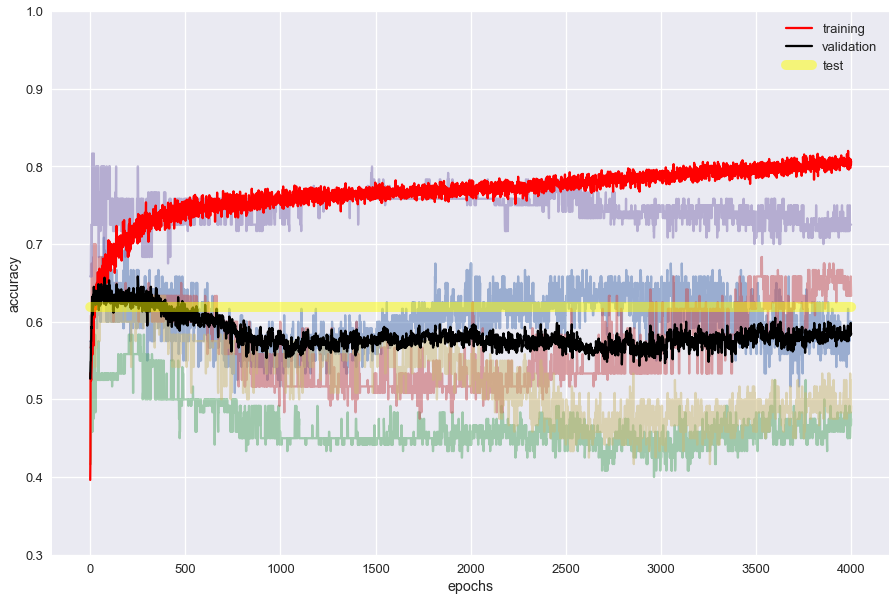

In [151]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
plt.ylim([0.3,1])
[plt.plot(np.arange(4000),h.history['val_categorical_accuracy'],alpha=.5) for h in histories];
plt.plot(np.arange(4000),np.mean([h.history['categorical_accuracy'] for h in histories],axis=0),c='red', label='training')
plt.plot(np.arange(4000),np.mean([h.history['val_categorical_accuracy'] for h in histories],axis=0),c='black', label='validation')
plt.plot(np.arange(4000),[0.619]*4000, c='yellow', linewidth=10, alpha=.5, label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

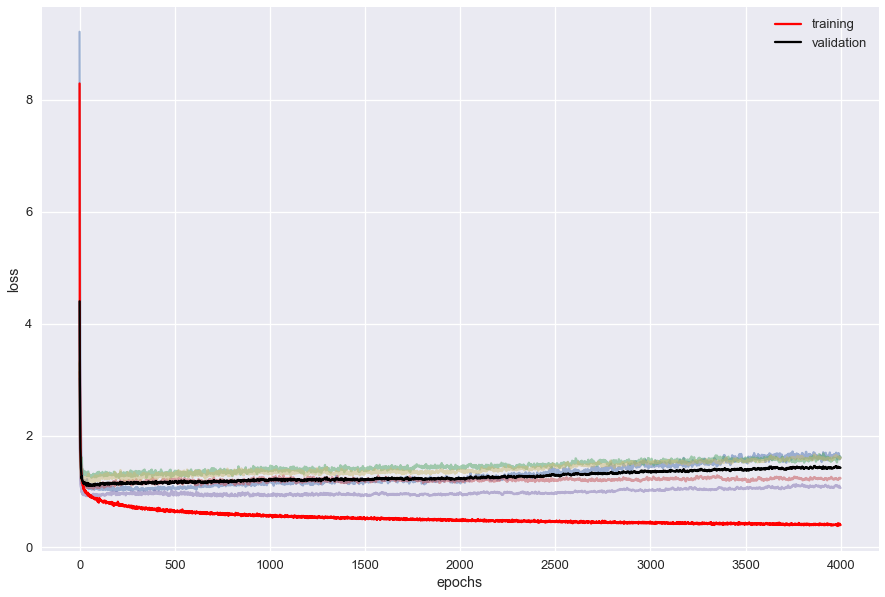

In [138]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
[plt.plot(np.arange(4000),h.history['val_loss'],alpha=.5) for h in histories];
plt.plot(np.arange(4000),np.mean([h.history['loss'] for h in histories],axis=0),c='red', label='training')
plt.plot(np.arange(4000),np.mean([h.history['val_loss'] for h in histories],axis=0),c='black', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [145]:
val_acc

[0.59999999403953552,
 0.47499999403953552,
 0.63333332538604736,
 0.72499999403953552,
 0.49166665971279144]

In [ ]:
val_acc

In [ ]:
val_acc

In [ ]:
model = load_model('4000epoch_0,9dropout_woFC_wBI.h5', custom_objects={'seq_len': seq_len})

In [ ]:
# categorical accuracy (this is a bit skewed since it looks at the each link. 
#                       Since most of them are 0 paddings, accuracy is much higher than it really is...)
model.evaluate(X_test, Y_test)

In [150]:
# Real Accuracy... (i.e. ratio of test samples that are completely correct predicted)
#                   not accounting for what has been predicted for the paddings
total_docs = len(Y_test)
total_links = sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

print('document accuracy', sum([np.array_equal(p[:i],y[:i]) for p,y,i in zip(np.argmax(histories[3].model.predict(X_test),-1), Y_test.argmax(-1), Y_test_ind)]) / total_docs)
print('link accuracy', sum([sum(p[:i] == y[:i]) for p,y,i in zip(np.argmax(histories[3].model.predict(X_test),-1),Y_test.argmax(-1), Y_test_ind)]) / total_links)

document accuracy 0.4166666666666667
link accuracy 0.619047619048


In [95]:
sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

False

In [ ]:
sum([np.array_equal(p,y) for p,y in zip(np.argmax(model.predict(X_test),-1),Y_test.argmax(-1))])

In [147]:
# compare predictions on training set with training labels
list(zip(models[-1].predict(X_train).argmax(-1), Y_train.argmax(-1)))

[(array([4, 0, 4, 4, 4, 0]), array([4, 0, 4, 4, 4, 0])),
 (array([2, 2, 2, 0, 0, 0]), array([2, 2, 2, 2, 2, 0])),
 (array([0, 0, 1, 0, 0, 1]), array([0, 0, 1, 0, 0, 0])),
 (array([2, 2, 2, 2, 3, 3]), array([2, 2, 2, 2, 3, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 0, 0, 3, 0])),
 (array([0, 0, 0, 2, 2, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([1, 2, 2, 2, 3, 0])),
 (array([4, 4, 1, 1, 4, 4]), array([4, 0, 1, 1, 4, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([2, 2, 2, 2, 2, 2]), array([0, 0, 0, 2, 0, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([3, 3, 3, 3, 3, 3]), array([3, 3, 3, 3, 0, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 1, 1, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([2, 2, 4, 4, 4, 2]), array([2, 2, 4, 4, 4, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([2, 2, 4, 4, 4, 2]), ar

In [148]:
list(zip(model.predict(X_test).argmax(-1), Y_test.argmax(-1)))

[(array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 2, 2, 0, 0]), array([5, 2, 0, 5, 5, 5])),
 (array([5, 3, 3, 5, 3, 5]), array([5, 5, 5, 5, 5, 5])),
 (array([4, 4, 4, 4, 4, 4]), array([1, 2, 3, 3, 3, 0])),
 (array([4, 4, 4, 2, 4, 4]), array([4, 4, 4, 2, 4, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 3, 0])),
 (array([2, 2, 2, 2, 2, 2]), array([0, 0, 0, 0, 3, 0])),
 (array([0, 0, 1, 0, 1, 0]), array([0, 0, 0, 0, 0, 4])),
 (array([0, 0, 0, 0, 3, 0]), array([4, 0, 4, 2, 4, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 5, 2, 0, 0]), array([4, 0, 4, 4, 4, 4]))]

In [ ]:
plot_model(model, to_file='model_withoutloop.png')

In [ ]:
!open 'model_withoutloop.png'